<a href="https://colab.research.google.com/github/AIManifest/deforum-stable-diffusion/blob/main/Deforum_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $ {\large \textsf{AI Manifest's Deforum Stable Diffusion v0.7 Custom Notebook}}$

$\color{gold}{\textsf {I DO NOT CLAIM ANY OFFICIAL CODE IN THIS NOTEBOOK}}$

THIS NOTEBOOK IS PURELY FOR MY FUN AND ALL CREDITS ARE DUE
TO THEIR RESPECTIVE OWNERS. I SIMPLY MADE A FUN INTERFACE TO 
INTERACT WITH FOR STABLE DIFFUSION, UPSCALING, INTERPOLATION, AND MODEL MERGING, AND TEXTUAL INVERSION. SEE BOTTOM CELL GROUP FOR ALL PERTINENT LICENSES FOR THE CODE USED IN THIS NOTEBOOK.

[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team. [K Diffusion](https://github.com/crowsonkb/k-diffusion) by [Katherine Crowson](https://twitter.com/RiversHaveWings). Notebook by [deforum](https://discord.gg/upmXXsrwZc)

[Quick Guide](https://docs.google.com/document/d/1RrQv7FntzOuLg4ohjRZPVL7iptIyBhwwbcEYEW2OfcI/edit?usp=sharing) to Deforum v0.7

$\color{red} {\textsf {FOR CONTROLNET, YOU ONLY NEED TO RUN THE ENVIRONMENT SETUP AND CONTROLNET CELL}}$

$\color{red} {\textsf {DO NOT RUN THE PATH SETUP CELL OR TEXTUAL INVERSION CELL WITH CONTROLNET}}$

# 🧰 $\color{orange} {\textsf {SETUP ENVIRONMENT}}$ 🧰

In [1]:
#@title $  {\large \textsf{Environment Setup / NVIDIA GPU -- **Mandatory** Run to Setup Everything for this Notebook}}$
print("\033[0;34m")
mount_drive_for_colab = True #@param {type:"boolean"}
if mount_drive_for_colab:
  from google.colab import drive
  drive.mount("/content/drive/")
from IPython import display
import random
import subprocess, os, sys, gc, time
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import wordnet
nltk.download('all')
display.clear_output(wait=True)
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"\033[0;34m{sub_p_res[:-1]}")
# subprocess.run(['pip', 'install', '-qq', '-U', 'kora', 'rich'], stdout=subprocess.PIPE, stderr=subprocess.PIPE).stdout.decode('utf-8')
subprocess.run(['pip', 'install', '-U', 'ffmpeg-python'], stdout=subprocess.PIPE, stderr=subprocess.PIPE).stdout.decode('utf-8')
def setup_environment():
    start_time = time.time()
    print_subprocess = False #@param{type:"boolean"}
    use_xformers_for_colab = True
    try:
        ipy = get_ipython()
    except:
        ipy = 'could not get_ipython'
    if 'google.colab' in str(ipy):
        print("\033[0;34m..setting up environment")

        # weird hack
        # import torch
        
        all_process = [
            ['pip', 'install', 'facexlib>=0.2.5', 'gfpgan>=1.3.5', 'basicsr>=1.4.2', 'sk-video>=1.1.10', 'omegaconf', 'einops==0.4.1', 'pytorch-lightning==1.7.7', 'torchmetrics', 'transformers', 'safetensors', 'kornia'],
            ['git', 'clone', 'https://github.com/AIManifest/deforum-stable-diffusion.git'],
            ['git', 'clone', 'https://github.com/AIManifest/Practical-RIFE.git'],
            ['git', 'clone', 'https://github.com/AIManifest/Real-ESRGAN.git'],
            ['git', 'clone', 'https://github.com/AIManifest/ESRGAN.git'],
            ['git', 'clone', 'https://github.com/lllyasviel/ControlNet.git', 'deforum-stable-diffusion/ControlNet'],
            ['pip', 'install', 'accelerate', 'ftfy', 'jsonmerge', 'matplotlib', 'resize-right', 'timm', 'torchdiffeq','scikit-learn','torchsde','open-clip-torch','numpngw', 'imageio-ffmpeg', 'piexif', 'fonts', 'font-roboto'],
            ['pip', 'install', '-qq', '--user', 'ffmpeg-python'],
        ]
        for process in tqdm(all_process):
            running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
            if print_subprocess:
                print(running)
        with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
            f.write('')
        sys.path.extend([
            'deforum-stable-diffusion/',
            'deforum-stable-diffusion/src',
            'deforum-stable-diffusion/ControlNet'
        ])
        if use_xformers_for_colab:

            print("\033[0;34m..installing triton and xformers")

            all_process = [['pip', 'install', 'triton==2.0.0.dev20221202', 'xformers==0.0.16']]
            for process in all_process:
                running = subprocess.run(process,stdout=subprocess.PIPE).stdout.decode('utf-8')
                if print_subprocess:
                    print(running)
    else:
        sys.path.extend([
            'src'
        ])
    end_time = time.time()
    print(f"\033[0;34m..environment set up in {end_time-start_time:.0f} seconds")
    return

setup_environment()
with open('deforum-stable-diffusion/src/k_diffusion/__init__.py', 'w') as f:
  f.write('')
sys.path.extend([
  'deforum-stable-diffusion/',
  'deforum-stable-diffusion/src',
  'deforum-stable-diffusion/ControlNet'
])
import torch
import cv2
import random
import clip
import yaml
from IPython import display
from ipywidgets import widgets
from IPython import display
import glob
import os
import re
import shutil
import torch
import tqdm
import safetensors.torch
import requests
from types import SimpleNamespace
from helpers.save_images import get_output_folder
from helpers.settings import load_args
from helpers.render import render_animation, render_input_video, render_image_batch, render_interpolation
from helpers.model_load import make_linear_decode, load_model, get_model_output_paths
from helpers.aesthetics import load_aesthetics_model
subprocess.run(['pip', 'install', '-qq', 'rich'], stderr=subprocess.PIPE, stdout=subprocess.PIPE).stdout.decode('utf-8')
from rich.console import Console
from rich.table import Table
from rich.style import Style
from rich.color import Color
console = Console()

Tesla T4, 15360 MiB, 15101 MiB
..setting up environment


  0%|          | 0/8 [00:00<?, ?it/s]

..installing triton and xformers
..environment set up in 17 seconds


# 📁 $\color{orange} {\textsf { SETUP PATHS}}$ 📁

In [2]:
#@title $ {\large \textsf{Path Setup}}$
print("\033[0;34m")
start_time = time.time()

#@markdown **Download CivitAI Models Here, if you use this, the `filename` parameter will override the `model_checkpoint` parameter.**
download_civit_model = False #@param{type:"boolean"}
if download_civit_model:
    model_URL = "https://civitai.com/api/download/models/4222" #@param {type:"string"}
    folder_path = "/content/drive/MyDrive/AII/hypernetworks" #@param {type:"string"}
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    #Name for the model
    filename = "classic_statue_marble.pt" #@param{type:"string"}

    # Download the file and save it to the folder
    response = requests.get(model_URL)
    with open(os.path.join(folder_path, filename), "wb") as f:
        f.write(response.content)

    print(f"File {filename} downloaded and saved to {folder_path}")

#@markdown **Deforum Path Setup**
def Root():
    models_path = "models" #@param {type:"string"}
    configs_path = "configs" #@param {type:"string"}
    output_path = "outputs" #@param {type:"string"}
    mount_google_drive = True #@param {type:"boolean"}
    models_path_gdrive = "/content/drive/MyDrive/sd/stable-diffusion-webui/models/Stable-diffusion" #@param {type:"string"}
    output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}

    #@markdown **Model Setup**
    map_location = "cuda" #@param ["cpu", "cuda"]
    model_config = "custom" #@param ["custom","v2-inference.yaml","v2-inference-v.yaml","v1-inference.yaml"]
    model_checkpoint =  "custom" #@param ["custom","v2-1_768-ema-pruned.ckpt","v2-1_512-ema-pruned.ckpt","768-v-ema.ckpt","512-base-ema.ckpt","Protogen_V2.2.ckpt","v1-5-pruned.ckpt","v1-5-pruned-emaonly.ckpt","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","wd-v1-3-float16.ckpt"]
    custom_config_path = "/content/deforum-stable-diffusion/ControlNet/models/cldm_v15.yaml" #@param {type:"string"}
    custom_checkpoint_path = "/content/drive/MyDrive/sd/stable-diffusion-webui/models/Stable-diffusion/control_sd15_hed.pth" #@param {type:"string"}
    control_net_model = True #@param{type:"boolean"}
    #@markdown $ \color{red} {\textsf{Leave These Blank if you Don't Need to Use Them, }}$
    #@markdown 
    #@markdown $ \color{red} {\textsf{But Generally, These Directories Should be Where All of }}$
    #@markdown 
    #@markdown $ \color{red} {\textsf{Your Embeddings, HyperNetworks, and Parent Directories are Respectively}}$
    embeddings_dir = "/content/drive/MyDrive/sd/stable-diffusion-webui/embeddings" #@param{type:'string'}
    hypernetwork_dir = "/content/drive/MyDrive/AI/hypernetworks" #@param{type:'string'}
    data_dir = "/content/drive/MyDrive/sd/stable-diffusion-webui" #@param{type:'string'}
    #@markdown **Don't use yet, still working on it**
    use_xformers = True #@param{type:'boolean'}
    use_sub_quad_attention = False #@param{type:'boolean'}
    use_split_attention_v1 = False #@param{type:'boolean'}
    use_split_cross_attention_forward_invokeAI = False #@param{type:'boolean'}
    use_cross_attention_attnblock_forward = False #@param{type:'boolean'}

    variables = locals()
    with open("Deforum.yaml", "w") as file:
      yaml.dump(variables, file)
    return variables

root = Root()
root = SimpleNamespace(**root)

if download_civit_model:
    root.model_checkpoint = f"{folder_path}/{filename}"

root.models_path, root.output_path = get_model_output_paths(root)
root.model, root.device = load_model(root, load_on_run_all=True, check_sha256=True, map_location="cuda")

end_time = time.time()
time_elapsed = end_time - start_time

print(f"..Setup Paths in {time_elapsed} seconds..")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
models_path: /content/drive/MyDrive/sd/stable-diffusion-webui/models/Stable-diffusion
output_path: /content/drive/MyDrive/AI/StableDiffusion
config_path: /content/deforum-stable-diffusion/ControlNet/models/cldm_v15.yaml
ckpt_path: /content/drive/MyDrive/sd/stable-diffusion-webui/models/Stable-diffusion/control_sd15_hed.pth
Loaded model config from [/content/deforum-stable-diffusion/ControlNet/models/cldm_v15.yaml]
..Setup Paths in 54.78156638145447 seconds..


# 🔶 $\color{orange} {\textsf { LOAD TEXTUAL INVERSION}}$ 🔶

In [3]:
#@title $ {\large \textsf{Load Textual Inversion!}}$
# @title $\color{red} {\textsf {Run This Cell Only if you Intend to Load Textual Inversion Files}}$
# @title $\color{red} {\textsf {Otherwise, no need to run this cell.}}$
model = root.model
model.to(root.device)
model.logvar.to(root.device)
# model = model.half()
device = root.device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device("cpu")
root.embeddings_dir = root.embeddings_dir#"/content/drive/MyDrive/sd/stable-diffusion-webui/textual_inversion/2023-03-05/cjcjgp/embeddings" #
root.hypernetwork_dir = root.hypernetwork_dir
# cpu = torch.device("cpu")
# device = device_interrogate = device_gfpgan = device_esrgan = device_codeformer = None
dtype = torch.float16
dtype_vae = torch.float16
dtype_unet = "cuda"
unet_needs_upcast = False
precision = "full"
opts_pin_memory = False
opts_upcast_attn = False
t_autocast = torch.autocast("cuda")

import os
import sys
import traceback
import inspect
from collections import namedtuple
import contextlib
import torch
import tqdm
import html
import datetime
import csv
import safetensors.torch
from helpers.auto1111helpers.dummy_generate import generate
import numpy as np
from PIL import Image, PngImagePlugin
from torch.utils.tensorboard import SummaryWriter
import datetime
import sys
import traceback

import pytz
import io
import math
import os
from collections import namedtuple
import re

import base64
import json
import numpy as np
import zlib
import numpy as np
import piexif
import piexif.helper
from PIL import Image, ImageFont, ImageDraw, PngImagePlugin
try:
    from fonts.ttf import Roboto
except ImportError:
    subprocess.run(["pip", "install", "font-roboto"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
import string
import json
import hashlib
root.model_checkpoint = root.custom_checkpoint_path
checkpoint_name = os.path.splitext(os.path.basename(root.model_checkpoint))
print("\033[92m")
import hashlib
print("..checking sha256")

with open(root.custom_checkpoint_path, "rb") as f:
  bytes = f.read() 
  ckpt_hash = hashlib.sha256(bytes).hexdigest()

invalid_filename_chars = '<>:"/\\|?*\n'
invalid_filename_prefix = ' '
invalid_filename_postfix = ' .'
re_nonletters = re.compile(r'[\s' + string.punctuation + ']+')
re_pattern = re.compile(r"(.*?)(?:\[([^\[\]]+)\]|$)")
re_pattern_arg = re.compile(r"(.*)<([^>]*)>$")
max_filename_part_length = 128

#images
def sanitize_filename_part(text, replace_spaces=True):
    if text is None:
        return None

    if replace_spaces:
        text = text.replace(' ', '_')

    text = text.translate({ord(x): '_' for x in invalid_filename_chars})
    text = text.lstrip(invalid_filename_prefix)[:max_filename_part_length]
    text = text.rstrip(invalid_filename_postfix)
    return text

class FilenameGenerator:
    replacements = {
        'seed': lambda self: self.seed if self.seed is not None else '',
        'steps': lambda self: self.steps,
        'cfg': lambda self: self.scale,
        'width': lambda self: self.image.width,
        'height': lambda self: self.image.height,
        'styles': lambda self: sanitize_filename_part(", ".join([style for style in self.p.styles if not style == "None"]) or "None", replace_spaces=False),
        'sampler': lambda self: sanitize_filename_part(self.p.sampler_name, replace_spaces=False),
        'model_hash': lambda self: ckpt_hash,
        'model_name': lambda self: sanitize_filename_part(os.path.basename(root.custom_checkpoint_path), replace_spaces=False),
        'date': lambda self: datetime.datetime.now().strftime('%Y-%m-%d'),
        'datetime': lambda self, *args: self.datetime(*args),  # accepts formats: [datetime], [datetime<Format>], [datetime<Format><Time Zone>]
        # 'job_timestamp': lambda self: getattr(self.p, "job_timestamp", shared.state.job_timestamp),
        'prompt_hash': lambda self: hashlib.sha256(self.prompt.encode()).hexdigest()[0:8],
        'prompt': lambda self: sanitize_filename_part(self.prompt),
        'prompt_no_styles': lambda self: "no_style",
        'prompt_spaces': lambda self: sanitize_filename_part(self.prompt, replace_spaces=False),
        'prompt_words': lambda self: "no words",
    }
    default_time_format = '%Y%m%d%H%M%S'

    def __init__(self, p, seed, prompt, image):
        # self.p = p
        self.seed = seed
        self.prompt = prompt
        self.image = image

    def prompt_words(self):
        words = [x for x in re_nonletters.split(self.prompt or "") if len(x) > 0]
        if len(words) == 0:
            words = ["empty"]
        return sanitize_filename_part(" ".join(words[0:30]), replace_spaces=False)

    def datetime(self, *args):
        time_datetime = datetime.datetime.now()

        time_format = args[0] if len(args) > 0 and args[0] != "" else self.default_time_format
        try:
            time_zone = pytz.timezone(args[1]) if len(args) > 1 else None
        except pytz.exceptions.UnknownTimeZoneError as _:
            time_zone = None

        time_zone_time = time_datetime.astimezone(time_zone)
        try:
            formatted_time = time_zone_time.strftime(time_format)
        except (ValueError, TypeError) as _:
            formatted_time = time_zone_time.strftime(self.default_time_format)

        return sanitize_filename_part(formatted_time, replace_spaces=False)

    def apply(self, x):
        res = ''

        for m in re_pattern.finditer(x):
            text, pattern = m.groups()
            res += text

            if pattern is None:
                continue

            pattern_args = []
            while True:
                m = re_pattern_arg.match(pattern)
                if m is None:
                    break

                pattern, arg = m.groups()
                pattern_args.insert(0, arg)

            fun = self.replacements.get(pattern.lower())
            if fun is not None:
                try:
                    replacement = fun(self, *pattern_args)
                except Exception:
                    replacement = None
                    print(f"Error adding [{pattern}] to filename", file=sys.stderr)
                    print(traceback.format_exc(), file=sys.stderr)

                if replacement is not None:
                    res += str(replacement)
                    continue

            res += f'[{pattern}]'

        return res

def get_next_sequence_number(path, basename):
    """
    Determines and returns the next sequence number to use when saving an image in the specified directory.
    The sequence starts at 0.
    """
    result = -1
    if basename != '':
        basename = basename + "-"

    prefix_length = len(basename)
    for p in os.listdir(path):
        if p.startswith(basename):
            l = os.path.splitext(p[prefix_length:])[0].split('-')  # splits the filename (removing the basename first if one is defined, so the sequence number is always the first element)
            try:
                result = max(int(l[0]), result)
            except ValueError:
                pass

    return result + 1

def save_image(image, path, basename, seed=None, prompt=None, extension='png', info=None, short_filename=False, no_prompt=False, grid=False, pnginfo_section_name='parameters', p=None, existing_info=None, forced_filename=None, suffix="", save_to_dirs=None):
    """Save an image.
    Args:
        image (`PIL.Image`):
            The image to be saved.
        path (`str`):
            The directory to save the image. Note, the option `save_to_dirs` will make the image to be saved into a sub directory.
        basename (`str`):
            The base filename which will be applied to `filename pattern`.
        seed, prompt, short_filename,
        extension (`str`):
            Image file extension, default is `png`.
        pngsectionname (`str`):
            Specify the name of the section which `info` will be saved in.
        info (`str` or `PngImagePlugin.iTXt`):
            PNG info chunks.
        existing_info (`dict`):
            Additional PNG info. `existing_info == {pngsectionname: info, ...}`
        no_prompt:
            TODO I don't know its meaning.
        p (`StableDiffusionProcessing`)
        forced_filename (`str`):
            If specified, `basename` and filename pattern will be ignored.
        save_to_dirs (bool):
            If true, the image will be saved into a subdirectory of `path`.
    Returns: (fullfn, txt_fullfn)
        fullfn (`str`):
            The full path of the saved imaged.
        txt_fullfn (`str` or None):
            If a text file is saved for this image, this will be its full path. Otherwise None.
    """
    namegen = FilenameGenerator(p, seed, prompt, image)

    if save_to_dirs is None:
        save_to_dirs = (grid and opts.grid_save_to_dirs) or (not grid and opts.save_to_dirs and not no_prompt)

    if save_to_dirs:
        dirname = namegen.apply(opts.directories_filename_pattern or "[prompt_words]").lstrip(' ').rstrip('\\ /')
        path = os.path.join(path, dirname)

    os.makedirs(path, exist_ok=True)

    if forced_filename is None:
        if short_filename or seed is None:
            file_decoration = ""
        elif opts.save_to_dirs:
            file_decoration = opts.samples_filename_pattern or "[seed]"
        else:
            file_decoration = opts.samples_filename_pattern or "[seed]-[prompt_spaces]"

        add_number = file_decoration == ''

        if file_decoration != "" and add_number:
            file_decoration = "-" + file_decoration

        file_decoration = namegen.apply(file_decoration) + suffix

        if add_number:
            basecount = get_next_sequence_number(path, basename)
            fullfn = None
            for i in range(500):
                fn = f"{basecount + i:05}" if basename == '' else f"{basename}-{basecount + i:04}"
                fullfn = os.path.join(path, f"{fn}{file_decoration}.{extension}")
                if not os.path.exists(fullfn):
                    break
        else:
            fullfn = os.path.join(path, f"{file_decoration}.{extension}")
    else:
        fullfn = os.path.join(path, f"{forced_filename}.{extension}")

    pnginfo = existing_info or {}
    if info is not None:
        pnginfo[pnginfo_section_name] = info

    # params = script_callbacks.ImageSaveParams(image, p, fullfn, pnginfo)
    # script_callbacks.before_image_saved_callback(params)

    # image = params.image
    # fullfn = params.filename
    # info = params.pnginfo.get(pnginfo_section_name, None)

#image_embedding

class EmbeddingEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, torch.Tensor):
            return {'TORCHTENSOR': obj.cpu().detach().numpy().tolist()}
        return json.JSONEncoder.default(self, obj)


class EmbeddingDecoder(json.JSONDecoder):
    def __init__(self, *args, **kwargs):
        json.JSONDecoder.__init__(self, object_hook=self.object_hook, *args, **kwargs)

    def object_hook(self, d):
        if 'TORCHTENSOR' in d:
            return torch.from_numpy(np.array(d['TORCHTENSOR']))
        return d


def embedding_to_b64(data):
    d = json.dumps(data, cls=EmbeddingEncoder)
    return base64.b64encode(d.encode())


def embedding_from_b64(data):
    d = base64.b64decode(data)
    return json.loads(d, cls=EmbeddingDecoder)


def lcg(m=2**32, a=1664525, c=1013904223, seed=0):
    while True:
        seed = (a * seed + c) % m
        yield seed % 255


def xor_block(block):
    g = lcg()
    randblock = np.array([next(g) for _ in range(np.product(block.shape))]).astype(np.uint8).reshape(block.shape)
    return np.bitwise_xor(block.astype(np.uint8), randblock & 0x0F)


def style_block(block, sequence):
    im = Image.new('RGB', (block.shape[1], block.shape[0]))
    draw = ImageDraw.Draw(im)
    i = 0
    for x in range(-6, im.size[0], 8):
        for yi, y in enumerate(range(-6, im.size[1], 8)):
            offset = 0
            if yi % 2 == 0:
                offset = 4
            shade = sequence[i % len(sequence)]
            i += 1
            draw.ellipse((x+offset, y, x+6+offset, y+6), fill=(shade, shade, shade))

    fg = np.array(im).astype(np.uint8) & 0xF0

    return block ^ fg


def insert_image_data_embed(image, data):
    d = 3
    data_compressed = zlib.compress(json.dumps(data, cls=EmbeddingEncoder).encode(), level=9)
    data_np_ = np.frombuffer(data_compressed, np.uint8).copy()
    data_np_high = data_np_ >> 4
    data_np_low = data_np_ & 0x0F

    h = image.size[1]
    next_size = data_np_low.shape[0] + (h-(data_np_low.shape[0] % h))
    next_size = next_size + ((h*d)-(next_size % (h*d)))

    data_np_low = np.resize(data_np_low, next_size)
    data_np_low = data_np_low.reshape((h, -1, d))

    data_np_high = np.resize(data_np_high, next_size)
    data_np_high = data_np_high.reshape((h, -1, d))

    edge_style = list(data['string_to_param'].values())[0].cpu().detach().numpy().tolist()[0][:1024]
    edge_style = (np.abs(edge_style)/np.max(np.abs(edge_style))*255).astype(np.uint8)

    data_np_low = style_block(data_np_low, sequence=edge_style)
    data_np_low = xor_block(data_np_low)
    data_np_high = style_block(data_np_high, sequence=edge_style[::-1])
    data_np_high = xor_block(data_np_high)

    im_low = Image.fromarray(data_np_low, mode='RGB')
    im_high = Image.fromarray(data_np_high, mode='RGB')

    background = Image.new('RGB', (image.size[0]+im_low.size[0]+im_high.size[0]+2, image.size[1]), (0, 0, 0))
    background.paste(im_low, (0, 0))
    background.paste(image, (im_low.size[0]+1, 0))
    background.paste(im_high, (im_low.size[0]+1+image.size[0]+1, 0))

    return background


def crop_black(img, tol=0):
    mask = (img > tol).all(2)
    mask0, mask1 = mask.any(0), mask.any(1)
    col_start, col_end = mask0.argmax(), mask.shape[1]-mask0[::-1].argmax()
    row_start, row_end = mask1.argmax(), mask.shape[0]-mask1[::-1].argmax()
    return img[row_start:row_end, col_start:col_end]


def extract_image_data_embed(image):
    d = 3
    outarr = crop_black(np.array(image.convert('RGB').getdata()).reshape(image.size[1], image.size[0], d).astype(np.uint8)) & 0x0F
    black_cols = np.where(np.sum(outarr, axis=(0, 2)) == 0)
    if black_cols[0].shape[0] < 2:
        print('No Image data blocks found.')
        return None

    data_block_lower = outarr[:, :black_cols[0].min(), :].astype(np.uint8)
    data_block_upper = outarr[:, black_cols[0].max()+1:, :].astype(np.uint8)

    data_block_lower = xor_block(data_block_lower)
    data_block_upper = xor_block(data_block_upper)

    data_block = (data_block_upper << 4) | (data_block_lower)
    data_block = data_block.flatten().tobytes()

    data = zlib.decompress(data_block)
    return json.loads(data, cls=EmbeddingDecoder)


def caption_image_overlay(srcimage, title, footerLeft, footerMid, footerRight, textfont=None):
    from math import cos

    image = srcimage.copy()
    fontsize = 32
    if textfont is None:
        try:
            textfont = ImageFont.truetype(Roboto, fontsize)
            textfont = Roboto
        except Exception:
            textfont = Roboto

    factor = 1.5
    gradient = Image.new('RGBA', (1, image.size[1]), color=(0, 0, 0, 0))
    for y in range(image.size[1]):
        mag = 1-cos(y/image.size[1]*factor)
        mag = max(mag, 1-cos((image.size[1]-y)/image.size[1]*factor*1.1))
        gradient.putpixel((0, y), (0, 0, 0, int(mag*255)))
    image = Image.alpha_composite(image.convert('RGBA'), gradient.resize(image.size))

    draw = ImageDraw.Draw(image)

    font = ImageFont.truetype(textfont, fontsize)
    padding = 10

    _, _, w, h = draw.textbbox((0, 0), title, font=font)
    fontsize = min(int(fontsize * (((image.size[0]*0.75)-(padding*4))/w)), 72)
    font = ImageFont.truetype(textfont, fontsize)
    _, _, w, h = draw.textbbox((0, 0), title, font=font)
    draw.text((padding, padding), title, anchor='lt', font=font, fill=(255, 255, 255, 230))

    _, _, w, h = draw.textbbox((0, 0), footerLeft, font=font)
    fontsize_left = min(int(fontsize * (((image.size[0]/3)-(padding))/w)), 72)
    _, _, w, h = draw.textbbox((0, 0), footerMid, font=font)
    fontsize_mid = min(int(fontsize * (((image.size[0]/3)-(padding))/w)), 72)
    _, _, w, h = draw.textbbox((0, 0), footerRight, font=font)
    fontsize_right = min(int(fontsize * (((image.size[0]/3)-(padding))/w)), 72)

    font = ImageFont.truetype(textfont, min(fontsize_left, fontsize_mid, fontsize_right))

    draw.text((padding, image.size[1]-padding),               footerLeft, anchor='ls', font=font, fill=(255, 255, 255, 230))
    draw.text((image.size[0]/2, image.size[1]-padding),       footerMid, anchor='ms', font=font, fill=(255, 255, 255, 230))
    draw.text((image.size[0]-padding, image.size[1]-padding), footerRight, anchor='rs', font=font, fill=(255, 255, 255, 230))

    return image


# if __name__ == '__main__':

#     testEmbed = Image.open('test_embedding.png')
#     data = extract_image_data_embed(testEmbed)
#     assert data is not None

#     data = embedding_from_b64(testEmbed.text['sd-ti-embedding'])
#     assert data is not None

#     image = Image.new('RGBA', (512, 512), (255, 255, 200, 255))
#     cap_image = caption_image_overlay(image, 'title', 'footerLeft', 'footerMid', 'footerRight')

#     test_embed = {'string_to_param': {'*': torch.from_numpy(np.random.random((2, 4096)))}}

#     embedded_image = insert_image_data_embed(cap_image, test_embed)

#     retrived_embed = extract_image_data_embed(embedded_image)

#     assert str(retrived_embed) == str(test_embed)

#     embedded_image2 = insert_image_data_embed(cap_image, retrived_embed)

#     assert embedded_image == embedded_image2

#     g = lcg()
#     shared_random = np.array([next(g) for _ in range(100)]).astype(np.uint8).tolist()

#     reference_random = [253, 242, 127,  44, 157,  27, 239, 133,  38,  79, 167,   4, 177,
#                          95, 130,  79,  78,  14,  52, 215, 220, 194, 126,  28, 240, 179,
#                         160, 153, 149,  50, 105,  14,  21, 218, 199,  18,  54, 198, 193,
#                          38, 128,  19,  53, 195, 124,  75, 205,  12,   6, 145,   0,  28,
#                          30, 148,   8,  45, 218, 171,  55, 249,  97, 166,  12,  35,   0,
#                          41, 221, 122, 215, 170,  31, 113, 186,  97, 119,  31,  23, 185,
#                          66, 140,  30,  41,  37,  63, 137, 109, 216,  55, 159, 145,  82,
#                          204, 86,  73, 222,  44, 198, 118, 240,  97]

#     assert shared_random == reference_random

#     hunna_kay_random_sum = sum(np.array([next(g) for _ in range(100000)]).astype(np.uint8).tolist())

#     assert 12731374 == hunna_kay_random_sum

#learn_rate_scheduler

import tqdm

def autocast(disable=False):
    
    if disable:
        return contextlib.nullcontext()

    if dtype == torch.float32 or precision == "full":
        return contextlib.nullcontext()

    return torch.autocast("cuda")

no_autocast = autocast()

class LearnScheduleIterator:
    def __init__(self, learn_rate, max_steps, cur_step=0):
        """
        specify learn_rate as "0.001:100, 0.00001:1000, 1e-5:10000" to have lr of 0.001 until step 100, 0.00001 until 1000, and 1e-5 until 10000
        """
        print(learn_rate)
        pairs = learn_rate.split(',')
        self.rates = []
        self.it = 0
        self.maxit = 0
        try:
            for i, pair in enumerate(pairs):
                if not pair.strip():
                    continue
                tmp = pair.split(':')
                if len(tmp) == 2:
                    step = int(tmp[1])
                    if step > cur_step:
                        self.rates.append((float(tmp[0]), min(step, max_steps)))
                        self.maxit += 1
                        if step > max_steps:
                            return
                    elif step == -1:
                        self.rates.append((float(tmp[0]), max_steps))
                        self.maxit += 1
                        return
                else:
                    self.rates.append((float(tmp[0]), max_steps))
                    self.maxit += 1
                    return
            assert self.rates
        except (ValueError, AssertionError):
            raise Exception('Invalid learning rate schedule. It should be a number or, for example, like "0.001:100, 0.00001:1000, 1e-5:10000" to have lr of 0.001 until step 100, 0.00001 until 1000, and 1e-5 until 10000.')


    def __iter__(self):
        return self

    def __next__(self):
        if self.it < self.maxit:
            self.it += 1
            return self.rates[self.it - 1]
        else:
            raise StopIteration


class LearnRateScheduler:
    def __init__(self, learn_rate, max_steps, cur_step=0, verbose=True):
        self.schedules = LearnScheduleIterator(learn_rate, max_steps, cur_step)
        (self.learn_rate,  self.end_step) = next(self.schedules)
        self.verbose = verbose

        if self.verbose:
            print(f'Training at rate of {self.learn_rate} until step {self.end_step}')

        self.finished = False

    def step(self, step_number):
        if step_number < self.end_step:
            return False

        try:
            (self.learn_rate, self.end_step) = next(self.schedules)
        except StopIteration:
            self.finished = True
            return False
        return True

    def apply(self, optimizer, step_number):
        if not self.step(step_number):
            return

        if self.verbose:
            tqdm.tqdm.write(f'Training at rate of {self.learn_rate} until step {self.end_step}')

        for pg in optimizer.param_groups:
            pg['lr'] = self.learn_rate

#dataset
import os
import numpy as np
import PIL
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms
from collections import defaultdict
from random import shuffle, choices

import random
from tqdm.notebook import tqdm
import re

from ldm.modules.distributions.distributions import DiagonalGaussianDistribution

re_numbers_at_start = re.compile(r"^[-\d]+\s*")


class DatasetEntry:
    def __init__(self, filename=None, filename_text=None, latent_dist=None, latent_sample=None, cond=None, cond_text=None, pixel_values=None):
        self.filename = filename
        self.filename_text = filename_text
        self.latent_dist = latent_dist
        self.latent_sample = latent_sample
        self.cond = cond
        self.cond_text = cond_text
        self.pixel_values = pixel_values

dataset_filename_join_string= " "
dataset_filename_word_regex = ""
class PersonalizedBase(Dataset):
    def __init__(self, data_root, width, height, repeats, flip_p=0.5, placeholder_token="*", model=None, cond_model=None, device=None, template_file=None, include_cond=False, batch_size=1, gradient_step=1, shuffle_tags=False, tag_drop_out=0, latent_sampling_method='once', varsize=False):
        re_word = re.compile(dataset_filename_word_regex) if len(dataset_filename_word_regex) > 0 else None

        self.placeholder_token = placeholder_token

        self.flip = transforms.RandomHorizontalFlip(p=flip_p)

        self.dataset = []

        with open(template_file, "r") as file:
            lines = [x.strip() for x in file.readlines()]

        self.lines = lines

        assert data_root, 'dataset directory not specified'
        assert os.path.isdir(data_root), "Dataset directory doesn't exist"
        assert os.listdir(data_root), "Dataset directory is empty"

        self.image_paths = [os.path.join(data_root, file_path) for file_path in os.listdir(data_root)]

        self.shuffle_tags = shuffle_tags
        self.tag_drop_out = tag_drop_out
        groups = defaultdict(list)

        print("Preparing dataset...")
        for path in tqdm.tqdm(self.image_paths):
            # if shared.state.interrupted:
            #     raise Exception("interrupted")
            try:
                image = Image.open(path).convert('RGB')
                if not varsize:
                    image = image.resize((width, height), PIL.Image.BICUBIC)
            except Exception:
                continue

            text_filename = os.path.splitext(path)[0] + ".txt"
            filename = os.path.basename(path)

            if os.path.exists(text_filename):
                with open(text_filename, "r", encoding="utf8") as file:
                    filename_text = file.read()
            else:
                filename_text = os.path.splitext(filename)[0]
                filename_text = re.sub(re_numbers_at_start, '', filename_text)
                if re_word:
                    tokens = re_word.findall(filename_text)
                    filename_text = (dataset_filename_join_string or "").join(tokens)

            npimage = np.array(image).astype(np.uint8)
            npimage = (npimage / 127.5 - 1.0).astype(np.float32)

            torchdata = torch.from_numpy(npimage).permute(2, 0, 1).to(device=device, dtype=torch.float32)
            latent_sample = None
            #jpsaiart
            with t_autocast:
                latent_dist = model.encode_first_stage(torchdata.unsqueeze(dim=0))

            if latent_sampling_method == "deterministic":
                if isinstance(latent_dist, DiagonalGaussianDistribution):
                    # Works only for DiagonalGaussianDistribution
                    latent_dist.std = 0
                else:
                    latent_sampling_method = "once"
            latent_sample = model.get_first_stage_encoding(latent_dist).squeeze().to(root.device)
            if latent_sampling_method == "random":
                entry = DatasetEntry(filename=path, filename_text=filename_text, latent_dist=latent_dist)
            else:
                entry = DatasetEntry(filename=path, filename_text=filename_text, latent_sample=latent_sample)

            if not (self.tag_drop_out != 0 or self.shuffle_tags):
                entry.cond_text = self.create_text(filename_text)

            if include_cond and not (self.tag_drop_out != 0 or self.shuffle_tags):
                with t_autocast:
                    entry.cond = cond_model([entry.cond_text]).to(root.device).squeeze(0)
            groups[image.size].append(len(self.dataset))
            self.dataset.append(entry)
            del torchdata
            del latent_dist
            del latent_sample

        self.length = len(self.dataset)
        self.groups = list(groups.values())
        assert self.length > 0, "No images have been found in the dataset."
        self.batch_size = min(batch_size, self.length)
        self.gradient_step = min(gradient_step, self.length // self.batch_size)
        self.latent_sampling_method = latent_sampling_method

        if len(groups) > 1:
            print("Buckets:")
            for (w, h), ids in sorted(groups.items(), key=lambda x: x[0]):
                print(f"  {w}x{h}: {len(ids)}")
            print()

    def create_text(self, filename_text):
        text = random.choice(self.lines)
        tags = filename_text.split(',')
        if self.tag_drop_out != 0:
            tags = [t for t in tags if random.random() > self.tag_drop_out]
        if self.shuffle_tags:
            random.shuffle(tags)
        text = text.replace("[filewords]", ','.join(tags))
        text = text.replace("[name]", self.placeholder_token)
        return text

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        entry = self.dataset[i]
        if self.tag_drop_out != 0 or self.shuffle_tags:
            entry.cond_text = self.create_text(entry.filename_text)
        if self.latent_sampling_method == "random":
            entry.latent_sample = model.get_first_stage_encoding(entry.latent_dist).to(root.device)
        return entry


class GroupedBatchSampler(Sampler):
    def __init__(self, data_source: PersonalizedBase, batch_size: int):
        super().__init__(data_source)

        n = len(data_source)
        self.groups = data_source.groups
        self.len = n_batch = n // batch_size
        expected = [len(g) / n * n_batch * batch_size for g in data_source.groups]
        self.base = [int(e) // batch_size for e in expected]
        self.n_rand_batches = nrb = n_batch - sum(self.base)
        self.probs = [e%batch_size/nrb/batch_size if nrb>0 else 0 for e in expected]
        self.batch_size = batch_size

    def __len__(self):
        return self.len

    def __iter__(self):
        b = self.batch_size

        for g in self.groups:
            shuffle(g)

        batches = []
        for g in self.groups:
            batches.extend(g[i*b:(i+1)*b] for i in range(len(g) // b))
        for _ in range(self.n_rand_batches):
            rand_group = choices(self.groups, self.probs)[0]
            batches.append(choices(rand_group, k=b))

        shuffle(batches)

        yield from batches


class PersonalizedDataLoader(DataLoader):
    def __init__(self, dataset, latent_sampling_method="once", batch_size=1, pin_memory=False):
        super(PersonalizedDataLoader, self).__init__(dataset, batch_sampler=GroupedBatchSampler(dataset, batch_size), pin_memory=pin_memory)
        if latent_sampling_method == "random":
            self.collate_fn = collate_wrapper_random
        else:
            self.collate_fn = collate_wrapper


class BatchLoader:
    def __init__(self, data):
        self.cond_text = [entry.cond_text for entry in data]
        self.cond = [entry.cond for entry in data]
        self.latent_sample = torch.stack([entry.latent_sample for entry in data]).squeeze(1)
        #self.emb_index = [entry.emb_index for entry in data]
        #print(self.latent_sample.device)

    def pin_memory(self):
        self.latent_sample = self.latent_sample.pin_memory()
        return self

def collate_wrapper(batch):
    return BatchLoader(batch)

class BatchLoaderRandom(BatchLoader):
    def __init__(self, data):
        super().__init__(data)

    def pin_memory(self):
        return self

def collate_wrapper_random(batch):
    return BatchLoaderRandom(batch)

TextualInversionTemplate = namedtuple("TextualInversionTemplate", ["name", "path"])
textual_inversion_templates = {}

class Embedding:
    def __init__(self, vec, name, step=None):
        self.vec = vec
        self.name = name
        self.step = step
        self.shape = None
        self.vectors = 0
        self.cached_checksum = None
        self.sd_checkpoint = None
        self.sd_checkpoint_name = None
        self.optimizer_state_dict = None
        self.filename = None

    def save(self, filename):
        embedding_data = {
            "string_to_token": {"*": 265},
            "string_to_param": {"*": self.vec},
            "name": self.name,
            "step": self.step,
            "sd_checkpoint": self.sd_checkpoint,
            "sd_checkpoint_name": self.sd_checkpoint_name,
        }

        torch.save(embedding_data, filename)

        save_optimizer_state=True
        if save_optimizer_state and self.optimizer_state_dict is not None:
            optimizer_saved_dict = {
                'hash': self.checksum(),
                'optimizer_state_dict': self.optimizer_state_dict,
            }
            torch.save(optimizer_saved_dict, filename + '.optim')

    def checksum(self):
        if self.cached_checksum is not None:
            return self.cached_checksum

        def const_hash(a):
            r = 0
            for v in a:
                r = (r * 281 ^ int(v) * 997) & 0xFFFFFFFF
            return r

        self.cached_checksum = f'{const_hash(self.vec.reshape(-1) * 100) & 0xffff:04x}'
        return self.cached_checksum


class DirWithTextualInversionEmbeddings:
    def __init__(self, path):
        self.path = path
        self.mtime = None

    def has_changed(self):
        if not os.path.isdir(self.path):
            return False

        mt = os.path.getmtime(self.path)
        if self.mtime is None or mt > self.mtime:
            return True

    def update(self):
        if not os.path.isdir(self.path):
            return

        self.mtime = os.path.getmtime(self.path)


class EmbeddingDatabase:
    def __init__(self):
        self.ids_lookup = {}
        self.word_embeddings = {}
        self.skipped_embeddings = {}
        self.expected_shape = -1
        self.embedding_dirs = {}

    def add_embedding_dir(self, path):
        self.embedding_dirs[path] = DirWithTextualInversionEmbeddings(path)

    def clear_embedding_dirs(self):
        self.embedding_dirs.clear()

    def register_embedding(self, embedding, model):
        self.word_embeddings[embedding.name] = embedding

        ids = model.cond_stage_model.tokenize([embedding.name])[0]

        first_id = ids[0]
        if first_id not in self.ids_lookup:
            self.ids_lookup[first_id] = []

        self.ids_lookup[first_id] = sorted(self.ids_lookup[first_id] + [(ids, embedding)], key=lambda x: len(x[0]), reverse=True)

        return embedding

    def get_expected_shape(self):
        vec = model.cond_stage_model.encode_embedding_init_text(",", 1)
        return vec.shape[1]

    def load_from_file(self, path, filename):
        name, ext = os.path.splitext(filename)
        ext = ext.upper()

        if ext in ['.PNG', '.WEBP', '.JXL', '.AVIF']:
            _, second_ext = os.path.splitext(name)
            if second_ext.upper() == '.PREVIEW':
                return

            embed_image = Image.open(path)
            if hasattr(embed_image, 'text') and 'sd-ti-embedding' in embed_image.text:
                data = embedding_from_b64(embed_image.text['sd-ti-embedding'])
                name = data.get('name', name)
            else:
                data = extract_image_data_embed(embed_image)
                name = data.get('name', name)
        elif ext in ['.BIN', '.PT']:
            data = torch.load(path, map_location=device)
        elif ext in ['.SAFETENSORS']:
            data = safetensors.torch.load_file(path, device=device)
        else:
            return

        # textual inversion embeddings
        if 'string_to_param' in data:
            param_dict = data['string_to_param']
            if hasattr(param_dict, '_parameters'):
                param_dict = getattr(param_dict, '_parameters')  # fix for torch 1.12.1 loading saved file from torch 1.11
            assert len(param_dict) == 1, 'embedding file has multiple terms in it'
            emb = next(iter(param_dict.items()))[1]
        # diffuser concepts
        elif type(data) == dict and type(next(iter(data.values()))) == torch.Tensor:
            assert len(data.keys()) == 1, 'embedding file has multiple terms in it'

            emb = next(iter(data.values()))
            if len(emb.shape) == 1:
                emb = emb.unsqueeze(0)
        else:
            raise Exception(f"Couldn't identify {filename} as neither textual inversion embedding nor diffuser concept.")

        vec = emb.detach().to(device, dtype=torch.float32)
        embedding = Embedding(vec, name)
        embedding.step = data.get('step', None)
        embedding.sd_checkpoint = data.get('sd_checkpoint', None)
        embedding.sd_checkpoint_name = data.get('sd_checkpoint_name', None)
        embedding.vectors = vec.shape[0]
        embedding.shape = vec.shape[-1]
        embedding.filename = path

        if self.expected_shape == -1 or self.expected_shape == embedding.shape:
            self.register_embedding(embedding, root.model)
        else:
            self.skipped_embeddings[name] = embedding

    def load_from_dir(self, embdir):
        if not os.path.isdir(embdir.path):
            return

        for root, dirs, fns in os.walk(embdir.path):
            for fn in fns:
                try:
                    fullfn = os.path.join(root, fn)

                    if os.stat(fullfn).st_size == 0:
                        continue

                    self.load_from_file(fullfn, fn)
                except Exception:
                    print(f"Error loading embedding {fn}:", file=sys.stderr)
                    print(traceback.format_exc(), file=sys.stderr)
                    continue

    def load_textual_inversion_embeddings(self, force_reload=False):
        if not force_reload:
            need_reload = False
            for path, embdir in self.embedding_dirs.items():
                if embdir.has_changed():
                    need_reload = True
                    break

            if not need_reload:
                return

        self.ids_lookup.clear()
        self.word_embeddings.clear()
        self.skipped_embeddings.clear()
        self.expected_shape = self.get_expected_shape()

        for path, embdir in self.embedding_dirs.items():
            self.load_from_dir(embdir)
            embdir.update()

        print(f"Textual inversion embeddings loaded({len(self.word_embeddings)}): {', '.join(self.word_embeddings.keys())}")
        if len(self.skipped_embeddings) > 0:
            print(f"Textual inversion embeddings skipped({len(self.skipped_embeddings)}): {', '.join(self.skipped_embeddings.keys())}")

    def find_embedding_at_position(self, tokens, offset):
        token = tokens[offset]
        possible_matches = self.ids_lookup.get(token, None)

        if possible_matches is None:
            return None, None

        for ids, embedding in possible_matches:
            if tokens[offset:offset + len(ids)] == ids:
                return embedding, len(ids)

        return None, None

def txt2img_image_conditioning(model, x, width, height):
    if model.conditioning_key not in {'hybrid', 'concat'}:
        # Dummy zero conditioning if we're not using inpainting model.
        # Still takes up a bit of memory, but no encoder call.
        # Pretty sure we can just make this a 1x1 image since its not going to be used besides its batch size.
        return x.new_zeros(x.shape[0], 5, 1, 1, dtype=x.dtype, device=x.device)

    # The "masked-image" in this case will just be all zeros since the entire image is masked.
    image_conditioning = torch.zeros(x.shape[0], 3, height, width, device=x.device)
    image_conditioning = sd_model.get_first_stage_encoding(sd_model.encode_first_stage(image_conditioning))

    # Add the fake full 1s mask to the first dimension.
    image_conditioning = torch.nn.functional.pad(image_conditioning, (0, 0, 0, 0, 1, 0), value=1.0)
    image_conditioning = image_conditioning.to(x.dtype)

    return image_conditioning

#train embeddings
##markdown $ {\textsf{These Params are FOR TEXTUAL INVERSION TRAINING ONLY!}}$

def create_embedding(name, num_vectors_per_token, overwrite_old, init_text='*'):
    cond_model = model.cond_stage_model
    cond_model.to(device)
    # with t_autocast:
    #     cond_model([""])  # will send cond model to GPU if lowvram/medvram is active
    cond_model.to(device)
    #cond_model expects at least some text, so we provide '*' as backup.
    embedded = cond_model.encode_embedding_init_text(init_text or '*', num_vectors_per_token)
    vec = torch.zeros((num_vectors_per_token, embedded.shape[1]), device=device)

    #Only copy if we provided an init_text, otherwise keep vectors as zeros
    if init_text:
        for i in range(num_vectors_per_token):
            vec[i] = embedded[i * int(embedded.shape[0]) // num_vectors_per_token]

    # Remove illegal characters from name.
    name = "".join( x for x in name if (x.isalnum() or x in "._- "))
    fn = os.path.join(root.embeddings_dir, f"{name}.pt")
    if not overwrite_old:
        assert not os.path.exists(fn), f"file {fn} already exists"

    embedding = Embedding(vec, name)
    embedding.step = 0
    embedding.save(fn)

    return fn

training_write_csv_every=0
def write_loss(log_directory, filename, step, epoch_len, values):
    if training_write_csv_every == 0:
        return

    if step % training_write_csv_every != 0:
        return
    write_csv_header = False if os.path.exists(os.path.join(log_directory, filename)) else True

    with open(os.path.join(log_directory, filename), "a+", newline='') as fout:
        csv_writer = csv.DictWriter(fout, fieldnames=["step", "epoch", "epoch_step", *(values.keys())])

        if write_csv_header:
            csv_writer.writeheader()

        epoch = (step - 1) // epoch_len
        epoch_step = (step - 1) % epoch_len

        csv_writer.writerow({
            "step": step,
            "epoch": epoch,
            "epoch_step": epoch_step,
            **values,
        })

def tensorboard_setup(log_directory):
    os.makedirs(os.path.join(log_directory, "tensorboard"), exist_ok=True)
    training_tensorboard_flush_every=120
    return SummaryWriter(
            log_dir=os.path.join(log_directory, "tensorboard"),
            flush_secs=training_tensorboard_flush_every)

def tensorboard_add(tensorboard_writer, loss, global_step, step, learn_rate, epoch_num):
    tensorboard_add_scaler(tensorboard_writer, "Loss/train", loss, global_step)
    tensorboard_add_scaler(tensorboard_writer, f"Loss/train/epoch-{epoch_num}", loss, step)
    tensorboard_add_scaler(tensorboard_writer, "Learn rate/train", learn_rate, global_step)
    tensorboard_add_scaler(tensorboard_writer, f"Learn rate/train/epoch-{epoch_num}", learn_rate, step)

def tensorboard_add_scaler(tensorboard_writer, tag, value, step):
    tensorboard_writer.add_scalar(tag=tag, 
        scalar_value=value, global_step=step)

def tensorboard_add_image(tensorboard_writer, tag, pil_image, step):
    # Convert a pil image to a torch tensor
    img_tensor = torch.as_tensor(np.array(pil_image, copy=True))
    img_tensor = img_tensor.view(pil_image.size[1], pil_image.size[0], 
        len(pil_image.getbands()))
    img_tensor = img_tensor.permute((2, 0, 1))
                
    tensorboard_writer.add_image(tag, img_tensor, global_step=step)

def validate_train_inputs(model_name, learn_rate, batch_size, gradient_step, data_root, template_file, template_filename, steps, save_model_every, create_image_every, log_directory, name="embedding"):
    assert model_name, f"{name} not selected"
    assert learn_rate, "Learning rate is empty or 0"
    assert isinstance(batch_size, int), "Batch size must be integer"
    assert batch_size > 0, "Batch size must be positive"
    assert isinstance(gradient_step, int), "Gradient accumulation step must be integer"
    assert gradient_step > 0, "Gradient accumulation step must be positive"
    assert data_root, "Dataset directory is empty"
    assert os.path.isdir(data_root), "Dataset directory doesn't exist"
    assert os.listdir(data_root), "Dataset directory is empty"
    assert template_filename, "Prompt template file not selected"
    assert template_file, f"Prompt template file {template_filename} not found"
    assert os.path.isfile(template_file), f"Prompt template file {template_filename} doesn't exist"
    assert steps, "Max steps is empty or 0"
    assert isinstance(steps, int), "Max steps must be integer"
    assert steps > 0, "Max steps must be positive"
    assert isinstance(save_model_every, int), "Save {name} must be integer"
    assert save_model_every >= 0, "Save {name} must be positive or 0"
    assert isinstance(create_image_every, int), "Create image must be integer"
    assert create_image_every >= 0, "Create image must be positive or 0"
    if save_model_every or create_image_every:
        assert log_directory, "Log directory is empty"

# from helpers.generate import generate
def train_embedding(id_task, embedding_name, learn_rate, batch_size, gradient_step, data_root, log_directory, training_width, training_height, varsize, steps, clip_grad_mode, clip_grad_value, shuffle_tags, tag_drop_out, latent_sampling_method, create_image_every, save_embedding_every, template_filename, save_image_with_stored_embedding, preview_from_txt2img, preview_prompt, preview_negative_prompt, preview_steps, preview_sampler_index, preview_cfg_scale, preview_seed, preview_width, preview_height):
    save_embedding_every = save_embedding_every or 0
    create_image_every = create_image_every or 0
    template_file = template_filename
    validate_train_inputs(embedding_name, learn_rate, batch_size, gradient_step, data_root, template_file, template_filename, steps, save_embedding_every, create_image_every, log_directory, name="embedding")
    template_file = template_filename
    print(embedding_name)

    job = "train-embedding"
    textinfo = "Initializing textual inversion training..."
    job_count = steps
    import os
    import datetime
    filename = os.path.join(root.embeddings_dir, f'{embedding_name}.pt')

    log_directory = os.path.join(log_directory, datetime.datetime.now().strftime("%Y-%m-%d"), embedding_name)
    unload_models_when_training=False
    unload = unload_models_when_training

    if save_embedding_every > 0:
        embedding_dir = os.path.join(log_directory, "embeddings")
        os.makedirs(embedding_dir, exist_ok=True)
    else:
        embedding_dir = None

    if create_image_every > 0:
        images_dir = os.path.join(log_directory, "images")
        os.makedirs(images_dir, exist_ok=True)
    else:
        images_dir = None

    if create_image_every > 0 and save_image_with_stored_embedding:
        images_embeds_dir = os.path.join(log_directory, "image_embeddings")
        os.makedirs(images_embeds_dir, exist_ok=True)
    else:
        images_embeds_dir = None

    hijack = model_hijack

    embedding = hijack.embedding_db.word_embeddings[embedding_name]
    checkpoint = root.model
    initial_step = embedding.step or 0
    if initial_step >= steps:
        extinfo = "Model has already been trained beyond specified max steps"
        return embedding, filename
    
    scheduler = LearnRateScheduler(learn_rate, steps, initial_step)
    clip_grad = torch.nn.utils.clip_grad_value_ if clip_grad_mode == "value" else \
        torch.nn.utils.clip_grad_norm_ if clip_grad_mode == "norm" else \
        None
    if clip_grad:
        clip_grad_sched = LearnRateScheduler(clip_grad_value, steps, initial_step, verbose=False)
    # dataset loading may take a while, so input validations and early returns should be done before this
    textinfo = f"Preparing dataset from {html.escape(data_root)}..."
    parallel_processing_allowed=False
    old_parallel_processing_allowed = parallel_processing_allowed
    
    training_enable_tensorboard=True
    if training_enable_tensorboard:
        tensorboard_writer = tensorboard_setup(log_directory)

    pin_memory = opts_pin_memory
    model = root.model
    model.to(device)
    ds = PersonalizedBase(data_root=data_root, width=training_width, height=training_height, repeats=1, placeholder_token=embedding_name, model=root.model, cond_model=model.cond_stage_model, device=device, template_file=template_file, batch_size=batch_size, gradient_step=gradient_step, shuffle_tags=shuffle_tags, tag_drop_out=tag_drop_out, latent_sampling_method=latent_sampling_method, varsize=varsize)
    # print(f"ds.batch == {ds.batch_size}")
    import datetime
    import json
    import os

    saved_params_shared = {"model_name", "model_hash", "initial_step", "num_of_dataset_images", "learn_rate", "batch_size", "clip_grad_mode", "clip_grad_value", "gradient_step", "data_root", "log_directory", "training_width", "training_height", "steps", "create_image_every", "template_file", "gradient_step", "latent_sampling_method"}
    saved_params_ti = {"embedding_name", "num_vectors_per_token", "save_embedding_every", "save_image_with_stored_embedding"}
    saved_params_hypernet = {"hypernetwork_name", "layer_structure", "activation_func", "weight_init", "add_layer_norm", "use_dropout", "save_hypernetwork_every"}
    saved_params_all = saved_params_shared | saved_params_ti | saved_params_hypernet
    saved_params_previews = {"preview_prompt", "preview_negative_prompt", "preview_steps", "preview_sampler_index", "preview_cfg_scale", "preview_seed", "preview_width", "preview_height"}


    def save_settings_to_file(log_directory, all_params):
        now = datetime.datetime.now()
        params = {"datetime": now.strftime("%Y-%m-%d %H:%M:%S")}

        keys = saved_params_all
        if all_params.get('preview_from_txt2img'):
          keys = keys | saved_params_previews

        params.update({k: v for k, v in all_params.items() if k in keys})

        filename = f'settings-{now.strftime("%Y-%m-%d-%H-%M-%S")}.json'
        with open(os.path.join(log_directory, filename), "w") as file:
            json.dump(params, file, indent=4)

    save_training_settings_to_txt=True
    if save_training_settings_to_txt:
        save_settings_to_file(log_directory, {**dict(model_name=root.model_checkpoint, model_hash=ckpt_hash, num_of_dataset_images=len(ds), num_vectors_per_token=len(embedding.vec)), **locals()})

    latent_sampling_method = ds.latent_sampling_method

    dl = PersonalizedDataLoader(ds, latent_sampling_method=latent_sampling_method, batch_size=ds.batch_size, pin_memory=pin_memory)

    if unload:
        parallel_processing_allowed = False
        model.first_stage_model.to(root.device)
    model.first_stage_model.to(root.device)
    embedding.vec.requires_grad = True
    optimizer = torch.optim.AdamW([embedding.vec], lr=scheduler.learn_rate, weight_decay=0.0)
    save_optimizer_state=True
    if save_optimizer_state:
        optimizer_state_dict = None
        if os.path.exists(filename + '.optim'):
            optimizer_saved_dict = torch.load(filename + '.optim', map_location='cuda')
            if embedding.checksum() == optimizer_saved_dict.get('hash', None):
                optimizer_state_dict = optimizer_saved_dict.get('optimizer_state_dict', None)
    
        if optimizer_state_dict is not None:
            optimizer.load_state_dict(optimizer_state_dict)
            print("Loaded existing optimizer from checkpoint")
        else:
            print("No saved optimizer exists in checkpoint")

    scaler = torch.cuda.amp.GradScaler()

    batch_size = ds.batch_size
    gradient_step = ds.gradient_step
    # n steps = batch_size * gradient_step * n image processed
    steps_per_epoch = len(ds) // batch_size // gradient_step
    max_steps_per_epoch = len(ds) // batch_size - (len(ds) // batch_size) % gradient_step
    loss_step = 0
    _loss_step = 0 #internal

    last_saved_file = "<none>"
    last_saved_image = "<none>"
    forced_filename = "<none>"
    embedding_yet_to_be_embedded = False

    # is_training_inpainting_model = model.conditioning_key in {'hybrid', 'concat'}
    img_c = None

   ## hijack_checkpoint

    from torch.utils.checkpoint import checkpoint

    import ldm.modules.attention
    import ldm.modules.diffusionmodules.openaimodel


    def BasicTransformerBlock_forward(self, x, context=None):
        return checkpoint(self._forward, x, context)


    def AttentionBlock_forward(self, x):
        return checkpoint(self._forward, x)


    def ResBlock_forward(self, x, emb):
        return checkpoint(self._forward, x, emb)


    stored = []


    def hijack_checkpoint_add():
        if len(stored) != 0:
            return

        stored.extend([
            ldm.modules.attention.BasicTransformerBlock.forward,
            ldm.modules.diffusionmodules.openaimodel.ResBlock.forward,
            ldm.modules.diffusionmodules.openaimodel.AttentionBlock.forward
        ])

        ldm.modules.attention.BasicTransformerBlock.forward = BasicTransformerBlock_forward
        ldm.modules.diffusionmodules.openaimodel.ResBlock.forward = ResBlock_forward
        ldm.modules.diffusionmodules.openaimodel.AttentionBlock.forward = AttentionBlock_forward


    def hijack_checkpoint_remove():
        if len(stored) == 0:
            return

        ldm.modules.attention.BasicTransformerBlock.forward = stored[0]
        ldm.modules.diffusionmodules.openaimodel.ResBlock.forward = stored[1]
        ldm.modules.diffusionmodules.openaimodel.AttentionBlock.forward = stored[2]

        stored.clear()

    pbar = tqdm.tqdm(total=steps - initial_step)
    try:
        hijack_checkpoint_add()

        for i in range((steps-initial_step) * gradient_step):
            if scheduler.finished:
                break
            # if interrupted:
            #     break
            for j, batch in enumerate(dl):
                # works as a drop_last=True for gradient accumulation
                if j == max_steps_per_epoch:
                    break
                scheduler.apply(optimizer, embedding.step)
                if scheduler.finished:
                    break
                # if shared.state.interrupted:
                #     break
                if clip_grad:
                    clip_grad_sched.step(embedding.step)
                with t_autocast:
                    # print(f"BATCH LATENT SAMPLE: {batch.latent_sample}")
                    x = batch.latent_sample.to(device, non_blocking=pin_memory)
                    c = model.cond_stage_model(batch.cond_text).to(device, non_blocking=pin_memory)
                    is_training_inpainting_model=False
                    if is_training_inpainting_model:
                        if img_c is None:
                            img_c = txt2img_image_conditioning(model, c, training_width, training_height)

                        cond = {"c_concat": [img_c], "c_crossattn": [c]}
                    else:
                        cond = c
                    cond = c

                    loss = model.to('cuda').forward(x, cond)[0].to('cuda') / gradient_step
                    del x

                    _loss_step += loss.item()
                scaler.scale(loss).backward() 

                # go back until we reach gradient accumulation steps
                if (j + 1) % gradient_step != 0:
                    continue
                
                if clip_grad:
                    clip_grad(embedding.vec, clip_grad_sched.learn_rate)

                scaler.step(optimizer)
                scaler.update()
                embedding.step += 1
                pbar.update()
                optimizer.zero_grad(set_to_none=True)
                loss_step = _loss_step
                _loss_step = 0

                steps_done = embedding.step + 1

                epoch_num = embedding.step // steps_per_epoch
                epoch_step = embedding.step % steps_per_epoch

                description = f"Training textual inversion [Epoch {epoch_num}: {epoch_step+1}/{steps_per_epoch}] loss: {loss_step:.7f}"
                pbar.set_description(description)
                if embedding_dir is not None and steps_done % save_embedding_every == 0:
                    # Before saving, change name to match current checkpoint.
                    embedding_name_every = f'{embedding_name}-{steps_done}'
                    last_saved_file = os.path.join(embedding_dir, f'{embedding_name_every}.pt')
                    save_embedding(embedding, optimizer, embedding_name_every, last_saved_file, remove_cached_checksum=True)
                    embedding_yet_to_be_embedded = True

                write_loss(log_directory, "textual_inversion_loss.csv", embedding.step, steps_per_epoch, {
                    "loss": f"{loss_step:.7f}",
                    "learn_rate": scheduler.learn_rate
                })

                training_tensorboard_save_images=False

                if images_dir is not None and steps_done % create_image_every == 0:
                    forced_filename = f'{embedding_name}-{steps_done}'
                    last_saved_image = os.path.join(images_dir, forced_filename)

                    model.first_stage_model.to(root.device)

                    # p = processing.StableDiffusionProcessingTxt2Img(
                    #     sd_model=shared.sd_model,
                    #     do_not_save_grid=True,
                    #     do_not_save_samples=True,
                    #     do_not_reload_embeddings=True,
                    # )

                    if preview_from_txt2img:
                        p.prompt = preview_prompt
                        p.negative_prompt = preview_negative_prompt
                        p.steps = preview_steps
                        p.sampler_name = sd_samplers.samplers[preview_sampler_index].name
                        p.cfg_scale = preview_cfg_scale
                        p.seed = preview_seed
                        p.width = preview_width
                        p.height = preview_height
                    else:
                        cond_prompts = batch.cond_text[0]
                        uncond_prompt = {}
                        steps = 20
                        width = training_width
                        height = training_height
                        preview_text = cond_prompts
                    cond_prompts = batch.cond_text[0]
                    print(f"COND_PROMPTS IS: {cond_prompts}")
                    steps = 20
                    width = training_width
                    height = training_height
                    preview_text = cond_prompts
                    preview_text = cond_prompts
                    cond_prompts = str(cond_prompts)
                    uncond_prompt = "lowres, nsfw"
                    arg_seed = -1
                    sample, image = generate(embedding_name, embedding_dir, cond_prompts, uncond_prompt, width, height, arg_seed, root, return_latent=False, return_sample=True, return_c=False)
                    display.display(image)
                    # processed = processing.process_images(p)
                    # image = processed.images[0] if len(processed.images) > 0 else None
                    if unload:
                        model.first_stage_model.to(root.device)

                    samples_format = 'png'
                    # processed.infotexts = ""
                    #jpsaiart
                    if image is not None:
                        last_saved_image, last_text_info = save_image(image, images_dir, "", arg_seed, cond_prompts, samples_format, info=None, p=None, forced_filename=forced_filename, save_to_dirs=False)
                        last_saved_image += f", prompt: {preview_text}"

                        if training_enable_tensorboard and training_tensorboard_save_images:
                            tensorboard_add_image(tensorboard_writer, f"Validation at epoch {epoch_num}", image, embedding.step)

                    if save_image_with_stored_embedding and os.path.exists(last_saved_file) and embedding_yet_to_be_embedded:

                        last_saved_image_chunks = os.path.join(images_embeds_dir, f'{embedding_name}-{steps_done}.png')

                        info = PngImagePlugin.PngInfo()
                        data = torch.load(last_saved_file)
                        info.add_text("sd-ti-embedding", embedding_to_b64(data))

                        title = "<{}>".format(data.get('name', '???'))

                        try:
                            vectorSize = list(data['string_to_param'].values())[0].shape[0]
                        except Exception as e:
                            vectorSize = '?'

                        checkpoint = root.model_checkpoint or root.custom_checkpoint_path
                        footer_left = os.path.basename(checkpoint)
                        footer_mid = '[{}]'.format(ckpt_hash)
                        footer_right = '{}v {}s'.format(vectorSize, steps_done)

                        captioned_image = caption_image_overlay(image, title, footer_left, footer_mid, footer_right)
                        captioned_image = insert_image_data_embed(captioned_image, data)

                        captioned_image.save(last_saved_image_chunks, "PNG", pnginfo=info)
                        embedding_yet_to_be_embedded = False

                    last_saved_image, last_text_info = save_image(image, images_dir, "", arg_seed, cond_prompts, samples_format, info=None, p=None, forced_filename=forced_filename, save_to_dirs=False)
                    last_saved_image += f", prompt: {preview_text}"

                job_no = embedding.step

                textinfo = f"""
                # <p>
                # Loss: {loss_step:.7f}<br/>
                # Step: {steps_done}<br/>
                # Last prompt: {html.escape(batch.cond_text[0])}<br/>
                # Last saved embedding: {html.escape(last_saved_file)}<br/>
                # Last saved image: {html.escape(last_saved_image)}<br/>
                # </p>
                # """
        filename = os.path.join(root.embeddings_dir, f'{embedding_name}.pt')
        save_embedding(embedding, optimizer, embedding_name, filename, remove_cached_checksum=True)
    except Exception:
        print(traceback.format_exc(), file=sys.stderr)
        pass
    finally:
        pbar.leave = False
        pbar.close()
        model.first_stage_model.to(device)
        parallel_processing_allowed = old_parallel_processing_allowed
        hijack_checkpoint_remove()

    return embedding, filename


def save_embedding(embedding, optimizer, embedding_name, filename, remove_cached_checksum=True):
    old_embedding_name = embedding.name
    old_sd_checkpoint = embedding.sd_checkpoint if hasattr(embedding, "sd_checkpoint") else None
    old_sd_checkpoint_name = embedding.sd_checkpoint_name if hasattr(embedding, "sd_checkpoint_name") else None
    old_cached_checksum = embedding.cached_checksum if hasattr(embedding, "cached_checksum") else None
    try:
        embedding.sd_checkpoint = ckpt_hash
        embedding.sd_checkpoint_name = os.path.basename(root.custom_checkpoint_path)
        if remove_cached_checksum:
            embedding.cached_checksum = None
        embedding.name = embedding_name
        embedding.optimizer_state_dict = optimizer.state_dict()
        embedding.save(filename)
    except:
        embedding.sd_checkpoint = old_sd_checkpoint
        embedding.sd_checkpoint_name = old_sd_checkpoint_name
        embedding.name = old_embedding_name
        embedding.cached_checksum = old_cached_checksum
        raise

#cond_func
import importlib

class CondFunc:
    def __new__(cls, orig_func, sub_func, cond_func):
        self = super(CondFunc, cls).__new__(cls)
        if isinstance(orig_func, str):
            func_path = orig_func.split('.')
            for i in range(len(func_path)-1, -1, -1):
                try:
                    resolved_obj = importlib.import_module('.'.join(func_path[:i]))
                    break
                except ImportError:
                    pass
            for attr_name in func_path[i:-1]:
                resolved_obj = getattr(resolved_obj, attr_name)
            orig_func = getattr(resolved_obj, func_path[-1])
            setattr(resolved_obj, func_path[-1], lambda *args, **kwargs: self(*args, **kwargs))
        self.__init__(orig_func, sub_func, cond_func)
        return lambda *args, **kwargs: self(*args, **kwargs)
    def __init__(self, orig_func, sub_func, cond_func):
        self.__orig_func = orig_func
        self.__sub_func = sub_func
        self.__cond_func = cond_func
    def __call__(self, *args, **kwargs):
        if not self.__cond_func or self.__cond_func(self.__orig_func, *args, **kwargs):
            return self.__sub_func(self.__orig_func, *args, **kwargs)
        else:
            return self.__orig_func(*args, **kwargs)

#errors
import sys
import traceback


def print_error_explanation(message):
    lines = message.strip().split("\n")
    max_len = max([len(x) for x in lines])

    print('=' * max_len, file=sys.stderr)
    for line in lines:
        print(line, file=sys.stderr)
    print('=' * max_len, file=sys.stderr)


# def display(e: Exception, task):
#     print(f"{task or 'error'}: {type(e).__name__}", file=sys.stderr)
#     print(traceback.format_exc(), file=sys.stderr)

#     message = str(e)
#     if "copying a param with shape torch.Size([640, 1024]) from checkpoint, the shape in current model is torch.Size([640, 768])" in message:
#         print_error_explanation("""
# The most likely cause of this is you are trying to load Stable Diffusion 2.0 model without specifying its config file.
# See https://github.com/AUTOMATIC1111/stable-diffusion-webui/wiki/Features#stable-diffusion-20 for how to solve this.
#         """)


# already_displayed = {}


def display_once(e: Exception, task):
    if task in already_displayed:
        return

    display(e, task)

    already_displayed[task] = 1


def run(code, task):
    try:
        code()
    except Exception as e:
        display(task, e)

#sub_quad_attn
from functools import partial
import torch
from torch import Tensor
from torch.utils.checkpoint import checkpoint
import math
from typing import Optional, NamedTuple, List

def without_autocast(disable=False):
    return torch.autocast("cuda", enabled=False) if torch.is_autocast_enabled() and not disable else contextlib.nullcontext()

def narrow_trunc(
    input: Tensor,
    dim: int,
    start: int,
    length: int
) -> Tensor:
    return torch.narrow(input, dim, start, length if input.shape[dim] >= start + length else input.shape[dim] - start)


class AttnChunk(NamedTuple):
    exp_values: Tensor
    exp_weights_sum: Tensor
    max_score: Tensor


class SummarizeChunk:
    @staticmethod
    def __call__(
        query: Tensor,
        key: Tensor,
        value: Tensor,
    ) -> AttnChunk: ...


class ComputeQueryChunkAttn:
    @staticmethod
    def __call__(
        query: Tensor,
        key: Tensor,
        value: Tensor,
    ) -> Tensor: ...


def _summarize_chunk(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    scale: float,
) -> AttnChunk:
    attn_weights = torch.baddbmm(
        torch.empty(1, 1, 1, device=query.device, dtype=query.dtype),
        query,
        key.transpose(1,2),
        alpha=scale,
        beta=0,
    )
    max_score, _ = torch.max(attn_weights, -1, keepdim=True)
    max_score = max_score.detach()
    exp_weights = torch.exp(attn_weights - max_score)
    exp_values = torch.bmm(exp_weights, value) if query.device.type == 'mps' else torch.bmm(exp_weights, value.to(exp_weights.dtype)).to(value.dtype)
    max_score = max_score.squeeze(-1)
    return AttnChunk(exp_values, exp_weights.sum(dim=-1), max_score)


def _query_chunk_attention(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    summarize_chunk: SummarizeChunk,
    kv_chunk_size: int,
) -> Tensor:
    batch_x_heads, k_tokens, k_channels_per_head = key.shape
    _, _, v_channels_per_head = value.shape

    def chunk_scanner(chunk_idx: int) -> AttnChunk:
        key_chunk = narrow_trunc(
            key,
            1,
            chunk_idx,
            kv_chunk_size
        )
        value_chunk = narrow_trunc(
            value,
            1,
            chunk_idx,
            kv_chunk_size
        )
        return summarize_chunk(query, key_chunk, value_chunk)

    chunks: List[AttnChunk] = [
        chunk_scanner(chunk) for chunk in torch.arange(0, k_tokens, kv_chunk_size)
    ]
    acc_chunk = AttnChunk(*map(torch.stack, zip(*chunks)))
    chunk_values, chunk_weights, chunk_max = acc_chunk

    global_max, _ = torch.max(chunk_max, 0, keepdim=True)
    max_diffs = torch.exp(chunk_max - global_max)
    chunk_values *= torch.unsqueeze(max_diffs, -1)
    chunk_weights *= max_diffs

    all_values = chunk_values.sum(dim=0)
    all_weights = torch.unsqueeze(chunk_weights, -1).sum(dim=0)
    return all_values / all_weights


# TODO: refactor CrossAttention#get_attention_scores to share code with this
def _get_attention_scores_no_kv_chunking(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    scale: float,
) -> Tensor:
    attn_scores = torch.baddbmm(
        torch.empty(1, 1, 1, device=query.device, dtype=query.dtype),
        query,
        key.transpose(1,2),
        alpha=scale,
        beta=0,
    )
    attn_probs = attn_scores.softmax(dim=-1)
    del attn_scores
    hidden_states_slice = torch.bmm(attn_probs, value) if query.device.type == 'mps' else torch.bmm(attn_probs, value.to(attn_probs.dtype)).to(value.dtype)
    return hidden_states_slice

#sub_quadratic_attention
class ScannedChunk(NamedTuple):
    chunk_idx: int
    attn_chunk: AttnChunk

def efficient_dot_product_attention(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    query_chunk_size=1024,
    kv_chunk_size: Optional[int] = None,
    kv_chunk_size_min: Optional[int] = None,
    use_checkpoint=True,
):
    """Computes efficient dot-product attention given query, key, and value.
      This is efficient version of attention presented in
      https://arxiv.org/abs/2112.05682v2 which comes with O(sqrt(n)) memory requirements.
      Args:
        query: queries for calculating attention with shape of
          `[batch * num_heads, tokens, channels_per_head]`.
        key: keys for calculating attention with shape of
          `[batch * num_heads, tokens, channels_per_head]`.
        value: values to be used in attention with shape of
          `[batch * num_heads, tokens, channels_per_head]`.
        query_chunk_size: int: query chunks size
        kv_chunk_size: Optional[int]: key/value chunks size. if None: defaults to sqrt(key_tokens)
        kv_chunk_size_min: Optional[int]: key/value minimum chunk size. only considered when kv_chunk_size is None. changes `sqrt(key_tokens)` into `max(sqrt(key_tokens), kv_chunk_size_min)`, to ensure our chunk sizes don't get too small (smaller chunks = more chunks = less concurrent work done).
        use_checkpoint: bool: whether to use checkpointing (recommended True for training, False for inference)
      Returns:
        Output of shape `[batch * num_heads, query_tokens, channels_per_head]`.
      """
    batch_x_heads, q_tokens, q_channels_per_head = query.shape
    _, k_tokens, _ = key.shape
    scale = q_channels_per_head ** -0.5

    kv_chunk_size = min(kv_chunk_size or int(math.sqrt(k_tokens)), k_tokens)
    if kv_chunk_size_min is not None:
        kv_chunk_size = max(kv_chunk_size, kv_chunk_size_min)

    def get_query_chunk(chunk_idx: int) -> Tensor:
        return narrow_trunc(
            query,
            1,
            chunk_idx,
            min(query_chunk_size, q_tokens)
        )
    
    summarize_chunk: SummarizeChunk = partial(_summarize_chunk, scale=scale)
    summarize_chunk: SummarizeChunk = partial(checkpoint, summarize_chunk) if use_checkpoint else summarize_chunk
    compute_query_chunk_attn: ComputeQueryChunkAttn = partial(
        _get_attention_scores_no_kv_chunking,
        scale=scale
    ) if k_tokens <= kv_chunk_size else (
        # fast-path for when there's just 1 key-value chunk per query chunk (this is just sliced attention btw)
        partial(
            _query_chunk_attention,
            kv_chunk_size=kv_chunk_size,
            summarize_chunk=summarize_chunk,
        )
    )

    if q_tokens <= query_chunk_size:
        # fast-path for when there's just 1 query chunk
        return compute_query_chunk_attn(
            query=query,
            key=key,
            value=value,
        )
    
    # TODO: maybe we should use torch.empty_like(query) to allocate storage in-advance,
    # and pass slices to be mutated, instead of torch.cat()ing the returned slices
    res = torch.cat([
        compute_query_chunk_attn(
            query=get_query_chunk(i * query_chunk_size),
            key=key,
            value=value,
        ) for i in range(math.ceil(q_tokens / query_chunk_size))
    ], dim=1)
    return res

#cache
import hashlib
import json
import os.path

import filelock

cache_filename = os.path.join(root.data_dir, "cache.json")
cache_data = None


def dump_cache():
    with filelock.FileLock(cache_filename+".lock"):
        with open(cache_filename, "w", encoding="utf8") as file:
            json.dump(cache_data, file, indent=4)


def cache(subsection):
    global cache_data

    if cache_data is None:
        with filelock.FileLock(cache_filename+".lock"):
            if not os.path.isfile(cache_filename):
                cache_data = {}
            else:
                with open(cache_filename, "r", encoding="utf8") as file:
                    cache_data = json.load(file)

    s = cache_data.get(subsection, {})
    cache_data[subsection] = s

    return s


def calculate_sha256(filename):
    hash_sha256 = hashlib.sha256()
    blksize = 1024 * 1024

    with open(filename, "rb") as f:
        for chunk in iter(lambda: f.read(blksize), b""):
            hash_sha256.update(chunk)

    return hash_sha256.hexdigest()


def sha256_from_cache(filename, title):
    hashes = cache("hashes")
    ondisk_mtime = os.path.getmtime(filename)

    if title not in hashes:
        return None

    cached_sha256 = hashes[title].get("sha256", None)
    cached_mtime = hashes[title].get("mtime", 0)

    if ondisk_mtime > cached_mtime or cached_sha256 is None:
        return None

    return cached_sha256


def sha256(filename, title):
    hashes = cache("hashes")

    sha256_value = sha256_from_cache(filename, title)
    if sha256_value is not None:
        return sha256_value

    print(f"Calculating sha256 for {filename}: ", end='')
    sha256_value = calculate_sha256(filename)
    print(f"{sha256_value}")

    hashes[title] = {
        "mtime": os.path.getmtime(filename),
        "sha256": sha256_value,
    }

    dump_cache()

    return sha256_value

#hypernetwork
loaded_hypernetworks=[]
import csv
import datetime
import glob
import html
import os
import sys
import traceback
import inspect

import torch
import tqdm
from einops import rearrange, repeat
from ldm.util import default
from torch import einsum
from torch.nn.init import normal_, xavier_normal_, xavier_uniform_, kaiming_normal_, kaiming_uniform_, zeros_

from collections import defaultdict, deque
from statistics import stdev, mean


optimizer_dict = {optim_name : cls_obj for optim_name, cls_obj in inspect.getmembers(torch.optim, inspect.isclass) if optim_name != "Optimizer"}

class HypernetworkModule(torch.nn.Module):
    activation_dict = {
        "linear": torch.nn.Identity,
        "relu": torch.nn.ReLU,
        "leakyrelu": torch.nn.LeakyReLU,
        "elu": torch.nn.ELU,
        "swish": torch.nn.Hardswish,
        "tanh": torch.nn.Tanh,
        "sigmoid": torch.nn.Sigmoid,
    }
    activation_dict.update({cls_name.lower(): cls_obj for cls_name, cls_obj in inspect.getmembers(torch.nn.modules.activation) if inspect.isclass(cls_obj) and cls_obj.__module__ == 'torch.nn.modules.activation'})

    def __init__(self, dim, state_dict=None, layer_structure=None, activation_func=None, weight_init='Normal',
                 add_layer_norm=False, activate_output=False, dropout_structure=None):
        super().__init__()

        self.multiplier = 1.0

        assert layer_structure is not None, "layer_structure must not be None"
        assert layer_structure[0] == 1, "Multiplier Sequence should start with size 1!"
        assert layer_structure[-1] == 1, "Multiplier Sequence should end with size 1!"

        linears = []
        for i in range(len(layer_structure) - 1):

            # Add a fully-connected layer
            linears.append(torch.nn.Linear(int(dim * layer_structure[i]), int(dim * layer_structure[i+1])))

            # Add an activation func except last layer
            if activation_func == "linear" or activation_func is None or (i >= len(layer_structure) - 2 and not activate_output):
                pass
            elif activation_func in self.activation_dict:
                linears.append(self.activation_dict[activation_func]())
            else:
                raise RuntimeError(f'hypernetwork uses an unsupported activation function: {activation_func}')

            # Add layer normalization
            if add_layer_norm:
                linears.append(torch.nn.LayerNorm(int(dim * layer_structure[i+1])))

            # Everything should be now parsed into dropout structure, and applied here.
            # Since we only have dropouts after layers, dropout structure should start with 0 and end with 0.
            if dropout_structure is not None and dropout_structure[i+1] > 0:
                assert 0 < dropout_structure[i+1] < 1, "Dropout probability should be 0 or float between 0 and 1!"
                linears.append(torch.nn.Dropout(p=dropout_structure[i+1]))
            # Code explanation : [1, 2, 1] -> dropout is missing when last_layer_dropout is false. [1, 2, 2, 1] -> [0, 0.3, 0, 0], when its True, [0, 0.3, 0.3, 0].

        self.linear = torch.nn.Sequential(*linears)

        if state_dict is not None:
            self.fix_old_state_dict(state_dict)
            self.load_state_dict(state_dict)
        else:
            for layer in self.linear:
                if type(layer) == torch.nn.Linear or type(layer) == torch.nn.LayerNorm:
                    w, b = layer.weight.data, layer.bias.data
                    if weight_init == "Normal" or type(layer) == torch.nn.LayerNorm:
                        normal_(w, mean=0.0, std=0.01)
                        normal_(b, mean=0.0, std=0)
                    elif weight_init == 'XavierUniform':
                        xavier_uniform_(w)
                        zeros_(b)
                    elif weight_init == 'XavierNormal':
                        xavier_normal_(w)
                        zeros_(b)
                    elif weight_init == 'KaimingUniform':
                        kaiming_uniform_(w, nonlinearity='leaky_relu' if 'leakyrelu' == activation_func else 'relu')
                        zeros_(b)
                    elif weight_init == 'KaimingNormal':
                        kaiming_normal_(w, nonlinearity='leaky_relu' if 'leakyrelu' == activation_func else 'relu')
                        zeros_(b)
                    else:
                        raise KeyError(f"Key {weight_init} is not defined as initialization!")
        self.to(device)

    def fix_old_state_dict(self, state_dict):
        changes = {
            'linear1.bias': 'linear.0.bias',
            'linear1.weight': 'linear.0.weight',
            'linear2.bias': 'linear.1.bias',
            'linear2.weight': 'linear.1.weight',
        }

        for fr, to in changes.items():
            x = state_dict.get(fr, None)
            if x is None:
                continue

            del state_dict[fr]
            state_dict[to] = x

    def forward(self, x):
        return x + self.linear(x) * (self.multiplier if not self.training else 1)

    def trainables(self):
        layer_structure = []
        for layer in self.linear:
            if type(layer) == torch.nn.Linear or type(layer) == torch.nn.LayerNorm:
                layer_structure += [layer.weight, layer.bias]
        return layer_structure


#param layer_structure : sequence used for length, use_dropout : controlling boolean, last_layer_dropout : for compatibility check.
def parse_dropout_structure(layer_structure, use_dropout, last_layer_dropout):
    if layer_structure is None:
        layer_structure = [1, 2, 1]
    if not use_dropout:
        return [0] * len(layer_structure)
    dropout_values = [0]
    dropout_values.extend([0.3] * (len(layer_structure) - 3))
    if last_layer_dropout:
        dropout_values.append(0.3)
    else:
        dropout_values.append(0)
    dropout_values.append(0)
    return dropout_values

def shorthash(self):
        sha256 = sha256(self.filename, f'hypernet/{self.name}')

        return sha256[0:10]

class Hypernetwork:
    filename = None
    name = None

    def __init__(self, name=None, enable_sizes=None, layer_structure=None, activation_func=None, weight_init=None, add_layer_norm=False, use_dropout=False, activate_output=False, **kwargs):
        self.filename = None
        self.name = name
        self.layers = {}
        self.step = 0
        self.sd_checkpoint = None
        self.sd_checkpoint_name = None
        self.layer_structure = layer_structure
        self.activation_func = activation_func
        self.weight_init = weight_init
        self.add_layer_norm = add_layer_norm
        self.use_dropout = use_dropout
        self.activate_output = activate_output
        self.last_layer_dropout = kwargs.get('last_layer_dropout', True)
        self.dropout_structure = kwargs.get('dropout_structure', None)
        if self.dropout_structure is None:
            self.dropout_structure = parse_dropout_structure(self.layer_structure, self.use_dropout, self.last_layer_dropout)
        self.optimizer_name = None
        self.optimizer_state_dict = None
        self.optional_info = None

        for size in enable_sizes or []:
            self.layers[size] = (
                HypernetworkModule(size, None, self.layer_structure, self.activation_func, self.weight_init,
                                   self.add_layer_norm, self.activate_output, dropout_structure=self.dropout_structure),
                HypernetworkModule(size, None, self.layer_structure, self.activation_func, self.weight_init,
                                   self.add_layer_norm, self.activate_output, dropout_structure=self.dropout_structure),
            )
        self.eval()

    def weights(self):
        res = []
        for k, layers in self.layers.items():
            for layer in layers:
                res += layer.parameters()
        return res

    def train(self, mode=True):
        for k, layers in self.layers.items():
            for layer in layers:
                layer.train(mode=mode)
                for param in layer.parameters():
                    param.requires_grad = mode

    def to(self, device):
        for k, layers in self.layers.items():
            for layer in layers:
                layer.to(device)

        return self

    def set_multiplier(self, multiplier):
        for k, layers in self.layers.items():
            for layer in layers:
                layer.multiplier = multiplier

        return self

    def eval(self):
        for k, layers in self.layers.items():
            for layer in layers:
                layer.eval()
                for param in layer.parameters():
                    param.requires_grad = False

    def save(self, filename):
        state_dict = {}
        optimizer_saved_dict = {}

        for k, v in self.layers.items():
            state_dict[k] = (v[0].state_dict(), v[1].state_dict())

        state_dict['step'] = self.step
        state_dict['name'] = self.name
        state_dict['layer_structure'] = self.layer_structure
        state_dict['activation_func'] = self.activation_func
        state_dict['is_layer_norm'] = self.add_layer_norm
        state_dict['weight_initialization'] = self.weight_init
        state_dict['sd_checkpoint'] = self.sd_checkpoint
        state_dict['sd_checkpoint_name'] = self.sd_checkpoint_name
        state_dict['activate_output'] = self.activate_output
        state_dict['use_dropout'] = self.use_dropout
        state_dict['dropout_structure'] = self.dropout_structure
        state_dict['last_layer_dropout'] = (self.dropout_structure[-2] != 0) if self.dropout_structure is not None else self.last_layer_dropout
        state_dict['optional_info'] = self.optional_info if self.optional_info else None

        if self.optimizer_name is not None:
            optimizer_saved_dict['optimizer_name'] = self.optimizer_name

        torch.save(state_dict, filename)
        save_optimizer_state=True
        if save_optimizer_state and self.optimizer_state_dict:
            optimizer_saved_dict['hash'] = self.shorthash()
            optimizer_saved_dict['optimizer_state_dict'] = self.optimizer_state_dict
            torch.save(optimizer_saved_dict, filename + '.optim')
    
    def sha256(filename, title):
        hashes = cache("hashes")

        sha256_value = sha256_from_cache(filename, title)
        if sha256_value is not None:
            return sha256_value

        print(f"Calculating sha256 for {filename}: ", end='')
        sha256_value = calculate_sha256(filename)
        print(f"{sha256_value}")

        hashes[title] = {
            "mtime": os.path.getmtime(filename),
            "sha256": sha256_value,
        }

        dump_cache()

        return sha256_value
    def load(self, filename):
        self.filename = filename
        if self.name is None:
            self.name = os.path.splitext(os.path.basename(filename))[0]

        state_dict = torch.load(filename, map_location='cuda')

        self.layer_structure = state_dict.get('layer_structure', [1, 2, 1])
        self.optional_info = state_dict.get('optional_info', None)
        self.activation_func = state_dict.get('activation_func', None)
        self.weight_init = state_dict.get('weight_initialization', 'Normal')
        self.add_layer_norm = state_dict.get('is_layer_norm', False)
        self.dropout_structure = state_dict.get('dropout_structure', None)
        self.use_dropout = True if self.dropout_structure is not None and any(self.dropout_structure) else state_dict.get('use_dropout', False)
        self.activate_output = state_dict.get('activate_output', True)
        self.last_layer_dropout = state_dict.get('last_layer_dropout', False)
        # Dropout structure should have same length as layer structure, Every digits should be in [0,1), and last digit must be 0.
        if self.dropout_structure is None:
            self.dropout_structure = parse_dropout_structure(self.layer_structure, self.use_dropout, self.last_layer_dropout)

        print_hypernet_extra=True
        if print_hypernet_extra:
            if self.optional_info is not None:
                print(f"  INFO:\n {self.optional_info}\n")

            print(f"  Layer structure: {self.layer_structure}")
            print(f"  Activation function: {self.activation_func}")
            print(f"  Weight initialization: {self.weight_init}")
            print(f"  Layer norm: {self.add_layer_norm}")
            print(f"  Dropout usage: {self.use_dropout}" )
            print(f"  Activate last layer: {self.activate_output}")
            print(f"  Dropout structure: {self.dropout_structure}")

        optimizer_saved_dict = torch.load(self.filename + '.optim', map_location='cuda') if os.path.exists(self.filename + '.optim') else {}

        if self.shorthash() == optimizer_saved_dict.get('hash', None):
            self.optimizer_state_dict = optimizer_saved_dict.get('optimizer_state_dict', None)
        else:
            self.optimizer_state_dict = None
        if self.optimizer_state_dict:
            self.optimizer_name = optimizer_saved_dict.get('optimizer_name', 'AdamW')
            if print_hypernet_extra:
                print("Loaded existing optimizer from checkpoint")
                print(f"Optimizer name is {self.optimizer_name}")
        else:
            self.optimizer_name = "AdamW"
            if print_hypernet_extra:
                print("No saved optimizer exists in checkpoint")

        for size, sd in state_dict.items():
            if type(size) == int:
                self.layers[size] = (
                    HypernetworkModule(size, sd[0], self.layer_structure, self.activation_func, self.weight_init,
                                       self.add_layer_norm, self.activate_output, self.dropout_structure),
                    HypernetworkModule(size, sd[1], self.layer_structure, self.activation_func, self.weight_init,
                                       self.add_layer_norm, self.activate_output, self.dropout_structure),
                )

        self.name = state_dict.get('name', self.name)
        self.step = state_dict.get('step', 0)
        self.sd_checkpoint = state_dict.get('sd_checkpoint', None)
        self.sd_checkpoint_name = state_dict.get('sd_checkpoint_name', None)
        self.eval()
    
    import hashlib

    def shorthash(self):
        sha256 = hashlib.sha256()
        sha256.update(f'{self.filename}hypernet/{self.name}'.encode())
        print(f"sha256= ", sha256.hexdigest()[0:10])
        return sha256.hexdigest()[0:10]


def list_hypernetworks(path):
    res = {}
    for filename in sorted(glob.iglob(os.path.join(path, '**/*.pt'), recursive=True)):
        name = os.path.splitext(os.path.basename(filename))[0]
        # Prevent a hypothetical "None.pt" from being listed.
        if name != "None":
            res[name] = filename
    return res


def load_hypernetwork(name):
    path = hypernetworks.get(name, None)

    if path is None:
        return None

    hypernetwork = Hypernetwork()

    try:
        hypernetwork.load(path)
    except Exception:
        print(f"Error loading hypernetwork {path}", file=sys.stderr)
        print(traceback.format_exc(), file=sys.stderr)
        return None

    return hypernetwork


def load_hypernetworks(names, multipliers=None):
    already_loaded = {}

    for hypernetwork in loaded_hypernetworks:
        if hypernetwork.name in names:
            already_loaded[hypernetwork.name] = hypernetwork

    loaded_hypernetworks.clear()

    for i, name in enumerate(names):
        hypernetwork = already_loaded.get(name, None)
        if hypernetwork is None:
            hypernetwork = load_hypernetwork(name)

        if hypernetwork is None:
            continue

        hypernetwork.set_multiplier(multipliers[i] if multipliers else 1.0)
        loaded_hypernetworks.append(hypernetwork)
    print(f"Hypernetworks Loaded", names)

def find_closest_hypernetwork_name(search: str):
    if not search:
        return None
    search = search.lower()
    applicable = [name for name in hypernetworks if search in name.lower()]
    if not applicable:
        return None
    applicable = sorted(applicable, key=lambda name: len(name))
    return applicable[0]


def apply_single_hypernetwork(hypernetwork, context_k, context_v, layer=None):
    hypernetwork_layers = (hypernetwork.layers if hypernetwork is not None else {}).get(context_k.shape[2], None)

    if hypernetwork_layers is None:
        return context_k, context_v

    if layer is not None:
        layer.hyper_k = hypernetwork_layers[0]
        layer.hyper_v = hypernetwork_layers[1]

    context_k = hypernetwork_layers[0](context_k)
    context_v = hypernetwork_layers[1](context_v)
    return context_k, context_v


def apply_hypernetworks(hypernetworks, context, layer=None):
    context_k = context
    context_v = context
    for hypernetwork in hypernetworks:
        context_k, context_v = apply_single_hypernetwork(hypernetwork, context_k, context_v, layer)

    return context_k, context_v


def attention_CrossAttention_forward(self, x, context=None, mask=None):
    h = self.heads

    q = self.to_q(x)
    context = default(context, x)

    context_k, context_v = apply_hypernetworks(loaded_hypernetworks, context, self)
    k = self.to_k(context_k)
    v = self.to_v(context_v)

    q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))

    sim = einsum('b i d, b j d -> b i j', q, k) * self.scale

    if mask is not None:
        mask = rearrange(mask, 'b ... -> b (...)')
        max_neg_value = -torch.finfo(sim.dtype).max
        mask = repeat(mask, 'b j -> (b h) () j', h=h)
        sim.masked_fill_(~mask, max_neg_value)

    # attention, what we cannot get enough of
    attn = sim.softmax(dim=-1)

    out = einsum('b i j, b j d -> b i d', attn, v)
    out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
    return self.to_out(out)


def stack_conds(conds):
    if len(conds) == 1:
        return torch.stack(conds)

    # same as in reconstruct_multicond_batch
    token_count = max([x.shape[0] for x in conds])
    for i in range(len(conds)):
        if conds[i].shape[0] != token_count:
            last_vector = conds[i][-1:]
            last_vector_repeated = last_vector.repeat([token_count - conds[i].shape[0], 1])
            conds[i] = torch.vstack([conds[i], last_vector_repeated])

    return torch.stack(conds)


def statistics(data):
    if len(data) < 2:
        std = 0
    else:
        std = stdev(data)
    total_information = f"loss:{mean(data):.3f}" + u"\u00B1" + f"({std/ (len(data) ** 0.5):.3f})"
    recent_data = data[-32:]
    if len(recent_data) < 2:
        std = 0
    else:
        std = stdev(recent_data)
    recent_information = f"recent 32 loss:{mean(recent_data):.3f}" + u"\u00B1" + f"({std / (len(recent_data) ** 0.5):.3f})"
    return total_information, recent_information


def report_statistics(loss_info:dict):
    keys = sorted(loss_info.keys(), key=lambda x: sum(loss_info[x]) / len(loss_info[x]))
    for key in keys:
        try:
            print("Loss statistics for file " + key)
            info, recent = statistics(list(loss_info[key]))
            print(info)
            print(recent)
        except Exception as e:
            print(e)

def create_hypernetwork(name, enable_sizes, overwrite_old, layer_structure=None, activation_func=None, weight_init=None, add_layer_norm=False, use_dropout=False, dropout_structure=None):
    # Remove illegal characters from name.
    name = "".join( x for x in name if (x.isalnum() or x in "._- "))
    assert name, "Name cannot be empty!"

    fn = os.path.join(root.hypernetwork_dir, f"{name}.pt")
    if not overwrite_old:
        assert not os.path.exists(fn), f"file {fn} already exists"

    if type(layer_structure) == str:
        layer_structure = [float(x.strip()) for x in layer_structure.split(",")]

    if use_dropout and dropout_structure and type(dropout_structure) == str:
        dropout_structure = [float(x.strip()) for x in dropout_structure.split(",")]
    else:
        dropout_structure = [0] * len(layer_structure)

    hypernet = Hypernetwork(
        name=name,
        enable_sizes=[int(x) for x in enable_sizes],
        layer_structure=layer_structure,
        activation_func=activation_func,
        weight_init=weight_init,
        add_layer_norm=add_layer_norm,
        use_dropout=use_dropout,
        dropout_structure=dropout_structure
    )
    hypernet.save(fn)

    reload_hypernetworks()

#apply_optimizations
hypernetwork=Hypernetwork()
import math
import sys
import traceback
import psutil
import contextlib
import torch
from torch import einsum

from ldm.util import default
from einops import rearrange

if root.use_xformers:
    try:
        import xformers.ops
        xformers_available = True
    except Exception:
        print("Cannot import xformers", file=sys.stderr)
        print(traceback.format_exc(), file=sys.stderr)


def get_available_vram():
    if device == 'cuda':
        stats = torch.cuda.memory_stats(device)
        mem_active = stats['active_bytes.all.current']
        mem_reserved = stats['reserved_bytes.all.current']
        mem_free_cuda, _ = torch.cuda.mem_get_info(torch.cuda.current_device())
        mem_free_torch = mem_reserved - mem_active
        mem_free_total = mem_free_cuda + mem_free_torch
        return mem_free_total
    else:
        return psutil.virtual_memory().available

# see https://github.com/basujindal/stable-diffusion/pull/117 for discussion
def split_cross_attention_forward_v1(self, x, context=None, mask=None):
    h = self.heads

    q_in = self.to_q(x)
    context = default(context, x)

    context_k, context_v = apply_hypernetworks(loaded_hypernetworks, context)
    k_in = self.to_k(context_k)
    v_in = self.to_v(context_v)
    del context, context_k, context_v, x

    q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q_in, k_in, v_in))
    del q_in, k_in, v_in

    dtype = q.dtype
    upcast_attn = opts_upcast_attn
    if upcast_attn:
        q, k, v = q.float(), k.float(), v.float()
    
    upcast_attn = opts_upcast_attn
    with without_autocast(disable=not upcast_attn):
        r1 = torch.zeros(q.shape[0], q.shape[1], v.shape[2], device=q.device, dtype=q.dtype)
        for i in range(0, q.shape[0], 2):
            end = i + 2
            s1 = einsum('b i d, b j d -> b i j', q[i:end], k[i:end])
            s1 *= self.scale
    
            s2 = s1.softmax(dim=-1)
            del s1
    
            r1[i:end] = einsum('b i j, b j d -> b i d', s2, v[i:end])
            del s2
        del q, k, v

    r1 = r1.to(dtype)

    r2 = rearrange(r1, '(b h) n d -> b n (h d)', h=h)
    del r1

    return self.to_out(r2)


# taken from https://github.com/Doggettx/stable-diffusion and modified
def split_cross_attention_forward(self, x, context=None, mask=None):
    h = self.heads

    q_in = self.to_q(x)
    context = default(context, x)

    context_k, context_v = apply_hypernetworks(loaded_hypernetworks, context)
    k_in = self.to_k(context_k)
    v_in = self.to_v(context_v)

    dtype = q_in.dtype
    upcast_attn = opts_upcast_attn
    if upcast_attn:
        q_in, k_in, v_in = q_in.float(), k_in.float(), v_in if v_in.device.type == 'mps' else v_in.float()
    upcast_attn = opts_upcast_attn
    with without_autocast(disable=not upcast_attn):
        k_in = k_in * self.scale
    
        del context, x
    
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q_in, k_in, v_in))
        del q_in, k_in, v_in
    
        r1 = torch.zeros(q.shape[0], q.shape[1], v.shape[2], device=q.device, dtype=q.dtype)
    
        mem_free_total = get_available_vram()
    
        gb = 1024 ** 3
        tensor_size = q.shape[0] * q.shape[1] * k.shape[1] * q.element_size()
        modifier = 3 if q.element_size() == 2 else 2.5
        mem_required = tensor_size * modifier
        steps = 1
    
        if mem_required > mem_free_total:
            steps = 2 ** (math.ceil(math.log(mem_required / mem_free_total, 2)))
            # print(f"Expected tensor size:{tensor_size/gb:0.1f}GB, cuda free:{mem_free_cuda/gb:0.1f}GB "
            #       f"torch free:{mem_free_torch/gb:0.1f} total:{mem_free_total/gb:0.1f} steps:{steps}")
    
        if steps > 64:
            max_res = math.floor(math.sqrt(math.sqrt(mem_free_total / 2.5)) / 8) * 64
            raise RuntimeError(f'Not enough memory, use lower resolution (max approx. {max_res}x{max_res}). '
                               f'Need: {mem_required / 64 / gb:0.1f}GB free, Have:{mem_free_total / gb:0.1f}GB free')
    
        slice_size = q.shape[1] // steps if (q.shape[1] % steps) == 0 else q.shape[1]
        for i in range(0, q.shape[1], slice_size):
            end = i + slice_size
            s1 = einsum('b i d, b j d -> b i j', q[:, i:end], k)
    
            s2 = s1.softmax(dim=-1, dtype=q.dtype)
            del s1
    
            r1[:, i:end] = einsum('b i j, b j d -> b i d', s2, v)
            del s2
    
        del q, k, v

    r1 = r1.to(dtype)

    r2 = rearrange(r1, '(b h) n d -> b n (h d)', h=h)
    del r1

    return self.to_out(r2)


# -- Taken from https://github.com/invoke-ai/InvokeAI and modified --
mem_total_gb = psutil.virtual_memory().total // (1 << 30)

def einsum_op_compvis(q, k, v):
    s = einsum('b i d, b j d -> b i j', q, k)
    s = s.softmax(dim=-1, dtype=s.dtype)
    return einsum('b i j, b j d -> b i d', s, v)

def einsum_op_slice_0(q, k, v, slice_size):
    r = torch.zeros(q.shape[0], q.shape[1], v.shape[2], device=q.device, dtype=q.dtype)
    for i in range(0, q.shape[0], slice_size):
        end = i + slice_size
        r[i:end] = einsum_op_compvis(q[i:end], k[i:end], v[i:end])
    return r

def einsum_op_slice_1(q, k, v, slice_size):
    r = torch.zeros(q.shape[0], q.shape[1], v.shape[2], device=q.device, dtype=q.dtype)
    for i in range(0, q.shape[1], slice_size):
        end = i + slice_size
        r[:, i:end] = einsum_op_compvis(q[:, i:end], k, v)
    return r

def einsum_op_mps_v1(q, k, v):
    if q.shape[0] * q.shape[1] <= 2**16: # (512x512) max q.shape[1]: 4096
        return einsum_op_compvis(q, k, v)
    else:
        slice_size = math.floor(2**30 / (q.shape[0] * q.shape[1]))
        if slice_size % 4096 == 0:
            slice_size -= 1
        return einsum_op_slice_1(q, k, v, slice_size)

def einsum_op_mps_v2(q, k, v):
    if mem_total_gb > 8 and q.shape[0] * q.shape[1] <= 2**16:
        return einsum_op_compvis(q, k, v)
    else:
        return einsum_op_slice_0(q, k, v, 1)

def einsum_op_tensor_mem(q, k, v, max_tensor_mb):
    size_mb = q.shape[0] * q.shape[1] * k.shape[1] * q.element_size() // (1 << 20)
    if size_mb <= max_tensor_mb:
        return einsum_op_compvis(q, k, v)
    div = 1 << int((size_mb - 1) / max_tensor_mb).bit_length()
    if div <= q.shape[0]:
        return einsum_op_slice_0(q, k, v, q.shape[0] // div)
    return einsum_op_slice_1(q, k, v, max(q.shape[1] // div, 1))

def einsum_op_cuda(q, k, v):
    stats = torch.cuda.memory_stats(q.device)
    mem_active = stats['active_bytes.all.current']
    mem_reserved = stats['reserved_bytes.all.current']
    mem_free_cuda, _ = torch.cuda.mem_get_info(q.device)
    mem_free_torch = mem_reserved - mem_active
    mem_free_total = mem_free_cuda + mem_free_torch
    # Divide factor of safety as there's copying and fragmentation
    return einsum_op_tensor_mem(q, k, v, mem_free_total / 3.3 / (1 << 20))

def einsum_op(q, k, v):
    if q.device.type == 'cuda':
        return einsum_op_cuda(q, k, v)

    if q.device.type == 'mps':
        if mem_total_gb >= 32 and q.shape[0] % 32 != 0 and q.shape[0] * q.shape[1] < 2**18:
            return einsum_op_mps_v1(q, k, v)
        return einsum_op_mps_v2(q, k, v)

    # Smaller slices are faster due to L2/L3/SLC caches.
    # Tested on i7 with 8MB L3 cache.
    return einsum_op_tensor_mem(q, k, v, 32)

def split_cross_attention_forward_invokeAI(self, x, context=None, mask=None):
    h = self.heads

    q = self.to_q(x)
    context = default(context, x)

    context_k, context_v = hypernetwork.apply_hypernetworks(loaded_hypernetworks, context)
    k = self.to_k(context_k)
    v = self.to_v(context_v)
    del context, context_k, context_v, x

    dtype = q.dtype
    upcast_attn = opts_upcast_attn
    if upcast_attn:
        q, k, v = q.float(), k.float(), v if v.device.type == 'mps' else v.float()

    with without_autocast(disable=not upcast_attn):
        k = k * self.scale
    
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))
        r = einsum_op(q, k, v)
    r = r.to(dtype)
    return self.to_out(rearrange(r, '(b h) n d -> b n (h d)', h=h))

# -- End of code from https://github.com/invoke-ai/InvokeAI --


# Based on Birch-san's modified implementation of sub-quadratic attention from https://github.com/Birch-san/diffusers/pull/1
# The sub_quad_attention_forward function is under the MIT License listed under Memory Efficient Attention in the Licenses section of the web UI interface
def sub_quad_attention_forward(self, x, context=None, mask=None):
    assert mask is None, "attention-mask not currently implemented for SubQuadraticCrossAttnProcessor."

    h = self.heads

    q = self.to_q(x)
    context = default(context, x)

    context_k, context_v = hypernetwork.apply_hypernetworks(loaded_hypernetworks, context)
    k = self.to_k(context_k)
    v = self.to_v(context_v)
    del context, context_k, context_v, x

    q = q.unflatten(-1, (h, -1)).transpose(1,2).flatten(end_dim=1)
    k = k.unflatten(-1, (h, -1)).transpose(1,2).flatten(end_dim=1)
    v = v.unflatten(-1, (h, -1)).transpose(1,2).flatten(end_dim=1)

    dtype = q.dtype
    upcast_attn = opts_upcast_attn
    if upcast_attn:
        q, k = q.float(), k.float()
    sub_quad_q_chunk_size=1024
    x = sub_quad_attention(q, k, v, q_chunk_size=sub_quad_q_chunk_size, kv_chunk_size=sub_quad_kv_chunk_size, chunk_threshold=shared.cmd_opts.sub_quad_chunk_threshold, use_checkpoint=self.training)

    x = x.to(dtype)

    x = x.unflatten(0, (-1, h)).transpose(1,2).flatten(start_dim=2)

    out_proj, dropout = self.to_out
    x = out_proj(x)
    x = dropout(x)

    return x

def sub_quad_attention(q, k, v, q_chunk_size=1024, kv_chunk_size=None, kv_chunk_size_min=None, chunk_threshold=None, use_checkpoint=True):
    bytes_per_token = torch.finfo(q.dtype).bits//8
    batch_x_heads, q_tokens, _ = q.shape
    _, k_tokens, _ = k.shape
    qk_matmul_size_bytes = batch_x_heads * bytes_per_token * q_tokens * k_tokens

    if chunk_threshold is None:
        chunk_threshold_bytes = int(get_available_vram() * 0.9) if q.device.type == 'mps' else int(get_available_vram() * 0.7)
    elif chunk_threshold == 0:
        chunk_threshold_bytes = None
    else:
        chunk_threshold_bytes = int(0.01 * chunk_threshold * get_available_vram())

    if kv_chunk_size_min is None and chunk_threshold_bytes is not None:
        kv_chunk_size_min = chunk_threshold_bytes // (batch_x_heads * bytes_per_token * (k.shape[2] + v.shape[2]))
    elif kv_chunk_size_min == 0:
        kv_chunk_size_min = None

    if chunk_threshold_bytes is not None and qk_matmul_size_bytes <= chunk_threshold_bytes:
        # the big matmul fits into our memory limit; do everything in 1 chunk,
        # i.e. send it down the unchunked fast-path
        query_chunk_size = q_tokens
        kv_chunk_size = k_tokens

    with without_autocast(disable=q.dtype == v.dtype):
        return efficient_dot_product_attention(
            q,
            k,
            v,
            query_chunk_size=q_chunk_size,
            kv_chunk_size=kv_chunk_size,
            kv_chunk_size_min = kv_chunk_size_min,
            use_checkpoint=use_checkpoint,
        )

xformers_flash_attention=True
def get_xformers_flash_attention_op(q, k, v):
    if not xformers_flash_attention:
        return None

    try:
        flash_attention_op = xformers.ops.MemoryEfficientAttentionFlashAttentionOp
        fw, bw = flash_attention_op
        if fw.supports(xformers.ops.fmha.Inputs(query=q, key=k, value=v, attn_bias=None)):
            return flash_attention_op
    except Exception as e:
        display_once(e, "enabling flash attention")

    return None


def xformers_attention_forward(self, x, context=None, mask=None):
    h = self.heads
    q_in = self.to_q(x)
    context = default(context, x)

    context_k, context_v = apply_hypernetworks(loaded_hypernetworks, context)
    k_in = self.to_k(context_k)
    v_in = self.to_v(context_v)

    q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b n h d', h=h), (q_in, k_in, v_in))
    del q_in, k_in, v_in

    dtype = q.dtype
    upcast_attn = opts_upcast_attn
    if upcast_attn:
        q, k = q.float(), k.float()

    out = xformers.ops.memory_efficient_attention(q, k, v, attn_bias=None, op=get_xformers_flash_attention_op(q, k, v))

    out = out.to(dtype)

    out = rearrange(out, 'b n h d -> b n (h d)', h=h)
    return self.to_out(out)

def cross_attention_attnblock_forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q1 = self.q(h_)
        k1 = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w = q1.shape

        q2 = q1.reshape(b, c, h*w)
        del q1

        q = q2.permute(0, 2, 1)   # b,hw,c
        del q2

        k = k1.reshape(b, c, h*w) # b,c,hw
        del k1

        h_ = torch.zeros_like(k, device=q.device)

        mem_free_total = get_available_vram()

        tensor_size = q.shape[0] * q.shape[1] * k.shape[2] * q.element_size()
        mem_required = tensor_size * 2.5
        steps = 1

        if mem_required > mem_free_total:
            steps = 2**(math.ceil(math.log(mem_required / mem_free_total, 2)))

        slice_size = q.shape[1] // steps if (q.shape[1] % steps) == 0 else q.shape[1]
        for i in range(0, q.shape[1], slice_size):
            end = i + slice_size

            w1 = torch.bmm(q[:, i:end], k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
            w2 = w1 * (int(c)**(-0.5))
            del w1
            w3 = torch.nn.functional.softmax(w2, dim=2, dtype=q.dtype)
            del w2

            # attend to values
            v1 = v.reshape(b, c, h*w)
            w4 = w3.permute(0, 2, 1)   # b,hw,hw (first hw of k, second of q)
            del w3

            h_[:, :, i:end] = torch.bmm(v1, w4)     # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
            del v1, w4

        h2 = h_.reshape(b, c, h, w)
        del h_

        h3 = self.proj_out(h2)
        del h2

        h3 += x

        return h3
    
def xformers_attnblock_forward(self, x):
    try:
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)
        b, c, h, w = q.shape
        q, k, v = map(lambda t: rearrange(t, 'b c h w -> b (h w) c'), (q, k, v))
        dtype = q.dtype
        upcast_attn = opts_upcast_attn
        if upcast_attn:
            q, k = q.float(), k.float()
        q = q.contiguous()
        k = k.contiguous()
        v = v.contiguous()
        out = xformers.ops.memory_efficient_attention(q, k, v, op=get_xformers_flash_attention_op(q, k, v))
        out = out.to(dtype)
        out = rearrange(out, 'b (h w) c -> b c h w', h=h)
        out = self.proj_out(out)
        return x + out
    except NotImplementedError:
        return cross_attention_attnblock_forward(self, x)

def sub_quad_attnblock_forward(self, x):
    h_ = x
    h_ = self.norm(h_)
    q = self.q(h_)
    k = self.k(h_)
    v = self.v(h_)
    b, c, h, w = q.shape
    q, k, v = map(lambda t: rearrange(t, 'b c h w -> b (h w) c'), (q, k, v))
    q = q.contiguous()
    k = k.contiguous()
    v = v.contiguous()
    sub_quad_q_chunk_size=1024
    sub_quad_kv_chunk_size=None
    sub_quad_chunk_threshold=None
    out = sub_quad_attention(q, k, v, q_chunk_size=sub_quad_q_chunk_size, kv_chunk_size=sub_quad_kv_chunk_size, chunk_threshold=sub_quad_chunk_threshold, use_checkpoint=self.training)
    out = rearrange(out, 'b (h w) c -> b c h w', h=h)
    out = self.proj_out(out)
    return x + out

#sd_hijack_unet
import torch
from packaging import version

def autocast(disable=False):
    
    if disable:
        return contextlib.nullcontext()

    if dtype == torch.float32 or precision == "full":
        return contextlib.nullcontext()

    return torch.autocast("cuda")

class TorchHijackForUnet:
    """
    This is torch, but with cat that resizes tensors to appropriate dimensions if they do not match;
    this makes it possible to create pictures with dimensions that are multiples of 8 rather than 64
    """

    def __getattr__(self, item):
        if item == 'cat':
            return self.cat

        if hasattr(torch, item):
            return getattr(torch, item)

        raise AttributeError("'{}' object has no attribute '{}'".format(type(self).__name__, item))

    def cat(self, tensors, *args, **kwargs):
        if len(tensors) == 2:
            a, b = tensors
            if a.shape[-2:] != b.shape[-2:]:
                a = torch.nn.functional.interpolate(a, b.shape[-2:], mode="nearest")

            tensors = (a, b)

        return torch.cat(tensors, *args, **kwargs)


th = TorchHijackForUnet()


# Below are monkey patches to enable upcasting a float16 UNet for float32 sampling
def apply_model(orig_func, self, x_noisy, t, cond, **kwargs):

    if isinstance(cond, dict):
        for y in cond.keys():
            cond[y] = [x.to(dtype_unet) if isinstance(x, torch.Tensor) else x for x in cond[y]]

    with t_autocast:
        return orig_func(self, x_noisy.to(dtype_unet), t.to(dtype_unet), cond, **kwargs)
# unet_needs_upcast=False
class GELUHijack(torch.nn.GELU, torch.nn.Module):
    def __init__(self, *args, **kwargs):
        torch.nn.GELU.__init__(self, *args, **kwargs)
    def forward(self, x):
        if unet_needs_upcast:
            return torch.nn.GELU.forward(self.float(), x.float()).to(dtype_unet)
        else:
            return torch.nn.GELU.forward(self, x)

ddpm_edit_hijack = None
def hijack_ddpm_edit():
    global ddpm_edit_hijack
    if not ddpm_edit_hijack:
        CondFunc('modules.models.diffusion.ddpm_edit.LatentDiffusion.decode_first_stage', first_stage_sub, first_stage_cond)
        CondFunc('modules.models.diffusion.ddpm_edit.LatentDiffusion.encode_first_stage', first_stage_sub, first_stage_cond)
        ddpm_edit_hijack = CondFunc('modules.models.diffusion.ddpm_edit.LatentDiffusion.apply_model', apply_model, unet_needs_upcast)

unet_needs_upcast = lambda *args, **kwargs: unet_needs_upcast
CondFunc('ldm.models.diffusion.ddpm.LatentDiffusion.apply_model', apply_model, unet_needs_upcast)
CondFunc('ldm.modules.diffusionmodules.openaimodel.timestep_embedding', lambda orig_func, timesteps, *args, **kwargs: orig_func(timesteps, *args, **kwargs).to(torch.float32 if timesteps.dtype == torch.int64 else dtype_unet), unet_needs_upcast)
if version.parse(torch.__version__) <= version.parse("1.13.1"):
    CondFunc('ldm.modules.diffusionmodules.util.GroupNorm32.forward', lambda orig_func, self, *args, **kwargs: orig_func(self.float(), *args, **kwargs), unet_needs_upcast)
    CondFunc('ldm.modules.attention.GEGLU.forward', lambda orig_func, self, x: orig_func(self.float(), x.float()).to(dtype_unet), unet_needs_upcast)
    CondFunc('open_clip.transformer.ResidualAttentionBlock.__init__', lambda orig_func, *args, **kwargs: kwargs.update({'act_layer': GELUHijack}) and False or orig_func(*args, **kwargs), lambda _, *args, **kwargs: kwargs.get('act_layer') is None or kwargs['act_layer'] == torch.nn.GELU)

first_stage_cond = lambda _, self, *args, **kwargs: unet_needs_upcast and self.model.diffusion_model.dtype == torch.float16
first_stage_sub = lambda orig_func, self, x, **kwargs: orig_func(self, x.to(dtype_vae), **kwargs)
CondFunc('ldm.models.diffusion.ddpm.LatentDiffusion.decode_first_stage', first_stage_sub, first_stage_cond)
CondFunc('ldm.models.diffusion.ddpm.LatentDiffusion.encode_first_stage', first_stage_sub, first_stage_cond)
CondFunc('ldm.models.diffusion.ddpm.LatentDiffusion.get_first_stage_encoding', lambda orig_func, *args, **kwargs: orig_func(*args, **kwargs).float(), first_stage_cond)

#@title sd_hijack
import torch
from torch.nn.functional import silu
from types import MethodType
import ldm.modules.attention
import ldm.modules.diffusionmodules.model
import ldm.modules.diffusionmodules.openaimodel
import ldm.models.diffusion.ddim
import ldm.models.diffusion.plms
import ldm.modules.encoders.modules

attention_CrossAttention_forward = ldm.modules.attention.CrossAttention.forward
diffusionmodules_model_nonlinearity = ldm.modules.diffusionmodules.model.nonlinearity
diffusionmodules_model_AttnBlock_forward = ldm.modules.diffusionmodules.model.AttnBlock.forward

# new memory efficient cross attention blocks do not support hypernets and we already
# have memory efficient cross attention anyway, so this disables SD2.0's memory efficient cross attention
ldm.modules.attention.MemoryEfficientCrossAttention = ldm.modules.attention.CrossAttention
ldm.modules.attention.BasicTransformerBlock.ATTENTION_MODES["softmax-xformers"] = ldm.modules.attention.CrossAttention

# silence new console spam from SD2
ldm.modules.attention.print = lambda *args: None
ldm.modules.diffusionmodules.model.print = lambda *args: None
th = TorchHijackForUnet()
def apply_optimizations():
    undo_optimizations()

    ldm.modules.diffusionmodules.model.nonlinearity = silu
    ldm.modules.diffusionmodules.openaimodel.th = th
    
    optimization_method = None

    if root.use_xformers and torch.version.cuda and (6, 0) <= torch.cuda.get_device_capability(device) <= (9, 0):
        print("Applying xformers cross attention optimization.")
        ldm.modules.attention.CrossAttention.forward = xformers_attention_forward
        ldm.modules.diffusionmodules.model.AttnBlock.forward = xformers_attnblock_forward
        optimization_method = 'xformers'
    elif root.use_sub_quad_attention and not root.use_xformers:
        print("Applying sub-quadratic cross attention optimization.")
        ldm.modules.attention.CrossAttention.forward = sub_quad_attention_forward
        ldm.modules.diffusionmodules.model.AttnBlock.forward = sub_quad_attnblock_forward
        optimization_method = 'sub-quadratic'
    elif root.use_split_attention_v1 and not root.use_sub_quad_attention and not root.use_xformers:
        print("Applying v1 cross attention optimization.")
        ldm.modules.attention.CrossAttention.forward = split_cross_attention_forward_v1
        optimization_method = 'V1'
    elif not disable_opt_split_attention and (root.use_split_cross_attention_forward_invokeAI or not opt_split_attention and not torch.cuda.is_available()):
        print("Applying cross attention optimization (InvokeAI).")
        ldm.modules.attention.CrossAttention.forward = split_cross_attention_forward_invokeAI
        optimization_method = 'InvokeAI'
    elif not disable_opt_split_attention and (opt_split_attention or torch.cuda.is_available()):
        print("Applying cross attention optimization (Doggettx).")
        ldm.modules.attention.CrossAttention.forward = split_cross_attention_forward
        ldm.modules.diffusionmodules.model.AttnBlock.forward = cross_attention_attnblock_forward
        optimization_method = 'Doggettx'

    return optimization_method


def undo_optimizations():
    ldm.modules.attention.CrossAttention.forward = attention_CrossAttention_forward
    ldm.modules.diffusionmodules.model.nonlinearity = diffusionmodules_model_nonlinearity
    ldm.modules.diffusionmodules.model.AttnBlock.forward = diffusionmodules_model_AttnBlock_forward


def fix_checkpoint():
    """checkpoints are now added and removed in embedding/hypernet code, since torch doesn't want
    checkpoints to be added when not training (there's a warning)"""

    pass

def weighted_loss(model, pred, target, mean=True):
    #Calculate the weight normally, but ignore the mean
    loss = model._old_get_loss(pred, target, mean=False)
    
    #Check if we have weights available
    weight = getattr(model, '_custom_loss_weight', None)
    if weight is not None:
        loss *= weight
    
    #Return the loss, as mean if specified
    return loss.mean() if mean else loss

def weighted_forward(model, x, c, w, *args, **kwargs):
    try:
        #Temporarily append weights to a place accessible during loss calc
        model._custom_loss_weight = w
        
        #Replace 'get_loss' with a weight-aware one. Otherwise we need to reimplement 'forward' completely
        #Keep 'get_loss', but don't overwrite the previous old_get_loss if it's already set
        if not hasattr(model, '_old_get_loss'):
            model._old_get_loss = model.get_loss
        model.get_loss = MethodType(weighted_loss, model)

        #Run the standard forward function, but with the patched 'get_loss'
        return model.forward(x, c, *args, **kwargs)
    finally:
        try:
            #Delete temporary weights if appended
            del model._custom_loss_weight
        except AttributeError as e:
            pass
            
        #If we have an old loss function, reset the loss function to the original one
        if hasattr(model, '_old_get_loss'):
            model.get_loss = model._old_get_loss
            del model._old_get_loss

def apply_weighted_forward(model):
    #Add new function 'weighted_forward' that can be called to calc weighted loss
    model.weighted_forward = MethodType(weighted_forward, model)

def undo_weighted_forward(model):
    try:
        del model.weighted_forward
    except AttributeError as e:
        pass

from transformers import BertPreTrainedModel,BertModel,BertConfig
import torch.nn as nn
import torch
from transformers.models.xlm_roberta.configuration_xlm_roberta import XLMRobertaConfig
from transformers import XLMRobertaModel,XLMRobertaTokenizer
from typing import Optional

class BertSeriesConfig(BertConfig):
    def __init__(self, vocab_size=30522, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072, hidden_act="gelu", hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1, max_position_embeddings=512, type_vocab_size=2, initializer_range=0.02, layer_norm_eps=1e-12, pad_token_id=0, position_embedding_type="absolute", use_cache=True, classifier_dropout=None,project_dim=512, pooler_fn="average",learn_encoder=False,model_type='bert',**kwargs):

        super().__init__(vocab_size, hidden_size, num_hidden_layers, num_attention_heads, intermediate_size, hidden_act, hidden_dropout_prob, attention_probs_dropout_prob, max_position_embeddings, type_vocab_size, initializer_range, layer_norm_eps, pad_token_id, position_embedding_type, use_cache, classifier_dropout, **kwargs)
        self.project_dim = project_dim
        self.pooler_fn = pooler_fn
        self.learn_encoder = learn_encoder

class RobertaSeriesConfig(XLMRobertaConfig):
    def __init__(self, pad_token_id=1, bos_token_id=0, eos_token_id=2,project_dim=512,pooler_fn='cls',learn_encoder=False, **kwargs):
        super().__init__(pad_token_id=pad_token_id, bos_token_id=bos_token_id, eos_token_id=eos_token_id, **kwargs)
        self.project_dim = project_dim
        self.pooler_fn = pooler_fn
        self.learn_encoder = learn_encoder


class BertSeriesModelWithTransformation(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids", r"predictions.decoder.bias"]
    config_class = BertSeriesConfig

    def __init__(self, config=None, **kargs):
        # modify initialization for autoloading 
        if config is None:
            config = XLMRobertaConfig()
            config.attention_probs_dropout_prob= 0.1
            config.bos_token_id=0
            config.eos_token_id=2
            config.hidden_act='gelu'
            config.hidden_dropout_prob=0.1
            config.hidden_size=1024
            config.initializer_range=0.02
            config.intermediate_size=4096
            config.layer_norm_eps=1e-05
            config.max_position_embeddings=514

            config.num_attention_heads=16
            config.num_hidden_layers=24
            config.output_past=True
            config.pad_token_id=1
            config.position_embedding_type= "absolute"

            config.type_vocab_size= 1
            config.use_cache=True
            config.vocab_size= 250002
            config.project_dim = 768
            config.learn_encoder = False
        super().__init__(config)
        self.roberta = XLMRobertaModel(config)
        self.transformation = nn.Linear(config.hidden_size,config.project_dim)
        self.pre_LN=nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')
        self.pooler = lambda x: x[:,0]
        self.post_init()

    def encode(self,c):
        device = next(self.parameters()).device
        text = self.tokenizer(c,
                        truncation=True,
                        max_length=77,
                        return_length=False,
                        return_overflowing_tokens=False,
                        padding="max_length",
                        return_tensors="pt")
        text["input_ids"] = torch.tensor(text["input_ids"]).to(device)
        text["attention_mask"] = torch.tensor(
            text['attention_mask']).to(device)
        features = self(**text)
        return features['projection_state'] 

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
    ) :
        r"""
        """

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict


        outputs = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        # last module outputs
        sequence_output = outputs[0]


        # project every module
        sequence_output_ln = self.pre_LN(sequence_output)

        # pooler
        pooler_output = self.pooler(sequence_output_ln)
        pooler_output = self.transformation(pooler_output)
        projection_state = self.transformation(outputs.last_hidden_state)

        return {
            'pooler_output':pooler_output,
            'last_hidden_state':outputs.last_hidden_state,
            'hidden_states':outputs.hidden_states,
            'attentions':outputs.attentions,
            'projection_state':projection_state,
            'sequence_out': sequence_output
        }


class RobertaSeriesModelWithTransformation(BertSeriesModelWithTransformation):
    base_model_prefix = 'roberta'
    config_class= RobertaSeriesConfig

class StableDiffusionModelHijack:
    fixes = None
    comments = []
    layers = None
    circular_enabled = False
    clip = None
    optimization_method = None

    embedding_db = EmbeddingDatabase()

    def __init__(self):
        self.embedding_db.add_embedding_dir(root.embeddings_dir)

    def hijack(self, m):

        # if type(m.cond_stage_model) == BertSeriesModelWithTransformation:
        #     model_embeddings = m.cond_stage_model.roberta.embeddings
        #     model_embeddings.token_embedding = EmbeddingsWithFixes(model_embeddings.word_embeddings, self)
        #     m.cond_stage_model = FrozenXLMREmbedderWithCustomWords(m.cond_stage_model, self)

        if type(m.cond_stage_model) == ldm.modules.encoders.modules.FrozenCLIPEmbedder:
            model_embeddings = m.cond_stage_model.transformer.text_model.embeddings
            model_embeddings.token_embedding = EmbeddingsWithFixes(model_embeddings.token_embedding, self)
            m.cond_stage_model = FrozenCLIPEmbedderWithCustomWords(m.cond_stage_model, self)

        elif type(m.cond_stage_model) == ldm.modules.encoders.modules.FrozenOpenCLIPEmbedder:
            m.cond_stage_model.model.token_embedding = EmbeddingsWithFixes(m.cond_stage_model.model.token_embedding, self)
            m.cond_stage_model = FrozenOpenCLIPEmbedderWithCustomWords(m.cond_stage_model, self)

        apply_weighted_forward(m)
        if m.cond_stage_key == "edit":
            hijack_ddpm_edit()

        optimization_method = apply_optimizations()

        self.clip = m.cond_stage_model

        def flatten(el):
            flattened = [flatten(children) for children in el.children()]
            res = [el]
            for c in flattened:
                res += c
            return res

        self.layers = flatten(m)

    def undo_hijack(self, m):
        
        if type(m.cond_stage_model) == FrozenCLIPEmbedderWithCustomWords:
            m.cond_stage_model = m.cond_stage_model.wrapped

            model_embeddings = m.cond_stage_model.transformer.text_model.embeddings
            if type(model_embeddings.token_embedding) == EmbeddingsWithFixes:
                model_embeddings.token_embedding = model_embeddings.token_embedding.wrapped
        elif type(m.cond_stage_model) == FrozenOpenCLIPEmbedderWithCustomWords:
            m.cond_stage_model.wrapped.model.token_embedding = m.cond_stage_model.wrapped.model.token_embedding.wrapped
            m.cond_stage_model = m.cond_stage_model.wrapped

        self.apply_circular(False)
        self.layers = None
        self.clip = None

    def apply_circular(self, enable):
        if self.circular_enabled == enable:
            return

        self.circular_enabled = enable

        for layer in [layer for layer in self.layers if type(layer) == torch.nn.Conv2d]:
            layer.padding_mode = 'circular' if enable else 'zeros'

    def clear_comments(self):
        self.comments = []

    def get_prompt_lengths(self, text):
        _, token_count = self.clip.process_texts([text])

        return token_count, self.clip.get_target_prompt_token_count(token_count)

def cond_cast_unet(input):
    return input.to(dtype_unet) if unet_needs_upcast else input

class EmbeddingsWithFixes(torch.nn.Module):
    def __init__(self, wrapped, embeddings):
        super().__init__()
        self.wrapped = wrapped
        self.embeddings = embeddings

    def forward(self, input_ids):
        batch_fixes = self.embeddings.fixes
        self.embeddings.fixes = None

        inputs_embeds = self.wrapped(input_ids)

        if batch_fixes is None or len(batch_fixes) == 0 or max([len(x) for x in batch_fixes]) == 0:
            return inputs_embeds

        vecs = []
        for fixes, tensor in zip(batch_fixes, inputs_embeds):
            for offset, embedding in fixes:
                emb = cond_cast_unet(embedding.vec)
                emb_len = min(tensor.shape[0] - offset - 1, emb.shape[0])
                tensor = torch.cat([tensor[0:offset + 1], emb[0:emb_len], tensor[offset + 1 + emb_len:]])

            vecs.append(tensor)

        return torch.stack(vecs)


def add_circular_option_to_conv_2d():
    conv2d_constructor = torch.nn.Conv2d.__init__

    def conv2d_constructor_circular(self, *args, **kwargs):
        return conv2d_constructor(self, *args, padding_mode='circular', **kwargs)

    torch.nn.Conv2d.__init__ = conv2d_constructor_circular


model_hijack = StableDiffusionModelHijack()


def register_buffer(self, name, attr):
    """
    Fix register buffer bug for Mac OS.
    """

    if type(attr) == torch.Tensor:
        if attr.device != device:
            attr = attr.to(device=device, dtype=(torch.float32 if device.type == 'mps' else None))

    setattr(self, name, attr)


ldm.models.diffusion.ddim.DDIMSampler.register_buffer = register_buffer
ldm.models.diffusion.plms.PLMSSampler.register_buffer = register_buffer

#@title hijack_checkpoint

from torch.utils.checkpoint import checkpoint

import ldm.modules.attention
import ldm.modules.diffusionmodules.openaimodel


def BasicTransformerBlock_forward(self, x, context=None):
    return checkpoint(self._forward, x, context)


def AttentionBlock_forward(self, x):
    return checkpoint(self._forward, x)


def ResBlock_forward(self, x, emb):
    return checkpoint(self._forward, x, emb)


stored = []


def hijack_checkpoint_add():
    if len(stored) != 0:
        return

    stored.extend([
        ldm.modules.attention.BasicTransformerBlock.forward,
        ldm.modules.diffusionmodules.openaimodel.ResBlock.forward,
        ldm.modules.diffusionmodules.openaimodel.AttentionBlock.forward
    ])

    ldm.modules.attention.BasicTransformerBlock.forward = BasicTransformerBlock_forward
    ldm.modules.diffusionmodules.openaimodel.ResBlock.forward = ResBlock_forward
    ldm.modules.diffusionmodules.openaimodel.AttentionBlock.forward = AttentionBlock_forward


def hijack_checkpoint_remove():
    if len(stored) == 0:
        return

    ldm.modules.attention.BasicTransformerBlock.forward = stored[0]
    ldm.modules.diffusionmodules.openaimodel.ResBlock.forward = stored[1]
    ldm.modules.diffusionmodules.openaimodel.AttentionBlock.forward = stored[2]

    stored.clear()


#@title hijack_clip

import math
from collections import namedtuple

import torch

class PromptChunk:
    """
    This object contains token ids, weight (multipliers:1.4) and textual inversion embedding info for a chunk of prompt.
    If a prompt is short, it is represented by one PromptChunk, otherwise, multiple are necessary.
    Each PromptChunk contains an exact amount of tokens - 77, which includes one for start and end token,
    so just 75 tokens from prompt.
    """

    def __init__(self):
        self.tokens = []
        self.multipliers = []
        self.fixes = []


PromptChunkFix = namedtuple('PromptChunkFix', ['offset', 'embedding'])
"""An object of this type is a marker showing that textual inversion embedding's vectors have to placed at offset in the prompt
chunk. Thos objects are found in PromptChunk.fixes and, are placed into FrozenCLIPEmbedderWithCustomWordsBase.hijack.fixes, and finally
are applied by sd_hijack.EmbeddingsWithFixes's forward function."""


class FrozenCLIPEmbedderWithCustomWordsBase(torch.nn.Module):
    """A pytorch module that is a wrapper for FrozenCLIPEmbedder module. it enhances FrozenCLIPEmbedder, making it possible to
    have unlimited prompt length and assign weights to tokens in prompt.
    """

    def __init__(self, wrapped, hijack):
        super().__init__()

        self.wrapped = wrapped
        """Original FrozenCLIPEmbedder module; can also be FrozenOpenCLIPEmbedder or xlmr.BertSeriesModelWithTransformation,
        depending on model."""

        self.hijack: StableDiffusionModelHijack = hijack
        self.chunk_length = 75

    def empty_chunk(self):
        """creates an empty PromptChunk and returns it"""

        chunk = PromptChunk()
        chunk.tokens = [self.id_start] + [self.id_end] * (self.chunk_length + 1)
        chunk.multipliers = [1.0] * (self.chunk_length + 2)
        return chunk

    def get_target_prompt_token_count(self, token_count):
        """returns the maximum number of tokens a prompt of a known length can have before it requires one more PromptChunk to be represented"""

        return math.ceil(max(token_count, 1) / self.chunk_length) * self.chunk_length

    def tokenize(self, texts):
        """Converts a batch of texts into a batch of token ids"""

        raise NotImplementedError

    def encode_with_transformers(self, tokens):
        """
        converts a batch of token ids (in python lists) into a single tensor with numeric respresentation of those tokens;
        All python lists with tokens are assumed to have same length, usually 77.
        if input is a list with B elements and each element has T tokens, expected output shape is (B, T, C), where C depends on
        model - can be 768 and 1024.
        Among other things, this call will read self.hijack.fixes, apply it to its inputs, and clear it (setting it to None).
        """

        raise NotImplementedError

    def encode_embedding_init_text(self, init_text, nvpt):
        """Converts text into a tensor with this text's tokens' embeddings. Note that those are embeddings before they are passed through
        transformers. nvpt is used as a maximum length in tokens. If text produces less teokens than nvpt, only this many is returned."""

        raise NotImplementedError

    def tokenize_line(self, line):
        """
        this transforms a single prompt into a list of PromptChunk objects - as many as needed to
        represent the prompt.
        Returns the list and the total number of tokens in the prompt.
        """


        parsed = [[line, 1.0]]

        tokenized = self.tokenize([text for text, _ in parsed])

        chunks = []
        chunk = PromptChunk()
        token_count = 0
        last_comma = -1

        def next_chunk(is_last=False):
            """puts current chunk into the list of results and produces the next one - empty;
            if is_last is true, tokens <end-of-text> tokens at the end won't add to token_count"""
            nonlocal token_count
            nonlocal last_comma
            nonlocal chunk

            if is_last:
                token_count += len(chunk.tokens)
            else:
                token_count += self.chunk_length

            to_add = self.chunk_length - len(chunk.tokens)
            if to_add > 0:
                chunk.tokens += [self.id_end] * to_add
                chunk.multipliers += [1.0] * to_add

            chunk.tokens = [self.id_start] + chunk.tokens + [self.id_end]
            chunk.multipliers = [1.0] + chunk.multipliers + [1.0]

            last_comma = -1
            chunks.append(chunk)
            chunk = PromptChunk()

        for tokens, (text, weight) in zip(tokenized, parsed):
            if text == 'BREAK' and weight == -1:
                next_chunk()
                continue

            position = 0
            while position < len(tokens):
                token = tokens[position]

                if token == self.comma_token:
                    last_comma = len(chunk.tokens)
                # this is when we are at the end of alloted 75 tokens for the current chunk, and the current token is not a comma. opts.comma_padding_backtrack
                # is a setting that specifies that if there is a comma nearby, the text after the comma should be moved out of this chunk and into the next.
                # comma_padding_backtrack=74    
                # elif comma_padding_backtrack != 0 and len(chunk.tokens) == self.chunk_length and last_comma != -1 and len(chunk.tokens) - last_comma <= comma_padding_backtrack:
                #     break_location = last_comma + 1

                #     reloc_tokens = chunk.tokens[break_location:]
                #     reloc_mults = chunk.multipliers[break_location:]

                #     chunk.tokens = chunk.tokens[:break_location]
                #     chunk.multipliers = chunk.multipliers[:break_location]

                #     next_chunk()
                #     chunk.tokens = reloc_tokens
                #     chunk.multipliers = reloc_mults

                if len(chunk.tokens) == self.chunk_length:
                    next_chunk()

                embedding, embedding_length_in_tokens = self.hijack.embedding_db.find_embedding_at_position(tokens, position)
                if embedding is None:
                    chunk.tokens.append(token)
                    chunk.multipliers.append(weight)
                    position += 1
                    continue

                emb_len = int(embedding.vec.shape[0])
                if len(chunk.tokens) + emb_len > self.chunk_length:
                    next_chunk()

                chunk.fixes.append(PromptChunkFix(len(chunk.tokens), embedding))

                chunk.tokens += [0] * emb_len
                chunk.multipliers += [weight] * emb_len
                position += embedding_length_in_tokens

        if len(chunk.tokens) > 0 or len(chunks) == 0:
            next_chunk(is_last=True)

        return chunks, token_count

    def process_texts(self, texts):
        """
        Accepts a list of texts and calls tokenize_line() on each, with cache. Returns the list of results and maximum
        length, in tokens, of all texts.
        """

        token_count = 0

        cache = {}
        batch_chunks = []
        for line in texts:
            if line in cache:
                chunks = cache[line]
            else:
                chunks, current_token_count = self.tokenize_line(line)
                token_count = max(current_token_count, token_count)

                cache[line] = chunks

            batch_chunks.append(chunks)

        return batch_chunks, token_count

    def forward(self, texts):
        """
        Accepts an array of texts; Passes texts through transformers network to create a tensor with numerical representation of those texts.
        Returns a tensor with shape of (B, T, C), where B is length of the array; T is length, in tokens, of texts (including padding) - T will
        be a multiple of 77; and C is dimensionality of each token - for SD1 it's 768, and for SD2 it's 1024.
        An example shape returned by this function can be: (2, 77, 768).
        Webui usually sends just one text at a time through this function - the only time when texts is an array with more than one elemenet
        is when you do prompt editing: "a picture of a [cat:dog:0.4] eating ice cream"
        """

        # if opts.use_old_emphasis_implementation:
        #     import modules.sd_hijack_clip_old
        #     return modules.sd_hijack_clip_old.forward_old(self, texts)

        batch_chunks, token_count = self.process_texts(texts)

        used_embeddings = {}
        chunk_count = max([len(x) for x in batch_chunks])

        zs = []
        for i in range(chunk_count):
            batch_chunk = [chunks[i] if i < len(chunks) else self.empty_chunk() for chunks in batch_chunks]

            tokens = [x.tokens for x in batch_chunk]
            multipliers = [x.multipliers for x in batch_chunk]
            self.hijack.fixes = [x.fixes for x in batch_chunk]

            for fixes in self.hijack.fixes:
                for position, embedding in fixes:
                    used_embeddings[embedding.name] = embedding

            z = self.process_tokens(tokens, multipliers)
            zs.append(z)

        if len(used_embeddings) > 0:
            embeddings_list = ", ".join([f'{name} [{embedding.checksum()}]' for name, embedding in used_embeddings.items()])
            self.hijack.comments.append(f"Used embeddings: {embeddings_list}")

        return torch.hstack(zs)

    def process_tokens(self, remade_batch_tokens, batch_multipliers):
        """
        sends one single prompt chunk to be encoded by transformers neural network.
        remade_batch_tokens is a batch of tokens - a list, where every element is a list of tokens; usually
        there are exactly 77 tokens in the list. batch_multipliers is the same but for multipliers instead of tokens.
        Multipliers are used to give more or less weight to the outputs of transformers network. Each multiplier
        corresponds to one token.
        """
        tokens = torch.asarray(remade_batch_tokens).to(device)

        # this is for SD2: SD1 uses the same token for padding and end of text, while SD2 uses different ones.
        if self.id_end != self.id_pad:
            for batch_pos in range(len(remade_batch_tokens)):
                index = remade_batch_tokens[batch_pos].index(self.id_end)
                tokens[batch_pos, index+1:tokens.shape[1]] = self.id_pad

        z = self.encode_with_transformers(tokens)

        # restoring original mean is likely not correct, but it seems to work well to prevent artifacts that happen otherwise
        batch_multipliers = torch.asarray(batch_multipliers).to(device)
        original_mean = z.mean()
        z = z * batch_multipliers.reshape(batch_multipliers.shape + (1,)).expand(z.shape)
        new_mean = z.mean()
        z = z * (original_mean / new_mean)

        return z


class FrozenCLIPEmbedderWithCustomWords(FrozenCLIPEmbedderWithCustomWordsBase):
    def __init__(self, wrapped, hijack):
        super().__init__(wrapped, hijack)
        self.tokenizer = wrapped.tokenizer

        vocab = self.tokenizer.get_vocab()

        self.comma_token = vocab.get(',</w>', None)

        self.token_mults = {}
        tokens_with_parens = [(k, v) for k, v in vocab.items() if '(' in k or ')' in k or '[' in k or ']' in k]
        for text, ident in tokens_with_parens:
            mult = 1.0
            for c in text:
                if c == '[':
                    mult /= 1.1
                if c == ']':
                    mult *= 1.1
                if c == '(':
                    mult *= 1.1
                if c == ')':
                    mult /= 1.1

            if mult != 1.0:
                self.token_mults[ident] = mult

        self.id_start = self.wrapped.tokenizer.bos_token_id
        self.id_end = self.wrapped.tokenizer.eos_token_id
        self.id_pad = self.id_end

    def tokenize(self, texts):
        tokenized = self.wrapped.tokenizer(texts, truncation=False, add_special_tokens=False)["input_ids"]

        return tokenized

    def encode_with_transformers(self, tokens):
        CLIP_stop_at_last_layers=1
        outputs = self.wrapped.transformer(input_ids=tokens, output_hidden_states=CLIP_stop_at_last_layers)

        z = outputs.last_hidden_state

        return z

    def encode_embedding_init_text(self, init_text, nvpt):
        embedding_layer = self.wrapped.transformer.text_model.embeddings
        ids = self.wrapped.tokenizer(init_text, max_length=nvpt, return_tensors="pt", add_special_tokens=False)["input_ids"]
        embedded = embedding_layer.token_embedding.wrapped(ids.to(embedding_layer.token_embedding.wrapped.weight.device)).squeeze(0)

        return embedded

#@title hijack_clip_old
# from drive.MyDrive import sd_hijack_clip
def process_text_old(self: FrozenCLIPEmbedderWithCustomWordsBase, texts):
    id_start = self.id_start
    id_end = self.id_end
    maxlen = self.wrapped.max_length  # you get to stay at 77
    used_custom_terms = []
    remade_batch_tokens = []
    hijack_comments = []
    hijack_fixes = []
    token_count = 0

    cache = {}
    batch_tokens = self.tokenize(texts)
    batch_multipliers = []
    for tokens in batch_tokens:
        tuple_tokens = tuple(tokens)

        if tuple_tokens in cache:
            remade_tokens, fixes, multipliers = cache[tuple_tokens]
        else:
            fixes = []
            remade_tokens = []
            multipliers = []
            mult = 1.0

            i = 0
            while i < len(tokens):
                token = tokens[i]

                embedding, embedding_length_in_tokens = self.hijack.embedding_db.find_embedding_at_position(tokens, i)

                mult_change = self.token_mults.get(token)
                if mult_change is not None:
                    mult *= mult_change
                    i += 1
                elif embedding is None:
                    remade_tokens.append(token)
                    multipliers.append(mult)
                    i += 1
                else:
                    emb_len = int(embedding.vec.shape[0])
                    fixes.append((len(remade_tokens), embedding))
                    remade_tokens += [0] * emb_len
                    multipliers += [mult] * emb_len
                    used_custom_terms.append((embedding.name, embedding.checksum()))
                    i += embedding_length_in_tokens

            if len(remade_tokens) > maxlen - 2:
                vocab = {v: k for k, v in self.wrapped.tokenizer.get_vocab().items()}
                ovf = remade_tokens[maxlen - 2:]
                overflowing_words = [vocab.get(int(x), "") for x in ovf]
                overflowing_text = self.wrapped.tokenizer.convert_tokens_to_string(''.join(overflowing_words))
                hijack_comments.append(f"Warning: too many input tokens; some ({len(overflowing_words)}) have been truncated:\n{overflowing_text}\n")

            token_count = len(remade_tokens)
            remade_tokens = remade_tokens + [id_end] * (maxlen - 2 - len(remade_tokens))
            remade_tokens = [id_start] + remade_tokens[0:maxlen - 2] + [id_end]
            cache[tuple_tokens] = (remade_tokens, fixes, multipliers)

        multipliers = multipliers + [1.0] * (maxlen - 2 - len(multipliers))
        multipliers = [1.0] + multipliers[0:maxlen - 2] + [1.0]

        remade_batch_tokens.append(remade_tokens)
        hijack_fixes.append(fixes)
        batch_multipliers.append(multipliers)
    return batch_multipliers, remade_batch_tokens, used_custom_terms, hijack_comments, hijack_fixes, token_count


def forward_old(self: FrozenCLIPEmbedderWithCustomWordsBase, texts):
    batch_multipliers, remade_batch_tokens, used_custom_terms, hijack_comments, hijack_fixes, token_count = process_text_old(self, texts)

    self.hijack.comments += hijack_comments

    if len(used_custom_terms) > 0:
        self.hijack.comments.append("Used embeddings: " + ", ".join([f'{word} [{checksum}]' for word, checksum in used_custom_terms]))

    self.hijack.fixes = hijack_fixes
    return self.process_tokens(remade_batch_tokens, batch_multipliers)

#@title hijack_open_clip

import open_clip.tokenizer
import torch

tokenizer = open_clip.tokenizer._tokenizer


class FrozenOpenCLIPEmbedderWithCustomWords(FrozenCLIPEmbedderWithCustomWordsBase):
    def __init__(self, wrapped, hijack):
        super().__init__(wrapped, hijack)

        self.comma_token = [v for k, v in tokenizer.encoder.items() if k == ',</w>'][0]
        self.id_start = tokenizer.encoder["<start_of_text>"]
        self.id_end = tokenizer.encoder["<end_of_text>"]
        self.id_pad = 0

    def tokenize(self, texts):

        tokenized = [tokenizer.encode(text) for text in texts]

        return tokenized

    def encode_with_transformers(self, tokens):
        # set self.wrapped.layer_idx here according to opts.CLIP_stop_at_last_layers
        z = self.wrapped.encode_with_transformer(tokens)

        return z

    def encode_embedding_init_text(self, init_text, nvpt):
        ids = tokenizer.encode(init_text)
        ids = torch.asarray([ids], device=root.map_location, dtype=torch.int)
        embedded = self.wrapped.model.token_embedding.wrapped(ids).squeeze(0)

        return embedded

import open_clip.tokenizer
import torch

class FrozenXLMREmbedderWithCustomWords(FrozenCLIPEmbedderWithCustomWords):
    def __init__(self, wrapped, hijack):
        super().__init__(wrapped, hijack)

        self.id_start = wrapped.config.bos_token_id
        self.id_end = wrapped.config.eos_token_id
        self.id_pad = wrapped.config.pad_token_id

        self.comma_token = self.tokenizer.get_vocab().get(',', None)  # alt diffusion doesn't have </w> bits for comma

    def encode_with_transformers(self, tokens):
        # there's no CLIP Skip here because all hidden layers have size of 1024 and the last one uses a
        # trained layer to transform those 1024 into 768 for unet; so you can't choose which transformer
        # layer to work with - you have to use the last

        attention_mask = (tokens != self.id_pad).to(device=tokens.device, dtype=torch.int64)
        features = self.wrapped(input_ids=tokens, attention_mask=attention_mask)
        z = features['projection_state']

        return z

    def encode_embedding_init_text(self, init_text, nvpt):
        embedding_layer = self.wrapped.roberta.embeddings
        ids = self.wrapped.tokenizer(init_text, max_length=nvpt, return_tensors="pt", add_special_tokens=False)["input_ids"]
        embedded = embedding_layer.token_embedding.wrapped(ids.to(device)).squeeze(0)

        return embedded

def reload_hypernetworks():
    
    global hypernetworks

    hypernetworks = list_hypernetworks(root.hypernetwork_dir)


import collections
import os.path
import sys
import gc
import torch
import re
import safetensors.torch
from omegaconf import OmegaConf
from os import mkdir
from urllib import request
import ldm.modules.midas as midas

from ldm.util import instantiate_from_config

# from modules import paths, shared, modelloader, devices, script_callbacks, sd_vae, sd_disable_initialization, errors, hashes, sd_models_config
# from modules.paths import models_path
# from modules.sd_hijack_inpainting import do_inpainting_hijack
# from modules.timer import Timer

model_dir = root.models_path_gdrive
model_path = root.models_path_gdrive

checkpoints_list = {}
checkpoint_alisases = {}
checkpoints_loaded = collections.OrderedDict()


class CheckpointInfo:
    def __init__(self, filename):
        self.filename = filename
        abspath = os.path.abspath(filename)

        if root.models_path_gdrive is not None and abspath.startswith(root.models_path_gdrive):
            name = abspath.replace(root.models_path, '')
        elif abspath.startswith(model_path):
            name = abspath.replace(model_path, '')
        else:
            name = os.path.basename(filename)

        if name.startswith("\\") or name.startswith("/"):
            name = name[1:]

        self.name = name
        self.name_for_extra = os.path.splitext(os.path.basename(filename))[0]
        self.model_name = os.path.splitext(name.replace("/", "_").replace("\\", "_"))[0]
        self.hash = model_hash(filename)

        self.sha256 = sha256_from_cache(self.filename, "checkpoint/" + name)
        self.shorthash = self.sha256[0:10] if self.sha256 else None

        self.title = name if self.shorthash is None else f'{name} [{self.shorthash}]'

        self.ids = [self.hash, self.model_name, self.title, name, f'{name} [{self.hash}]'] + ([self.shorthash, self.sha256, f'{self.name} [{self.shorthash}]'] if self.shorthash else [])

    def register(self):
        checkpoints_list[self.title] = self
        for id in self.ids:
            checkpoint_alisases[id] = self

    def calculate_shorthash(self):
        self.sha256 = sha256(self.filename, "checkpoint/" + self.name)
        if self.sha256 is None:
            return

        self.shorthash = self.sha256[0:10]

        if self.shorthash not in self.ids:
            self.ids += [self.shorthash, self.sha256, f'{self.name} [{self.shorthash}]']

        checkpoints_list.pop(self.title)
        self.title = f'{self.name} [{self.shorthash}]'
        self.register()

        return self.shorthash


try:
    # this silences the annoying "Some weights of the model checkpoint were not used when initializing..." message at start.

    from transformers import logging, CLIPModel

    logging.set_verbosity_error()
except Exception:
    pass


def setup_model():
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    list_models()
    enable_midas_autodownload()


def checkpoint_tiles():
    def convert(name):
        return int(name) if name.isdigit() else name.lower()

    def alphanumeric_key(key):
        return [convert(c) for c in re.split('([0-9]+)', key)]

    return sorted([x.title for x in checkpoints_list.values()], key=alphanumeric_key)


def list_models():
    checkpoints_list.clear()
    checkpoint_alisases.clear()

    cmd_ckpt = root.model_checkpoint or root.custom_checkpoint_path
    if os.path.exists(cmd_ckpt):
        model_url = None
    else:
        model_url = "https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/v1-5-pruned-emaonly.safetensors"

    model_list = modelloader.load_models(model_path=model_path, model_url=model_url, command_path=shared.cmd_opts.ckpt_dir, ext_filter=[".ckpt", ".safetensors"], download_name="v1-5-pruned-emaonly.safetensors", ext_blacklist=[".vae.ckpt", ".vae.safetensors"])

    if os.path.exists(cmd_ckpt):
        checkpoint_info = CheckpointInfo(cmd_ckpt)
        checkpoint_info.register()

        # shared.opts.data['sd_model_checkpoint'] = checkpoint_info.title
    elif cmd_ckpt is not None and cmd_ckpt != root.model_checkpoint or root.custom_checkpoint_path:
        print(f"Checkpoint in --ckpt argument not found (Possible it was moved to {model_path}: {cmd_ckpt}", file=sys.stderr)

    for filename in model_list:
        checkpoint_info = CheckpointInfo(filename)
        checkpoint_info.register()


def get_closet_checkpoint_match(search_string):
    checkpoint_info = checkpoint_alisases.get(search_string, None)
    if checkpoint_info is not None:
        return checkpoint_info

    found = sorted([info for info in checkpoints_list.values() if search_string in info.title], key=lambda x: len(x.title))
    if found:
        return found[0]

    return None


def model_hash(filename):
    """old hash that only looks at a small part of the file and is prone to collisions"""

    try:
        with open(filename, "rb") as file:
            import hashlib
            m = hashlib.sha256()

            file.seek(0x100000)
            m.update(file.read(0x10000))
            return m.hexdigest()[0:8]
    except FileNotFoundError:
        return 'NOFILE'


def select_checkpoint():
    model_checkpoint = root.model_checkpoint or root.custom_checkpoint_path
        
    checkpoint_info = checkpoint_alisases.get(model_checkpoint, None)
    if checkpoint_info is not None:
        return checkpoint_info

    if len(checkpoints_list) == 0:
        print("No checkpoints found. When searching for checkpoints, looked at:", file=sys.stderr)
        if root.model_checkpoint or root.custom_checkpoint_path is not None:
            print(f" - file {os.path.abspath(model_checkpoint)}", file=sys.stderr)
        print(f" - directory {model_path}", file=sys.stderr)
        if root.models_path_gdrive is not None:
            print(f" - directory {os.path.abspath(shared.cmd_opts.ckpt_dir)}", file=sys.stderr)
        print("Can't run without a checkpoint. Find and place a .ckpt or .safetensors file into any of those locations. The program will exit.", file=sys.stderr)
        exit(1)

    checkpoint_info = next(iter(checkpoints_list.values()))
    if model_checkpoint is not None:
        print(f"Checkpoint {model_checkpoint} not found; loading fallback {checkpoint_info.title}", file=sys.stderr)

    return checkpoint_info


chckpoint_dict_replacements = {
    'cond_stage_model.transformer.embeddings.': 'cond_stage_model.transformer.text_model.embeddings.',
    'cond_stage_model.transformer.encoder.': 'cond_stage_model.transformer.text_model.encoder.',
    'cond_stage_model.transformer.final_layer_norm.': 'cond_stage_model.transformer.text_model.final_layer_norm.',
}


def transform_checkpoint_dict_key(k):
    for text, replacement in chckpoint_dict_replacements.items():
        if k.startswith(text):
            k = replacement + k[len(text):]

    return k


def get_state_dict_from_checkpoint(pl_sd):
    pl_sd = pl_sd.pop("state_dict", pl_sd)
    pl_sd.pop("state_dict", None)

    sd = {}
    for k, v in pl_sd.items():
        new_key = transform_checkpoint_dict_key(k)

        if new_key is not None:
            sd[new_key] = v

    pl_sd.clear()
    pl_sd.update(sd)

    return pl_sd


def read_state_dict(checkpoint_file, print_global_state=False, map_location=None):
    _, extension = os.path.splitext(checkpoint_file)
    if extension.lower() == ".safetensors":
        device = map_location or shared.weight_load_location or devices.get_optimal_device_name()
        pl_sd = safetensors.torch.load_file(checkpoint_file, device=device)
    else:
        pl_sd = torch.load(checkpoint_file, map_location=map_location or shared.weight_load_location)

    if print_global_state and "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")

    sd = get_state_dict_from_checkpoint(pl_sd)
    return sd


def get_checkpoint_state_dict(checkpoint_info: CheckpointInfo, timer):
    sd_model_hash = checkpoint_info.calculate_shorthash()
    timer.record("calculate hash")

    if checkpoint_info in checkpoints_loaded:
        # use checkpoint cache
        print(f"Loading weights [{sd_model_hash}] from cache")
        return checkpoints_loaded[checkpoint_info]

    print(f"Loading weights [{sd_model_hash}] from {checkpoint_info.filename}")
    res = read_state_dict(checkpoint_info.filename)
    timer.record("load weights from disk")

    return res


def load_model_weights(model, checkpoint_info: CheckpointInfo, state_dict, timer):
    sd_model_hash = checkpoint_info.calculate_shorthash()
    # timer.record("calculate hash")

    # shared.opts.data["sd_model_checkpoint"] = checkpoint_info.title

    if state_dict is None:
        state_dict = get_checkpoint_state_dict(checkpoint_info, timer)

    model.load_state_dict(state_dict, strict=False)
    del state_dict
    # timer.record("apply weights to model")

    # if shared.opts.sd_checkpoint_cache > 0:
    #     # cache newly loaded model
    #     checkpoints_loaded[checkpoint_info] = model.state_dict().copy()

    # if shared.cmd_opts.opt_channelslast:
    #     model.to(memory_format=torch.channels_last)
    #     timer.record("apply channels_last")
    no_half = False
    if not no_half:
        vae = model.first_stage_model
        depth_model = getattr(model, 'depth_model', None)

        # with --no-half-vae, remove VAE from model when doing half() to prevent its weights from being converted to float16
        # if shared.cmd_opts.no_half_vae:
        #     model.first_stage_model = None
        # # with --upcast-sampling, don't convert the depth model weights to float16
        # if shared.cmd_opts.upcast_sampling and depth_model:
        #     model.depth_model = None

        model.half()
        model.first_stage_model = vae
        if depth_model:
            model.depth_model = depth_model

        # timer.record("apply half()")

    devices.dtype = torch.float32
    devices.dtype_vae = torch.float32
    devices.dtype_unet = model.model.diffusion_model.dtype
    devices.unet_needs_upcast = False

    model.first_stage_model.to(devices.dtype_vae)
    # timer.record("apply dtype to VAE")

    # clean up cache if limit is reached
    while len(checkpoints_loaded) > shared.opts.sd_checkpoint_cache:
        checkpoints_loaded.popitem(last=False)

    model.sd_model_hash = sd_model_hash
    model.sd_model_checkpoint = checkpoint_info.filename
    model.sd_checkpoint_info = checkpoint_info
    shared.opts.data["sd_checkpoint_hash"] = checkpoint_info.sha256

    model.logvar = model.logvar.to(device)  # fix for training

    # sd_vae.delete_base_vae()
    # sd_vae.clear_loaded_vae()
    # vae_file, vae_source = sd_vae.resolve_vae(checkpoint_info.filename)
    # sd_vae.load_vae(model, vae_file, vae_source)
    # timer.record("load VAE")


def enable_midas_autodownload():
    """
    Gives the ldm.modules.midas.api.load_model function automatic downloading.

    When the 512-depth-ema model, and other future models like it, is loaded,
    it calls midas.api.load_model to load the associated midas depth model.
    This function applies a wrapper to download the model to the correct
    location automatically.
    """

    midas_path = os.path.join(paths.models_path, 'midas')

    # stable-diffusion-stability-ai hard-codes the midas model path to
    # a location that differs from where other scripts using this model look.
    # HACK: Overriding the path here.
    for k, v in midas.api.ISL_PATHS.items():
        file_name = os.path.basename(v)
        midas.api.ISL_PATHS[k] = os.path.join(midas_path, file_name)

    midas_urls = {
        "dpt_large": "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_large-midas-2f21e586.pt",
        "dpt_hybrid": "https://github.com/intel-isl/DPT/releases/download/1_0/dpt_hybrid-midas-501f0c75.pt",
        "midas_v21": "https://github.com/AlexeyAB/MiDaS/releases/download/midas_dpt/midas_v21-f6b98070.pt",
        "midas_v21_small": "https://github.com/AlexeyAB/MiDaS/releases/download/midas_dpt/midas_v21_small-70d6b9c8.pt",
    }

    midas.api.load_model_inner = midas.api.load_model

    def load_model_wrapper(model_type):
        path = midas.api.ISL_PATHS[model_type]
        if not os.path.exists(path):
            if not os.path.exists(midas_path):
                mkdir(midas_path)
    
            print(f"Downloading midas model weights for {model_type} to {path}")
            request.urlretrieve(midas_urls[model_type], path)
            print(f"{model_type} downloaded")

        return midas.api.load_model_inner(model_type)

    midas.api.load_model = load_model_wrapper


def repair_config(sd_config):

    if not hasattr(sd_config.model.params, "use_ema"):
        sd_config.model.params.use_ema = False

    if shared.cmd_opts.no_half:
        sd_config.model.params.unet_config.params.use_fp16 = False
    elif shared.cmd_opts.upcast_sampling:
        sd_config.model.params.unet_config.params.use_fp16 = True


sd1_clip_weight = 'cond_stage_model.transformer.text_model.embeddings.token_embedding.weight'
sd2_clip_weight = 'cond_stage_model.model.transformer.resblocks.0.attn.in_proj_weight'

def load_model(checkpoint_info=None, already_loaded_state_dict=None, time_taken_to_load_state_dict=None):
    from modules import lowvram, sd_hijack
    checkpoint_info = checkpoint_info or select_checkpoint()

    if shared.sd_model:
        sd_hijack.model_hijack.undo_hijack(shared.sd_model)
        shared.sd_model = None
        gc.collect()
        devices.torch_gc()

    do_inpainting_hijack()

    timer = Timer()

    if already_loaded_state_dict is not None:
        state_dict = already_loaded_state_dict
    else:
        state_dict = get_checkpoint_state_dict(checkpoint_info, timer)

    checkpoint_config = sd_models_config.find_checkpoint_config(state_dict, checkpoint_info)
    clip_is_included_into_sd = sd1_clip_weight in state_dict or sd2_clip_weight in state_dict

    timer.record("find config")

    sd_config = OmegaConf.load(checkpoint_config)
    repair_config(sd_config)

    timer.record("load config")

    print(f"Creating model from config: {checkpoint_config}")

    sd_model = None
    try:
        with sd_disable_initialization.DisableInitialization(disable_clip=clip_is_included_into_sd):
            sd_model = instantiate_from_config(sd_config.model)
    except Exception as e:
        pass

    if sd_model is None:
        print('Failed to create model quickly; will retry using slow method.', file=sys.stderr)
        sd_model = instantiate_from_config(sd_config.model)

    sd_model.used_config = checkpoint_config

    timer.record("create model")

    load_model_weights(sd_model, checkpoint_info, state_dict, timer)

    if shared.cmd_opts.lowvram or shared.cmd_opts.medvram:
        lowvram.setup_for_low_vram(sd_model, shared.cmd_opts.medvram)
    else:
        sd_model.to(shared.device)

    timer.record("move model to device")

    sd_hijack.model_hijack.hijack(sd_model)

    timer.record("hijack")

    sd_model.eval()
    shared.sd_model = sd_model

    sd_hijack.model_hijack.embedding_db.load_textual_inversion_embeddings(force_reload=True)  # Reload embeddings after model load as they may or may not fit the model

    timer.record("load textual inversion embeddings")

    script_callbacks.model_loaded_callback(sd_model)

    timer.record("scripts callbacks")

    print(f"Model loaded in {timer.summary()}.")

    return sd_model


def reload_model_weights(sd_model=None, info=None):
    from modules import lowvram, devices, sd_hijack
    checkpoint_info = info or select_checkpoint()

    if not sd_model:
        sd_model = shared.sd_model

    if sd_model is None:  # previous model load failed
        current_checkpoint_info = None
    else:
        current_checkpoint_info = sd_model.sd_checkpoint_info
        if sd_model.sd_model_checkpoint == checkpoint_info.filename:
            return

        if shared.cmd_opts.lowvram or shared.cmd_opts.medvram:
            lowvram.send_everything_to_cpu()
        else:
            sd_model.to(devices.cpu)

        sd_hijack.model_hijack.undo_hijack(sd_model)

    timer = Timer()

    state_dict = get_checkpoint_state_dict(checkpoint_info, timer)

    checkpoint_config = sd_models_config.find_checkpoint_config(state_dict, checkpoint_info)

    timer.record("find config")

    if sd_model is None or checkpoint_config != sd_model.used_config:
        del sd_model
        checkpoints_loaded.clear()
        load_model(checkpoint_info, already_loaded_state_dict=state_dict, time_taken_to_load_state_dict=timer.records["load weights from disk"])
        return shared.sd_model

    try:
        load_model_weights(sd_model, checkpoint_info, state_dict, timer)
    except Exception as e:
        print("Failed to load checkpoint, restoring previous")
        load_model_weights(sd_model, current_checkpoint_info, None, timer)
        raise
    finally:
        sd_hijack.model_hijack.hijack(sd_model)
        timer.record("hijack")

        script_callbacks.model_loaded_callback(sd_model)
        timer.record("script callbacks")

        if not shared.cmd_opts.lowvram and not shared.cmd_opts.medvram:
            sd_model.to(devices.device)
            timer.record("move model to device")

    print(f"Weights loaded in {timer.summary()}.")

    return sd_model

model_hijack = StableDiffusionModelHijack()
embedding_db = EmbeddingDatabase()
hypernetwork = Hypernetwork()
model_hijack.hijack(model)
model_hijack.embedding_db.load_textual_inversion_embeddings(force_reload=True)
# reload_hypernetworks()
# names = []
# names_list1 = list_hypernetworks(root.hypernetwork_dir)
# names_list = tuple(list_hypernetworks(root.hypernetwork_dir).keys())
# names.append(names_list)
# multipliers=3.0
# load_hypernetworks(names, multipliers)
# for name in names_list:
#     load_hypernetwork(name)
apply_optimizations()


..checking sha256
Applying xformers cross attention optimization.
No Image data blocks found.
No Image data blocks found.


Error loading embedding xxpjccrajararaxx-500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding xxpjccrajararaxx-1000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding xxpjccrajararaxx-1500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding xxpjccrajararaxx-2000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding xxpjccrajararaxx-2500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding xxpjccrajararaxx-3000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding xxpjccrajararaxx-3500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding xxpjccrajararaxx-4000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding xxpjccrajararaxx-4500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding xxpjccrajararaxx-5000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding pjccrajarara-500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding pjccrajarara-1000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding pjccrajarara-1500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding pjccrajarara-2000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding pjccrajarara-2500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding pjccrajarara-3000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.


Error loading embedding pjccrajarara-3500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding xxpjccrajararaxx-500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding xxpjccrajararaxx-1000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding xxpjccrajararaxx-1500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding xxpjccrajararaxx-2000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding xxpjccrajararaxx-2500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding xxpjccrajararaxx-3000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.


Error loading embedding xxpjccrajararaxx-3500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding mlcctipt-200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding mlcctipt-400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding mlcctipt-600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding mlcctipt-800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding mlcctipt-1000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding mlcctipt-1200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding mlcctipt-1400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding mlcctipt-1600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding mlcctipt-1800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding mlcctipt-2000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.


Error loading embedding mlcctipt-2200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-1000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-1200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-1400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-1600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-1800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-2000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-2200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-2400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-2600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-2800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-3000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-3200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-3400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-3600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-3800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-4000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-4200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-4400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-4600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-4800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-5000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-5200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-5400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-5600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-5800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-6000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-6200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-6400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-6600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-6800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.


Error loading embedding cjcjgp-7000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-7200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-7400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-7600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-7800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-8000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-8200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-8400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-8600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-8800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-9000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-9200.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-9400.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding cjcjgp-9600.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding cjcjgp-9800.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding a23i0923-500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding a23i0923-1000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding a23i0923-1500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding a23i0923-2000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding a23i0923-2500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding a23i0923-3000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding a23i0923-3500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding a23i0923-4000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding a23i0923-4500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding a23i0923-5000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding a23i0923-5500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding a23i0923-6000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding a23i0923-6500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding a23i0923-7000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding a23i0923-7500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding a23i0923-8000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding a23i0923-8500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding a23i0923-9000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding a23i0923-9500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding a23i0923-10000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



No Image data blocks found.
No Image data blocks found.


Error loading embedding a23i0923-10500.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'

Error loading embedding a23i0923-11000.png:
Traceback (most recent call last):
  File "<ipython-input-3-a0a7f3485988>", line 977, in load_from_dir
    self.load_from_file(fullfn, fn)
  File "<ipython-input-3-a0a7f3485988>", line 926, in load_from_file
    name = data.get('name', name)
AttributeError: 'NoneType' object has no attribute 'get'



Textual inversion embeddings loaded(119): pjccrajarara, xxpjccrajararaxx, mylove, cjcportrait, cctextcc, mlcctipt, cjcjgp, a23i0923, xxpjccrajararaxx-500, xxpjccrajararaxx-1000, xxpjccrajararaxx-1500, xxpjccrajararaxx-2000, xxpjccrajararaxx-2500, xxpjccrajararaxx-3000, xxpjccrajararaxx-3500, xxpjccrajararaxx-4000, xxpjccrajararaxx-4500, xxpjccrajararaxx-5000, zzxxpjccrajararaxx0203-3000, zzxxpjccrajararaxx0203-4000, zzxxpjccrajararaxx0203-5000, zzxxpjccrajararaxx0203-6000, zzxxpjccrajararaxx0203-7000, zzxxpjccrajararaxx0203-8000, zzxxpjccrajararaxx0203-9000, zzxxpjccrajararaxx0203-10000, zzxxpjccrajararaxx0203, zzxxpjccrajararaxx0203-1000, zzxxpjccrajararaxx0203-2000, pjccrajarara-500, pjccrajarara-1000, pjccrajarara-1500, pjccrajarara-2000, pjccrajarara-2500, pjccrajarara-3000, pjccrajarara-3500, mlcctipt-200, mlcctipt-400, mlcctipt-600, mlcctipt-800, mlcctipt-1000, mlcctipt-1200, mlcctipt-1400, mlcctipt-1600, mlcctipt-1800, mlcctipt-2000, mlcctipt-2200, zzxxpjccrajararaxx0202, cjcjgp

'xformers'

# 🔮 $\color{orange} {\textsf {DEFORUM ANIMATION SETTINGS}}$ 🔮

In [10]:
#@title $ {\large \textsf{Animation Settings}}$
def DeforumAnimArgs():

    #@markdown ####**Animation:**
    animation_mode = '3D' #@param ['None', '2D', '3D', 'Video Input', 'Interpolation'] {type:'string'}
    max_frames = 6300 #@param {type:"number"}
    border = 'wrap' #@param ['wrap', 'replicate'] {type:'string'}

    #@markdown $\color{red} {\textsf {Experimental! Produces Very Nice Movements.. use rotation_3d_w}}$
    use_quaternion_rotation = False #@param {type:"boolean"}

    #@markdown ####**Motion Parameters:**
    angle = "0:(0)"#@param {type:"string"}
    zoom = "0:(1.02+0.02*sin(2*3.14*t/300))"#@param {type:"string"}
    translation_x = "0: ((2 * cos((120 / 120 * 3.141 * (t + 0) / 105))**1 + 0))"#@param {type:"string"}
    translation_y = "0: (0)"#@param {type:"string"}
    translation_z = "     0:(-1.00),    1:(-1.00),    2:(-1.00),    3:(-1.00),    4:(-1.00),    5:(-1.00),    6:(-1.00),    7:(-1.00),    8:(-1.00),    9:(-1.03),   10:(-1.05),   11:(-1.04),   12:(-1.04),   13:(-1.05),   14:(-1.09),   15:(-1.08),   16:(-1.06),   17:(-1.05),   18:(-1.07),   19:(-1.09),   20:(-1.08),   21:(-1.07),   22:(-1.05),   23:(-1.08),   24:(-1.11),   25:(-1.08),   26:(-1.06),   27:(-1.05),   28:(-1.15),   29:(-1.13),    30:(-1.12),   31:(-1.12),   32:(-1.11),   33:(-1.15),   34:(-1.14),   35:(-1.10),   36:(-1.07),   37:(-1.08),   38:(-1.12),   39:(-1.11),   40:(-1.10),   41:(-1.08),   42:(-1.11),   43:(-1.15),   44:(-1.14),   45:(-1.11),   46:(-1.08),   47:(-1.12),   48:(-1.18),   49:(-1.13),   50:(-1.12),   51:(-1.12),   52:(-1.23),   53:(-1.19),   54:(-1.13),   55:(-1.10),   56:(-1.15),   57:(-1.21),   58:(-1.20),   59:(-1.17),    60:(-1.13),   61:(-1.17),   62:(-1.31),   63:(-1.24),   64:(-1.17),   65:(-1.15),   66:(-1.18),   67:(-1.19),   68:(-1.15),   69:(-1.15),   70:(-1.12),   71:(-1.20),   72:(-1.25),   73:(-1.20),   74:(-1.16),   75:(-1.13),   76:(-1.26),   77:(-1.21),   78:(-1.21),   79:(-1.16),   80:(-1.16),   81:(-1.22),   82:(-1.15),   83:(-1.12),   84:(-1.10),   85:(-1.17),   86:(-1.29),   87:(-1.28),   88:(-1.24),   89:(-1.19),    90:(-1.23),   91:(-1.24),   92:(-1.19),   93:(-1.15),   94:(-1.13),   95:(-1.16),   96:(-1.13),   97:(-1.12),   98:(-1.12),   99:(-1.12),  100:(-1.17),  101:(-1.14),  102:(-1.14),  103:(-1.12),  104:(-1.15),  105:(-1.18),  106:(-1.14),  107:(-1.13),  108:(-1.11),  109:(-1.13),  110:(-1.13),  111:(-1.11),  112:(-1.09),  113:(-1.10),  114:(-1.14),  115:(-1.12),  116:(-1.12),  117:(-1.10),  118:(-1.09),  119:(-1.11),   120:(-1.09),  121:(-1.08),  122:(-1.07),  123:(-1.08),  124:(-1.11),  125:(-1.11),  126:(-1.08),  127:(-1.07),  128:(-1.10),  129:(-1.10),  130:(-1.10),  131:(-1.08),  132:(-1.07),  133:(-1.10),  134:(-1.10),  135:(-1.09),  136:(-1.08),  137:(-1.07),  138:(-1.08),  139:(-1.08),  140:(-1.07),  141:(-1.06),  142:(-1.12),  143:(-1.15),  144:(-1.15),  145:(-1.12),  146:(-1.09),  147:(-1.16),  148:(-1.21),  149:(-1.19),   150:(-1.17),  151:(-1.14),  152:(-1.21),  153:(-1.23),  154:(-1.20),  155:(-1.15),  156:(-1.16),  157:(-1.25),  158:(-1.25),  159:(-1.22),  160:(-1.18),  161:(-1.20),  162:(-1.27),  163:(-1.26),  164:(-1.24),  165:(-1.21),  166:(-1.16),  167:(-1.14),  168:(-1.13),  169:(-1.12),  170:(-1.11),  171:(-1.18),  172:(-1.18),  173:(-1.18),  174:(-1.13),  175:(-1.12),  176:(-1.15),  177:(-1.16),  178:(-1.14),  179:(-1.11),   180:(-1.14),  181:(-1.16),  182:(-1.15),  183:(-1.16),  184:(-1.12),  185:(-1.17),  186:(-1.25),  187:(-1.23),  188:(-1.18),  189:(-1.17),  190:(-1.37),  191:(-1.36),  192:(-1.33),  193:(-1.24),  194:(-1.22),  195:(-1.22),  196:(-1.18),  197:(-1.15),  198:(-1.14),  199:(-1.17),  200:(-1.28),  201:(-1.25),  202:(-1.21),  203:(-1.17),  204:(-1.20),  205:(-1.27),  206:(-1.24),  207:(-1.22),  208:(-1.20),  209:(-1.23),   210:(-1.20),  211:(-1.19),  212:(-1.18),  213:(-1.17),  214:(-1.29),  215:(-1.30),  216:(-1.26),  217:(-1.21),  218:(-1.23),  219:(-1.41),  220:(-1.37),  221:(-1.28),  222:(-1.22),  223:(-1.21),  224:(-1.20),  225:(-1.17),  226:(-1.13),  227:(-1.11),  228:(-1.26),  229:(-1.30),  230:(-1.25),  231:(-1.21),  232:(-1.17),  233:(-1.36),  234:(-1.36),  235:(-1.31),  236:(-1.28),  237:(-1.24),  238:(-1.22),  239:(-1.21),   240:(-1.12),  241:(-1.08),  242:(-1.09),  243:(-1.08),  244:(-1.07),  245:(-1.07),  246:(-1.06),  247:(-1.10),  248:(-1.12),  249:(-1.08),  250:(-1.06),  251:(-1.05),  252:(-1.20),  253:(-1.18),  254:(-1.17),  255:(-1.15),  256:(-1.11),  257:(-1.23),  258:(-1.20),  259:(-1.15),  260:(-1.13),  261:(-1.14),  262:(-1.18),  263:(-1.15),  264:(-1.14),  265:(-1.13),  266:(-1.15),  267:(-1.17),  268:(-1.15),  269:(-1.14),   270:(-1.12),  271:(-1.13),  272:(-1.13),  273:(-1.15),  274:(-1.11),  275:(-1.13),  276:(-1.28),  277:(-1.24),  278:(-1.19),  279:(-1.15),  280:(-1.15),  281:(-1.21),  282:(-1.20),  283:(-1.18),  284:(-1.14),  285:(-1.18),  286:(-1.27),  287:(-1.22),  288:(-1.18),  289:(-1.15),  290:(-1.17),  291:(-1.15),  292:(-1.15),  293:(-1.15),  294:(-1.14),  295:(-1.18),  296:(-1.18),  297:(-1.13),  298:(-1.12),  299:(-1.11),   300:(-1.14),  301:(-1.13),  302:(-1.13),  303:(-1.12),  304:(-1.21),  305:(-1.36),  306:(-1.30),  307:(-1.24),  308:(-1.19),  309:(-1.23),  310:(-1.25),  311:(-1.22),  312:(-1.20),  313:(-1.18),  314:(-1.33),  315:(-1.29),  316:(-1.25),  317:(-1.20),  318:(-1.19),  319:(-1.22),  320:(-1.21),  321:(-1.17),  322:(-1.17),  323:(-1.17),  324:(-1.27),  325:(-1.23),  326:(-1.20),  327:(-1.19),  328:(-1.28),  329:(-1.34),   330:(-1.32),  331:(-1.31),  332:(-1.32),  333:(-1.37),  334:(-1.37),  335:(-1.32),  336:(-1.27),  337:(-1.23),  338:(-1.32),  339:(-1.28),  340:(-1.26),  341:(-1.24),  342:(-1.25),  343:(-1.32),  344:(-1.26),  345:(-1.20),  346:(-1.15),  347:(-1.21),  348:(-1.27),  349:(-1.24),  350:(-1.22),  351:(-1.21),  352:(-1.19),  353:(-1.15),  354:(-1.08),  355:(-1.08),  356:(-1.10),  357:(-1.13),  358:(-1.15),  359:(-1.11),   360:(-1.08),  361:(-1.10),  362:(-1.11),  363:(-1.10),  364:(-1.09),  365:(-1.07),  366:(-1.16),  367:(-1.22),  368:(-1.21),  369:(-1.16),  370:(-1.13),  371:(-1.15),  372:(-1.12),  373:(-1.09),  374:(-1.07),  375:(-1.08),  376:(-1.16),  377:(-1.15),  378:(-1.15),  379:(-1.13),  380:(-1.14),  381:(-1.20),  382:(-1.16),  383:(-1.16),  384:(-1.16),  385:(-1.15),  386:(-1.17),  387:(-1.15),  388:(-1.14),  389:(-1.13),   390:(-1.13),  391:(-1.13),  392:(-1.12),  393:(-1.12),  394:(-1.12),  395:(-1.22),  396:(-1.25),  397:(-1.21),  398:(-1.16),  399:(-1.14),  400:(-1.17),  401:(-1.14),  402:(-1.12),  403:(-1.13),  404:(-1.12),  405:(-1.13),  406:(-1.11),  407:(-1.11),  408:(-1.12),  409:(-1.20),  410:(-1.20),  411:(-1.22),  412:(-1.20),  413:(-1.19),  414:(-1.27),  415:(-1.25),  416:(-1.26),  417:(-1.21),  418:(-1.17),  419:(-1.18),   420:(-1.19),  421:(-1.17),  422:(-1.14),  423:(-1.25),  424:(-1.39),  425:(-1.38),  426:(-1.30),  427:(-1.25),  428:(-1.24),  429:(-1.24),  430:(-1.23),  431:(-1.22),  432:(-1.19),  433:(-1.37),  434:(-1.30),  435:(-1.30),  436:(-1.35),  437:(-1.33),  438:(-1.46),  439:(-1.42),  440:(-1.38),  441:(-1.34),  442:(-1.33),  443:(-1.40),  444:(-1.33),  445:(-1.30),  446:(-1.29),  447:(-1.33),  448:(-1.38),  449:(-1.34),   450:(-1.28),  451:(-1.24),  452:(-1.47),  453:(-1.52),  454:(-1.46),  455:(-1.34),  456:(-1.31),  457:(-1.35),  458:(-1.31),  459:(-1.26),  460:(-1.23),  461:(-1.28),  462:(-1.40),  463:(-1.42),  464:(-1.32),  465:(-1.25),  466:(-1.25),  467:(-1.35),  468:(-1.11),  469:(-1.09),  470:(-1.14),  471:(-1.27),  472:(-1.23),  473:(-1.10),  474:(-1.08),  475:(-1.10),  476:(-1.16),  477:(-1.24),  478:(-1.09),  479:(-1.06),   480:(-1.10),  481:(-1.17),  482:(-1.22),  483:(-1.21),  484:(-1.23),  485:(-1.39),  486:(-1.31),  487:(-1.26),  488:(-1.22),  489:(-1.14),  490:(-1.17),  491:(-1.21),  492:(-1.13),  493:(-1.09),  494:(-1.09),  495:(-1.41),  496:(-1.30),  497:(-1.23),  498:(-1.18),  499:(-1.18),  500:(-1.19),  501:(-1.17),  502:(-1.12),  503:(-1.09),  504:(-1.13),  505:(-1.17),  506:(-1.16),  507:(-1.12),  508:(-1.11),  509:(-1.19),   510:(-1.20),  511:(-1.15),  512:(-1.11),  513:(-1.12),  514:(-1.18),  515:(-1.20),  516:(-1.17),  517:(-1.14),  518:(-1.16),  519:(-1.29),  520:(-1.28),  521:(-1.21),  522:(-1.16),  523:(-1.17),  524:(-1.26),  525:(-1.19),  526:(-1.15),  527:(-1.14),  528:(-1.25),  529:(-1.38),  530:(-1.35),  531:(-1.31),  532:(-1.31),  533:(-1.36),  534:(-1.31),  535:(-1.32),  536:(-1.29),  537:(-1.27),  538:(-1.31),  539:(-1.18),   540:(-1.13),  541:(-1.10),  542:(-1.19),  543:(-1.47),  544:(-1.36),  545:(-1.40),  546:(-1.35),  547:(-1.38),  548:(-1.32),  549:(-1.27),  550:(-1.22),  551:(-1.17),  552:(-1.19),  553:(-1.22),  554:(-1.13),  555:(-1.12),  556:(-1.12),  557:(-1.22),  558:(-1.21),  559:(-1.21),  560:(-1.22),  561:(-1.26),  562:(-1.26),  563:(-1.24),  564:(-1.25),  565:(-1.26),  566:(-1.23),  567:(-1.16),  568:(-1.13),  569:(-1.13),   570:(-1.18),  571:(-1.39),  572:(-1.35),  573:(-1.35),  574:(-1.33),  575:(-1.32),  576:(-1.25),  577:(-1.19),  578:(-1.12),  579:(-1.08),  580:(-1.07),  581:(-1.22),  582:(-1.25),  583:(-1.18),  584:(-1.15),  585:(-1.19),  586:(-1.18),  587:(-1.13),  588:(-1.08),  589:(-1.08),  590:(-1.20),  591:(-1.27),  592:(-1.19),  593:(-1.12),  594:(-1.15),  595:(-1.21),  596:(-1.10),  597:(-1.07),  598:(-1.06),  599:(-1.12),   600:(-1.34),  601:(-1.31),  602:(-1.24),  603:(-1.13),  604:(-1.16),  605:(-1.23),  606:(-1.20),  607:(-1.17),  608:(-1.14),  609:(-1.35),  610:(-1.31),  611:(-1.23),  612:(-1.19),  613:(-1.17),  614:(-1.22),  615:(-1.22),  616:(-1.19),  617:(-1.15),  618:(-1.17),  619:(-1.23),  620:(-1.25),  621:(-1.23),  622:(-1.20),  623:(-1.17),  624:(-1.13),  625:(-1.11),  626:(-1.10),  627:(-1.10),  628:(-1.18),  629:(-1.20),   630:(-1.19),  631:(-1.15),  632:(-1.11),  633:(-1.14),  634:(-1.16),  635:(-1.15),  636:(-1.12),  637:(-1.14),  638:(-1.36),  639:(-1.19),  640:(-1.18),  641:(-1.14),  642:(-1.17),  643:(-1.33),  644:(-1.28),  645:(-1.27),  646:(-1.25),  647:(-1.40),  648:(-1.43),  649:(-1.38),  650:(-1.33),  651:(-1.33),  652:(-1.32),  653:(-1.25),  654:(-1.17),  655:(-1.15),  656:(-1.16),  657:(-1.34),  658:(-1.35),  659:(-1.36),   660:(-1.34),  661:(-1.30),  662:(-1.34),  663:(-1.29),  664:(-1.25),  665:(-1.19),  666:(-1.22),  667:(-1.27),  668:(-1.26),  669:(-1.24),  670:(-1.19),  671:(-1.32),  672:(-1.33),  673:(-1.30),  674:(-1.22),  675:(-1.22),  676:(-1.42),  677:(-1.37),  678:(-1.31),  679:(-1.25),  680:(-1.30),  681:(-1.22),  682:(-1.16),  683:(-1.14),  684:(-1.14),  685:(-1.31),  686:(-1.40),  687:(-1.37),  688:(-1.36),  689:(-1.35),   690:(-1.45),  691:(-1.44),  692:(-1.38),  693:(-1.33),  694:(-1.27),  695:(-1.22),  696:(-1.23),  697:(-1.16),  698:(-1.10),  699:(-1.18),  700:(-1.15),  701:(-1.14),  702:(-1.11),  703:(-1.08),  704:(-1.18),  705:(-1.29),  706:(-1.28),  707:(-1.21),  708:(-1.12),  709:(-1.28),  710:(-1.23),  711:(-1.16),  712:(-1.15),  713:(-1.14),  714:(-1.33),  715:(-1.38),  716:(-1.34),  717:(-1.15),  718:(-1.14),  719:(-1.24),   720:(-1.18),  721:(-1.14),  722:(-1.12),  723:(-1.22),  724:(-1.29),  725:(-1.23),  726:(-1.20),  727:(-1.17),  728:(-1.17),  729:(-1.17),  730:(-1.16),  731:(-1.14),  732:(-1.14),  733:(-1.26),  734:(-1.25),  735:(-1.20),  736:(-1.15),  737:(-1.15),  738:(-1.22),  739:(-1.20),  740:(-1.17),  741:(-1.15),  742:(-1.17),  743:(-1.27),  744:(-1.21),  745:(-1.16),  746:(-1.15),  747:(-1.14),  748:(-1.15),  749:(-1.15),   750:(-1.14),  751:(-1.13),  752:(-1.23),  753:(-1.23),  754:(-1.16),  755:(-1.12),  756:(-1.12),  757:(-1.30),  758:(-1.30),  759:(-1.13),  760:(-1.11),  761:(-1.20),  762:(-1.42),  763:(-1.31),  764:(-1.28),  765:(-1.25),  766:(-1.28),  767:(-1.29),  768:(-1.24),  769:(-1.24),  770:(-1.23),  771:(-1.38),  772:(-1.40),  773:(-1.28),  774:(-1.21),  775:(-1.16),  776:(-1.30),  777:(-1.23),  778:(-1.16),  779:(-1.15),   780:(-1.21),  781:(-1.34),  782:(-1.31),  783:(-1.23),  784:(-1.22),  785:(-1.29),  786:(-1.36),  787:(-1.34),  788:(-1.29),  789:(-1.31),  790:(-1.37),  791:(-1.34),  792:(-1.30),  793:(-1.25),  794:(-1.20),  795:(-1.32),  796:(-1.26),  797:(-1.26),  798:(-1.20),  799:(-1.20),  800:(-1.34),  801:(-1.26),  802:(-1.22),  803:(-1.17),  804:(-1.20),  805:(-1.33),  806:(-1.29),  807:(-1.21),  808:(-1.22),  809:(-1.27),   810:(-1.30),  811:(-1.25),  812:(-1.24),  813:(-1.25),  814:(-1.18),  815:(-1.22),  816:(-1.32),  817:(-1.33),  818:(-1.39),  819:(-1.35),  820:(-1.25),  821:(-1.10),  822:(-1.08),  823:(-1.15),  824:(-1.25),  825:(-1.23),  826:(-1.21),  827:(-1.18),  828:(-1.24),  829:(-1.25),  830:(-1.24),  831:(-1.22),  832:(-1.21),  833:(-1.22),  834:(-1.18),  835:(-1.16),  836:(-1.13),  837:(-1.16),  838:(-1.45),  839:(-1.35),   840:(-1.29),  841:(-1.22),  842:(-1.22),  843:(-1.26),  844:(-1.27),  845:(-1.26),  846:(-1.25),  847:(-1.30),  848:(-1.30),  849:(-1.26),  850:(-1.22),  851:(-1.23),  852:(-1.36),  853:(-1.30),  854:(-1.21),  855:(-1.21),  856:(-1.30),  857:(-1.43),  858:(-1.39),  859:(-1.32),  860:(-1.34),  861:(-1.33),  862:(-1.26),  863:(-1.21),  864:(-1.20),  865:(-1.19),  866:(-1.28),  867:(-1.40),  868:(-1.36),  869:(-1.24),   870:(-1.27),  871:(-1.38),  872:(-1.33),  873:(-1.25),  874:(-1.20),  875:(-1.21),  876:(-1.35),  877:(-1.41),  878:(-1.35),  879:(-1.37),  880:(-1.43),  881:(-1.54),  882:(-1.48),  883:(-1.40),  884:(-1.32),  885:(-1.34),  886:(-1.36),  887:(-1.31),  888:(-1.32),  889:(-1.34),  890:(-1.45),  891:(-1.40),  892:(-1.33),  893:(-1.34),  894:(-1.35),  895:(-1.51),  896:(-1.46),  897:(-1.41),  898:(-1.40),  899:(-1.44),   900:(-1.43),  901:(-1.40),  902:(-1.37),  903:(-1.35),  904:(-1.36),  905:(-1.49),  906:(-1.43),  907:(-1.39),  908:(-1.38),  909:(-1.42),  910:(-1.47),  911:(-1.44),  912:(-1.38),  913:(-1.31),  914:(-1.42),  915:(-1.47),  916:(-1.45),  917:(-1.35),  918:(-1.38),  919:(-1.45),  920:(-1.46),  921:(-1.43),  922:(-1.39),  923:(-1.38),  924:(-1.45),  925:(-1.35),  926:(-1.40),  927:(-1.37),  928:(-1.39),  929:(-1.35),   930:(-1.34),  931:(-1.36),  932:(-1.34),  933:(-1.36),  934:(-1.35),  935:(-1.34),  936:(-1.33),  937:(-1.34),  938:(-1.43),  939:(-1.43),  940:(-1.40),  941:(-1.37),  942:(-1.38),  943:(-1.43),  944:(-1.41),  945:(-1.39),  946:(-1.36),  947:(-1.32),  948:(-1.31),  949:(-1.28),  950:(-1.25),  951:(-1.21),  952:(-1.47),  953:(-1.51),  954:(-1.48),  955:(-1.42),  956:(-1.38),  957:(-1.36),  958:(-1.32),  959:(-1.29),   960:(-1.25),  961:(-1.30),  962:(-1.42),  963:(-1.39),  964:(-1.39),  965:(-1.37),  966:(-1.40),  967:(-1.40),  968:(-1.34),  969:(-1.25),  970:(-1.22),  971:(-1.40),  972:(-1.44),  973:(-1.35),  974:(-1.34),  975:(-1.27),  976:(-1.35),  977:(-1.44),  978:(-1.34),  979:(-1.36),  980:(-1.38),  981:(-1.40),  982:(-1.39),  983:(-1.37),  984:(-1.34),  985:(-1.34),  986:(-1.39),  987:(-1.36),  988:(-1.34),  989:(-1.35),   990:(-1.38),  991:(-1.39),  992:(-1.35),  993:(-1.32),  994:(-1.31),  995:(-1.41),  996:(-1.40),  997:(-1.36),  998:(-1.35),  999:(-1.34),  1000:(-1.36),  1001:(-1.37),  1002:(-1.38),  1003:(-1.39),  1004:(-1.28),  1005:(-1.26),  1006:(-1.26),  1007:(-1.23),  1008:(-1.21),  1009:(-1.42),  1010:(-1.50),  1011:(-1.46),  1012:(-1.39),  1013:(-1.33),  1014:(-1.35),  1015:(-1.38),  1016:(-1.34),  1017:(-1.31),  1018:(-1.31),  1019:(-1.45),   1020:(-1.45),  1021:(-1.41),  1022:(-1.43),  1023:(-1.32),  1024:(-1.31),  1025:(-1.29),  1026:(-1.25),  1027:(-1.21),  1028:(-1.43),  1029:(-1.42),  1030:(-1.35),  1031:(-1.37),  1032:(-1.30),  1033:(-1.25),  1034:(-1.27),  1035:(-1.25),  1036:(-1.22),  1037:(-1.24),  1038:(-1.47),  1039:(-1.45),  1040:(-1.45),  1041:(-1.43),  1042:(-1.42),  1043:(-1.45),  1044:(-1.42),  1045:(-1.39),  1046:(-1.39),  1047:(-1.34),  1048:(-1.43),  1049:(-1.41),   1050:(-1.39),  1051:(-1.34),  1052:(-1.23),  1053:(-1.27),  1054:(-1.22),  1055:(-1.24),  1056:(-1.24),  1057:(-1.30),  1058:(-1.47),  1059:(-1.41),  1060:(-1.27),  1061:(-1.29),  1062:(-1.34),  1063:(-1.32),  1064:(-1.30),  1065:(-1.27),  1066:(-1.38),  1067:(-1.50),  1068:(-1.48),  1069:(-1.50),  1070:(-1.45),  1071:(-1.44),  1072:(-1.45),  1073:(-1.45),  1074:(-1.44),  1075:(-1.43),  1076:(-1.48),  1077:(-1.46),  1078:(-1.41),  1079:(-1.41),   1080:(-1.49),  1081:(-1.42),  1082:(-1.42),  1083:(-1.46),  1084:(-1.56),  1085:(-4.0),  1086:(-1.43),  1087:(-1.33),  1088:(-1.32),  1089:(-1.33),  1090:(-1.30),  1091:(-1.30),  1092:(-1.25),  1093:(-1.18),  1094:(-1.25),  1095:(-1.53),  1096:(-1.52),  1097:(-1.45),  1098:(-1.46),  1099:(-1.45),  1100:(-1.46),  1101:(-1.45),  1102:(-1.38),  1103:(-1.40),  1104:(-1.35),  1105:(-1.42),  1106:(-1.40),  1107:(-1.39),  1108:(-1.41),  1109:(-1.40),   1110:(-1.40),  1111:(-1.39),  1112:(-1.35),  1113:(-1.44),  1114:(-1.40),  1115:(-1.40),  1116:(-1.45),  1117:(-1.40),  1118:(-1.38),  1119:(-1.39),  1120:(-1.35),  1121:(-1.31),  1122:(-1.25),  1123:(-1.35),  1124:(-1.54),  1125:(-1.46),  1126:(-1.44),  1127:(-1.41),  1128:(-1.41),  1129:(-1.44),  1130:(-1.40),  1131:(-1.42),  1132:(-1.28),  1133:(-1.40),  1134:(-1.56),  1135:(-1.49),  1136:(-1.42),  1137:(-1.45),  1138:(-1.46),  1139:(-1.43),   1140:(-1.45),  1141:(-1.46),  1142:(-1.39),  1143:(-1.51),  1144:(-1.44),  1145:(-1.41),  1146:(-1.40),  1147:(-1.42),  1148:(-1.49),  1149:(-1.47),  1150:(-1.52),  1151:(-1.44),  1152:(-1.52),  1153:(-1.53),  1154:(-1.45),  1155:(-1.42),  1156:(-1.38),  1157:(-1.47),  1158:(-1.47),  1159:(-1.46),  1160:(-1.40),  1161:(-1.49),  1162:(-1.43),  1163:(-1.41),  1164:(-1.46),  1165:(-1.42),  1166:(-1.42),  1167:(-1.45),  1168:(-1.38),  1169:(-1.41),   1170:(-1.41),  1171:(-1.43),  1172:(-1.47),  1173:(-1.42),  1174:(-1.47),  1175:(-1.43),  1176:(-1.38),  1177:(-1.33),  1178:(-1.29),  1179:(-1.26),  1180:(-1.32),  1181:(-1.52),  1182:(-1.45),  1183:(-1.48),  1184:(-1.38),  1185:(-1.37),  1186:(-1.38),  1187:(-1.34),  1188:(-1.29),  1189:(-1.30),  1190:(-1.32),  1191:(-1.33),  1192:(-1.28),  1193:(-1.27),  1194:(-1.27),  1195:(-1.25),  1196:(-1.23),  1197:(-1.22),  1198:(-1.19),  1199:(-1.20),   1200:(-1.27),  1201:(-1.27),  1202:(-1.26),  1203:(-1.23),  1204:(-1.26),  1205:(-1.28),  1206:(-1.26),  1207:(-1.26),  1208:(-1.23),  1209:(-1.23),  1210:(-1.25),  1211:(-1.23),  1212:(-1.24),  1213:(-1.23),  1214:(-1.27),  1215:(-1.27),  1216:(-1.25),  1217:(-1.24),  1218:(-1.24),  1219:(-1.25),  1220:(-1.27),  1221:(-1.26),  1222:(-1.24),  1223:(-1.25),  1224:(-1.26),  1225:(-1.25),  1226:(-1.23),  1227:(-1.21),  1228:(-1.24),  1229:(-1.34),   1230:(-1.30),  1231:(-1.26),  1232:(-1.29),  1233:(-1.25),  1234:(-1.27),  1235:(-1.24),  1236:(-1.23),  1237:(-1.25),  1238:(-1.55),  1239:(-1.48),  1240:(-1.39),  1241:(-1.38),  1242:(-1.41),  1243:(-1.44),  1244:(-1.41),  1245:(-1.42),  1246:(-1.38),  1247:(-1.39),  1248:(-1.47),  1249:(-1.35),  1250:(-1.34),  1251:(-1.34),  1252:(-1.35),  1253:(-1.34),  1254:(-1.34),  1255:(-1.39),  1256:(-1.45),  1257:(-1.52),  1258:(-1.41),  1259:(-1.42),   1260:(-1.37),  1261:(-1.40),  1262:(-1.38),  1263:(-1.36),  1264:(-1.35),  1265:(-1.38),  1266:(-1.42),  1267:(-1.39),  1268:(-1.45),  1269:(-1.40),  1270:(-1.41),  1271:(-1.38),  1272:(-1.37),  1273:(-1.37),  1274:(-1.34),  1275:(-1.32),  1276:(-1.38),  1277:(-1.33),  1278:(-1.34),  1279:(-1.32),  1280:(-1.28),  1281:(-1.27),  1282:(-1.29),  1283:(-1.21),  1284:(-1.20),  1285:(-1.29),  1286:(-1.36),  1287:(-1.34),  1288:(-1.32),  1289:(-1.29),   1290:(-1.25),  1291:(-1.26),  1292:(-1.28),  1293:(-1.23),  1294:(-1.31),  1295:(-1.51),  1296:(-1.56),  1297:(-1.55),  1298:(-1.46),  1299:(-1.47),  1300:(-1.48),  1301:(-1.45),  1302:(-1.33),  1303:(-1.38),  1304:(-1.42),  1305:(-1.45),  1306:(-1.46),  1307:(-1.39),  1308:(-1.43),  1309:(-1.44),  1310:(-1.48),  1311:(-1.42),  1312:(-1.45),  1313:(-1.37),  1314:(-1.46),  1315:(-1.54),  1316:(-1.49),  1317:(-1.49),  1318:(-1.32),  1319:(-1.35),   1320:(-1.40),  1321:(-1.34),  1322:(-1.34),  1323:(-1.41),  1324:(-1.56),  1325:(-1.59),  1326:(-1.57),  1327:(-1.51),  1328:(-1.42),  1329:(-1.41),  1330:(-1.41),  1331:(-1.36),  1332:(-1.46),  1333:(-1.46),  1334:(-1.54),  1335:(-1.56),  1336:(-1.53),  1337:(-1.49),  1338:(-1.50),  1339:(-1.46),  1340:(-1.41),  1341:(-1.48),  1342:(-1.38),  1343:(-1.48),  1344:(-1.51),  1345:(-1.55),  1346:(-1.52),  1347:(-1.50),  1348:(-1.46),  1349:(-1.44),   1350:(-1.42),  1351:(-1.50),  1352:(-4.1),  1353:(-1.48),  1354:(-1.44),  1355:(-1.35),  1356:(-1.34),  1357:(-1.32),  1358:(-1.33),  1359:(-1.32),  1360:(-1.30),  1361:(-1.27),  1362:(-1.27),  1363:(-1.28),  1364:(-1.32),  1365:(-1.33),  1366:(-1.32),  1367:(-1.33),  1368:(-1.35),  1369:(-1.28),  1370:(-1.10),  1371:(-1.02),  1372:(-1.01),  1373:(-1.01),  1374:(-1.01),  1375:(-1.01),  1376:(-1.01),  1377:(-1.01),  1378:(-1.02),  1379:(-1.03),   1380:(-1.02),  1381:(-1.01),  1382:(-1.01),  1383:(-1.05),  1384:(-1.08),  1385:(-1.12),  1386:(-1.14),  1387:(-1.59),  1388:(-1.57),  1389:(-4.6),  1390:(-1.47),  1391:(-1.50),  1392:(-1.45),  1393:(-1.42),  1394:(-1.43),  1395:(-1.49),  1396:(-1.48),  1397:(-1.46),  1398:(-1.49),  1399:(-1.49),  1400:(-1.41),  1401:(-1.50),  1402:(-1.55),  1403:(-1.48),  1404:(-1.49),  1405:(-1.54),  1406:(-1.54),  1407:(-1.51),  1408:(-1.45),  1409:(-1.46),   1410:(-1.45),  1411:(-1.50),  1412:(-1.49),  1413:(-1.45),  1414:(-1.42),  1415:(-1.46),  1416:(-1.48),  1417:(-1.49),  1418:(-1.51),  1419:(-1.50),  1420:(-1.47),  1421:(-1.49),  1422:(-1.48),  1423:(-1.45),  1424:(-1.44),  1425:(-1.50),  1426:(-1.47),  1427:(-1.40),  1428:(-1.44),  1429:(-1.46),  1430:(-1.44),  1431:(-1.42),  1432:(-1.49),  1433:(-1.52),  1434:(-1.46),  1435:(-1.43),  1436:(-1.44),  1437:(-1.51),  1438:(-1.45),  1439:(-1.52),   1440:(-1.46),  1441:(-1.47),  1442:(-1.51),  1443:(-1.50),  1444:(-1.58),  1445:(-1.48),  1446:(-1.46),  1447:(-1.52),  1448:(-1.49),  1449:(-1.52),  1450:(-1.47),  1451:(-1.44),  1452:(-1.44),  1453:(-1.41),  1454:(-1.43),  1455:(-1.39),  1456:(-1.44),  1457:(-1.44),  1458:(-1.47),  1459:(-1.49),  1460:(-1.47),  1461:(-1.45),  1462:(-1.40),  1463:(-1.45),  1464:(-1.51),  1465:(-1.46),  1466:(-1.46),  1467:(-1.47),  1468:(-1.46),  1469:(-1.40),   1470:(-1.44),  1471:(-1.50),  1472:(-1.42),  1473:(-1.48),  1474:(-1.40),  1475:(-1.40),  1476:(-1.45),  1477:(-1.45),  1478:(-1.40),  1479:(-1.39),  1480:(-1.42),  1481:(-1.39),  1482:(-1.39),  1483:(-1.47),  1484:(-1.46),  1485:(-1.48),  1486:(-1.45),  1487:(-1.39),  1488:(-1.40),  1489:(-1.45),  1490:(-1.46),  1491:(-1.43),  1492:(-1.43),  1493:(-1.40),  1494:(-1.42),  1495:(-1.41),  1496:(-1.43),  1497:(-1.41),  1498:(-1.40),  1499:(-1.40),   1500:(-1.35),  1501:(-1.51),  1502:(-1.53),  1503:(-1.45),  1504:(-1.42),  1505:(-1.42),  1506:(-1.41),  1507:(-1.41),  1508:(-1.38),  1509:(-1.40),  1510:(-1.39),  1511:(-1.39),  1512:(-1.39),  1513:(-1.43),  1514:(-1.41),  1515:(-1.42),  1516:(-1.44),  1517:(-1.44),  1518:(-1.40),  1519:(-1.41),  1520:(-1.44),  1521:(-1.41),  1522:(-1.40),  1523:(-1.40),  1524:(-1.39),  1525:(-1.39),  1526:(-1.39),  1527:(-1.40),  1528:(-1.35),  1529:(-1.34),   1530:(-1.52),  1531:(-1.50),  1532:(-1.55),  1533:(-1.51),  1534:(-1.38),  1535:(-1.44),  1536:(-1.41),  1537:(-1.44),  1538:(-1.44),  1539:(-1.45),  1540:(-1.44),  1541:(-1.45),  1542:(-1.45),  1543:(-1.43),  1544:(-1.37),  1545:(-1.37),  1546:(-1.37),  1547:(-1.36),  1548:(-1.34),  1549:(-1.38),  1550:(-1.36),  1551:(-1.39),  1552:(-1.39),  1553:(-1.37),  1554:(-1.38),  1555:(-1.39),  1556:(-1.37),  1557:(-1.34),  1558:(-1.43),  1559:(-1.54),   1560:(-1.49),  1561:(-1.49),  1562:(-1.45),  1563:(-1.47),  1564:(-1.47),  1565:(-1.46),  1566:(-1.44),  1567:(-1.45),  1568:(-1.48),  1569:(-1.48),  1570:(-1.45),  1571:(-1.43),  1572:(-1.47),  1573:(-1.45),  1574:(-1.41),  1575:(-1.45),  1576:(-1.49),  1577:(-1.48),  1578:(-1.44),  1579:(-1.45),  1580:(-1.42),  1581:(-1.40),  1582:(-1.43),  1583:(-1.36),  1584:(-1.33),  1585:(-1.33),  1586:(-1.31),  1587:(-1.56),  1588:(-1.48),  1589:(-1.38),   1590:(-1.37),  1591:(-1.33),  1592:(-1.40),  1593:(-1.41),  1594:(-1.38),  1595:(-1.38),  1596:(-1.38),  1597:(-1.41),  1598:(-1.41),  1599:(-1.38),  1600:(-1.35),  1601:(-1.41),  1602:(-1.40),  1603:(-1.41),  1604:(-1.42),  1605:(-1.44),  1606:(-1.47),  1607:(-1.46),  1608:(-1.48),  1609:(-1.41),  1610:(-1.39),  1611:(-1.44),  1612:(-1.47),  1613:(-1.43),  1614:(-1.41),  1615:(-1.45),  1616:(-1.58),  1617:(-1.56),  1618:(-1.46),  1619:(-1.52),   1620:(-1.49),  1621:(-1.44),  1622:(-1.47),  1623:(-1.49),  1624:(-1.46),  1625:(-1.49),  1626:(-1.49),  1627:(-1.47),  1628:(-1.48),  1629:(-1.49),  1630:(-1.50),  1631:(-1.46),  1632:(-1.47),  1633:(-1.53),  1634:(-1.52),  1635:(-1.53),  1636:(-1.54),  1637:(-1.49),  1638:(-1.46),  1639:(-1.52),  1640:(-1.53),  1641:(-1.57),  1642:(-1.55),  1643:(-1.53),  1644:(-1.55),  1645:(-1.52),  1646:(-1.54),  1647:(-1.49),  1648:(-1.49),  1649:(-1.49),   1650:(-1.52),  1651:(-1.48),  1652:(-1.47),  1653:(-1.56),  1654:(-1.54),  1655:(-1.47),  1656:(-1.54),  1657:(-1.55),  1658:(-1.55),  1659:(-1.52),  1660:(-1.46),  1661:(-1.48),  1662:(-1.50),  1663:(-1.46),  1664:(-1.46),  1665:(-1.45),  1666:(-1.46),  1667:(-1.50),  1668:(-1.51),  1669:(-1.54),  1670:(-1.56),  1671:(-1.51),  1672:(-1.52),  1673:(-1.53),  1674:(-1.49),  1675:(-1.47),  1676:(-1.52),  1677:(-1.56),  1678:(-1.55),  1679:(-1.47),   1680:(-1.49),  1681:(-1.48),  1682:(-1.46),  1683:(-1.48),  1684:(-1.51),  1685:(-1.43),  1686:(-1.44),  1687:(-1.47),  1688:(-1.46),  1689:(-1.44),  1690:(-1.52),  1691:(-1.47),  1692:(-1.47),  1693:(-1.48),  1694:(-1.49),  1695:(-1.48),  1696:(-1.49),  1697:(-1.51),  1698:(-1.48),  1699:(-1.48),  1700:(-1.50),  1701:(-1.52),  1702:(-1.49),  1703:(-1.47),  1704:(-1.50),  1705:(-1.45),  1706:(-1.45),  1707:(-1.47),  1708:(-1.46),  1709:(-1.45),   1710:(-1.49),  1711:(-1.51),  1712:(-1.45),  1713:(-1.48),  1714:(-1.48),  1715:(-1.51),  1716:(-1.54),  1717:(-1.51),  1718:(-1.49),  1719:(-1.48),  1720:(-1.48),  1721:(-1.51),  1722:(-1.48),  1723:(-1.46),  1724:(-1.51),  1725:(-1.50),  1726:(-1.47),  1727:(-1.51),  1728:(-1.48),  1729:(-1.45),  1730:(-1.53),  1731:(-1.51),  1732:(-1.44),  1733:(-1.47),  1734:(-1.45),  1735:(-1.45),  1736:(-1.49),  1737:(-1.47),  1738:(-1.45),  1739:(-1.44),   1740:(-1.48),  1741:(-1.45),  1742:(-1.43),  1743:(-1.42),  1744:(-1.46),  1745:(-1.48),  1746:(-1.47),  1747:(-1.43),  1748:(-1.46),  1749:(-1.46),  1750:(-1.42),  1751:(-1.46),  1752:(-1.46),  1753:(-1.43),  1754:(-1.47),  1755:(-1.48),  1756:(-1.41),  1757:(-1.45),  1758:(-1.53),  1759:(-1.51),  1760:(-1.52),  1761:(-1.47),  1762:(-1.47),  1763:(-1.48),  1764:(-1.45),  1765:(-1.45),  1766:(-1.43),  1767:(-1.44),  1768:(-1.46),  1769:(-1.43),   1770:(-1.41),  1771:(-1.45),  1772:(-1.47),  1773:(-1.50),  1774:(-1.48),  1775:(-1.49),  1776:(-1.46),  1777:(-1.45),  1778:(-1.48),  1779:(-1.46),  1780:(-1.45),  1781:(-1.43),  1782:(-1.46),  1783:(-1.41),  1784:(-1.44),  1785:(-1.47),  1786:(-1.36),  1787:(-1.47),  1788:(-1.48),  1789:(-1.51),  1790:(-1.40),  1791:(-1.37),  1792:(-1.44),  1793:(-1.39),  1794:(-1.47),  1795:(-1.46),  1796:(-1.43),  1797:(-1.42),  1798:(-1.42),  1799:(-1.44),   1800:(-1.42),  1801:(-1.49),  1802:(-1.48),  1803:(-1.50),  1804:(-1.46),  1805:(-1.52),  1806:(-1.50),  1807:(-1.43),  1808:(-1.43),  1809:(-1.44),  1810:(-1.49),  1811:(-1.43),  1812:(-1.36),  1813:(-1.36),  1814:(-1.34),  1815:(-1.38),  1816:(-1.54),  1817:(-1.49),  1818:(-1.48),  1819:(-1.48),  1820:(-1.51),  1821:(-1.51),  1822:(-1.49),  1823:(-1.48),  1824:(-1.50),  1825:(-1.50),  1826:(-1.49),  1827:(-1.52),  1828:(-1.49),  1829:(-1.50),   1830:(-1.53),  1831:(-1.54),  1832:(-1.51),  1833:(-1.52),  1834:(-1.52),  1835:(-1.54),  1836:(-1.50),  1837:(-1.48),  1838:(-1.47),  1839:(-1.47),  1840:(-1.50),  1841:(-1.47),  1842:(-1.47),  1843:(-1.46),  1844:(-1.51),  1845:(-1.51),  1846:(-1.43),  1847:(-1.47),  1848:(-1.47),  1849:(-1.48),  1850:(-1.50),  1851:(-1.48),  1852:(-1.46),  1853:(-1.47),  1854:(-1.49),  1855:(-1.46),  1856:(-1.47),  1857:(-1.47),  1858:(-1.48),  1859:(-1.47),   1860:(-1.47),  1861:(-1.48),  1862:(-1.50),  1863:(-1.56),  1864:(-1.52),  1865:(-1.51),  1866:(-1.54),  1867:(-1.51),  1868:(-1.46),  1869:(-1.47),  1870:(-1.52),  1871:(-1.47),  1872:(-1.46),  1873:(-1.52),  1874:(-1.53),  1875:(-1.53),  1876:(-1.49),  1877:(-1.45),  1878:(-1.50),  1879:(-1.52),  1880:(-1.50),  1881:(-1.56),  1882:(-1.44),  1883:(-1.49),  1884:(-1.53),  1885:(-1.50),  1886:(-1.49),  1887:(-1.49),  1888:(-1.52),  1889:(-1.52),   1890:(-1.44),  1891:(-1.42),  1892:(-1.47),  1893:(-1.48),  1894:(-1.48),  1895:(-1.52),  1896:(-1.44),  1897:(-1.46),  1898:(-1.48),  1899:(-1.51),  1900:(-1.48),  1901:(-1.49),  1902:(-1.53),  1903:(-1.49),  1904:(-1.51),  1905:(-1.52),  1906:(-1.50),  1907:(-1.54),  1908:(-1.49),  1909:(-1.49),  1910:(-1.48),  1911:(-1.49),  1912:(-1.44),  1913:(-1.43),  1914:(-1.42),  1915:(-1.50),  1916:(-1.46),  1917:(-1.47),  1918:(-1.49),  1919:(-1.52),   1920:(-1.53),  1921:(-1.46),  1922:(-1.44),  1923:(-1.42),  1924:(-1.45),  1925:(-1.46),  1926:(-1.47),  1927:(-1.53),  1928:(-1.54),  1929:(-1.56),  1930:(-1.48),  1931:(-1.48),  1932:(-1.51),  1933:(-1.49),  1934:(-1.53),  1935:(-1.48),  1936:(-1.47),  1937:(-1.53),  1938:(-1.54),  1939:(-1.49),  1940:(-1.47),  1941:(-1.48),  1942:(-1.59),  1943:(-1.50),  1944:(-1.45),  1945:(-1.42),  1946:(-1.42),  1947:(-1.41),  1948:(-1.50),  1949:(-1.44),   1950:(-1.44),  1951:(-1.42),  1952:(-1.48),  1953:(-1.46),  1954:(-1.45),  1955:(-1.42),  1956:(-1.45),  1957:(-1.45),  1958:(-1.54),  1959:(-1.54),  1960:(-1.48),  1961:(-1.45),  1962:(-1.44),  1963:(-1.43),  1964:(-1.44),  1965:(-1.45),  1966:(-1.47),  1967:(-1.44),  1968:(-1.43),  1969:(-1.44),  1970:(-1.42),  1971:(-1.45),  1972:(-1.45),  1973:(-1.46),  1974:(-1.44),  1975:(-1.41),  1976:(-1.42),  1977:(-1.47),  1978:(-1.48),  1979:(-1.44),   1980:(-1.43),  1981:(-1.43),  1982:(-1.44),  1983:(-1.45),  1984:(-1.43),  1985:(-1.40),  1986:(-1.42),  1987:(-1.55),  1988:(-1.50),  1989:(-1.43),  1990:(-1.46),  1991:(-1.46),  1992:(-1.46),  1993:(-1.44),  1994:(-1.45),  1995:(-1.44),  1996:(-1.42),  1997:(-1.48),  1998:(-1.45),  1999:(-1.45),  2000:(-1.43),  2001:(-1.43),  2002:(-1.43),  2003:(-1.39),  2004:(-1.42),  2005:(-1.41),  2006:(-1.46),  2007:(-1.47),  2008:(-1.43),  2009:(-1.42),   2010:(-1.39),  2011:(-1.45),  2012:(-1.45),  2013:(-1.45),  2014:(-1.43),  2015:(-1.49),  2016:(-1.53),  2017:(-1.49),  2018:(-1.47),  2019:(-1.45),  2020:(-1.48),  2021:(-1.49),  2022:(-1.43),  2023:(-1.40),  2024:(-1.39),  2025:(-1.42),  2026:(-1.45),  2027:(-1.43),  2028:(-1.47),  2029:(-1.45),  2030:(-1.48),  2031:(-1.50),  2032:(-1.50),  2033:(-1.45),  2034:(-1.39),  2035:(-1.44),  2036:(-1.41),  2037:(-1.42),  2038:(-1.46),  2039:(-1.43),   2040:(-1.46),  2041:(-1.41),  2042:(-1.38),  2043:(-1.37),  2044:(-1.53),  2045:(-1.53),  2046:(-1.47),  2047:(-1.46),  2048:(-1.42),  2049:(-1.42),  2050:(-1.40),  2051:(-1.43),  2052:(-1.43),  2053:(-1.42),  2054:(-1.46),  2055:(-1.43),  2056:(-1.40),  2057:(-1.39),  2058:(-1.44),  2059:(-1.48),  2060:(-1.43),  2061:(-1.42),  2062:(-1.38),  2063:(-1.41),  2064:(-1.42),  2065:(-1.44),  2066:(-1.44),  2067:(-1.42),  2068:(-1.45),  2069:(-1.41),   2070:(-1.41),  2071:(-1.42),  2072:(-1.46),  2073:(-1.55),  2074:(-1.46),  2075:(-1.45),  2076:(-1.43),  2077:(-1.45),  2078:(-1.48),  2079:(-1.52),  2080:(-1.52),  2081:(-1.46),  2082:(-1.52),  2083:(-1.49),  2084:(-1.45),  2085:(-1.46),  2086:(-1.45),  2087:(-1.48),  2088:(-1.45),  2089:(-1.47),  2090:(-1.48),  2091:(-1.49),  2092:(-1.48),  2093:(-1.44),  2094:(-1.43),  2095:(-1.44),  2096:(-1.44),  2097:(-1.49),  2098:(-1.52),  2099:(-1.49),   2100:(-1.52),  2101:(-1.50),  2102:(-1.54),  2103:(-1.54),  2104:(-1.48),  2105:(-1.48),  2106:(-1.43),  2107:(-1.46),  2108:(-1.48),  2109:(-1.47),  2110:(-1.51),  2111:(-1.50),  2112:(-1.45),  2113:(-1.46),  2114:(-1.47),  2115:(-1.47),  2116:(-1.47),  2117:(-1.50),  2118:(-1.48),  2119:(-1.45),  2120:(-1.48),  2121:(-1.49),  2122:(-1.45),  2123:(-1.49),  2124:(-1.47),  2125:(-1.47),  2126:(-1.46),  2127:(-1.46),  2128:(-1.42),  2129:(-1.48),   2130:(-1.55),  2131:(-1.49),  2132:(-1.50),  2133:(-1.47),  2134:(-1.50),  2135:(-1.46),  2136:(-1.46),  2137:(-1.45),  2138:(-1.46),  2139:(-1.48),  2140:(-1.46),  2141:(-1.47),  2142:(-1.43),  2143:(-1.44),  2144:(-1.53),  2145:(-1.56),  2146:(-1.46),  2147:(-1.42),  2148:(-1.45),  2149:(-1.45),  2150:(-1.46),  2151:(-1.46),  2152:(-1.44),  2153:(-1.49),  2154:(-1.51),  2155:(-1.51),  2156:(-1.46),  2157:(-1.48),  2158:(-1.50),  2159:(-1.51),   2160:(-1.50),  2161:(-1.48),  2162:(-1.44),  2163:(-1.49),  2164:(-1.49),  2165:(-1.46),  2166:(-1.44),  2167:(-1.49),  2168:(-1.50),  2169:(-1.48),  2170:(-1.49),  2171:(-1.46),  2172:(-1.45),  2173:(-1.46),  2174:(-1.48),  2175:(-1.45),  2176:(-1.46),  2177:(-1.48),  2178:(-1.49),  2179:(-1.47),  2180:(-1.47),  2181:(-1.48),  2182:(-1.55),  2183:(-1.57),  2184:(-1.59),  2185:(-1.54),  2186:(-1.50),  2187:(-1.46),  2188:(-1.47),  2189:(-1.47),   2190:(-1.46),  2191:(-1.48),  2192:(-1.48),  2193:(-1.46),  2194:(-1.44),  2195:(-1.48),  2196:(-1.45),  2197:(-1.46),  2198:(-1.47),  2199:(-1.48),  2200:(-1.47),  2201:(-1.50),  2202:(-1.47),  2203:(-1.44),  2204:(-1.47),  2205:(-1.48),  2206:(-1.48),  2207:(-1.51),  2208:(-1.54),  2209:(-1.50),  2210:(-1.48),  2211:(-1.52),  2212:(-1.50),  2213:(-1.49),  2214:(-1.49),  2215:(-1.53),  2216:(-1.57),  2217:(-1.52),  2218:(-1.52),  2219:(-1.51),   2220:(-1.48),  2221:(-1.52),  2222:(-1.50),  2223:(-1.46),  2224:(-1.47),  2225:(-1.52),  2226:(-1.46),  2227:(-1.45),  2228:(-1.52),  2229:(-1.49),  2230:(-1.49),  2231:(-1.51),  2232:(-1.48),  2233:(-1.48),  2234:(-1.50),  2235:(-1.52),  2236:(-1.49),  2237:(-1.49),  2238:(-1.47),  2239:(-1.50),  2240:(-1.50),  2241:(-1.46),  2242:(-1.52),  2243:(-1.48),  2244:(-1.50),  2245:(-1.51),  2246:(-1.56),  2247:(-1.50),  2248:(-1.54),  2249:(-1.47),   2250:(-1.55),  2251:(-1.56),  2252:(-1.54),  2253:(-1.49),  2254:(-1.48),  2255:(-1.45),  2256:(-1.46),  2257:(-1.48),  2258:(-1.55),  2259:(-1.59),  2260:(-1.55),  2261:(-1.52),  2262:(-1.51),  2263:(-1.53),  2264:(-1.54),  2265:(-1.47),  2266:(-1.50),  2267:(-1.47),  2268:(-1.54),  2269:(-1.50),  2270:(-1.52),  2271:(-1.50),  2272:(-1.45),  2273:(-1.50),  2274:(-1.50),  2275:(-1.48),  2276:(-1.44),  2277:(-1.47),  2278:(-1.54),  2279:(-1.47),   2280:(-1.45),  2281:(-1.46),  2282:(-1.48),  2283:(-1.50),  2284:(-1.49),  2285:(-1.43),  2286:(-1.45),  2287:(-1.52),  2288:(-1.51),  2289:(-1.49),  2290:(-1.45),  2291:(-1.43),  2292:(-1.51),  2293:(-1.50),  2294:(-1.46),  2295:(-1.43),  2296:(-1.48),  2297:(-1.53),  2298:(-1.50),  2299:(-1.45),  2300:(-1.39),  2301:(-1.22),  2302:(-1.24),  2303:(-1.20),  2304:(-1.15),  2305:(-1.12),  2306:(-1.27),  2307:(-1.31),  2308:(-1.09),  2309:(-1.06),   2310:(-1.07),  2311:(-1.14),  2312:(-1.20),  2313:(-1.13),  2314:(-1.06),  2315:(-1.10),  2316:(-1.15),  2317:(-1.20),  2318:(-1.14),  2319:(-1.18),  2320:(-1.32),  2321:(-1.39),  2322:(-1.34),  2323:(-1.15),  2324:(-1.11),  2325:(-1.18),  2326:(-1.20),  2327:(-1.14),  2328:(-1.09),  2329:(-1.11),  2330:(-1.40),  2331:(-1.29),  2332:(-1.22),  2333:(-1.17),  2334:(-1.17),  2335:(-1.18),  2336:(-1.16),  2337:(-1.11),  2338:(-1.09),  2339:(-1.15),   2340:(-1.17),  2341:(-1.15),  2342:(-1.12),  2343:(-1.13),  2344:(-1.20),  2345:(-1.19),  2346:(-1.15),  2347:(-1.10),  2348:(-1.13),  2349:(-1.22),  2350:(-1.19),  2351:(-1.16),  2352:(-1.15),  2353:(-1.19),  2354:(-1.27),  2355:(-1.25),  2356:(-1.17),  2357:(-1.15),  2358:(-1.17),  2359:(-1.28),  2360:(-1.29),  2361:(-1.25),  2362:(-1.15),  2363:(-1.41),  2364:(-1.28),  2365:(-1.20),  2366:(-1.16),  2367:(-1.13),  2368:(-1.31),  2369:(-1.30),   2370:(-1.25),  2371:(-1.20),  2372:(-1.21),  2373:(-1.27),  2374:(-1.17),  2375:(-1.13),  2376:(-1.10),  2377:(-1.23),  2378:(-1.41),  2379:(-1.35),  2380:(-1.33),  2381:(-1.31),  2382:(-1.31),  2383:(-1.29),  2384:(-1.21),  2385:(-1.16),  2386:(-1.13),  2387:(-1.19),  2388:(-1.25),  2389:(-1.26),  2390:(-1.15),  2391:(-1.13),  2392:(-1.19),  2393:(-1.19),  2394:(-1.17),  2395:(-1.17),  2396:(-1.21),  2397:(-1.30),  2398:(-1.29),  2399:(-1.26),   2400:(-1.26),  2401:(-1.34),  2402:(-1.21),  2403:(-1.12),  2404:(-1.09),  2405:(-1.08),  2406:(-1.26),  2407:(-1.32),  2408:(-1.25),  2409:(-1.24),  2410:(-1.22),  2411:(-1.18),  2412:(-1.13),  2413:(-1.09),  2414:(-1.06),  2415:(-1.07),  2416:(-1.16),  2417:(-1.17),  2418:(-1.13),  2419:(-1.12),  2420:(-1.14),  2421:(-1.17),  2422:(-1.14),  2423:(-1.10),  2424:(-1.08),  2425:(-1.17),  2426:(-1.23),  2427:(-1.21),  2428:(-1.15),  2429:(-1.12),   2430:(-1.24),  2431:(-1.09),  2432:(-1.09),  2433:(-1.08),  2434:(-1.15),  2435:(-1.26),  2436:(-1.28),  2437:(-1.19),  2438:(-1.13),  2439:(-1.17),  2440:(-1.22),  2441:(-1.19),  2442:(-1.14),  2443:(-1.13),  2444:(-1.38),  2445:(-1.30),  2446:(-1.23),  2447:(-1.18),  2448:(-1.16),  2449:(-1.25),  2450:(-1.24),  2451:(-1.20),  2452:(-1.15),  2453:(-1.18),  2454:(-1.28),  2455:(-1.24),  2456:(-1.16),  2457:(-1.20),  2458:(-1.16),  2459:(-1.12),   2460:(-1.12),  2461:(-1.10),  2462:(-1.10),  2463:(-1.20),  2464:(-1.19),  2465:(-1.18),  2466:(-1.15),  2467:(-1.13),  2468:(-1.15),  2469:(-1.16),  2470:(-1.13),  2471:(-1.11),  2472:(-1.15),  2473:(-1.40),  2474:(-1.40),  2475:(-1.31),  2476:(-1.27),  2477:(-1.21),  2478:(-1.30),  2479:(-1.29),  2480:(-1.27),  2481:(-1.29),  2482:(-1.46),  2483:(-1.40),  2484:(-1.40),  2485:(-1.36),  2486:(-1.29),  2487:(-1.34),  2488:(-1.28),  2489:(-1.17),   2490:(-1.15),  2491:(-1.21),  2492:(-1.37),  2493:(-1.34),  2494:(-1.32),  2495:(-1.30),  2496:(-1.30),  2497:(-1.32),  2498:(-1.24),  2499:(-1.23),  2500:(-1.16),  2501:(-1.23),  2502:(-1.30),  2503:(-1.22),  2504:(-1.17),  2505:(-1.16),  2506:(-1.34),  2507:(-1.30),  2508:(-1.28),  2509:(-1.24),  2510:(-1.28),  2511:(-1.48),  2512:(-1.35),  2513:(-1.31),  2514:(-1.26),  2515:(-1.28),  2516:(-1.26),  2517:(-1.20),  2518:(-1.19),  2519:(-1.21),   2520:(-1.36),  2521:(-1.38),  2522:(-1.35),  2523:(-1.36),  2524:(-1.30),  2525:(-1.39),  2526:(-1.37),  2527:(-1.32),  2528:(-1.29),  2529:(-1.24),  2530:(-1.21),  2531:(-1.22),  2532:(-1.15),  2533:(-1.09),  2534:(-1.21),  2535:(-1.20),  2536:(-1.12),  2537:(-1.08),  2538:(-1.08),  2539:(-1.12),  2540:(-1.21),  2541:(-1.23),  2542:(-1.26),  2543:(-1.28),  2544:(-1.29),  2545:(-1.20),  2546:(-1.18),  2547:(-1.14),  2548:(-1.13),  2549:(-1.31),   2550:(-1.37),  2551:(-1.25),  2552:(-1.19),  2553:(-1.17),  2554:(-1.19),  2555:(-1.19),  2556:(-1.17),  2557:(-1.12),  2558:(-1.23),  2559:(-1.30),  2560:(-1.23),  2561:(-1.19),  2562:(-1.17),  2563:(-1.16),  2564:(-1.18),  2565:(-1.15),  2566:(-1.13),  2567:(-1.13),  2568:(-1.27),  2569:(-1.25),  2570:(-1.20),  2571:(-1.16),  2572:(-1.15),  2573:(-1.21),  2574:(-1.19),  2575:(-1.17),  2576:(-1.16),  2577:(-1.21),  2578:(-1.25),  2579:(-1.22),   2580:(-1.18),  2581:(-1.15),  2582:(-1.17),  2583:(-1.16),  2584:(-1.14),  2585:(-1.14),  2586:(-1.15),  2587:(-1.24),  2588:(-1.33),  2589:(-1.26),  2590:(-1.18),  2591:(-1.18),  2592:(-1.23),  2593:(-1.15),  2594:(-1.13),  2595:(-1.13),  2596:(-1.19),  2597:(-1.44),  2598:(-1.36),  2599:(-1.29),  2600:(-1.28),  2601:(-1.32),  2602:(-1.31),  2603:(-1.23),  2604:(-1.22),  2605:(-1.19),  2606:(-1.35),  2607:(-1.38),  2608:(-1.41),  2609:(-1.33),   2610:(-1.23),  2611:(-1.24),  2612:(-1.24),  2613:(-1.18),  2614:(-1.16),  2615:(-1.24),  2616:(-1.30),  2617:(-1.28),  2618:(-1.24),  2619:(-1.21),  2620:(-1.28),  2621:(-1.33),  2622:(-1.33),  2623:(-1.29),  2624:(-1.28),  2625:(-1.40),  2626:(-1.35),  2627:(-1.32),  2628:(-1.25),  2629:(-1.21),  2630:(-1.30),  2631:(-1.26),  2632:(-1.25),  2633:(-1.22),  2634:(-1.24),  2635:(-1.32),  2636:(-1.27),  2637:(-1.19),  2638:(-1.15),  2639:(-1.20),   2640:(-1.27),  2641:(-1.24),  2642:(-1.21),  2643:(-1.21),  2644:(-1.21),  2645:(-1.20),  2646:(-1.25),  2647:(-1.20),  2648:(-1.20),  2649:(-1.24),  2650:(-1.29),  2651:(-1.21),  2652:(-1.10),  2653:(-1.12),  2654:(-1.16),  2655:(-1.21),  2656:(-1.20),  2657:(-1.18),  2658:(-1.39),  2659:(-1.38),  2660:(-1.23),  2661:(-1.30),  2662:(-1.20),  2663:(-1.19),  2664:(-1.34),  2665:(-1.30),  2666:(-1.21),  2667:(-1.18),  2668:(-1.15),  2669:(-1.21),   2670:(-1.15),  2671:(-1.13),  2672:(-1.19),  2673:(-1.44),  2674:(-1.43),  2675:(-1.30),  2676:(-1.24),  2677:(-1.26),  2678:(-1.33),  2679:(-1.36),  2680:(-1.36),  2681:(-1.39),  2682:(-1.40),  2683:(-1.33),  2684:(-1.28),  2685:(-1.20),  2686:(-1.16),  2687:(-1.39),  2688:(-1.33),  2689:(-1.32),  2690:(-1.23),  2691:(-1.20),  2692:(-1.29),  2693:(-1.33),  2694:(-1.30),  2695:(-1.30),  2696:(-1.19),  2697:(-1.20),  2698:(-1.21),  2699:(-1.19),   2700:(-1.18),  2701:(-1.27),  2702:(-1.42),  2703:(-1.35),  2704:(-1.34),  2705:(-1.25),  2706:(-1.30),  2707:(-1.28),  2708:(-1.24),  2709:(-1.23),  2710:(-1.23),  2711:(-1.28),  2712:(-1.29),  2713:(-1.31),  2714:(-1.29),  2715:(-1.31),  2716:(-1.41),  2717:(-1.38),  2718:(-1.32),  2719:(-1.25),  2720:(-1.32),  2721:(-1.34),  2722:(-1.28),  2723:(-1.19),  2724:(-1.17),  2725:(-1.29),  2726:(-1.34),  2727:(-1.35),  2728:(-1.32),  2729:(-1.34),   2730:(-1.49),  2731:(-1.45),  2732:(-1.35),  2733:(-1.32),  2734:(-1.32),  2735:(-1.32),  2736:(-1.32),  2737:(-1.30),  2738:(-1.26),  2739:(-1.37),  2740:(-1.50),  2741:(-1.48),  2742:(-1.48),  2743:(-1.42),  2744:(-1.47),  2745:(-1.50),  2746:(-1.49),  2747:(-1.38),  2748:(-1.29),  2749:(-1.41),  2750:(-1.50),  2751:(-1.45),  2752:(-1.44),  2753:(-1.42),  2754:(-1.47),  2755:(-1.49),  2756:(-1.49),  2757:(-1.47),  2758:(-4.7),  2759:(-1.54),   2760:(-1.41),  2761:(-1.33),  2762:(-1.34),  2763:(-1.31),  2764:(-1.28),  2765:(-1.29),  2766:(-1.32),  2767:(-1.33),  2768:(-1.35),  2769:(-1.35),  2770:(-1.33),  2771:(-1.33),  2772:(-1.36),  2773:(-1.43),  2774:(-1.39),  2775:(-1.37),  2776:(-1.36),  2777:(-1.38),  2778:(-1.43),  2779:(-1.42),  2780:(-1.42),  2781:(-1.38),  2782:(-1.49),  2783:(-1.34),  2784:(-1.27),  2785:(-1.22),  2786:(-1.20),  2787:(-1.49),  2788:(-1.49),  2789:(-1.48),   2790:(-1.42),  2791:(-1.36),  2792:(-1.34),  2793:(-1.29),  2794:(-1.30),  2795:(-1.27),  2796:(-1.31),  2797:(-1.41),  2798:(-1.40),  2799:(-1.40),  2800:(-1.39),  2801:(-1.38),  2802:(-1.43),  2803:(-1.33),  2804:(-1.24),  2805:(-1.19),  2806:(-1.37),  2807:(-1.43),  2808:(-1.34),  2809:(-1.32),  2810:(-1.29),  2811:(-1.37),  2812:(-1.47),  2813:(-1.36),  2814:(-1.35),  2815:(-1.35),  2816:(-1.42),  2817:(-1.39),  2818:(-1.37),  2819:(-1.32),   2820:(-1.36),  2821:(-1.39),  2822:(-1.34),  2823:(-1.31),  2824:(-1.34),  2825:(-1.36),  2826:(-1.38),  2827:(-1.33),  2828:(-1.33),  2829:(-1.31),  2830:(-1.43),  2831:(-1.37),  2832:(-1.34),  2833:(-1.35),  2834:(-1.34),  2835:(-1.34),  2836:(-1.39),  2837:(-1.37),  2838:(-1.37),  2839:(-1.26),  2840:(-1.25),  2841:(-1.27),  2842:(-1.25),  2843:(-1.24),  2844:(-1.42),  2845:(-1.48),  2846:(-1.46),  2847:(-1.41),  2848:(-1.33),  2849:(-1.39),   2850:(-1.36),  2851:(-1.33),  2852:(-1.30),  2853:(-1.29),  2854:(-1.52),  2855:(-1.51),  2856:(-1.45),  2857:(-1.42),  2858:(-1.33),  2859:(-1.34),  2860:(-1.29),  2861:(-1.26),  2862:(-1.23),  2863:(-1.38),  2864:(-1.51),  2865:(-1.41),  2866:(-1.40),  2867:(-1.34),  2868:(-1.24),  2869:(-1.24),  2870:(-1.24),  2871:(-1.21),  2872:(-1.41),  2873:(-4.6),  2874:(-1.51),  2875:(-1.39),  2876:(-1.34),  2877:(-1.44),  2878:(-1.47),  2879:(-1.40),   2880:(-1.45),  2881:(-1.38),  2882:(-1.43),  2883:(-1.41),  2884:(-1.36),  2885:(-1.46),  2886:(-1.39),  2887:(-1.38),  2888:(-1.38),  2889:(-1.37),  2890:(-1.37),  2891:(-1.41),  2892:(-1.37),  2893:(-1.44),  2894:(-1.41),  2895:(-1.46),  2896:(-1.45),  2897:(-1.39),  2898:(-1.37),  2899:(-1.29),  2900:(-1.28),  2901:(-1.47),  2902:(-1.49),  2903:(-1.47),  2904:(-1.45),  2905:(-1.43),  2906:(-1.50),  2907:(-1.42),  2908:(-1.44),  2909:(-1.43),   2910:(-1.45),  2911:(-1.45),  2912:(-1.43),  2913:(-1.47),  2914:(-1.46),  2915:(-1.43),  2916:(-1.41),  2917:(-1.30),  2918:(-1.24),  2919:(-1.24),  2920:(-1.28),  2921:(-1.41),  2922:(-1.50),  2923:(-1.43),  2924:(-1.36),  2925:(-1.27),  2926:(-1.28),  2927:(-1.21),  2928:(-1.19),  2929:(-1.31),  2930:(-4.7),  2931:(-1.54),  2932:(-1.48),  2933:(-1.47),  2934:(-1.47),  2935:(-1.47),  2936:(-1.45),  2937:(-1.44),  2938:(-1.43),  2939:(-1.41),   2940:(-1.41),  2941:(-1.46),  2942:(-1.43),  2943:(-1.46),  2944:(-4.4),  2945:(-1.48),  2946:(-1.42),  2947:(-1.31),  2948:(-1.39),  2949:(-1.41),  2950:(-1.42),  2951:(-1.38),  2952:(-1.37),  2953:(-1.56),  2954:(-1.56),  2955:(-1.36),  2956:(-1.29),  2957:(-1.21),  2958:(-1.42),  2959:(-1.47),  2960:(-1.54),  2961:(-1.47),  2962:(-1.35),  2963:(-1.29),  2964:(-1.31),  2965:(-1.25),  2966:(-1.27),  2967:(-1.25),  2968:(-1.40),  2969:(-1.44),   2970:(-1.40),  2971:(-1.42),  2972:(-1.35),  2973:(-1.48),  2974:(-1.41),  2975:(-1.42),  2976:(-1.34),  2977:(-1.40),  2978:(-1.52),  2979:(-1.49),  2980:(-1.52),  2981:(-1.55),  2982:(-4.3),  2983:(-1.56),  2984:(-1.55),  2985:(-1.43),  2986:(-1.45),  2987:(-4.8),  2988:(-1.47),  2989:(-1.47),  2990:(-1.36),  2991:(-1.33),  2992:(-1.35),  2993:(-1.38),  2994:(-1.35),  2995:(-1.39),  2996:(-1.37),  2997:(-1.36),  2998:(-1.39),  2999:(-1.37),   3000:(-1.37),  3001:(-1.46),  3002:(-1.45),  3003:(-1.43),  3004:(-1.46),  3005:(-1.42),  3006:(-1.44),  3007:(-1.42),  3008:(-1.44),  3009:(-1.42),  3010:(-1.54),  3011:(-1.50),  3012:(-1.44),  3013:(-1.42),  3014:(-1.38),  3015:(-1.40),  3016:(-1.47),  3017:(-1.41),  3018:(-1.38),  3019:(-1.33),  3020:(-1.33),  3021:(-1.32),  3022:(-1.31),  3023:(-1.32),  3024:(-1.30),  3025:(-1.35),  3026:(-1.32),  3027:(-1.28),  3028:(-1.27),  3029:(-1.26),   3030:(-1.22),  3031:(-1.22),  3032:(-1.19),  3033:(-1.19),  3034:(-1.23),  3035:(-1.31),  3036:(-1.31),  3037:(-1.24),  3038:(-1.24),  3039:(-1.25),  3040:(-1.25),  3041:(-1.21),  3042:(-1.22),  3043:(-1.20),  3044:(-1.22),  3045:(-1.26),  3046:(-1.24),  3047:(-1.24),  3048:(-1.22),  3049:(-1.28),  3050:(-1.23),  3051:(-1.24),  3052:(-1.23),  3053:(-1.25),  3054:(-1.28),  3055:(-1.28),  3056:(-1.29),  3057:(-1.28),  3058:(-1.28),  3059:(-1.30),   3060:(-1.28),  3061:(-1.28),  3062:(-1.27),  3063:(-1.42),  3064:(-1.39),  3065:(-1.35),  3066:(-1.31),  3067:(-1.28),  3068:(-1.27),  3069:(-1.28),  3070:(-1.27),  3071:(-1.24),  3072:(-1.30),  3073:(-1.52),  3074:(-1.50),  3075:(-1.54),  3076:(-1.45),  3077:(-1.42),  3078:(-1.44),  3079:(-1.45),  3080:(-1.46),  3081:(-1.36),  3082:(-1.33),  3083:(-1.48),  3084:(-1.49),  3085:(-1.49),  3086:(-1.51),  3087:(-1.54),  3088:(-1.52),  3089:(-1.46),   3090:(-1.41),  3091:(-1.46),  3092:(-1.58),  3093:(-1.49),  3094:(-1.40),  3095:(-1.27),  3096:(-1.33),  3097:(-1.45),  3098:(-1.46),  3099:(-1.37),  3100:(-1.35),  3101:(-4.5),  3102:(-1.50),  3103:(-1.43),  3104:(-1.29),  3105:(-1.34),  3106:(-1.34),  3107:(-1.34),  3108:(-1.33),  3109:(-1.34),  3110:(-1.37),  3111:(-1.35),  3112:(-1.33),  3113:(-1.26),  3114:(-1.26),  3115:(-1.28),  3116:(-1.22),  3117:(-1.20),  3118:(-1.17),  3119:(-1.18),   3120:(-1.18),  3121:(-1.14),  3122:(-1.12),  3123:(-1.12),  3124:(-1.13),  3125:(-1.46),  3126:(-1.22),  3127:(-1.19),  3128:(-1.17),  3129:(-1.23),  3130:(-1.41),  3131:(-1.43),  3132:(-1.42),  3133:(-1.37),  3134:(-1.32),  3135:(-1.30),  3136:(-1.30),  3137:(-1.33),  3138:(-1.27),  3139:(-1.28),  3140:(-1.25),  3141:(-1.22),  3142:(-1.25),  3143:(-1.27),  3144:(-1.27),  3145:(-1.25),  3146:(-1.21),  3147:(-1.24),  3148:(-1.22),  3149:(-1.21),   3150:(-1.18),  3151:(-1.19),  3152:(-1.17),  3153:(-1.16),  3154:(-1.18),  3155:(-1.19),  3156:(-1.18),  3157:(-1.16),  3158:(-4.1),  3159:(-1.53),  3160:(-1.33),  3161:(-1.26),  3162:(-1.23),  3163:(-1.26),  3164:(-1.36),  3165:(-1.30),  3166:(-1.23),  3167:(-1.22),  3168:(-1.33),  3169:(-1.38),  3170:(-1.35),  3171:(-1.35),  3172:(-1.51),  3173:(-4.4),  3174:(-1.40),  3175:(-1.36),  3176:(-1.23),  3177:(-1.27),  3178:(-1.39),  3179:(-1.32),   3180:(-1.33),  3181:(-1.33),  3182:(-4.9),  3183:(-1.45),  3184:(-1.37),  3185:(-1.29),  3186:(-1.39),  3187:(-1.48),  3188:(-1.53),  3189:(-1.47),  3190:(-1.46),  3191:(-1.43),  3192:(-1.47),  3193:(-1.40),  3194:(-1.42),  3195:(-1.43),  3196:(-1.38),  3197:(-1.45),  3198:(-1.35),  3199:(-1.33),  3200:(-1.34),  3201:(-1.32),  3202:(-1.35),  3203:(-1.30),  3204:(-1.32),  3205:(-1.29),  3206:(-1.45),  3207:(-1.47),  3208:(-1.41),  3209:(-1.40),   3210:(-1.43),  3211:(-1.46),  3212:(-1.48),  3213:(-1.46),  3214:(-1.45),  3215:(-1.45),  3216:(-1.48),  3217:(-1.45),  3218:(-1.39),  3219:(-1.39),  3220:(-1.38),  3221:(-1.34),  3222:(-1.31),  3223:(-1.35),  3224:(-1.38),  3225:(-1.37),  3226:(-1.36),  3227:(-1.37),  3228:(-1.37),  3229:(-1.33),  3230:(-1.38),  3231:(-1.38),  3232:(-1.37),  3233:(-1.36),  3234:(-1.37),  3235:(-1.39),  3236:(-1.36),  3237:(-1.37),  3238:(-1.34),  3239:(-1.28),   3240:(-1.29),  3241:(-1.30),  3242:(-1.25),  3243:(-1.19),  3244:(-1.21),  3245:(-1.24),  3246:(-1.24),  3247:(-1.21),  3248:(-1.19),  3249:(-1.27),  3250:(-1.29),  3251:(-1.24),  3252:(-1.22),  3253:(-1.24),  3254:(-1.39),  3255:(-1.40),  3256:(-1.40),  3257:(-1.38),  3258:(-1.39),  3259:(-1.41),  3260:(-1.32),  3261:(-1.24),  3262:(-1.25),  3263:(-1.44),  3264:(-1.45),  3265:(-1.44),  3266:(-1.36),  3267:(-1.36),  3268:(-1.38),  3269:(-1.48),   3270:(-1.37),  3271:(-1.38),  3272:(-1.37),  3273:(-1.41),  3274:(-1.39),  3275:(-1.33),  3276:(-1.34),  3277:(-1.36),  3278:(-1.37),  3279:(-1.36),  3280:(-1.33),  3281:(-1.34),  3282:(-1.37),  3283:(-1.44),  3284:(-1.37),  3285:(-1.32),  3286:(-1.36),  3287:(-1.36),  3288:(-1.35),  3289:(-1.38),  3290:(-1.36),  3291:(-1.40),  3292:(-1.40),  3293:(-1.38),  3294:(-1.36),  3295:(-1.36),  3296:(-1.32),  3297:(-1.30),  3298:(-1.30),  3299:(-1.30),   3300:(-1.33),  3301:(-1.33),  3302:(-1.36),  3303:(-1.35),  3304:(-1.34),  3305:(-1.33),  3306:(-1.47),  3307:(-1.51),  3308:(-1.48),  3309:(-1.37),  3310:(-1.34),  3311:(-1.45),  3312:(-1.53),  3313:(-1.45),  3314:(-1.40),  3315:(-1.36),  3316:(-1.41),  3317:(-1.33),  3318:(-1.30),  3319:(-1.31),  3320:(-1.48),  3321:(-1.50),  3322:(-1.51),  3323:(-1.46),  3324:(-1.31),  3325:(-1.34),  3326:(-1.40),  3327:(-1.36),  3328:(-1.33),  3329:(-1.31),   3330:(-1.33),  3331:(-1.37),  3332:(-1.41),  3333:(-1.36),  3334:(-1.35),  3335:(-1.39),  3336:(-1.36),  3337:(-1.37),  3338:(-1.36),  3339:(-1.41),  3340:(-1.41),  3341:(-1.39),  3342:(-1.41),  3343:(-1.41),  3344:(-1.43),  3345:(-1.37),  3346:(-1.32),  3347:(-1.30),  3348:(-1.30),  3349:(-1.32),  3350:(-1.41),  3351:(-1.40),  3352:(-1.33),  3353:(-1.36),  3354:(-1.36),  3355:(-1.32),  3356:(-1.29),  3357:(-1.26),  3358:(-1.29),  3359:(-1.51),   3360:(-1.50),  3361:(-1.44),  3362:(-1.48),  3363:(-1.47),  3364:(-1.47),  3365:(-1.52),  3366:(-1.53),  3367:(-1.47),  3368:(-1.53),  3369:(-1.53),  3370:(-1.54),  3371:(-1.50),  3372:(-1.47),  3373:(-1.43),  3374:(-1.49),  3375:(-1.52),  3376:(-1.52),  3377:(-4.1),  3378:(-1.50),  3379:(-1.42),  3380:(-1.43),  3381:(-1.39),  3382:(-1.34),  3383:(-1.28),  3384:(-1.26),  3385:(-1.28),  3386:(-1.26),  3387:(-1.47),  3388:(-1.52),  3389:(-1.49),   3390:(-1.40),  3391:(-1.40),  3392:(-1.46),  3393:(-1.44),  3394:(-1.42),  3395:(-1.41),  3396:(-1.45),  3397:(-1.51),  3398:(-1.50),  3399:(-1.49),  3400:(-1.47),  3401:(-1.42),  3402:(-1.38),  3403:(-1.37),  3404:(-1.42),  3405:(-1.37),  3406:(-1.45),  3407:(-1.44),  3408:(-1.41),  3409:(-1.38),  3410:(-1.38),  3411:(-1.42),  3412:(-1.39),  3413:(-1.33),  3414:(-1.34),  3415:(-1.44),  3416:(-1.48),  3417:(-1.38),  3418:(-1.40),  3419:(-1.36),   3420:(-1.42),  3421:(-1.44),  3422:(-1.40),  3423:(-1.39),  3424:(-1.43),  3425:(-1.44),  3426:(-1.49),  3427:(-1.46),  3428:(-1.44),  3429:(-1.40),  3430:(-1.38),  3431:(-1.43),  3432:(-1.40),  3433:(-1.42),  3434:(-1.50),  3435:(-1.46),  3436:(-1.48),  3437:(-1.55),  3438:(-1.42),  3439:(-1.42),  3440:(-1.40),  3441:(-1.44),  3442:(-1.38),  3443:(-1.50),  3444:(-1.50),  3445:(-1.54),  3446:(-1.47),  3447:(-1.45),  3448:(-1.45),  3449:(-1.43),   3450:(-1.39),  3451:(-1.40),  3452:(-1.38),  3453:(-1.42),  3454:(-1.41),  3455:(-1.42),  3456:(-1.43),  3457:(-1.41),  3458:(-1.47),  3459:(-1.47),  3460:(-1.44),  3461:(-1.44),  3462:(-1.45),  3463:(-1.50),  3464:(-1.51),  3465:(-1.49),  3466:(-1.50),  3467:(-1.51),  3468:(-1.42),  3469:(-1.28),  3470:(-1.29),  3471:(-1.28),  3472:(-1.32),  3473:(-1.40),  3474:(-1.39),  3475:(-1.33),  3476:(-1.33),  3477:(-1.31),  3478:(-1.34),  3479:(-1.32),   3480:(-1.31),  3481:(-1.34),  3482:(-1.43),  3483:(-1.47),  3484:(-1.41),  3485:(-1.38),  3486:(-1.33),  3487:(-1.33),  3488:(-1.33),  3489:(-1.34),  3490:(-1.31),  3491:(-1.31),  3492:(-1.43),  3493:(-1.43),  3494:(-1.40),  3495:(-1.33),  3496:(-1.29),  3497:(-1.30),  3498:(-1.29),  3499:(-1.31),  3500:(-1.29),  3501:(-1.36),  3502:(-1.39),  3503:(-1.35),  3504:(-1.33),  3505:(-1.32),  3506:(-1.31),  3507:(-1.31),  3508:(-1.29),  3509:(-1.31),   3510:(-1.29),  3511:(-1.45),  3512:(-1.40),  3513:(-1.37),  3514:(-1.33),  3515:(-1.32),  3516:(-1.33),  3517:(-1.30),  3518:(-1.30),  3519:(-1.30),  3520:(-1.38),  3521:(-1.43),  3522:(-1.45),  3523:(-1.39),  3524:(-1.37),  3525:(-1.33),  3526:(-1.33),  3527:(-1.32),  3528:(-1.32),  3529:(-1.29),  3530:(-1.53),  3531:(-1.53),  3532:(-1.45),  3533:(-1.43),  3534:(-1.49),  3535:(-1.50),  3536:(-1.51),  3537:(-1.48),  3538:(-1.47),  3539:(-1.48),   3540:(-1.51),  3541:(-1.43),  3542:(-1.46),  3543:(-1.38),  3544:(-1.45),  3545:(-1.41),  3546:(-1.39),  3547:(-1.38),  3548:(-1.41),  3549:(-1.49),  3550:(-1.49),  3551:(-1.47),  3552:(-1.42),  3553:(-1.44),  3554:(-1.42),  3555:(-1.42),  3556:(-1.41),  3557:(-1.43),  3558:(-1.41),  3559:(-1.41),  3560:(-1.46),  3561:(-1.52),  3562:(-1.48),  3563:(-1.43),  3564:(-1.37),  3565:(-1.36),  3566:(-1.33),  3567:(-1.33),  3568:(-1.37),  3569:(-1.32),   3570:(-1.31),  3571:(-1.34),  3572:(-1.35),  3573:(-1.34),  3574:(-1.32),  3575:(-1.26),  3576:(-1.25),  3577:(-1.31),  3578:(-1.42),  3579:(-1.41),  3580:(-1.33),  3581:(-1.30),  3582:(-1.30),  3583:(-1.29),  3584:(-1.30),  3585:(-1.29),  3586:(-1.32),  3587:(-1.55),  3588:(-1.57),  3589:(-1.55),  3590:(-1.50),  3591:(-1.47),  3592:(-1.50),  3593:(-1.49),  3594:(-1.46),  3595:(-1.45),  3596:(-1.48),  3597:(-1.44),  3598:(-1.53),  3599:(-1.44),   3600:(-1.54),  3601:(-1.47),  3602:(-1.47),  3603:(-1.42),  3604:(-1.45),  3605:(-1.41),  3606:(-1.51),  3607:(-1.56),  3608:(-1.51),  3609:(-1.49),  3610:(-1.34),  3611:(-1.39),  3612:(-1.41),  3613:(-1.39),  3614:(-1.40),  3615:(-1.39),  3616:(-4.0),  3617:(-1.59),  3618:(-1.53),  3619:(-1.48),  3620:(-1.41),  3621:(-1.42),  3622:(-1.44),  3623:(-1.46),  3624:(-1.45),  3625:(-1.57),  3626:(-4.2),  3627:(-1.56),  3628:(-1.57),  3629:(-1.54),   3630:(-1.43),  3631:(-1.49),  3632:(-1.42),  3633:(-1.44),  3634:(-1.51),  3635:(-1.52),  3636:(-1.58),  3637:(-1.49),  3638:(-1.48),  3639:(-1.43),  3640:(-1.43),  3641:(-1.52),  3642:(-1.56),  3643:(-1.50),  3644:(-1.37),  3645:(-1.33),  3646:(-1.24),  3647:(-1.20),  3648:(-1.22),  3649:(-1.20),  3650:(-1.20),  3651:(-1.21),  3652:(-1.25),  3653:(-1.27),  3654:(-1.30),  3655:(-1.33),  3656:(-1.28),  3657:(-1.11),  3658:(-1.02),  3659:(-1.01),   3660:(-1.01),  3661:(-1.01),  3662:(-1.01),  3663:(-1.02),  3664:(-1.03),  3665:(-1.04),  3666:(-1.03),  3667:(-1.01),  3668:(-1.01),  3669:(-1.13),  3670:(-1.15),  3671:(-1.16),  3672:(-1.48),  3673:(-6.3),  3674:(-6.5),  3675:(-5.7),  3676:(-1.46),  3677:(-1.50),  3678:(-1.46),  3679:(-1.45),  3680:(-1.48),  3681:(-1.51),  3682:(-1.47),  3683:(-1.51),  3684:(-1.54),  3685:(-1.50),  3686:(-1.50),  3687:(-1.53),  3688:(-1.57),  3689:(-1.50),   3690:(-1.46),  3691:(-1.57),  3692:(-1.47),  3693:(-1.51),  3694:(-1.48),  3695:(-1.50),  3696:(-1.51),  3697:(-1.55),  3698:(-1.50),  3699:(-1.50),  3700:(-1.45),  3701:(-1.49),  3702:(-1.54),  3703:(-1.50),  3704:(-1.57),  3705:(-1.49),  3706:(-1.50),  3707:(-1.47),  3708:(-1.52),  3709:(-1.57),  3710:(-1.50),  3711:(-1.46),  3712:(-1.47),  3713:(-1.51),  3714:(-1.47),  3715:(-1.45),  3716:(-1.49),  3717:(-1.54),  3718:(-1.53),  3719:(-1.53),   3720:(-1.44),  3721:(-1.42),  3722:(-1.50),  3723:(-1.46),  3724:(-1.47),  3725:(-1.50),  3726:(-1.49),  3727:(-1.46),  3728:(-1.50),  3729:(-1.51),  3730:(-1.50),  3731:(-1.51),  3732:(-1.54),  3733:(-1.53),  3734:(-1.47),  3735:(-1.49),  3736:(-1.44),  3737:(-1.46),  3738:(-1.50),  3739:(-1.50),  3740:(-1.47),  3741:(-1.43),  3742:(-1.50),  3743:(-1.44),  3744:(-1.49),  3745:(-1.49),  3746:(-1.51),  3747:(-1.49),  3748:(-1.51),  3749:(-1.52),   3750:(-1.51),  3751:(-1.43),  3752:(-1.45),  3753:(-1.45),  3754:(-1.48),  3755:(-1.46),  3756:(-1.48),  3757:(-1.49),  3758:(-1.49),  3759:(-1.51),  3760:(-1.45),  3761:(-1.47),  3762:(-1.49),  3763:(-1.50),  3764:(-1.51),  3765:(-1.41),  3766:(-1.49),  3767:(-1.48),  3768:(-1.51),  3769:(-1.47),  3770:(-1.45),  3771:(-1.44),  3772:(-1.42),  3773:(-1.48),  3774:(-1.43),  3775:(-1.46),  3776:(-1.45),  3777:(-1.49),  3778:(-1.47),  3779:(-1.47),   3780:(-1.43),  3781:(-1.46),  3782:(-1.39),  3783:(-1.43),  3784:(-1.48),  3785:(-1.45),  3786:(-1.51),  3787:(-5.9),  3788:(-5.6),  3789:(-4.7),  3790:(-1.49),  3791:(-1.41),  3792:(-1.42),  3793:(-1.43),  3794:(-1.42),  3795:(-1.43),  3796:(-1.43),  3797:(-1.43),  3798:(-1.45),  3799:(-1.45),  3800:(-1.42),  3801:(-1.42),  3802:(-1.47),  3803:(-1.45),  3804:(-1.47),  3805:(-1.47),  3806:(-1.47),  3807:(-1.46),  3808:(-1.41),  3809:(-1.42),   3810:(-1.45),  3811:(-1.41),  3812:(-1.40),  3813:(-1.41),  3814:(-1.42),  3815:(-1.48),  3816:(-1.52),  3817:(-1.52),  3818:(-1.56),  3819:(-1.45),  3820:(-1.44),  3821:(-1.46),  3822:(-1.41),  3823:(-1.45),  3824:(-1.48),  3825:(-1.49),  3826:(-1.49),  3827:(-1.44),  3828:(-1.42),  3829:(-1.40),  3830:(-1.43),  3831:(-1.43),  3832:(-1.35),  3833:(-1.39),  3834:(-1.43),  3835:(-1.44),  3836:(-1.44),  3837:(-1.42),  3838:(-1.40),  3839:(-1.35),   3840:(-1.43),  3841:(-1.42),  3842:(-1.37),  3843:(-1.44),  3844:(-1.48),  3845:(-1.45),  3846:(-1.51),  3847:(-1.45),  3848:(-1.47),  3849:(-1.44),  3850:(-1.49),  3851:(-1.48),  3852:(-1.42),  3853:(-1.42),  3854:(-1.46),  3855:(-1.47),  3856:(-1.49),  3857:(-1.46),  3858:(-1.47),  3859:(-1.48),  3860:(-1.45),  3861:(-1.47),  3862:(-1.45),  3863:(-1.51),  3864:(-1.50),  3865:(-1.46),  3866:(-1.44),  3867:(-1.46),  3868:(-1.44),  3869:(-1.46),   3870:(-1.44),  3871:(-1.40),  3872:(-1.40),  3873:(-1.55),  3874:(-1.45),  3875:(-1.44),  3876:(-1.42),  3877:(-1.42),  3878:(-1.45),  3879:(-1.46),  3880:(-1.46),  3881:(-1.45),  3882:(-1.45),  3883:(-1.50),  3884:(-1.47),  3885:(-1.48),  3886:(-1.50),  3887:(-1.48),  3888:(-1.46),  3889:(-1.48),  3890:(-1.50),  3891:(-1.50),  3892:(-1.53),  3893:(-1.52),  3894:(-1.51),  3895:(-1.54),  3896:(-1.46),  3897:(-1.56),  3898:(-1.45),  3899:(-1.49),   3900:(-1.49),  3901:(-4.8),  3902:(-6.0),  3903:(-6.0),  3904:(-1.58),  3905:(-4.2),  3906:(-1.52),  3907:(-1.57),  3908:(-1.58),  3909:(-1.51),  3910:(-1.59),  3911:(-1.57),  3912:(-1.57),  3913:(-1.58),  3914:(-1.57),  3915:(-1.58),  3916:(-4.0),  3917:(-1.57),  3918:(-4.0),  3919:(-1.57),  3920:(-1.59),  3921:(-4.0),  3922:(-1.58),  3923:(-1.55),  3924:(-1.59),  3925:(-4.1),  3926:(-1.58),  3927:(-1.59),  3928:(-4.0),  3929:(-4.0),   3930:(-1.55),  3931:(-4.0),  3932:(-4.0),  3933:(-1.53),  3934:(-1.57),  3935:(-1.58),  3936:(-1.55),  3937:(-1.53),  3938:(-1.59),  3939:(-1.58),  3940:(-1.56),  3941:(-1.58),  3942:(-1.58),  3943:(-1.56),  3944:(-1.57),  3945:(-1.58),  3946:(-4.0),  3947:(-1.57),  3948:(-4.5),  3949:(-4.4),  3950:(-1.53),  3951:(-1.55),  3952:(-1.59),  3953:(-1.54),  3954:(-1.58),  3955:(-4.0),  3956:(-1.58),  3957:(-1.57),  3958:(-1.58),  3959:(-1.54),   3960:(-1.51),  3961:(-1.56),  3962:(-1.57),  3963:(-1.58),  3964:(-1.53),  3965:(-1.56),  3966:(-1.59),  3967:(-1.51),  3968:(-1.58),  3969:(-4.5),  3970:(-1.55),  3971:(-1.58),  3972:(-4.4),  3973:(-1.59),  3974:(-4.2),  3975:(-4.5),  3976:(-4.0),  3977:(-4.4),  3978:(-4.3),  3979:(-4.5),  3980:(-4.0),  3981:(-4.3),  3982:(-4.3),  3983:(-4.1),  3984:(-4.0),  3985:(-4.2),  3986:(-4.0),  3987:(-4.0),  3988:(-1.57),  3989:(-4.4),   3990:(-1.58),  3991:(-1.55),  3992:(-4.2),  3993:(-4.0),  3994:(-4.0),  3995:(-4.1),  3996:(-4.0),  3997:(-1.58),  3998:(-4.0),  3999:(-1.57),  4000:(-4.3),  4001:(-1.59),  4002:(-1.55),  4003:(-4.4),  4004:(-1.53),  4005:(-1.53),  4006:(-4.3),  4007:(-1.57),  4008:(-1.50),  4009:(-1.55),  4010:(-1.57),  4011:(-1.52),  4012:(-1.58),  4013:(-1.58),  4014:(-1.53),  4015:(-4.7),  4016:(-6.6),  4017:(-4.0),  4018:(-4.6),  4019:(-1.46),   4020:(-1.56),  4021:(-1.55),  4022:(-1.52),  4023:(-1.56),  4024:(-1.59),  4025:(-1.53),  4026:(-1.57),  4027:(-4.3),  4028:(-1.59),  4029:(-1.58),  4030:(-4.4),  4031:(-4.3),  4032:(-1.59),  4033:(-4.1),  4034:(-4.6),  4035:(-1.59),  4036:(-4.4),  4037:(-4.6),  4038:(-1.58),  4039:(-1.57),  4040:(-4.3),  4041:(-4.2),  4042:(-1.58),  4043:(-4.2),  4044:(-4.4),  4045:(-4.1),  4046:(-1.56),  4047:(-1.56),  4048:(-1.56),  4049:(-1.57),   4050:(-1.53),  4051:(-1.57),  4052:(-1.56),  4053:(-1.55),  4054:(-4.0),  4055:(-1.56),  4056:(-1.56),  4057:(-4.3),  4058:(-4.1),  4059:(-1.56),  4060:(-4.2),  4061:(-4.0),  4062:(-1.56),  4063:(-1.57),  4064:(-4.0),  4065:(-1.59),  4066:(-1.59),  4067:(-4.3),  4068:(-4.1),  4069:(-4.0),  4070:(-4.2),  4071:(-4.4),  4072:(-1.55),  4073:(-1.48),  4074:(-1.48),  4075:(-1.47),  4076:(-1.55),  4077:(-1.59),  4078:(-4.1),  4079:(-1.50),   4080:(-1.40),  4081:(-1.40),  4082:(-1.52),  4083:(-1.56),  4084:(-1.59),  4085:(-1.52),  4086:(-1.47),  4087:(-6.00),  4088:(-6.1),  4089:(-6.1),  4090:(-4.8),  4091:(-1.47),  4092:(-1.40),  4093:(-1.37),  4094:(-1.45),  4095:(-1.55),  4096:(-1.55),  4097:(-1.50),  4098:(-1.40),  4099:(-1.34),  4100:(-1.42),  4101:(-5.3),  4102:(-5.8),  4103:(-4.1),  4104:(-4.1),  4105:(-1.52),  4106:(-1.40),  4107:(-1.50),  4108:(-1.56),  4109:(-1.41),   4110:(-1.48),  4111:(-1.56),  4112:(-1.49),  4113:(-1.55),  4114:(-1.51),  4115:(-4.3),  4116:(-6.3),  4117:(-5.9),  4118:(-4.1),  4119:(-1.47),  4120:(-1.47),  4121:(-1.46),  4122:(-1.57),  4123:(-1.48),  4124:(-1.43),  4125:(-1.51),  4126:(-1.46),  4127:(-1.45),  4128:(-1.43),  4129:(-1.52),  4130:(-6.3),  4131:(-6.2),  4132:(-5.7),  4133:(-1.43),  4134:(-1.46),  4135:(-1.47),  4136:(-1.55),  4137:(-1.53),  4138:(-1.50),  4139:(-1.54),   4140:(-1.55),  4141:(-1.56),  4142:(-1.53),  4143:(-1.50),  4144:(-1.55),  4145:(-1.51),  4146:(-1.54),  4147:(-1.52),  4148:(-1.52),  4149:(-1.52),  4150:(-1.57),  4151:(-1.53),  4152:(-1.54),  4153:(-1.53),  4154:(-1.52),  4155:(-1.52),  4156:(-1.48),  4157:(-1.52),  4158:(-1.52),  4159:(-1.54),  4160:(-1.56),  4161:(-1.54),  4162:(-1.52),  4163:(-1.48),  4164:(-1.54),  4165:(-1.53),  4166:(-1.48),  4167:(-1.51),  4168:(-1.51),  4169:(-1.58),   4170:(-1.58),  4171:(-1.56),  4172:(-1.49),  4173:(-1.48),  4174:(-1.54),  4175:(-1.59),  4176:(-1.51),  4177:(-1.46),  4178:(-1.51),  4179:(-1.49),  4180:(-1.54),  4181:(-1.56),  4182:(-1.49),  4183:(-1.51),  4184:(-1.47),  4185:(-1.54),  4186:(-1.50),  4187:(-1.53),  4188:(-1.52),  4189:(-1.53),  4190:(-1.55),  4191:(-1.54),  4192:(-1.57),  4193:(-1.55),  4194:(-1.52),  4195:(-1.49),  4196:(-1.43),  4197:(-1.51),  4198:(-1.52),  4199:(-1.44),   4200:(-1.48),  4201:(-1.54),  4202:(-1.51),  4203:(-1.49),  4204:(-1.49),  4205:(-1.52),  4206:(-1.55),  4207:(-1.46),  4208:(-1.47),  4209:(-1.50),  4210:(-1.50),  4211:(-1.48),  4212:(-1.54),  4213:(-1.50),  4214:(-1.52),  4215:(-1.55),  4216:(-1.56),  4217:(-1.50),  4218:(-1.50),  4219:(-1.50),  4220:(-1.48),  4221:(-1.50),  4222:(-1.46),  4223:(-1.52),  4224:(-1.53),  4225:(-1.51),  4226:(-1.52),  4227:(-1.50),  4228:(-1.53),  4229:(-1.50),   4230:(-1.49),  4231:(-1.47),  4232:(-1.45),  4233:(-1.47),  4234:(-1.51),  4235:(-1.51),  4236:(-1.46),  4237:(-1.47),  4238:(-1.46),  4239:(-1.56),  4240:(-1.52),  4241:(-1.50),  4242:(-1.56),  4243:(-1.45),  4244:(-5.7),  4245:(-5.0),  4246:(-4.8),  4247:(-1.45),  4248:(-1.45),  4249:(-1.41),  4250:(-1.46),  4251:(-1.45),  4252:(-1.44),  4253:(-1.41),  4254:(-1.44),  4255:(-1.47),  4256:(-1.42),  4257:(-1.42),  4258:(-1.49),  4259:(-1.49),   4260:(-1.48),  4261:(-1.47),  4262:(-1.45),  4263:(-1.45),  4264:(-1.47),  4265:(-1.46),  4266:(-1.44),  4267:(-1.43),  4268:(-1.47),  4269:(-1.47),  4270:(-1.48),  4271:(-1.48),  4272:(-1.48),  4273:(-1.55),  4274:(-1.49),  4275:(-1.46),  4276:(-1.46),  4277:(-1.47),  4278:(-1.47),  4279:(-1.46),  4280:(-1.40),  4281:(-1.43),  4282:(-1.59),  4283:(-4.6),  4284:(-4.3),  4285:(-1.49),  4286:(-1.47),  4287:(-1.38),  4288:(-1.37),  4289:(-1.43),   4290:(-1.43),  4291:(-1.51),  4292:(-4.2),  4293:(-4.3),  4294:(-1.47),  4295:(-1.38),  4296:(-1.43),  4297:(-1.44),  4298:(-1.42),  4299:(-1.46),  4300:(-1.47),  4301:(-1.49),  4302:(-1.53),  4303:(-1.48),  4304:(-1.50),  4305:(-1.47),  4306:(-1.49),  4307:(-1.46),  4308:(-1.40),  4309:(-1.44),  4310:(-1.41),  4311:(-1.46),  4312:(-1.48),  4313:(-1.44),  4314:(-1.47),  4315:(-1.51),  4316:(-1.54),  4317:(-1.52),  4318:(-1.52),  4319:(-1.48),   4320:(-1.45),  4321:(-1.44),  4322:(-1.49),  4323:(-1.47),  4324:(-1.53),  4325:(-1.49),  4326:(-1.47),  4327:(-1.46),  4328:(-1.43),  4329:(-1.40),  4330:(-1.57),  4331:(-1.51),  4332:(-1.48),  4333:(-1.43),  4334:(-1.43),  4335:(-1.48),  4336:(-1.47),  4337:(-1.45),  4338:(-1.44),  4339:(-1.46),  4340:(-1.50),  4341:(-1.48),  4342:(-1.43),  4343:(-1.46),  4344:(-1.48),  4345:(-1.51),  4346:(-1.44),  4347:(-1.44),  4348:(-1.46),  4349:(-1.45),   4350:(-1.49),  4351:(-1.52),  4352:(-1.49),  4353:(-1.45),  4354:(-1.45),  4355:(-1.51),  4356:(-1.45),  4357:(-1.47),  4358:(-4.5),  4359:(-5.2),  4360:(-6.5),  4361:(-4.2),  4362:(-1.53),  4363:(-1.54),  4364:(-1.57),  4365:(-1.58),  4366:(-1.53),  4367:(-1.56),  4368:(-1.56),  4369:(-1.56),  4370:(-1.57),  4371:(-1.55),  4372:(-1.55),  4373:(-1.53),  4374:(-1.55),  4375:(-4.0),  4376:(-1.55),  4377:(-1.57),  4378:(-4.1),  4379:(-1.54),   4380:(-1.54),  4381:(-1.59),  4382:(-1.56),  4383:(-4.0),  4384:(-4.0),  4385:(-1.59),  4386:(-1.54),  4387:(-1.57),  4388:(-1.59),  4389:(-1.56),  4390:(-1.57),  4391:(-1.57),  4392:(-1.54),  4393:(-1.58),  4394:(-1.57),  4395:(-1.57),  4396:(-4.5),  4397:(-6.4),  4398:(-4.6),  4399:(-4.2),  4400:(-1.49),  4401:(-1.59),  4402:(-1.57),  4403:(-1.56),  4404:(-1.56),  4405:(-1.57),  4406:(-6.4),  4407:(-5.2),  4408:(-5.3),  4409:(-4.5),   4410:(-1.54),  4411:(-1.55),  4412:(-1.56),  4413:(-1.53),  4414:(-1.54),  4415:(-4.6),  4416:(-5.6),  4417:(-5.4),  4418:(-5.7),  4419:(-1.57),  4420:(-1.53),  4421:(-1.50),  4422:(-1.58),  4423:(-1.57),  4424:(-1.54),  4425:(-1.54),  4426:(-1.57),  4427:(-1.52),  4428:(-1.56),  4429:(-1.56),  4430:(-1.57),  4431:(-1.58),  4432:(-1.54),  4433:(-1.51),  4434:(-1.51),  4435:(-1.59),  4436:(-1.54),  4437:(-1.56),  4438:(-1.57),  4439:(-1.57),   4440:(-1.56),  4441:(-1.55),  4442:(-1.56),  4443:(-1.53),  4444:(-1.57),  4445:(-1.54),  4446:(-1.59),  4447:(-1.52),  4448:(-1.52),  4449:(-1.57),  4450:(-1.53),  4451:(-1.52),  4452:(-1.56),  4453:(-4.1),  4454:(-5.8),  4455:(-6.6),  4456:(-4.1),  4457:(-1.46),  4458:(-1.48),  4459:(-1.51),  4460:(-1.53),  4461:(-1.51),  4462:(-1.54),  4463:(-5.3),  4464:(-6.3),  4465:(-4.6),  4466:(-1.41),  4467:(-1.47),  4468:(-1.58),  4469:(-4.1),   4470:(-4.3),  4471:(-1.55),  4472:(-4.9),  4473:(-5.7),  4474:(-5.1),  4475:(-1.52),  4476:(-1.37),  4477:(-1.51),  4478:(-1.48),  4479:(-1.52),  4480:(-1.56),  4481:(-1.52),  4482:(-1.49),  4483:(-1.53),  4484:(-1.49),  4485:(-1.50),  4486:(-1.56),  4487:(-1.56),  4488:(-1.51),  4489:(-1.54),  4490:(-1.56),  4491:(-1.54),  4492:(-1.52),  4493:(-1.57),  4494:(-1.57),  4495:(-1.51),  4496:(-1.55),  4497:(-1.57),  4498:(-1.55),  4499:(-1.52),   4500:(-1.57),  4501:(-5.6),  4502:(-5.1),  4503:(-6.1),  4504:(-4.3),  4505:(-1.50),  4506:(-1.50),  4507:(-1.51),  4508:(-1.49),  4509:(-1.49),  4510:(-1.52),  4511:(-1.56),  4512:(-1.50),  4513:(-1.55),  4514:(-1.54),  4515:(-1.49),  4516:(-1.55),  4517:(-1.57),  4518:(-1.50),  4519:(-1.53),  4520:(-1.55),  4521:(-1.55),  4522:(-1.55),  4523:(-1.49),  4524:(-1.52),  4525:(-1.56),  4526:(-1.49),  4527:(-1.55),  4528:(-1.56),  4529:(-4.0),   4530:(-6.4),  4531:(-6.1),  4532:(-4.6),  4533:(-1.40),  4534:(-1.51),  4535:(-1.55),  4536:(-1.54),  4537:(-1.51),  4538:(-1.39),  4539:(-1.40),  4540:(-1.53),  4541:(-1.59),  4542:(-1.52),  4543:(-1.48),  4544:(-1.50),  4545:(-1.56),  4546:(-1.54),  4547:(-4.0),  4548:(-4.4),  4549:(-1.57),  4550:(-1.43),  4551:(-1.40),  4552:(-1.39),  4553:(-1.51),  4554:(-1.57),  4555:(-1.54),  4556:(-1.43),  4557:(-1.39),  4558:(-4.9),  4559:(-5.8),   4560:(-4.6),  4561:(-1.55),  4562:(-1.41),  4563:(-1.50),  4564:(-1.45),  4565:(-1.59),  4566:(-1.48),  4567:(-1.37),  4568:(-1.52),  4569:(-1.50),  4570:(-1.45),  4571:(-1.59),  4572:(-1.47),  4573:(-1.53),  4574:(-1.56),  4575:(-1.48),  4576:(-1.51),  4577:(-1.50),  4578:(-1.50),  4579:(-1.48),  4580:(-1.55),  4581:(-1.42),  4582:(-1.48),  4583:(-1.53),  4584:(-1.49),  4585:(-1.44),  4586:(-1.37),  4587:(-1.28),  4588:(-1.30),  4589:(-1.30),   4590:(-1.26),  4591:(-1.21),  4592:(-1.23),  4593:(-1.19),  4594:(-1.21),  4595:(-1.19),  4596:(-1.21),  4597:(-1.20),  4598:(-1.20),  4599:(-1.19),  4600:(-1.20),  4601:(-1.21),  4602:(-1.23),  4603:(-1.18),  4604:(-1.19),  4605:(-1.21),  4606:(-1.18),  4607:(-1.17),  4608:(-1.18),  4609:(-1.19),  4610:(-1.17),  4611:(-1.19),  4612:(-1.19),  4613:(-1.19),  4614:(-1.22),  4615:(-1.20),  4616:(-1.20),  4617:(-1.21),  4618:(-1.19),  4619:(-1.22),   4620:(-1.20),  4621:(-1.19),  4622:(-1.19),  4623:(-1.19),  4624:(-1.24),  4625:(-1.24),  4626:(-1.20),  4627:(-1.19),  4628:(-1.23),  4629:(-1.25),  4630:(-1.26),  4631:(-1.24),  4632:(-1.22),  4633:(-1.27),  4634:(-1.28),  4635:(-1.25),  4636:(-1.26),  4637:(-1.22),  4638:(-1.30),  4639:(-1.32),  4640:(-1.26),  4641:(-1.24),  4642:(-1.25),  4643:(-1.28),  4644:(-1.24),  4645:(-1.23),  4646:(-1.20),  4647:(-1.18),  4648:(-1.22),  4649:(-1.22),   4650:(-1.22),  4651:(-1.19),  4652:(-1.16),  4653:(-1.19),  4654:(-1.17),  4655:(-1.18),  4656:(-1.14),  4657:(-1.18),  4658:(-1.22),  4659:(-1.21),  4660:(-1.21),  4661:(-1.21),  4662:(-1.22),  4663:(-1.24),  4664:(-1.24),  4665:(-1.23),  4666:(-1.22),  4667:(-1.31),  4668:(-1.23),  4669:(-1.22),  4670:(-1.20),  4671:(-1.25),  4672:(-1.27),  4673:(-1.20),  4674:(-1.18),  4675:(-1.20),  4676:(-1.19),  4677:(-1.17),  4678:(-1.20),  4679:(-1.16),   4680:(-1.18),  4681:(-1.26),  4682:(-1.26),  4683:(-1.19),  4684:(-1.18),  4685:(-1.20),  4686:(-1.25),  4687:(-1.24),  4688:(-1.21),  4689:(-1.21),  4690:(-1.24),  4691:(-1.24),  4692:(-1.22),  4693:(-1.21),  4694:(-1.22),  4695:(-1.23),  4696:(-1.24),  4697:(-1.24),  4698:(-1.23),  4699:(-1.24),  4700:(-1.25),  4701:(-1.28),  4702:(-1.22),  4703:(-1.19),  4704:(-1.18),  4705:(-1.16),  4706:(-1.16),  4707:(-1.16),  4708:(-1.15),  4709:(-1.16),   4710:(-1.16),  4711:(-1.21),  4712:(-1.20),  4713:(-1.21),  4714:(-1.20),  4715:(-1.17),  4716:(-1.17),  4717:(-1.18),  4718:(-1.17),  4719:(-1.17),  4720:(-1.18),  4721:(-1.24),  4722:(-1.24),  4723:(-1.19),  4724:(-1.19),  4725:(-1.20),  4726:(-1.19),  4727:(-1.18),  4728:(-1.18),  4729:(-1.21),  4730:(-1.22),  4731:(-1.17),  4732:(-1.19),  4733:(-1.14),  4734:(-1.13),  4735:(-1.17),  4736:(-1.14),  4737:(-1.16),  4738:(-1.17),  4739:(-1.17),   4740:(-1.16),  4741:(-1.18),  4742:(-1.19),  4743:(-1.19),  4744:(-1.18),  4745:(-1.20),  4746:(-1.18),  4747:(-1.17),  4748:(-1.16),  4749:(-1.16),  4750:(-1.17),  4751:(-1.19),  4752:(-1.19),  4753:(-1.19),  4754:(-1.16),  4755:(-1.18),  4756:(-1.18),  4757:(-1.19),  4758:(-1.19),  4759:(-1.20),  4760:(-1.19),  4761:(-1.17),  4762:(-1.15),  4763:(-1.12),  4764:(-1.16),  4765:(-1.17),  4766:(-1.19),  4767:(-1.20),  4768:(-1.19),  4769:(-1.20),   4770:(-1.18),  4771:(-1.19),  4772:(-1.21),  4773:(-1.22),  4774:(-1.27),  4775:(-1.30),  4776:(-1.31),  4777:(-1.22),  4778:(-1.27),  4779:(-1.21),  4780:(-1.26),  4781:(-1.28),  4782:(-1.22),  4783:(-1.22),  4784:(-1.26),  4785:(-1.28),  4786:(-1.27),  4787:(-1.22),  4788:(-1.19),  4789:(-1.22),  4790:(-1.17),  4791:(-1.13),  4792:(-1.15),  4793:(-1.15),  4794:(-1.19),  4795:(-1.23),  4796:(-1.21),  4797:(-1.25),  4798:(-1.18),  4799:(-1.18),   4800:(-1.27),  4801:(-1.17),  4802:(-1.21),  4803:(-1.25),  4804:(-1.21),  4805:(-1.24),  4806:(-1.34),  4807:(-1.34),  4808:(-1.28),  4809:(-1.22),  4810:(-1.20),  4811:(-1.24),  4812:(-1.24),  4813:(-1.20),  4814:(-1.17),  4815:(-1.36),  4816:(-1.24),  4817:(-1.26),  4818:(-1.18),  4819:(-1.22),  4820:(-1.24),  4821:(-1.22),  4822:(-1.20),  4823:(-1.21),  4824:(-1.19),  4825:(-1.20),  4826:(-1.18),  4827:(-1.18),  4828:(-1.20),  4829:(-1.23),   4830:(-1.24),  4831:(-1.24),  4832:(-1.20),  4833:(-1.24),  4834:(-1.25),  4835:(-1.19),  4836:(-1.16),  4837:(-1.21),  4838:(-1.27),  4839:(-1.24),  4840:(-1.25),  4841:(-1.20),  4842:(-1.21),  4843:(-1.21),  4844:(-1.20),  4845:(-1.20),  4846:(-1.18),  4847:(-1.23),  4848:(-1.21),  4849:(-1.23),  4850:(-1.19),  4851:(-1.19),  4852:(-1.18),  4853:(-1.22),  4854:(-1.25),  4855:(-1.19),  4856:(-1.19),  4857:(-1.23),  4858:(-1.25),  4859:(-1.27),   4860:(-1.26),  4861:(-1.26),  4862:(-1.29),  4863:(-1.29),  4864:(-1.32),  4865:(-1.23),  4866:(-1.25),  4867:(-1.39),  4868:(-1.34),  4869:(-1.22),  4870:(-1.25),  4871:(-1.35),  4872:(-1.39),  4873:(-1.33),  4874:(-1.28),  4875:(-1.22),  4876:(-1.26),  4877:(-1.31),  4878:(-1.26),  4879:(-1.26),  4880:(-1.24),  4881:(-1.29),  4882:(-1.45),  4883:(-1.33),  4884:(-1.25),  4885:(-1.24),  4886:(-1.26),  4887:(-1.29),  4888:(-1.25),  4889:(-1.22),   4890:(-1.20),  4891:(-1.27),  4892:(-1.29),  4893:(-1.27),  4894:(-1.19),  4895:(-1.27),  4896:(-1.29),  4897:(-1.24),  4898:(-1.20),  4899:(-1.18),  4900:(-1.23),  4901:(-1.25),  4902:(-1.17),  4903:(-1.34),  4904:(-1.25),  4905:(-1.31),  4906:(-1.32),  4907:(-1.21),  4908:(-1.36),  4909:(-1.36),  4910:(-1.36),  4911:(-1.33),  4912:(-1.36),  4913:(-1.27),  4914:(-1.26),  4915:(-1.26),  4916:(-1.25),  4917:(-1.23),  4918:(-1.24),  4919:(-1.26),   4920:(-1.22),  4921:(-1.22),  4922:(-1.24),  4923:(-1.21),  4924:(-1.24),  4925:(-1.24),  4926:(-1.22),  4927:(-1.20),  4928:(-1.21),  4929:(-1.21),  4930:(-1.22),  4931:(-1.22),  4932:(-1.20),  4933:(-1.20),  4934:(-1.18),  4935:(-1.19),  4936:(-1.17),  4937:(-1.21),  4938:(-1.17),  4939:(-1.20),  4940:(-1.20),  4941:(-1.18),  4942:(-1.19),  4943:(-1.19),  4944:(-1.20),  4945:(-1.19),  4946:(-1.17),  4947:(-1.16),  4948:(-1.15),  4949:(-1.15),   4950:(-1.19),  4951:(-1.17),  4952:(-1.17),  4953:(-1.16),  4954:(-1.17),  4955:(-1.17),  4956:(-1.16),  4957:(-1.17),  4958:(-1.15),  4959:(-1.16),  4960:(-1.17),  4961:(-1.13),  4962:(-1.18),  4963:(-1.15),  4964:(-1.20),  4965:(-1.28),  4966:(-1.23),  4967:(-1.19),  4968:(-1.21),  4969:(-1.22),  4970:(-1.29),  4971:(-1.26),  4972:(-1.23),  4973:(-1.25),  4974:(-1.26),  4975:(-1.25),  4976:(-1.28),  4977:(-1.26),  4978:(-1.24),  4979:(-1.27),   4980:(-1.28),  4981:(-1.38),  4982:(-1.25),  4983:(-1.25),  4984:(-1.24),  4985:(-1.29),  4986:(-1.33),  4987:(-1.25),  4988:(-1.25),  4989:(-1.25),  4990:(-1.26),  4991:(-1.26),  4992:(-1.26),  4993:(-1.32),  4994:(-1.36),  4995:(-1.37),  4996:(-1.46),  4997:(-1.43),  4998:(-1.45),  4999:(-1.48),  5000:(-1.52),  5001:(-1.52),  5002:(-1.55),  5003:(-1.53),  5004:(-1.57),  5005:(-1.59),  5006:(-4.0),  5007:(-4.2),  5008:(-4.6),  5009:(-4.1),   5010:(-4.1),  5011:(-4.4),  5012:(-4.9),  5013:(-4.5),  5014:(-4.4),  5015:(-5.5),  5016:(-5.4),  5017:(-5.7),  5018:(-5.2),  5019:(-5.4),  5020:(-4.6),  5021:(-5.4),  5022:(-5.5),  5023:(-5.4),  5024:(-5.4),  5025:(-4.9),  5026:(-4.8),  5027:(-5.2),  5028:(-4.9),  5029:(-5.2),  5030:(-5.3),  5031:(-4.6),  5032:(-4.5),  5033:(-5.1),  5034:(-4.6),  5035:(-4.1),  5036:(-5.2),  5037:(-4.3),  5038:(-5.0),  5039:(-4.1),   5040:(-4.6),  5041:(-4.9),  5042:(-4.8),  5043:(-4.6),  5044:(-1.58),  5045:(-4.5),  5046:(-1.46),  5047:(-1.33),  5048:(-1.53),  5049:(-1.57),  5050:(-1.49),  5051:(-1.49),  5052:(-1.47),  5053:(-1.46),  5054:(-1.50),  5055:(-1.52),  5056:(-1.51),  5057:(-1.48),  5058:(-1.47),  5059:(-1.49),  5060:(-1.49),  5061:(-1.49),  5062:(-1.48),  5063:(-1.47),  5064:(-1.47),  5065:(-1.51),  5066:(-1.52),  5067:(-1.47),  5068:(-1.52),  5069:(-1.48),   5070:(-1.53),  5071:(-1.51),  5072:(-1.47),  5073:(-1.45),  5074:(-1.45),  5075:(-1.49),  5076:(-1.51),  5077:(-1.48),  5078:(-1.52),  5079:(-1.49),  5080:(-1.49),  5081:(-1.47),  5082:(-1.44),  5083:(-1.49),  5084:(-1.49),  5085:(-1.46),  5086:(-1.48),  5087:(-1.49),  5088:(-1.51),  5089:(-1.54),  5090:(-1.49),  5091:(-1.52),  5092:(-1.51),  5093:(-1.44),  5094:(-1.44),  5095:(-1.49),  5096:(-1.50),  5097:(-1.45),  5098:(-1.47),  5099:(-1.49),   5100:(-1.49),  5101:(-1.49),  5102:(-1.45),  5103:(-1.48),  5104:(-1.46),  5105:(-1.48),  5106:(-1.49),  5107:(-1.45),  5108:(-1.45),  5109:(-1.42),  5110:(-1.50),  5111:(-1.51),  5112:(-1.46),  5113:(-1.43),  5114:(-1.51),  5115:(-1.50),  5116:(-1.52),  5117:(-1.45),  5118:(-1.41),  5119:(-1.54),  5120:(-1.51),  5121:(-1.48),  5122:(-1.45),  5123:(-1.42),  5124:(-1.49),  5125:(-1.48),  5126:(-1.47),  5127:(-1.45),  5128:(-1.51),  5129:(-1.52),   5130:(-1.48),  5131:(-1.41),  5132:(-1.43),  5133:(-1.46),  5134:(-1.46),  5135:(-1.45),  5136:(-1.48),  5137:(-1.47),  5138:(-1.50),  5139:(-1.49),  5140:(-1.46),  5141:(-1.44),  5142:(-1.48),  5143:(-1.49),  5144:(-1.51),  5145:(-1.49),  5146:(-1.44),  5147:(-1.48),  5148:(-1.50),  5149:(-1.50),  5150:(-1.46),  5151:(-1.43),  5152:(-1.47),  5153:(-1.51),  5154:(-1.47),  5155:(-1.47),  5156:(-1.47),  5157:(-1.49),  5158:(-1.52),  5159:(-1.46),   5160:(-1.41),  5161:(-1.42),  5162:(-1.47),  5163:(-1.47),  5164:(-1.43),  5165:(-1.46),  5166:(-1.45),  5167:(-1.44),  5168:(-1.42),  5169:(-1.46),  5170:(-1.46),  5171:(-1.46),  5172:(-1.46),  5173:(-1.46),  5174:(-1.49),  5175:(-1.42),  5176:(-1.46),  5177:(-1.45),  5178:(-1.47),  5179:(-1.48),  5180:(-1.44),  5181:(-1.47),  5182:(-1.46),  5183:(-1.45),  5184:(-1.44),  5185:(-1.43),  5186:(-1.47),  5187:(-1.44),  5188:(-1.46),  5189:(-1.44),   5190:(-1.42),  5191:(-1.46),  5192:(-1.44),  5193:(-1.42),  5194:(-1.43),  5195:(-1.43),  5196:(-1.47),  5197:(-1.49),  5198:(-1.43),  5199:(-1.46),  5200:(-1.49),  5201:(-1.50),  5202:(-1.50),  5203:(-1.48),  5204:(-1.47),  5205:(-1.45),  5206:(-1.44),  5207:(-1.49),  5208:(-1.46),  5209:(-1.45),  5210:(-1.49),  5211:(-1.53),  5212:(-1.47),  5213:(-1.46),  5214:(-1.56),  5215:(-1.51),  5216:(-1.53),  5217:(-1.51),  5218:(-1.47),  5219:(-1.48),   5220:(-1.49),  5221:(-1.52),  5222:(-1.51),  5223:(-1.55),  5224:(-1.50),  5225:(-1.54),  5226:(-1.47),  5227:(-1.50),  5228:(-1.52),  5229:(-1.54),  5230:(-1.50),  5231:(-1.51),  5232:(-1.52),  5233:(-1.52),  5234:(-1.49),  5235:(-1.53),  5236:(-1.47),  5237:(-1.48),  5238:(-1.45),  5239:(-1.48),  5240:(-1.49),  5241:(-1.46),  5242:(-1.45),  5243:(-1.45),  5244:(-1.45),  5245:(-1.44),  5246:(-1.47),  5247:(-1.43),  5248:(-1.46),  5249:(-1.45),   5250:(-1.49),  5251:(-1.46),  5252:(-1.45),  5253:(-1.47),  5254:(-1.47),  5255:(-1.48),  5256:(-1.50),  5257:(-1.48),  5258:(-1.46),  5259:(-1.47),  5260:(-1.48),  5261:(-1.52),  5262:(-1.50),  5263:(-1.48),  5264:(-1.52),  5265:(-1.46),  5266:(-1.50),  5267:(-1.49),  5268:(-1.44),  5269:(-1.46),  5270:(-1.46),  5271:(-1.44),  5272:(-1.43),  5273:(-1.43),  5274:(-1.49),  5275:(-1.47),  5276:(-1.51),  5277:(-1.47),  5278:(-1.50),  5279:(-1.45),   5280:(-1.51),  5281:(-1.49),  5282:(-1.46),  5283:(-1.47),  5284:(-1.51),  5285:(-1.48),  5286:(-1.44),  5287:(-1.49),  5288:(-1.48),  5289:(-1.42),  5290:(-1.46),  5291:(-1.46),  5292:(-1.48),  5293:(-1.45),  5294:(-1.46),  5295:(-1.50),  5296:(-1.50),  5297:(-1.48),  5298:(-1.49),  5299:(-1.44),  5300:(-1.47),  5301:(-1.49),  5302:(-1.45),  5303:(-1.48),  5304:(-1.50),  5305:(-1.46),  5306:(-1.46),  5307:(-1.50),  5308:(-1.47),  5309:(-1.47),   5310:(-1.49),  5311:(-1.49),  5312:(-1.46),  5313:(-1.44),  5314:(-1.50),  5315:(-1.52),  5316:(-1.45),  5317:(-1.45),  5318:(-1.47),  5319:(-1.44),  5320:(-1.43),  5321:(-1.52),  5322:(-1.47),  5323:(-1.43),  5324:(-1.51),  5325:(-1.47),  5326:(-1.47),  5327:(-1.46),  5328:(-1.47),  5329:(-1.51),  5330:(-1.47),  5331:(-1.48),  5332:(-1.48),  5333:(-1.46),  5334:(-1.49),  5335:(-1.51),  5336:(-1.46),  5337:(-1.46),  5338:(-1.50),  5339:(-1.45),   5340:(-1.46),  5341:(-1.48),  5342:(-1.49),  5343:(-1.45),  5344:(-1.51),  5345:(-1.48),  5346:(-1.45),  5347:(-1.45),  5348:(-1.47),  5349:(-1.51),  5350:(-1.46),  5351:(-1.43),  5352:(-1.49),  5353:(-1.47),  5354:(-1.49),  5355:(-1.47),  5356:(-1.45),  5357:(-1.49),  5358:(-1.49),  5359:(-1.48),  5360:(-1.47),  5361:(-1.45),  5362:(-1.47),  5363:(-1.46),  5364:(-1.49),  5365:(-1.49),  5366:(-1.54),  5367:(-1.54),  5368:(-1.48),  5369:(-1.49),   5370:(-1.48),  5371:(-1.46),  5372:(-1.45),  5373:(-1.51),  5374:(-1.48),  5375:(-1.57),  5376:(-1.51),  5377:(-1.49),  5378:(-1.50),  5379:(-1.52),  5380:(-1.47),  5381:(-1.47),  5382:(-1.49),  5383:(-1.50),  5384:(-1.49),  5385:(-1.44),  5386:(-1.50),  5387:(-1.49),  5388:(-1.54),  5389:(-1.52),  5390:(-1.44),  5391:(-1.48),  5392:(-1.50),  5393:(-1.53),  5394:(-1.49),  5395:(-1.52),  5396:(-1.54),  5397:(-1.55),  5398:(-1.55),  5399:(-1.59),   5400:(-1.54),  5401:(-1.52),  5402:(-1.57),  5403:(-1.57),  5404:(-1.57),  5405:(-1.51),  5406:(-1.56),  5407:(-1.54),  5408:(-1.51),  5409:(-1.46),  5410:(-1.46),  5411:(-1.47),  5412:(-1.48),  5413:(-1.47),  5414:(-1.51),  5415:(-1.48),  5416:(-1.50),  5417:(-1.52),  5418:(-1.49),  5419:(-1.43),  5420:(-1.49),  5421:(-1.53),  5422:(-1.49),  5423:(-1.46),  5424:(-1.43),  5425:(-1.45),  5426:(-1.49),  5427:(-1.49),  5428:(-1.44),  5429:(-1.47),   5430:(-1.50),  5431:(-1.50),  5432:(-1.45),  5433:(-1.45),  5434:(-1.46),  5435:(-1.49),  5436:(-1.46),  5437:(-1.44),  5438:(-1.44),  5439:(-1.47),  5440:(-1.50),  5441:(-1.49),  5442:(-1.43),  5443:(-1.51),  5444:(-1.49),  5445:(-1.51),  5446:(-1.51),  5447:(-1.48),  5448:(-1.50),  5449:(-1.44),  5450:(-1.48),  5451:(-1.53),  5452:(-1.46),  5453:(-1.40),  5454:(-1.52),  5455:(-1.50),  5456:(-1.40),  5457:(-1.46),  5458:(-1.46),  5459:(-1.45),   5460:(-1.40),  5461:(-1.42),  5462:(-1.48),  5463:(-1.49),  5464:(-1.53),  5465:(-1.59),  5466:(-1.44),  5467:(-1.38),  5468:(-1.35),  5469:(-1.52),  5470:(-1.46),  5471:(-1.33),  5472:(-1.50),  5473:(-1.53),  5474:(-1.53),  5475:(-1.40),  5476:(-1.47),  5477:(-1.47),  5478:(-1.42),  5479:(-1.52),  5480:(-4.4),  5481:(-1.44),  5482:(-1.49),  5483:(-1.49),  5484:(-1.48),  5485:(-1.49),  5486:(-1.41),  5487:(-1.48),  5488:(-1.52),  5489:(-1.48),   5490:(-1.41),  5491:(-1.50),  5492:(-1.48),  5493:(-1.47),  5494:(-1.44),  5495:(-1.46),  5496:(-1.52),  5497:(-1.52),  5498:(-1.51),  5499:(-4.9),  5500:(-1.43),  5501:(-1.36),  5502:(-1.32),  5503:(-1.26),  5504:(-1.21),  5505:(-1.22),  5506:(-1.22),  5507:(-1.18),  5508:(-1.16),  5509:(-1.17),  5510:(-1.19),  5511:(-1.16),  5512:(-1.17),  5513:(-1.18),  5514:(-1.16),  5515:(-1.15),  5516:(-1.15),  5517:(-1.15),  5518:(-1.13),  5519:(-1.12),   5520:(-1.12),  5521:(-1.14),  5522:(-1.13),  5523:(-1.11),  5524:(-1.12),  5525:(-1.11),  5526:(-1.10),  5527:(-1.09),  5528:(-1.09),  5529:(-1.08),  5530:(-1.29),  5531:(-1.34),  5532:(-1.34),  5533:(-1.31),  5534:(-1.24),  5535:(-1.19),  5536:(-1.16),  5537:(-1.12),  5538:(-1.13),  5539:(-1.14),  5540:(-1.14),  5541:(-1.14),  5542:(-1.12),  5543:(-1.13),  5544:(-1.14),  5545:(-1.14),  5546:(-1.13),  5547:(-1.12),  5548:(-1.11),  5549:(-1.09),   5550:(-1.07),  5551:(-1.06),  5552:(-1.06),  5553:(-1.06),  5554:(-1.05),  5555:(-1.05),  5556:(-1.06),  5557:(-1.06),  5558:(-1.07),  5559:(-1.24),  5560:(-1.34),  5561:(-1.27),  5562:(-1.20),  5563:(-1.26),  5564:(-1.25),  5565:(-1.23),  5566:(-1.20),  5567:(-1.18),  5568:(-1.16),  5569:(-1.14),  5570:(-1.13),  5571:(-1.12),  5572:(-1.11),  5573:(-1.11),  5574:(-1.10),  5575:(-1.10),  5576:(-1.11),  5577:(-1.11),  5578:(-1.11),  5579:(-1.12),   5580:(-1.12),  5581:(-1.13),  5582:(-1.14),  5583:(-1.14),  5584:(-1.15),  5585:(-1.14),  5586:(-1.14),  5587:(-1.13),  5588:(-1.12),  5589:(-1.12),  5590:(-1.11),  5591:(-1.10),  5592:(-1.08),  5593:(-1.07),  5594:(-1.06),  5595:(-1.05),  5596:(-1.03),  5597:(-1.03),  5598:(-1.03),  5599:(-1.03),  5600:(-1.04),  5601:(-1.04),  5602:(-1.04),  5603:(-1.04),  5604:(-1.04),  5605:(-1.05),  5606:(-1.05),  5607:(-1.06),  5608:(-1.06),  5609:(-1.06),   5610:(-1.05),  5611:(-1.05),  5612:(-1.04),  5613:(-1.03),  5614:(-1.03),  5615:(-1.04),  5616:(-1.44),  5617:(-1.35),  5618:(-1.22),  5619:(-1.20),  5620:(-1.23),  5621:(-1.18),  5622:(-1.15),  5623:(-1.17),  5624:(-1.15),  5625:(-1.16),  5626:(-1.18),  5627:(-1.17),  5628:(-1.18),  5629:(-1.19),  5630:(-1.19),  5631:(-1.17),  5632:(-1.16),  5633:(-1.17),  5634:(-1.17),  5635:(-1.14),  5636:(-1.15),  5637:(-1.15),  5638:(-1.15),  5639:(-1.15),   5640:(-1.15),  5641:(-1.14),  5642:(-1.13),  5643:(-1.11),  5644:(-1.19),  5645:(-1.40),  5646:(-1.30),  5647:(-1.28),  5648:(-1.24),  5649:(-1.22),  5650:(-1.18),  5651:(-1.17),  5652:(-1.20),  5653:(-1.23),  5654:(-1.23),  5655:(-1.23),  5656:(-1.22),  5657:(-1.22),  5658:(-1.23),  5659:(-1.21),  5660:(-1.20),  5661:(-1.18),  5662:(-1.17),  5663:(-1.12),  5664:(-1.13),  5665:(-1.12),  5666:(-1.12),  5667:(-1.14),  5668:(-1.15),  5669:(-1.16),   5670:(-1.16),  5671:(-1.15),  5672:(-1.15),  5673:(-1.28),  5674:(-1.31),  5675:(-1.30),  5676:(-1.30),  5677:(-1.25),  5678:(-1.22),  5679:(-1.18),  5680:(-1.14),  5681:(-1.11),  5682:(-1.09),  5683:(-1.09),  5684:(-1.11),  5685:(-1.12),  5686:(-1.13),  5687:(-1.14),  5688:(-1.12),  5689:(-1.09),  5690:(-1.08),  5691:(-1.06),  5692:(-1.06),  5693:(-1.05),  5694:(-1.05),  5695:(-1.05),  5696:(-1.05),  5697:(-1.06),  5698:(-1.07),  5699:(-1.09),   5700:(-1.10),  5701:(-1.10),  5702:(-1.10),  5703:(-1.10),  5704:(-1.11),  5705:(-1.10),  5706:(-1.08),  5707:(-1.07),  5708:(-1.07),  5709:(-1.07),  5710:(-1.07),  5711:(-1.07),  5712:(-1.07),  5713:(-1.07),  5714:(-1.08),  5715:(-1.08),  5716:(-1.08),  5717:(-1.07),  5718:(-1.07),  5719:(-1.06),  5720:(-1.05),  5721:(-1.05),  5722:(-1.05),  5723:(-1.05),  5724:(-1.05),  5725:(-1.05),  5726:(-1.05),  5727:(-1.05),  5728:(-1.05),  5729:(-1.05),   5730:(-1.05),  5731:(-1.28),  5732:(-1.42),  5733:(-1.32),  5734:(-1.29),  5735:(-1.27),  5736:(-1.30),  5737:(-1.23),  5738:(-1.19),  5739:(-1.19),  5740:(-1.17),  5741:(-1.16),  5742:(-1.18),  5743:(-1.19),  5744:(-1.16),  5745:(-1.14),  5746:(-1.16),  5747:(-1.18),  5748:(-1.17),  5749:(-1.16),  5750:(-1.17),  5751:(-1.18),  5752:(-1.16),  5753:(-1.13),  5754:(-1.11),  5755:(-1.11),  5756:(-1.12),  5757:(-1.12),  5758:(-1.12),  5759:(-1.12),   5760:(-1.14),  5761:(-1.41),  5762:(-1.45),  5763:(-1.41),  5764:(-1.35),  5765:(-1.36),  5766:(-1.31),  5767:(-1.25),  5768:(-1.20),  5769:(-1.15),  5770:(-1.06),  5771:(-1.07),  5772:(-1.09),  5773:(-1.11),  5774:(-1.12),  5775:(-1.15),  5776:(-1.17),  5777:(-1.20),  5778:(-1.23),  5779:(-1.26),  5780:(-1.28),  5781:(-1.29),  5782:(-1.28),  5783:(-1.28),  5784:(-1.26),  5785:(-1.24),  5786:(-1.22),  5787:(-1.18),  5788:(-1.14),  5789:(-1.24),   5790:(-1.29),  5791:(-1.21),  5792:(-1.21),  5793:(-1.22),  5794:(-1.21),  5795:(-1.17),  5796:(-1.14),  5797:(-1.12),  5798:(-1.09),  5799:(-1.08),  5800:(-1.08),  5801:(-1.10),  5802:(-1.10),  5803:(-1.10),  5804:(-1.10),  5805:(-1.11),  5806:(-1.11),  5807:(-1.11),  5808:(-1.12),  5809:(-1.12),  5810:(-1.12),  5811:(-1.12),  5812:(-1.12),  5813:(-1.13),  5814:(-1.13),  5815:(-1.13),  5816:(-1.13),  5817:(-1.34),  5818:(-1.19),  5819:(-1.17),   5820:(-1.18),  5821:(-1.15),  5822:(-1.12),  5823:(-1.12),  5824:(-1.09),  5825:(-1.08),  5826:(-1.07),  5827:(-1.06),  5828:(-1.07),  5829:(-1.08),  5830:(-1.09),  5831:(-1.10),  5832:(-1.10),  5833:(-1.09),  5834:(-1.08),  5835:(-1.07),  5836:(-1.06),  5837:(-1.05),  5838:(-1.05),  5839:(-1.05),  5840:(-1.05),  5841:(-1.05),  5842:(-1.05),  5843:(-1.05),  5844:(-1.20),  5845:(-1.39),  5846:(-1.32),  5847:(-1.24),  5848:(-1.26),  5849:(-1.25),   5850:(-1.22),  5851:(-1.20),  5852:(-1.19),  5853:(-1.17),  5854:(-1.16),  5855:(-1.17),  5856:(-1.18),  5857:(-1.17),  5858:(-1.15),  5859:(-1.15),  5860:(-1.15),  5861:(-1.15),  5862:(-1.14),  5863:(-1.14),  5864:(-1.15),  5865:(-1.16),  5866:(-1.15),  5867:(-1.15),  5868:(-1.14),  5869:(-1.13),  5870:(-1.12),  5871:(-1.11),  5872:(-1.09),  5873:(-1.16),  5874:(-1.40),  5875:(-1.36),  5876:(-1.30),  5877:(-1.30),  5878:(-1.28),  5879:(-1.28),   5880:(-1.28),  5881:(-1.26),  5882:(-1.23),  5883:(-1.18),  5884:(-1.16),  5885:(-1.16),  5886:(-1.17),  5887:(-1.19),  5888:(-1.22),  5889:(-1.23),  5890:(-1.22),  5891:(-1.20),  5892:(-1.19),  5893:(-1.19),  5894:(-1.20),  5895:(-1.21),  5896:(-1.21),  5897:(-1.22),  5898:(-1.22),  5899:(-1.24),  5900:(-1.25),  5901:(-1.25),  5902:(-1.25),  5903:(-1.32),  5904:(-1.29),  5905:(-1.26),  5906:(-1.20),  5907:(-1.22),  5908:(-1.16),  5909:(-1.17),   5910:(-1.15),  5911:(-1.16),  5912:(-1.14),  5913:(-1.13),  5914:(-1.12),  5915:(-1.14),  5916:(-1.15),  5917:(-1.17),  5918:(-1.17),  5919:(-1.17),  5920:(-1.17),  5921:(-1.16),  5922:(-1.15),  5923:(-1.14),  5924:(-1.12),  5925:(-1.11),  5926:(-1.10),  5927:(-1.11),  5928:(-1.12),  5929:(-1.12),  5930:(-1.13),  5931:(-1.14),  5932:(-1.14),  5933:(-1.14),  5934:(-1.15),  5935:(-1.13),  5936:(-1.12),  5937:(-1.11),  5938:(-1.09),  5939:(-1.07),   5940:(-1.06),  5941:(-1.05),  5942:(-1.04),  5943:(-1.04),  5944:(-1.04),  5945:(-1.04),  5946:(-1.04),  5947:(-1.04),  5948:(-1.05),  5949:(-1.05),  5950:(-1.05),  5951:(-1.05),  5952:(-1.05),  5953:(-1.06),  5954:(-1.05),  5955:(-1.04),  5956:(-1.02),  5957:(-1.02),  5958:(-1.01),  5959:(-1.01),  5960:(-1.01),  5961:(-1.01),  5962:(-1.01),  5963:(-1.25),  5964:(-1.41),  5965:(-1.29),  5966:(-1.33),  5967:(-1.29),  5968:(-1.24),  5969:(-1.24),   5970:(-1.24),  5971:(-1.21),  5972:(-1.23),  5973:(-1.22),  5974:(-1.18),  5975:(-1.19),  5976:(-1.17),  5977:(-1.16),  5978:(-1.17),  5979:(-1.13),  5980:(-1.14),  5981:(-1.13),  5982:(-1.13),  5983:(-1.14),  5984:(-1.12),  5985:(-1.12),  5986:(-1.13),  5987:(-1.12),  5988:(-1.12),  5989:(-1.11),  5990:(-1.12),  5991:(-1.11),  5992:(-1.12),  5993:(-1.19),  5994:(-1.18),  5995:(-1.30),  5996:(-1.23),  5997:(-1.21),  5998:(-1.20),  5999:(-1.19),   6000:(-1.19),  6001:(-1.17),  6002:(-1.11),  6003:(-1.08),  6004:(-1.07),  6005:(-1.07),  6006:(-1.09),  6007:(-1.10),  6008:(-1.09),  6009:(-1.09),  6010:(-1.08),  6011:(-1.07),  6012:(-1.07),  6013:(-1.06),  6014:(-1.06),  6015:(-1.06),  6016:(-1.06),  6017:(-1.06),  6018:(-1.06),  6019:(-1.06),  6020:(-1.07),  6021:(-1.07),  6022:(-1.07),  6023:(-1.07),  6024:(-1.06),  6025:(-1.24),  6026:(-1.37),  6027:(-1.34),  6028:(-1.31),  6029:(-1.30),   6030:(-1.29),  6031:(-1.27),  6032:(-1.25),  6033:(-1.23),  6034:(-1.23),  6035:(-1.21),  6036:(-1.20),  6037:(-1.20),  6038:(-1.18),  6039:(-1.16),  6040:(-1.17),  6041:(-1.15),  6042:(-1.13),  6043:(-1.12),  6044:(-1.10),  6045:(-1.09),  6046:(-1.08),  6047:(-1.07),  6048:(-1.07),  6049:(-1.06),  6050:(-1.05),  6051:(-1.06),  6052:(-1.07),  6053:(-1.07),  6054:(-1.08),  6055:(-1.10),  6056:(-1.11),  6057:(-1.12),  6058:(-1.13),  6059:(-1.15),   6060:(-1.18),  6061:(-1.42),  6062:(-1.34),  6063:(-1.22),  6064:(-1.14),  6065:(-1.09),  6066:(-1.11),  6067:(-1.13),  6068:(-1.22),  6069:(-1.19),  6070:(-1.10),  6071:(-1.04),  6072:(-1.08),  6073:(-1.10),  6074:(-1.12),  6075:(-1.14),  6076:(-1.17),  6077:(-1.17),  6078:(-1.10),  6079:(-1.08),  6080:(-1.10),  6081:(-1.09),  6082:(-1.05),  6083:(-1.04),  6084:(-1.05),  6085:(-1.06),  6086:(-1.05),  6087:(-1.05),  6088:(-1.06),  6089:(-1.07),   6090:(-1.07),  6091:(-1.06),  6092:(-1.06),  6093:(-1.05),  6094:(-1.04),  6095:(-1.04),  6096:(-1.04),  6097:(-1.04),  6098:(-1.04),  6099:(-1.03),  6100:(-1.02),  6101:(-1.03),  6102:(-1.03),  6103:(-1.02),  6104:(-1.01),  6105:(-1.10),  6106:(-1.22),  6107:(-1.24),  6108:(-1.26),  6109:(-1.26),  6110:(-1.42),  6111:(-1.28),  6112:(-1.20),  6113:(-1.14),  6114:(-1.20),  6115:(-1.20),  6116:(-1.19),  6117:(-1.20),  6118:(-1.17),  6119:(-1.17),   6120:(-1.19),  6121:(-1.20),  6122:(-1.19),  6123:(-1.16),  6124:(-1.13),  6125:(-1.12),  6126:(-1.09),  6127:(-1.08),  6128:(-1.07),  6129:(-1.07),  6130:(-1.06),  6131:(-1.06),  6132:(-1.05),  6133:(-1.06),  6134:(-1.08),  6135:(-1.11),  6136:(-1.12),  6137:(-1.12),  6138:(-1.12),  6139:(-1.11),  6140:(-1.17),  6141:(-1.23),  6142:(-1.14),  6143:(-1.11),  6144:(-1.14),  6145:(-1.13),  6146:(-1.11),  6147:(-1.10),  6148:(-1.09),  6149:(-1.10),   6150:(-1.11),  6151:(-1.09),  6152:(-1.09),  6153:(-1.07),  6154:(-1.06),  6155:(-1.05),  6156:(-1.05),  6157:(-1.30),  6158:(-1.27),  6159:(-1.29),  6160:(-1.25),  6161:(-1.20),  6162:(-1.16),  6163:(-1.13),  6164:(-1.20),  6165:(-1.19),  6166:(-1.15),  6167:(-1.19),  6168:(-1.21),  6169:(-1.31),  6170:(-1.33),  6171:(-1.31),  6172:(-1.32),  6173:(-1.30),  6174:(-1.28),  6175:(-1.26),  6176:(-1.24),  6177:(-1.25),  6178:(-1.23),  6179:(-1.19),   6180:(-1.15),  6181:(-1.14),  6182:(-1.11),  6183:(-1.09),  6184:(-1.09),  6185:(-1.08),  6186:(-1.09),  6187:(-1.09),  6188:(-1.09),  6189:(-1.10),  6190:(-1.10),  6191:(-1.11),  6192:(-1.15),  6193:(-1.18),  6194:(-1.17),  6195:(-1.16),  6196:(-1.14),  6197:(-1.16),  6198:(-1.11),  6199:(-1.11),  6200:(-1.09),  6201:(-1.08),  6202:(-1.11),  6203:(-1.10),  6204:(-1.08),  6205:(-1.07),  6206:(-1.06),  6207:(-1.07),  6208:(-1.08),  6209:(-1.08),   6210:(-1.07),  6211:(-1.08),  6212:(-1.07),  6213:(-1.06),  6214:(-1.07),  6215:(-1.06),  6216:(-1.05),  6217:(-1.05),  6218:(-1.05),  6219:(-1.05),  6220:(-1.05),  6221:(-1.05),  6222:(-1.05),  6223:(-1.05),  6224:(-1.05),  6225:(-1.05),  6226:(-1.04),  6227:(-1.04),  6228:(-1.05),  6229:(-1.05),  6230:(-1.05),  6231:(-1.04),  6232:(-1.04),  6233:(-1.04),  6234:(-1.04),  6235:(-1.04),  6236:(-1.04),  6237:(-1.04),  6238:(-1.05),  6239:(-1.05),   6240:(-1.05),  6241:(-1.05),  6242:(-1.04),  6243:(-1.04),  6244:(-1.04),  6245:(-1.04),  6246:(-1.03),  6247:(-1.03),  6248:(-1.02),  6249:(-1.02),  6250:(-1.02),  6251:(-1.02),  6252:(-1.02),  6253:(-1.02),  6254:(-1.02),  6255:(-1.02),  6256:(-1.03),  6257:(-1.03),  6258:(-1.03),  6259:(-1.02),  6260:(-1.02),  6261:(-1.02),  6262:(-1.02),  6263:(-1.02),  6264:(-1.02),  6265:(-1.02),  6266:(-1.02),  6267:(-1.02),  6268:(-1.02),  6269:(-1.01),   6270:(-1.01),  6271:(-1.01),  6272:(-1.01),  6273:(-1.01),  6274:(-1.00),  6275:(-1.00)"#@param {type:"string"}
    rotation_3d_x = "0:(0)"#@param {type:"string"}
    rotation_3d_y = "0: (0), 5: (0.5*(sin(3.141*t/300)))"#@param {type:"string"}
    rotation_3d_z = "0:(0)"#@param {type:"string"}
    rotation_3d_w = "0: (-0.3*(cos(3.141*t/150)**900)+0.30)" #@param {type:"string"}
    flip_2d_perspective = False #@param {type:"boolean"}
    perspective_flip_theta = "0:(0)"#@param {type:"string"}
    perspective_flip_phi = "0:(t%15)"#@param {type:"string"}
    perspective_flip_gamma = "0:(0)"#@param {type:"string"}
    perspective_flip_fv = "0:(53)"#@param {type:"string"}
    enable_cfg_scale_schedule = False #@param {type:"boolean"}
    cfg_scale_schedule = "0:(9), 30: (15*(cos(3.141*t/90)**20000)+9)" #@param {type: "string"}
    noise_schedule = "0:(.03)"#@param {type:"string"}
    strength_schedule = "0:(.58), 5: (-3*(cos(3.141*t/60)**18000)+0.70), 3000: (-8*(cos(3.141*t/60)**20000)+0.70)"#@param {type:"string"}
    contrast_schedule = "0: (1.0)"#@param {type:"string"}
    hybrid_comp_alpha_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_blend_alpha_schedule = "0:(0.5)" #@param {type:"string"}
    hybrid_comp_mask_contrast_schedule = "0:(1)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_high_schedule =  "0:(100)" #@param {type:"string"}
    hybrid_comp_mask_auto_contrast_cutoff_low_schedule =  "0:(0)" #@param {type:"string"}

    # #@markdown ####**Checkpoint Scheduling:**
    # enable_checkpoint_scheduling = False#@param {type:"boolean"}
    # checkpoint_schedule = '0: ("model1.ckpt"), 100: ("model2.ckpt")'

    #@markdown ####**Cadence Scheduling:**
    enable_cadence_schedule = False #@param {type:"boolean"}
    cadence_schedule = "0:(4),300:(6), 600:(8), 900:(4), 1200:(4),1400:(6), 1600:(8), 1900:(4), 14100:(8),14140:(2), 14150:(5)" #@param{type:'string'}

    #@markdown ####**Sampler Scheduling:**
    enable_schedule_samplers = False #@param {type:"boolean"}
    sampler_schedule = "0:('euler'),10:('dpm2'),20:('dpm2_ancestral'),30:('heun'),40:('euler'),50:('euler_ancestral'),60:('dpm_fast'),70:('dpm_adaptive'),80:('dpmpp_2s_a'),90:('dpmpp_2m')" #@param {type:"string"}

    #@markdown ####**Unsharp mask (anti-blur) Parameters:**
    kernel_schedule = "0: (5)"#@param {type:"string"}
    sigma_schedule = "0: (1.0)"#@param {type:"string"}
    amount_schedule = "0: (0.2)"#@param {type:"string"}
    threshold_schedule = "0: (0.0)"#@param {type:"string"}

    #@markdown ####**Coherence:**
    color_coherence = 'Match Frame 0 RGB' #@param ['None', 'Match Frame 0 HSV', 'Match Frame 0 LAB', 'Match Frame 0 RGB', 'Video Input'] {type:'string'}
    color_coherence_video_every_N_frames = 1 #@param {type:"integer"}
    color_force_grayscale = False #@param {type:"boolean"}
    diffusion_cadence = '5' #@param ['1','2','3','4','5','6','7','8'] {type:'string'}

    #@markdown ####**3D Depth Warping:**
    use_depth_warping = True #@param {type:"boolean"}
    midas_weight = 0.3#@param {type:"number"}
    near_plane = 200
    far_plane = 10000
    fov = 100#@param {type:"number"}
    padding_mode = 'border'#@param ['border', 'reflection', 'zeros'] {type:'string'}
    sampling_mode = 'bicubic'#@param ['bicubic', 'bilinear', 'nearest'] {type:'string'}
    save_depth_maps = False #@param {type:"boolean"}

    #@markdown ####**Video Input:**
    video_init_path ='/content/video_in.mp4'#@param {type:"string"}
    extract_nth_frame = 1#@param {type:"number"}
    overwrite_extracted_frames = True #@param {type:"boolean"}
    use_mask_video = False #@param {type:"boolean"}
    video_mask_path ='/content/video_in.mp4'#@param {type:"string"}

    #@markdown ####**Hybrid Video for 2D/3D Animation Mode:**
    hybrid_generate_inputframes = False #@param {type:"boolean"}
    hybrid_use_first_frame_as_init_image = False #@param {type:"boolean"}
    hybrid_motion = "None" #@param ['None','Optical Flow','Perspective','Affine']
    hybrid_motion_use_prev_img = False #@param {type:"boolean"}
    hybrid_flow_method = "DIS Medium" #@param ['DenseRLOF','DIS Medium','Farneback','SF']
    hybrid_composite = False #@param {type:"boolean"}
    hybrid_comp_mask_type = "None" #@param ['None', 'Depth', 'Video Depth', 'Blend', 'Difference']
    hybrid_comp_mask_inverse = False #@param {type:"boolean"}
    hybrid_comp_mask_equalize = "None" #@param  ['None','Before','After','Both']
    hybrid_comp_mask_auto_contrast = False #@param {type:"boolean"}
    hybrid_comp_save_extra_frames = False #@param {type:"boolean"}
    hybrid_use_video_as_mse_image = False #@param {type:"boolean"}

    #@markdown ####**Interpolation:**
    interpolate_key_frames = False #@param {type:"boolean"}
    interpolate_x_frames = 4 #@param {type:"number"}
    
    #@markdown ####**Resume Animation:**
    resume_from_timestring = False #@param {type:"boolean"}
    resume_timestring = "20230307065323" #@param {type:"string"}

    return locals()

# 💻 $\color{orange} {\textsf {DEFORUM PROMPT SECTION}} $ 💻

In [ ]:
#@title $ {\large \textsf{Simple Prompt Modifier Generator}}$
#@markdown $ {\large \textsf{Run the Cell to get popular artists, UHD words, art styles.}}$
#@markdown $ {\large \textsf{The list will be developed more as we go along..}}$
import random
from ipywidgets import widgets, Label
from IPython import display
#artists
psychedelic_artists = ["Pablo Amaringo", "Chuck Arnett", "Chris Dyer", "Doug Binder",  "Brummbaer", "Mark Boyle", "Joan Hills",]
surrealist_artists = ["Genevieve Leavold", "Sam Wilde", "Adam Lawrence", "Violet Polsangi",  "Kazuhiro Higashi", "Kim Marra", "Ricardo Harris-Fuentes",]
anime_artists = ["George Morikaw", "Keisuke Itagaki", "Yoichi Takahash", "Hirohiko Araki", "Masashi Kishimoto", "Yoshihiro Togashi", "Hajime Isayama", "Gosho Aoyama", "Akira Toriyama", "Eiichiro Oda",]

#high definition
high_definition = ["4K","High-resolution","High-quality","Sharp","Detailed","Vibrant","Clear","Realistic","Immersive","Stunning","Crisp","Bright","Colorful","Smooth","Life-like","Rich","Lifelike","Vivid","Gorgeous","Beautiful","Striking","Sharpness","Depth","Intense","Brilliant","Extraordinary","Dynamic","Elegant","Expansive","Fantastic","Fine","Outstanding","Magnificent","Mesmerizing","Incredible","Impressive","Sensational","Spectacular","Superb","Stupendous","Tremendous","Unbelievable","Unreal"]

#art style
art_style = ["Renaissance","Baroque","Rococo","Gothic","Impressionism","Post-Impressionism","Expressionism","Art Nouveau","Futurism","Cubism","Surrealism","Abstract Expressionism","Pop Art","Minimalism","Conceptual Art","Realism","Romanticism","Neoclassicism","Pre-Raphaelitism","Fauvism","Orphism","De Stijl","Suprematism","Constructivism","Dadaism","Expressionist Architecture","Bauhaus","Art Deco","Futurist Architecture","Concrete Art","Arte Povera","New Objectivity","Op Art","Hyperrealism","Photorealism","Magic Realism","Social Realism","Early Netherlandish Painting","High Renaissance","Mannerism","Northern Renaissance","Baroque Classicism","Caravaggism","Dutch Golden Age Painting","Romanticism in Art","American Regionalism","Abstract Illusionism","Abstract Impressionism","Neo-Expressionism","Hyperrealistic Sculpture","Environmental Art","New Media Art","Contemporary Realism","Neo-Pop Art"]

button1 = widgets.Button(description="Psychedelic Artists", button_style="danger")

def on_button1_clicked(b):

  selected_artists = random.sample(psychedelic_artists, 3)
  print("Psychedelic Artists: " + ", ".join(selected_artists))
  # label = Label(value="Selected artists: " + ", ".join(selected_artists))
  # display(label)
button1.on_click(on_button1_clicked)

button2 = widgets.Button(description="Surrealist Artists", button_style="success")

def on_button2_clicked(b):

  selected_artists = random.sample(surrealist_artists, 3)
  print("Surrealist Artists: " + ", ".join(selected_artists))
  # label = Label(value="Selected artists: " + ", ".join(selected_artists))
  # display(label)
button2.on_click(on_button2_clicked)

button3 = widgets.Button(description="Anime Artists", button_style="info")

def on_button3_clicked(b):

  selected_artists = random.sample(anime_artists, 3)
  print("Anime Artists: " + ", ".join(selected_artists))
  # label = Label(value="Selected artists: " + ", ".join(selected_artists))
  # display(label)
button3.on_click(on_button3_clicked)

button_all = widgets.Button(description="Remix", button_style="Warning")

def on_button_all_clicked(b):

  first_artist = random.choice(psychedelic_artists)
  second_artist = random.choice(surrealist_artists)
  third_artist = random.choice(anime_artists)
  art_styles = random.choice(art_style)
  hd_word = random.choice(high_definition)
  print("Remix of Prompt Words: {}, {}, {}, {}, {}".format(first_artist, second_artist, third_artist, art_styles, hd_word))
  # label = Label(value="Selected artists: " + ", ".join(selected_artists))
  # display(label)
button_all.on_click(on_button_all_clicked)

button4 = widgets.Button(description="High Definition Words", button_style="success")

def on_button4_clicked(b):

  selected_hd = random.sample(high_definition, 4)
  print("High Definition Words: " + ", ".join(selected_hd))
  # label = Label(value="Selected artists: " + ", ".join(selected_artists))
  # display(label)
button4.on_click(on_button4_clicked)

button5 = widgets.Button(description="Art Styles", button_style="info")

def on_button5_clicked(b):

  selected_style = random.sample(art_style, 4)
  print("Art Styles: " + ", ".join(selected_style))
  # label = Label(value="Selected artists: " + ", ".join(selected_artists))
  # display(label)
button5.on_click(on_button5_clicked)

display.display(button1, button2, button3, button4, button5, button_all)

In [12]:
# conditional (postitive) prompts
cond_prompts = {
# 0: "a perfect intricate cinematic portrait, beautiful blonde goddes, golden glitter, golden, masterpiece, perfect cjcjgp-6600 woman, perfect teeth, perfect smile, high resolution, high quality, 4k, crisp, fine detail, in a garden of magnificently beautiful alien flowers:1, UHD",
# 2000: "a perfect intricate cinematic portrait, subtle solar lens flare, beautiful blonde goddes, golden glitter, golden, masterpiece, perfect cjcjgp-6400 woman, perfect teeth, perfect smile, high resolution, high quality, 4k, crisp, fine detail, in a magical palace, queen, intricate, fine detail, studio lighting, dlsr, UHD",
# 5500: "a perfect intricate cinematic portrait, beautiful blonde goddes, golden glitter, golden, masterpiece, perfect cjcjgp-6600 woman, perfect teeth, perfect smile, high resolution, high quality, 4k, crisp, fine detail, magical, sharp, studio lighting, dlsr, UHD",
0: "pyschedelic nostalgia, super cinematic a23i0923-11000 super resolution, ultra detailed, uhd"
}

# unconditional (negative) prompts
uncond_prompts = {
    0: "streaks, artefacts, bad drawing, incoherent, messy, low resolution, pixelated, nude, nsfw, naked, asian, low quality, multiple, ugly, deformed, crooked teeth, ugly teeth, ugly face, distorted, duplicate, double, multiple, two faces, two heads, fat, chubby, bloated, long neck, disfigured",
}
# 1022769795
# 458648853

# 🛫 $\color{orange} {\textsf {DEFORUM RUN IMAGE/ANIMATION GENERATOR!}}$ 🛫

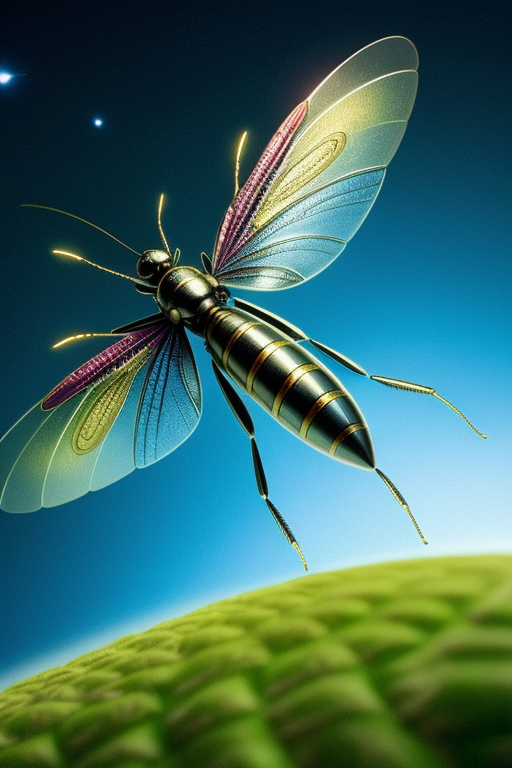

Rendering animation frame 15 of 6300
  creating in between frame 10 tween:0.20
  creating in between frame 11 tween:0.40
  creating in between frame 12 tween:0.60
  creating in between frame 13 tween:0.80
  creating in between frame 14 tween:1.00


INFO:pytorch_lightning.utilities.seed:Global seed set to 1022769798


seed: 1022769798
cond_prompt: pyschedelic astonishing nostalgia lot , super rasping cinematic pre-Socratic a23i0923-11000 fortitude super insectivorous resolution deliberate_defense , ultra antidotal detailed , uhd flaxen
uncond_prompt: streaks, artefacts, bad drawing, incoherent, messy, low resolution, pixelated, nude, nsfw, naked, asian, low quality, multiple, ugly, deformed, crooked teeth, ugly teeth, ugly face, distorted, duplicate, double, multiple, two faces, two heads, fat, chubby, bloated, long neck, disfigured
Scale: 7.5
Sampler: euler_ancestral
Angle: 0.0 Zoom: 1.0261773104019787
Tx: 1.802011198705216 Ty: 0.0 Tz: -1.08
Rx: 0.0 Ry: 0.0782025985597602 Rz: 0.0, Rw: 0.3
noise:  0.03
Strength:  0.7
Contrast:  1.0
Kernel:  5
Sigma:  1.0
Amount:  0.2
Threshold:  0.0
tenc: 22


 55%|█████▍    | 12/22 [00:03<00:02,  3.54it/s]


KeyboardInterrupt: ignored

In [13]:
#@title $ {\large \textsf{Load Settings}}$
from IPython import display
import time
start_time = time.time()
#@markdown **NLTK Random Word Generator, Use This to Spice Up Your Exisiting Prompts!**
use_random_words_nltk = True #@param {type: "boolean"}
if use_random_words_nltk:
    # function to get a random adjective or noun
    def get_random_word(pos):
        synsets = wordnet.all_synsets(pos=pos)
        lemmas = [l for s in synsets for l in s.lemmas()]
        return random.choice(lemmas).name()

    # loop through the dictionary values and add random adjectives and nouns
    for key in cond_prompts:
        tokens = nltk.word_tokenize(cond_prompts[key])
        tagged_tokens = nltk.pos_tag(tokens)
        new_tokens = []
        for token, pos in tagged_tokens:
            new_tokens.append(token)
            if pos.startswith('N'):
                new_token = get_random_word('n')
                new_tokens.append(new_token)
            elif pos.startswith('J'):
                new_token = get_random_word('a')
                new_tokens.append(new_token)
        new_value = ' '.join(new_tokens)
        cond_prompts[key] = new_value

    # print the updated dictionary
    print(cond_prompts)
#@markdown **Deforum Args**
override_settings_with_file = False #@param {type:"boolean"}
settings_file = "custom" #@param ["custom", "512x512_aesthetic_0.json","512x512_aesthetic_1.json","512x512_colormatch_0.json","512x512_colormatch_1.json","512x512_colormatch_2.json","512x512_colormatch_3.json"]
custom_settings_file = "/content/drive/MyDrive/Settings.txt"#@param {type:"string"}

def DeforumArgs():
    #@markdown **Image Settings**
    W = 512 #@param
    H = 768 #@param
    W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64
    bit_depth_output = 8 #@param [8, 16, 32] {type:"raw"}
    render_video_every = 1000 #@param{type: "number"}
    #@markdown **Sampling Settings**
    seed = 1022769795 #@param
    sampler = 'euler_ancestral' #@param ["klms","dpm2","dpm2_ancestral","heun","euler","euler_ancestral","plms", "ddim", "dpm_fast", "dpm_adaptive", "dpmpp_2s_a", "dpmpp_2m"]
    steps = 75 #@param
    scale = 7.5 #@param
    ddim_eta = 0.0 #@param
    dynamic_threshold = None
    static_threshold = None   

    #@markdown **Save & Display Settings**
    save_samples = True #@param {type:"boolean"}
    save_settings = True #@param {type:"boolean"}
    display_samples = True #@param {type:"boolean"}
    save_sample_per_step = False #@param {type:"boolean"}
    show_sample_per_step = False #@param {type:"boolean"}

    #@markdown **Batch Settings**
    n_batch = 1 #@param
    n_samples = 1 #@param
    batch_name = "test" #@param {type:"string"}
    filename_format = "{timestring}_{index}_{prompt}.png" #@param ["{timestring}_{index}_{seed}.png","{timestring}_{index}_{prompt}.png"]
    seed_behavior = "iter" #@param ["iter","fixed","random","ladder","alternate"]
    seed_iter_N = 1 #@param {type:'integer'}
    make_grid = False #@param {type:"boolean"}
    grid_rows = 2 #@param 
    outdir = get_output_folder(root.output_path, batch_name)

    #@markdown **Init Settings**
    use_init = False #@param {type:"boolean"}
    strength = 0.65 #@param {type:"number"}
    strength_0_no_init = True # Set the strength to 0 automatically when no init image is used
    init_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    add_init_noise = True #@param {type:"boolean"}
    init_noise = 0.015 #@param
    # Whiter areas of the mask are areas that change more
    use_mask = False #@param {type:"boolean"}
    use_alpha_as_mask = False # use the alpha channel of the init image as the mask
    mask_file = "https://www.filterforge.com/wiki/images/archive/b/b7/20080927223728%21Polygonal_gradient_thumb.jpg" #@param {type:"string"}
    invert_mask = False #@param {type:"boolean"}
    # Adjust mask image, 1.0 is no adjustment. Should be positive numbers.
    mask_brightness_adjust = 1.0  #@param {type:"number"}
    mask_contrast_adjust = 1.0  #@param {type:"number"}
    # Overlay the masked image at the end of the generation so it does not get degraded by encoding and decoding
    overlay_mask = True  # {type:"boolean"}
    # Blur edges of final overlay mask, if used. Minimum = 0 (no blur)
    mask_overlay_blur = 5 # {type:"number"}

    #@markdown **Exposure/Contrast Conditional Settings**
    mean_scale = 0 #@param {type:"number"}
    var_scale = 0 #@param {type:"number"}
    exposure_scale = 0 #@param {type:"number"}
    exposure_target = 0.5 #@param {type:"number"}

    #@markdown **Color Match Conditional Settings**
    colormatch_scale = 0 #@param {type:"number"}
    colormatch_image = "https://www.saasdesign.io/wp-content/uploads/2021/02/palette-3-min-980x588.png" #@param {type:"string"}
    colormatch_n_colors = 4 #@param {type:"number"}
    ignore_sat_weight = 0 #@param {type:"number"}

    #@markdown **CLIP\Aesthetics Conditional Settings**
    clip_name = 'ViT-L/14' #@param ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']
    clip_scale = 0 #@param {type:"number"}
    aesthetics_scale = 0 #@param {type:"number"}
    cutn = 1 #@param {type:"number"}
    cut_pow = 0.0001 #@param {type:"number"}

    #@markdown **Other Conditional Settings**
    init_mse_scale = 0 #@param {type:"number"}
    init_mse_image = "https://cdn.pixabay.com/photo/2022/07/30/13/10/green-longhorn-beetle-7353749_1280.jpg" #@param {type:"string"}
    blue_scale = 0 #@param {type:"number"}
    
    #@markdown **Conditional Gradient Settings**
    gradient_wrt = 'x0_pred' #@param ["x", "x0_pred"]
    gradient_add_to = 'both' #@param ["cond", "uncond", "both"]
    decode_method = 'linear' #@param ["autoencoder","linear"]
    grad_threshold_type = 'dynamic' #@param ["dynamic", "static", "mean", "schedule"]
    clamp_grad_threshold = 0.2 #@param {type:"number"}
    clamp_start = 0.2 #@param
    clamp_stop = 0.01 #@param
    grad_inject_timing = list(range(1,10)) #@param

    #@markdown **Speed vs VRAM Settings**
    cond_uncond_sync = False #@param {type:"boolean"}
    precision = 'autocast' 
    C = 4
    f = 8

    cond_prompt = ""
    cond_prompts = ""
    uncond_prompt = ""
    uncond_prompts = ""
    timestring = ""
    init_latent = None
    init_sample = None
    init_sample_raw = None
    mask_sample = None
    init_c = None
    seed_internal = 0

    return locals()

args_dict = DeforumArgs()
anim_args_dict = DeforumAnimArgs()

if override_settings_with_file:
    load_args(args_dict, anim_args_dict, settings_file, custom_settings_file, verbose=False)

args = SimpleNamespace(**args_dict)
anim_args = SimpleNamespace(**anim_args_dict)

args.timestring = time.strftime('%Y%m%d%H%M%S')
args.strength = max(0.0, min(1.0, args.strength))

# Load clip model if using clip guidance
if (args.clip_scale > 0) or (args.aesthetics_scale > 0):
    root.clip_model = clip.load(args.clip_name, jit=False)[0].eval().requires_grad_(False).to(root.device)
    if (args.aesthetics_scale > 0):
        root.aesthetics_model = load_aesthetics_model(args, root)

if args.seed == -1:
    args.seed = random.randint(0, 2**32 - 1)
if not args.use_init:
    args.init_image = None
if args.sampler == 'plms' and (args.use_init or anim_args.animation_mode != 'None'):
    print(f"Init images aren't supported with PLMS yet, switching to KLMS")
    args.sampler = 'klms'
if args.sampler != 'ddim':
    args.ddim_eta = 0

if anim_args.animation_mode == 'None':
    anim_args.max_frames = 1
elif anim_args.animation_mode == 'Video Input':
    args.use_init = True

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

with open("Deforum.yaml", "w") as file:
  yaml.dump(DeforumAnimArgs(), file)
  yaml.dump(DeforumArgs(), file)
  yaml.dump(cond_prompts, file)
  yaml.dump(uncond_prompts, file)

# dispatch to appropriate renderer
if anim_args.animation_mode == '2D' or anim_args.animation_mode == '3D':
    render_animation(root, anim_args, args, cond_prompts, uncond_prompts)
elif anim_args.animation_mode == 'Video Input':
    render_input_video(root, anim_args, args, cond_prompts, uncond_prompts)
elif anim_args.animation_mode == 'Interpolation':
    render_interpolation(root, anim_args, args, cond_prompts, uncond_prompts)
else:
    render_image_batch(root, args, anim_args, cond_prompts, uncond_prompts)

print("\033[0;34m..Your Animation Has Completed, Congratulations..")
elapsed_time = time.time() - start_time
print("\033[0;34mElapsed time:", elapsed_time, "seconds")

In [ ]:
remove_outdir = False #@param{type:"boolean"}
if remove_outdir:
  !rm -rf "$args.outdir" --verbose
else:
  print(f"\u001b[33mFiles in The Output Directory: \u001b[36m{args.outdir}\u001b[0m")
  display.display(os.listdir(args.outdir))

In [ ]:
import os
import glob
from tqdm.notebook import tqdm

remove_files_from_range = True #@param{type:"boolean"}
# Set the directory where the files are located
timestring = "20230307065323" #@param{type:"string"}
filenumber_greater_than = 2100 #@param{type:"number"}
# Find all files with names matching the pattern
files = glob.glob(os.path.join(args.outdir, f"{timestring}_0*.png"))

if remove_files_from_range:
# Loop through the files and delete those with numbers greater than 3300
  for file in files:
    number = int(file[-9:-4]) # Extract the number from the filename
    if number > filenumber_greater_than:
      os.remove(file) # Delete the file
        # print(file)

# $ 📼 \color{orange} { \textsf{CREATE VIDEO SEQUENCE FROM FRAMES}}$ 📼


In [ ]:
#@title $ { \textsf{COMPILE FRAMES TO VIDEO(SUBPROCESS--SOMETIMES FASTER)}}$
import time
import subprocess
from IPython import display

start_time = time.time()
#@markdown **This cell will compile ALL images in the folder you provide, so make sure that the folder you specify has the correct images and do not have any unwanted images.**
vid_fps = 30 #@param {type:'number'}
image_ext = '*.png' #@param ['*.png', '*.PNG', '*.jpg', '*.jpeg', '*.JPEG', '*.JPG']
use_args_outdir = True #@param{type:"boolean"}
if use_args_outdir:
    input_path = args.outdir
else: 
    input_path = '/content/drive/MyDrive/sd/stable-diffusion-webui/outputs/img2img-images/cjcjgpj' # @param {type: 'string'}
pix_fmt = 'yuv420p'
#@markdown **The input folder with the frames you want to create a video with.**

raw_vid = '/content/temp.mp4' # @param {type: 'string'}
#@markdown **This `raw_vid` param results in an uncompressed, unformatted video, so to enable compatibility with most video players, we compress it to `compressed_vid`**

compressed_vid = '/content/test.mp4' # @param {type: 'string'}
#@markdown **This `compressed_vid` is now compatible with most video players and should play properly.**
make_gif = False #@param {type:"boolean"}
#@markdown **Please ensure you change the extension of your video to `.gif` if you intend to make gifs**

%cd $input_path

process = subprocess.Popen(['ffmpeg',
                            '-framerate', f"{vid_fps}", 
                            '-pattern_type', 'glob', 
                            '-i', image_ext,
                            '-crf', '17',
                            '-pix_fmt', pix_fmt,
                            '-c:v', 'libx264', 
                            '-b:v', '0',
                            '-preset', 'veryfast', 
                            '-y', raw_vid], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

output, error = process.communicate()

display_ffmpeg_output=True #@param {type:"boolean"}

if display_ffmpeg_output:
  display.display(output)
  display.display(error)

%cd "/content/"
if not make_gif:
  process = subprocess.Popen(['ffmpeg', '-i', raw_vid, '-c:v', 'libx264', '-rc', 'vbr', '-crf', '17', '-pix_fmt', 'yuv420p', '-b:v', '0', '-preset', 'veryfast', '-y', compressed_vid], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

  output, error = process.communicate()

else:

  process = subprocess.Popen(['ffmpeg', '-i', raw_vid, '-r', str(vid_fps), '-y', compressed_vid], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

  output, error = process.communicate()

if display_ffmpeg_output:
  display.display(output)
  display.display(error)

elapsed_time = time.time() - start_time

print("\033[0;34mElapsed time:", elapsed_time, "seconds")

In [ ]:
#@title $ { \textsf{COMPILE FRAMES TO VIDEO(FFMPEG)}}$
import time

start_time = time.time()

#@markdown **This cell will compile ALL images in the folder you provide, so make sure that the folder you specify has the correct images and do not have any unwanted images.**
vid_fps = 30 #@param {type:'number'}
image_ext = "'*.png'" #@param ['*.png', '*.PNG', '*.jpg', '*.jpeg', '*.JPEG', '*.JPG']
input_path = '/content/drive/MyDrive/AI/StableDiffusion/2023-02/NeonMutation_SeventhHell ' # @param {type: 'string'}
#@markdown **The input folder with the frames you want to create a video with.**
raw_vid = '/content/temp.mp4' # @param {type: 'string'}
#@markdown **This `raw_vid` param results in an uncompressed, unformatted video, so to enable compatibility with most video players, we compress it to `compressed_vid`**

compressed_vid = '/content/NeonMutation_SeventhHell.mp4' # @param {type: 'string'}
#@markdown **This `compressed_vid` is now compatible with most video players and should play properly.**

make_gif = False #@param {type:"boolean"}
#@markdown **Please ensure you change the extension of your video to `.gif` if you intend to make gifs**

%cd $input_path

!ffmpeg -framerate $vid_fps \
 -pattern_type glob \
 -i  $image_ext \
 -y $raw_vid

%cd '/content'
if not make_gif:
  !ffmpeg -i $raw_vid \
  -c:v libx264 \
  -rc vbr \
  -cq 19 \
  -pix_fmt yuv420p \
  -b:v 0 \
  -y $compressed_vid

else:
  !ffmpeg \
  -y \
  -i $raw_vid \
  -r $vid_fps \
  $compressed_vid

elapsed_time = time.time() - start_time

print("\033[0;34mElapsed time:", elapsed_time, "seconds")

In [ ]:
#@title $ {\textsf{Display The Video Using kora(may error out, try uninstalling with "pip uninstall kora" if it doesn't work)!}}$
from kora.drive import upload_public
from IPython.display import HTML
url = '/content/test.mp4' #@param{type:'string'}
url = upload_public(url)
# mp4_path = "/content/drive/MyDrive/AI/StableDiffusion/2023-01/kong/20230123004448.mp4"
# mp4 = open(mp4_path,'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# then display it
HTML(f"""<video src={url} width=500 controls/>""")

# 🎮 $\color{orange} {\textsf { CONTROLNET}}$ 🎮

In [ ]:
#@title **ControlNet Inference**
import helpers.controlnet
from helpers.controlnet import load_controlnet, generate_control
from cldm.ddim_hacked import DDIMSampler
from annotator.hed import HEDdetector
from annotator.canny import CannyDetector
from annotator.midas import MidasDetector

def Control():
    load_controlnet_opt = False #@param{type: "boolean"}
    #@markdown **KEEP ENABLED**
    controlnet_model_type = "apply_canny" #@param["apply_hed", "apply_canny", "apply_depth"]
    #@markdown **SELECT WHICH CONTROL NET INFERENCE TO RUN**
    if controlnet_model_type == "apply_canny":
        controlnet_apply_type = CannyDetector()
    elif controlnet_model_type == "apply_hed":
        controlnet_apply_type = HEDdetector()
    else:
        controlnet_apply_type = MidasDetector()
    controlnet_config_path = "/content/deforum-stable-diffusion/ControlNet/models/cldm_v15.yaml" #@param{type: "string"}
    controlnet_model_path = "/content/drive/MyDrive/sd/stable-diffusion-webui/models/Stable-diffusion/control_sd15_hed.pth" #@param{type: "string"}
    #@markdown **YOU MUST DOWNLOAD THE MODELS FIRST, THEN INPUT THE PATH TO THE MODEL**
    IN_dir = "/content/drive/MyDrive/schism" #@param{type: "string"}
    #@markdown **INPUT DIRECTORY, WHACK NAME, WILL CHANGE LATER**
    if not os.path.exists(IN_dir):
        os.makedirs(IN_dir)
    IN_batch = "canny" #@param{type: "string"}
    #@markdown **INPUT THE NAME YOU WISH YOUR BATCH TO BE**
    OUT_dir = "/content/drive/MyDrive/schism_out" #@param{type: "string"}
    #@markdown **INPUT THE FOLDER YOU WISH TO SAVE YOUR IMAGEES TO**
    generate_frames = False #@param{type: "boolean"}
    video_path = "/content/drive/MyDrive/Schism.mp4" #@param {type: "string"}
    #@markdown **INIT VIDEO, `generate_frames` and `video_path` WILL SPLIT THE INIT VIDEO INTO `IN_dir` AND WILL USE THE FRAMES FOR GENERATION.**
    img_idx = 1535 #@param{type: "number"}
    #@markdown **SET `img_idx` TO THE NUMBER YOU WANT TO RESUME FROM**
    # max_frames = len(os.listdir(IN_dir))
    resume_control = True #@param{type: "boolean"}
    #@markdown **ENABLES RESUME FROM `img_idx`**
    prompt = "freaky zombie alien creatures, cyberpunk neon glow, super resolution" #@param{type: "string"}
    a_prompt = "4k, high detail, very detailed, high quality, masterpiece"#@param{type: "string"}
    #@markdown **ADDED PROMPT**
    n_prompt = "low resolution, nsfw, " #@param{type: "string"}
    #@markdown **NEGATIVE PROMPT**
    num_samples = 1 #@param{type: "number"}
    image_resolution = 512 #@param{type: "number"}
    detect_resolution = 512 #@param{type: "number"}
    ddim_steps = 25 #@param{type: "number"}
    guess_mode = False #@param{type: "boolean"}
    strength = 1 #@param {type:"slider", min:0, max:1, step:0.01}
    scale = 9 #@param{type: "number"}
    seed = 1282229256 #@param{type: "number"}
    eta = 0 #@param{type: "number"}
    canny_low_threshold = 100 #@param {type:"slider", min:0, max:255, step:1}
    canny_high_threshold = 200 #@param {type:"slider", min:0, max:255, step:1}
    render_video_every = 30 #@param{type: "number"}
    if load_controlnet_opt:
        model = load_controlnet(controlnet_config_path, controlnet_model_path)
    model = root.model
    ddim_sampler = DDIMSampler(root.model)
    save_memory = False
    return locals()

control = Control()
control = SimpleNamespace(**control)

# clean up unused memory
gc.collect()
torch.cuda.empty_cache()

generate_control(root, control)

# 📈 $\color{orange} {\textsf {TEXTUAL INVERSION TRAINING (WIP)!!! DON'T USE YET}}$ 📈

In [ ]:
#@title $\color{orange} {\large \textsf{Train Textual Inversion!}}$
import torch
create_embedding_file = True #@param{type:'boolean'}
overwrite_old = True #@param{type:"boolean"}
number_of_vectors_per_token = 9 #@param{type:'slider', min:1, max:75, step:1}
initialization_text = "jq24890hw" #@param{type:'string'}
id_task = 0 #@param{type:'number'}
embedding_name = "jq24890hw" #@param{type:'string'}
learn_rate = "0.001:100, 0.00001:1000, 1e-5:10000" #@param 
batch_size = 1 #@param{type:'number'}
gradient_step = 1 #@param{type:'number'}
data_root = "/content/drive/MyDrive/xxpjccrajararaxx" #@param{type:'string'}
log_directory = "/content/drive/MyDrive/textual_inversion_training" #@param{type:'string'}
training_width = 512 #@param{type:'number'}
training_height = 512 #@param{type:'number'}
varsize = True #@param{type:'boolean'}
steps = 10000 #@param{type:'number'}
clip_grad_mode = "disabled" #@param['value', 'norm', 'disabled']
clip_grad_value = 0.1 #@param {type:"slider", min:0.01, max:1, step:0.01}
shuffle_tags = True #@param{type:'boolean'}
tag_drop_out = 0.3 #@param{type:'number'}
latent_sampling_method = "deterministic" #@param['once', 'deterministic', 'random']
create_image_every = 20 #@param{type:'number'}
save_embedding_every = 20 #@param{type:'number'}
template_file = "/content/drive/MyDrive/sd/stable-diffusion-webui/textual_inversion_templates/style.txt" #@param{type:'string'}
template_filename = "/content/drive/MyDrive/sd/stable-diffusion-webui/textual_inversion_templates/style.txt" #@param{type:'string'}
save_image_with_stored_embedding = True #@param{type:'boolean'}
preview_from_txt2img = False #@param{type:'boolean'}
preview_prompt = "" #@param{type:'string'}
preview_negative_prompt = "" #@param{type:'string'}
preview_steps = "" #@param{type:'string'}
preview_sampler_index = "" #@param{type:'string'}
preview_cfg_scale = "" #@param{type:'string'}
preview_seed = "" #@param{type:'string'}
preview_width = "" #@param{type:'string'}
preview_height = "" #@param{type:'string'}
# if create_embedding_file:
create_embedding(name=embedding_name, 
                 num_vectors_per_token=number_of_vectors_per_token, 
                 overwrite_old=overwrite_old)
model_hijack = StableDiffusionModelHijack()
embedding_db = EmbeddingDatabase()
hypernetwork = Hypernetwork()
model_hijack.hijack(model)
model_hijack.embedding_db.load_textual_inversion_embeddings(force_reload=True)
train_embedding(id_task,
                embedding_name,
                learn_rate, 
                batch_size,
                gradient_step,
                data_root,
                log_directory,
                training_width,
                training_height,
                varsize, 
                steps,
                clip_grad_mode,
                clip_grad_value,
                shuffle_tags,
                tag_drop_out,
                latent_sampling_method,
                create_image_every,
                save_embedding_every,
                template_filename,
                save_image_with_stored_embedding,
                preview_from_txt2img,
                preview_prompt,
                preview_negative_prompt,
                preview_steps,
                preview_sampler_index,
                preview_cfg_scale,
                preview_seed,
                preview_width,
                preview_height)

In [ ]:
#@title ddpm
%%writefile /content/deforum-stable-diffusion/src/ldm/models/diffusion/ddpm_hacked.py
"""
wild mixture of
https://github.com/lucidrains/denoising-diffusion-pytorch/blob/7706bdfc6f527f58d33f84b7b522e61e6e3164b3/denoising_diffusion_pytorch/denoising_diffusion_pytorch.py
https://github.com/openai/improved-diffusion/blob/e94489283bb876ac1477d5dd7709bbbd2d9902ce/improved_diffusion/gaussian_diffusion.py
https://github.com/CompVis/taming-transformers
-- merci
"""

import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
from torch.optim.lr_scheduler import LambdaLR
from einops import rearrange, repeat
from contextlib import contextmanager, nullcontext
from functools import partial
import itertools
from tqdm import tqdm
from torchvision.utils import make_grid
from pytorch_lightning.utilities.distributed import rank_zero_only
from omegaconf import ListConfig

from ldm.util import log_txt_as_img, exists, default, ismap, isimage, mean_flat, count_params, instantiate_from_config
from ldm.modules.ema import LitEma
from ldm.modules.distributions.distributions import normal_kl, DiagonalGaussianDistribution
from ldm.models.autoencoder import IdentityFirstStage, AutoencoderKL
from ldm.modules.diffusionmodules.util import make_beta_schedule, extract_into_tensor, noise_like
from ldm.models.diffusion.ddim import DDIMSampler


__conditioning_keys__ = {'concat': 'c_concat',
                         'crossattn': 'c_crossattn',
                         'adm': 'y'}


def disabled_train(self, mode=True):
    """Overwrite model.train with this function to make sure train/eval mode
    does not change anymore."""
    return self


def uniform_on_device(r1, r2, shape, device):
    return (r1 - r2) * torch.rand(*shape, device=device) + r2


class DDPM(pl.LightningModule):
    # classic DDPM with Gaussian diffusion, in image space
    def __init__(self,
                 unet_config,
                 timesteps=1000,
                 beta_schedule="linear",
                 loss_type="l2",
                 ckpt_path=None,
                 ignore_keys=[],
                 load_only_unet=False,
                 monitor="val/loss",
                 use_ema=True,
                 first_stage_key="image",
                 image_size=256,
                 channels=3,
                 log_every_t=100,
                 clip_denoised=True,
                 linear_start=1e-4,
                 linear_end=2e-2,
                 cosine_s=8e-3,
                 given_betas=None,
                 original_elbo_weight=0.,
                 v_posterior=0.,  # weight for choosing posterior variance as sigma = (1-v) * beta_tilde + v * beta
                 l_simple_weight=1.,
                 conditioning_key=None,
                 parameterization="eps",  # all assuming fixed variance schedules
                 scheduler_config=None,
                 use_positional_encodings=False,
                 learn_logvar=False,
                 logvar_init=0.,
                 make_it_fit=False,
                 ucg_training=None,
                 reset_ema=False,
                 reset_num_ema_updates=False,
                 ):
        super().__init__()
        assert parameterization in ["eps", "x0", "v"], 'currently only supporting "eps" and "x0" and "v"'
        self.parameterization = parameterization
        #print(f"{self.__class__.__name__}: Running in {self.parameterization}-prediction mode")
        self.cond_stage_model = None
        self.clip_denoised = clip_denoised
        self.log_every_t = log_every_t
        self.first_stage_key = first_stage_key
        self.image_size = image_size  # try conv?
        self.channels = channels
        self.use_positional_encodings = use_positional_encodings
        self.model = DiffusionWrapper(unet_config, conditioning_key)
        count_params(self.model, verbose=True)
        self.use_ema = use_ema
        if self.use_ema:
            self.model_ema = LitEma(self.model)
            #print(f"Keeping EMAs of {len(list(self.model_ema.buffers()))}.")

        self.use_scheduler = scheduler_config is not None
        if self.use_scheduler:
            self.scheduler_config = scheduler_config

        self.v_posterior = v_posterior
        self.original_elbo_weight = original_elbo_weight
        self.l_simple_weight = l_simple_weight

        if monitor is not None:
            self.monitor = monitor
        self.make_it_fit = make_it_fit
        if reset_ema: assert exists(ckpt_path)
        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys=ignore_keys, only_model=load_only_unet)
            if reset_ema:
                assert self.use_ema
                #print(f"Resetting ema to pure model weights. This is useful when restoring from an ema-only checkpoint.")
                self.model_ema = LitEma(self.model)
        if reset_num_ema_updates:
            print(" +++++++++++ WARNING: RESETTING NUM_EMA UPDATES TO ZERO +++++++++++ ")
            assert self.use_ema
            self.model_ema.reset_num_updates()

        self.register_schedule(given_betas=given_betas, beta_schedule=beta_schedule, timesteps=timesteps,
                               linear_start=linear_start, linear_end=linear_end, cosine_s=cosine_s)

        self.loss_type = loss_type

        self.learn_logvar = learn_logvar
        self.logvar = torch.full(fill_value=logvar_init, size=(self.num_timesteps,))
        if self.learn_logvar:
            self.logvar = nn.Parameter(self.logvar, requires_grad=True)

        self.ucg_training = ucg_training or dict()
        if self.ucg_training:
            self.ucg_prng = np.random.RandomState()

    def register_schedule(self, given_betas=None, beta_schedule="linear", timesteps=1000,
                          linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
        if exists(given_betas):
            betas = given_betas
        else:
            betas = make_beta_schedule(beta_schedule, timesteps, linear_start=linear_start, linear_end=linear_end,
                                       cosine_s=cosine_s)
        alphas = 1. - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1., alphas_cumprod[:-1])

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)
        self.linear_start = linear_start
        self.linear_end = linear_end
        assert alphas_cumprod.shape[0] == self.num_timesteps, 'alphas have to be defined for each timestep'

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer('betas', to_torch(betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod)))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod)))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod)))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod - 1)))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (1 - self.v_posterior) * betas * (1. - alphas_cumprod_prev) / (
                1. - alphas_cumprod) + self.v_posterior * betas
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer('posterior_variance', to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer('posterior_log_variance_clipped', to_torch(np.log(np.maximum(posterior_variance, 1e-20))))
        self.register_buffer('posterior_mean_coef1', to_torch(
            betas * np.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)))
        self.register_buffer('posterior_mean_coef2', to_torch(
            (1. - alphas_cumprod_prev) * np.sqrt(alphas) / (1. - alphas_cumprod)))

        if self.parameterization == "eps":
            lvlb_weights = self.betas ** 2 / (
                    2 * self.posterior_variance * to_torch(alphas) * (1 - self.alphas_cumprod))
        elif self.parameterization == "x0":
            lvlb_weights = 0.5 * np.sqrt(torch.Tensor(alphas_cumprod)) / (2. * 1 - torch.Tensor(alphas_cumprod))
        elif self.parameterization == "v":
            lvlb_weights = torch.ones_like(self.betas ** 2 / (
                    2 * self.posterior_variance * to_torch(alphas) * (1 - self.alphas_cumprod)))
        else:
            raise NotImplementedError("mu not supported")
        lvlb_weights[0] = lvlb_weights[1]
        self.register_buffer('lvlb_weights', lvlb_weights, persistent=False)
        assert not torch.isnan(self.lvlb_weights).all()

    @contextmanager
    def ema_scope(self, context=None):
        if self.use_ema:
            self.model_ema.store(self.model.parameters())
            self.model_ema.copy_to(self.model)
            if context is not None:
                print(f"{context}: Switched to EMA weights")
        try:
            yield None
        finally:
            if self.use_ema:
                self.model_ema.restore(self.model.parameters())
                if context is not None:
                    print(f"{context}: Restored training weights")

    @torch.no_grad()
    def init_from_ckpt(self, path, ignore_keys=list(), only_model=False):
        sd = torch.load(path, map_location="cpu")
        if "state_dict" in list(sd.keys()):
            sd = sd["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]
        if self.make_it_fit:
            n_params = len([name for name, _ in
                            itertools.chain(self.named_parameters(),
                                            self.named_buffers())])
            for name, param in tqdm(
                    itertools.chain(self.named_parameters(),
                                    self.named_buffers()),
                    desc="Fitting old weights to new weights",
                    total=n_params
            ):
                if not name in sd:
                    continue
                old_shape = sd[name].shape
                new_shape = param.shape
                assert len(old_shape) == len(new_shape)
                if len(new_shape) > 2:
                    # we only modify first two axes
                    assert new_shape[2:] == old_shape[2:]
                # assumes first axis corresponds to output dim
                if not new_shape == old_shape:
                    new_param = param.clone()
                    old_param = sd[name]
                    if len(new_shape) == 1:
                        for i in range(new_param.shape[0]):
                            new_param[i] = old_param[i % old_shape[0]]
                    elif len(new_shape) >= 2:
                        for i in range(new_param.shape[0]):
                            for j in range(new_param.shape[1]):
                                new_param[i, j] = old_param[i % old_shape[0], j % old_shape[1]]

                        n_used_old = torch.ones(old_shape[1])
                        for j in range(new_param.shape[1]):
                            n_used_old[j % old_shape[1]] += 1
                        n_used_new = torch.zeros(new_shape[1])
                        for j in range(new_param.shape[1]):
                            n_used_new[j] = n_used_old[j % old_shape[1]]

                        n_used_new = n_used_new[None, :]
                        while len(n_used_new.shape) < len(new_shape):
                            n_used_new = n_used_new.unsqueeze(-1)
                        new_param /= n_used_new

                    sd[name] = new_param

        missing, unexpected = self.load_state_dict(sd, strict=False) if not only_model else self.model.load_state_dict(
            sd, strict=False)
        print(f"Restored from {path} with {len(missing)} missing and {len(unexpected)} unexpected keys")
        if len(missing) > 0:
            print(f"Missing Keys:\n {missing}")
        if len(unexpected) > 0:
            print(f"\nUnexpected Keys:\n {unexpected}")

    def q_mean_variance(self, x_start, t):
        """
        Get the distribution q(x_t | x_0).
        :param x_start: the [N x C x ...] tensor of noiseless inputs.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :return: A tuple (mean, variance, log_variance), all of x_start's shape.
        """
        mean = (extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start)
        variance = extract_into_tensor(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract_into_tensor(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
                extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
                extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def predict_start_from_z_and_v(self, x_t, t, v):
        # self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod)))
        # self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod)))
        return (
                extract_into_tensor(self.sqrt_alphas_cumprod, t, x_t.shape) * x_t -
                extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * v
        )

    def predict_eps_from_z_and_v(self, x_t, t, v):
        return (
                extract_into_tensor(self.sqrt_alphas_cumprod, t, x_t.shape) * v +
                extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape) * x_t
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
                extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start +
                extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract_into_tensor(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, clip_denoised: bool):
        model_out = self.model(x, t)
        if self.parameterization == "eps":
            x_recon = self.predict_start_from_noise(x, t=t, noise=model_out)
        elif self.parameterization == "x0":
            x_recon = model_out
        if clip_denoised:
            x_recon.clamp_(-1., 1.)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, t, clip_denoised=True, repeat_noise=False):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.p_mean_variance(x=x, t=t, clip_denoised=clip_denoised)
        noise = noise_like(x.shape, device, repeat_noise)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, shape, return_intermediates=False):
        device = self.betas.device
        b = shape[0]
        img = torch.randn(shape, device=device)
        intermediates = [img]
        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='Sampling t', total=self.num_timesteps):
            img = self.p_sample(img, torch.full((b,), i, device=device, dtype=torch.long),
                                clip_denoised=self.clip_denoised)
            if i % self.log_every_t == 0 or i == self.num_timesteps - 1:
                intermediates.append(img)
        if return_intermediates:
            return img, intermediates
        return img

    @torch.no_grad()
    def sample(self, batch_size=16, return_intermediates=False):
        image_size = self.image_size
        channels = self.channels
        return self.p_sample_loop((batch_size, channels, image_size, image_size),
                                  return_intermediates=return_intermediates)

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        return (extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
                extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise)

    def get_v(self, x, noise, t):
        return (
                extract_into_tensor(self.sqrt_alphas_cumprod, t, x.shape) * noise -
                extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x.shape) * x
        )

    def get_loss(self, pred, target, mean=True):
        if self.loss_type == 'l1':
            loss = (target - pred).abs()
            if mean:
                loss = loss.mean()
        elif self.loss_type == 'l2':
            if mean:
                loss = torch.nn.functional.mse_loss(target, pred)
            else:
                loss = torch.nn.functional.mse_loss(target, pred, reduction='none')
        else:
            raise NotImplementedError("unknown loss type '{loss_type}'")

        return loss

    def p_losses(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        model_out = self.model(x_noisy, t)

        loss_dict = {}
        if self.parameterization == "eps":
            target = noise
        elif self.parameterization == "x0":
            target = x_start
        elif self.parameterization == "v":
            target = self.get_v(x_start, noise, t)
        else:
            raise NotImplementedError(f"Parameterization {self.parameterization} not yet supported")

        loss = self.get_loss(model_out, target, mean=False).mean(dim=[1, 2, 3])

        log_prefix = 'train' if self.training else 'val'

        loss_dict.update({f'{log_prefix}/loss_simple': loss.mean()})
        loss_simple = loss.mean() * self.l_simple_weight

        loss_vlb = (self.lvlb_weights[t] * loss).mean()
        loss_dict.update({f'{log_prefix}/loss_vlb': loss_vlb})

        loss = loss_simple + self.original_elbo_weight * loss_vlb

        loss_dict.update({f'{log_prefix}/loss': loss})

        return loss, loss_dict

    def forward(self, x, *args, **kwargs):
        # b, c, h, w, device, img_size, = *x.shape, x.device, self.image_size
        # assert h == img_size and w == img_size, f'height and width of image must be {img_size}'
        t = torch.randint(0, self.num_timesteps, (x.shape[0],), device=self.device).long()
        return self.p_losses(x, t, *args, **kwargs)

    def get_input(self, batch, k):
        x = batch[k]
        if len(x.shape) == 3:
            x = x[..., None]
        x = rearrange(x, 'b h w c -> b c h w')
        x = x.to(memory_format=torch.contiguous_format).float()
        return x

    def shared_step(self, batch):
        x = self.get_input(batch, self.first_stage_key)
        loss, loss_dict = self(x)
        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        for k in self.ucg_training:
            p = self.ucg_training[k]["p"]
            val = self.ucg_training[k]["val"]
            if val is None:
                val = ""
            for i in range(len(batch[k])):
                if self.ucg_prng.choice(2, p=[1 - p, p]):
                    batch[k][i] = val

        loss, loss_dict = self.shared_step(batch)

        self.log_dict(loss_dict, prog_bar=True,
                      logger=True, on_step=True, on_epoch=True)

        self.log("global_step", self.global_step,
                 prog_bar=True, logger=True, on_step=True, on_epoch=False)

        if self.use_scheduler:
            lr = self.optimizers().param_groups[0]['lr']
            self.log('lr_abs', lr, prog_bar=True, logger=True, on_step=True, on_epoch=False)

        return loss

    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        _, loss_dict_no_ema = self.shared_step(batch)
        with self.ema_scope():
            _, loss_dict_ema = self.shared_step(batch)
            loss_dict_ema = {key + '_ema': loss_dict_ema[key] for key in loss_dict_ema}
        self.log_dict(loss_dict_no_ema, prog_bar=False, logger=True, on_step=False, on_epoch=True)
        self.log_dict(loss_dict_ema, prog_bar=False, logger=True, on_step=False, on_epoch=True)

    def on_train_batch_end(self, *args, **kwargs):
        if self.use_ema:
            self.model_ema(self.model)

    def _get_rows_from_list(self, samples):
        n_imgs_per_row = len(samples)
        denoise_grid = rearrange(samples, 'n b c h w -> b n c h w')
        denoise_grid = rearrange(denoise_grid, 'b n c h w -> (b n) c h w')
        denoise_grid = make_grid(denoise_grid, nrow=n_imgs_per_row)
        return denoise_grid

    @torch.no_grad()
    def log_images(self, batch, N=8, n_row=2, sample=True, return_keys=None, **kwargs):
        log = dict()
        x = self.get_input(batch, self.first_stage_key)
        N = min(x.shape[0], N)
        n_row = min(x.shape[0], n_row)
        x = x.to(self.device)[:N]
        log["inputs"] = x

        # get diffusion row
        diffusion_row = list()
        x_start = x[:n_row]

        for t in range(self.num_timesteps):
            if t % self.log_every_t == 0 or t == self.num_timesteps - 1:
                t = repeat(torch.tensor([t]), '1 -> b', b=n_row)
                t = t.to(self.device).long()
                noise = torch.randn_like(x_start)
                x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
                diffusion_row.append(x_noisy)

        log["diffusion_row"] = self._get_rows_from_list(diffusion_row)

        if sample:
            # get denoise row
            with self.ema_scope("Plotting"):
                samples, denoise_row = self.sample(batch_size=N, return_intermediates=True)

            log["samples"] = samples
            log["denoise_row"] = self._get_rows_from_list(denoise_row)

        if return_keys:
            if np.intersect1d(list(log.keys()), return_keys).shape[0] == 0:
                return log
            else:
                return {key: log[key] for key in return_keys}
        return log

    def configure_optimizers(self):
        lr = self.learning_rate
        params = list(self.model.parameters())
        if self.learn_logvar:
            params = params + [self.logvar]
        opt = torch.optim.AdamW(params, lr=lr)
        return opt


class LatentDiffusion(DDPM):
    """main class"""

    def __init__(self,
                 first_stage_config,
                 cond_stage_config,
                 num_timesteps_cond=None,
                 cond_stage_key="image",
                 cond_stage_trainable=False,
                 concat_mode=True,
                 cond_stage_forward=None,
                 conditioning_key=None,
                 scale_factor=1.0,
                 scale_by_std=False,
                 force_null_conditioning=False,
                 *args, **kwargs):
        self.force_null_conditioning = force_null_conditioning
        self.num_timesteps_cond = default(num_timesteps_cond, 1)
        self.scale_by_std = scale_by_std
        assert self.num_timesteps_cond <= kwargs['timesteps']
        # for backwards compatibility after implementation of DiffusionWrapper
        if conditioning_key is None:
            conditioning_key = 'concat' if concat_mode else 'crossattn'
        if cond_stage_config == '__is_unconditional__' and not self.force_null_conditioning:
            conditioning_key = None
        ckpt_path = kwargs.pop("ckpt_path", None)
        reset_ema = kwargs.pop("reset_ema", False)
        reset_num_ema_updates = kwargs.pop("reset_num_ema_updates", False)
        ignore_keys = kwargs.pop("ignore_keys", [])
        super().__init__(conditioning_key=conditioning_key, *args, **kwargs)
        self.concat_mode = concat_mode
        self.cond_stage_trainable = cond_stage_trainable
        self.cond_stage_key = cond_stage_key
        try:
            self.num_downs = len(first_stage_config.params.ddconfig.ch_mult) - 1
        except:
            self.num_downs = 0
        if not scale_by_std:
            self.scale_factor = scale_factor
        else:
            self.register_buffer('scale_factor', torch.tensor(scale_factor))
        self.instantiate_first_stage(first_stage_config)
        self.instantiate_cond_stage(cond_stage_config)
        self.cond_stage_forward = cond_stage_forward
        self.clip_denoised = False
        self.bbox_tokenizer = None

        self.restarted_from_ckpt = False
        if ckpt_path is not None:
            self.init_from_ckpt(ckpt_path, ignore_keys)
            self.restarted_from_ckpt = True
            if reset_ema:
                assert self.use_ema
                print(
                    f"Resetting ema to pure model weights. This is useful when restoring from an ema-only checkpoint.")
                self.model_ema = LitEma(self.model)
        if reset_num_ema_updates:
            print(" +++++++++++ WARNING: RESETTING NUM_EMA UPDATES TO ZERO +++++++++++ ")
            assert self.use_ema
            self.model_ema.reset_num_updates()

    def make_cond_schedule(self, ):
        self.cond_ids = torch.full(size=(self.num_timesteps,), fill_value=self.num_timesteps - 1, dtype=torch.long)
        ids = torch.round(torch.linspace(0, self.num_timesteps - 1, self.num_timesteps_cond)).long()
        self.cond_ids[:self.num_timesteps_cond] = ids

    @rank_zero_only
    @torch.no_grad()
    def on_train_batch_start(self, batch, batch_idx, dataloader_idx):
        # only for very first batch
        if self.scale_by_std and self.current_epoch == 0 and self.global_step == 0 and batch_idx == 0 and not self.restarted_from_ckpt:
            assert self.scale_factor == 1., 'rather not use custom rescaling and std-rescaling simultaneously'
            # set rescale weight to 1./std of encodings
            print("### USING STD-RESCALING ###")
            x = super().get_input(batch, self.first_stage_key)
            x = x.to(self.device)
            encoder_posterior = self.encode_first_stage(x)
            z = self.get_first_stage_encoding(encoder_posterior).detach()
            del self.scale_factor
            self.register_buffer('scale_factor', 1. / z.flatten().std())
            print(f"setting self.scale_factor to {self.scale_factor}")
            print("### USING STD-RESCALING ###")

    def register_schedule(self,
                          given_betas=None, beta_schedule="linear", timesteps=1000,
                          linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3):
        super().register_schedule(given_betas, beta_schedule, timesteps, linear_start, linear_end, cosine_s)

        self.shorten_cond_schedule = self.num_timesteps_cond > 1
        if self.shorten_cond_schedule:
            self.make_cond_schedule()

    def instantiate_first_stage(self, config):
        model = instantiate_from_config(config)
        self.first_stage_model = model.eval()
        self.first_stage_model.train = disabled_train
        for param in self.first_stage_model.parameters():
            param.requires_grad = False

    def instantiate_cond_stage(self, config):
        if not self.cond_stage_trainable:
            if config == "__is_first_stage__":
                print("Using first stage also as cond stage.")
                self.cond_stage_model = self.first_stage_model
            elif config == "__is_unconditional__":
                print(f"Training {self.__class__.__name__} as an unconditional model.")
                self.cond_stage_model = None
                # self.be_unconditional = True
            else:
                model = instantiate_from_config(config)
                self.cond_stage_model = model.eval()
                self.cond_stage_model.train = disabled_train
                for param in self.cond_stage_model.parameters():
                    param.requires_grad = False
        else:
            assert config != '__is_first_stage__'
            assert config != '__is_unconditional__'
            model = instantiate_from_config(config)
            self.cond_stage_model = model

    def _get_denoise_row_from_list(self, samples, desc='', force_no_decoder_quantization=False):
        denoise_row = []
        for zd in tqdm(samples, desc=desc):
            denoise_row.append(self.decode_first_stage(zd.to(self.device),
                                                       force_not_quantize=force_no_decoder_quantization))
        n_imgs_per_row = len(denoise_row)
        denoise_row = torch.stack(denoise_row)  # n_log_step, n_row, C, H, W
        denoise_grid = rearrange(denoise_row, 'n b c h w -> b n c h w')
        denoise_grid = rearrange(denoise_grid, 'b n c h w -> (b n) c h w')
        denoise_grid = make_grid(denoise_grid, nrow=n_imgs_per_row)
        return denoise_grid

    def get_first_stage_encoding(self, encoder_posterior):
        if isinstance(encoder_posterior, DiagonalGaussianDistribution):
            z = encoder_posterior.sample()
        elif isinstance(encoder_posterior, torch.Tensor):
            z = encoder_posterior
        else:
            raise NotImplementedError(f"encoder_posterior of type '{type(encoder_posterior)}' not yet implemented")
        return self.scale_factor * z

    def get_learned_conditioning(self, c):
        if self.cond_stage_forward is None:
            if hasattr(self.cond_stage_model, 'encode') and callable(self.cond_stage_model.encode):
                c = self.cond_stage_model.encode(c)
                if isinstance(c, DiagonalGaussianDistribution):
                    c = c.mode()
            else:
                c = self.cond_stage_model(c)
        else:
            assert hasattr(self.cond_stage_model, self.cond_stage_forward)
            c = getattr(self.cond_stage_model, self.cond_stage_forward)(c)
        return c

    def meshgrid(self, h, w):
        y = torch.arange(0, h).view(h, 1, 1).repeat(1, w, 1)
        x = torch.arange(0, w).view(1, w, 1).repeat(h, 1, 1)

        arr = torch.cat([y, x], dim=-1)
        return arr

    def delta_border(self, h, w):
        """
        :param h: height
        :param w: width
        :return: normalized distance to image border,
         wtith min distance = 0 at border and max dist = 0.5 at image center
        """
        lower_right_corner = torch.tensor([h - 1, w - 1]).view(1, 1, 2)
        arr = self.meshgrid(h, w) / lower_right_corner
        dist_left_up = torch.min(arr, dim=-1, keepdims=True)[0]
        dist_right_down = torch.min(1 - arr, dim=-1, keepdims=True)[0]
        edge_dist = torch.min(torch.cat([dist_left_up, dist_right_down], dim=-1), dim=-1)[0]
        return edge_dist

    def get_weighting(self, h, w, Ly, Lx, device):
        weighting = self.delta_border(h, w)
        weighting = torch.clip(weighting, self.split_input_params["clip_min_weight"],
                               self.split_input_params["clip_max_weight"], )
        weighting = weighting.view(1, h * w, 1).repeat(1, 1, Ly * Lx).to(device)

        if self.split_input_params["tie_braker"]:
            L_weighting = self.delta_border(Ly, Lx)
            L_weighting = torch.clip(L_weighting,
                                     self.split_input_params["clip_min_tie_weight"],
                                     self.split_input_params["clip_max_tie_weight"])

            L_weighting = L_weighting.view(1, 1, Ly * Lx).to(device)
            weighting = weighting * L_weighting
        return weighting

    def get_fold_unfold(self, x, kernel_size, stride, uf=1, df=1):  # todo load once not every time, shorten code
        """
        :param x: img of size (bs, c, h, w)
        :return: n img crops of size (n, bs, c, kernel_size[0], kernel_size[1])
        """
        bs, nc, h, w = x.shape

        # number of crops in image
        Ly = (h - kernel_size[0]) // stride[0] + 1
        Lx = (w - kernel_size[1]) // stride[1] + 1

        if uf == 1 and df == 1:
            fold_params = dict(kernel_size=kernel_size, dilation=1, padding=0, stride=stride)
            unfold = torch.nn.Unfold(**fold_params)

            fold = torch.nn.Fold(output_size=x.shape[2:], **fold_params)

            weighting = self.get_weighting(kernel_size[0], kernel_size[1], Ly, Lx, x.device).to(x.dtype)
            normalization = fold(weighting).view(1, 1, h, w)  # normalizes the overlap
            weighting = weighting.view((1, 1, kernel_size[0], kernel_size[1], Ly * Lx))

        elif uf > 1 and df == 1:
            fold_params = dict(kernel_size=kernel_size, dilation=1, padding=0, stride=stride)
            unfold = torch.nn.Unfold(**fold_params)

            fold_params2 = dict(kernel_size=(kernel_size[0] * uf, kernel_size[0] * uf),
                                dilation=1, padding=0,
                                stride=(stride[0] * uf, stride[1] * uf))
            fold = torch.nn.Fold(output_size=(x.shape[2] * uf, x.shape[3] * uf), **fold_params2)

            weighting = self.get_weighting(kernel_size[0] * uf, kernel_size[1] * uf, Ly, Lx, x.device).to(x.dtype)
            normalization = fold(weighting).view(1, 1, h * uf, w * uf)  # normalizes the overlap
            weighting = weighting.view((1, 1, kernel_size[0] * uf, kernel_size[1] * uf, Ly * Lx))

        elif df > 1 and uf == 1:
            fold_params = dict(kernel_size=kernel_size, dilation=1, padding=0, stride=stride)
            unfold = torch.nn.Unfold(**fold_params)

            fold_params2 = dict(kernel_size=(kernel_size[0] // df, kernel_size[0] // df),
                                dilation=1, padding=0,
                                stride=(stride[0] // df, stride[1] // df))
            fold = torch.nn.Fold(output_size=(x.shape[2] // df, x.shape[3] // df), **fold_params2)

            weighting = self.get_weighting(kernel_size[0] // df, kernel_size[1] // df, Ly, Lx, x.device).to(x.dtype)
            normalization = fold(weighting).view(1, 1, h // df, w // df)  # normalizes the overlap
            weighting = weighting.view((1, 1, kernel_size[0] // df, kernel_size[1] // df, Ly * Lx))

        else:
            raise NotImplementedError

        return fold, unfold, normalization, weighting

    @torch.no_grad()
    def get_input(self, batch, k, return_first_stage_outputs=False, force_c_encode=False,
                  cond_key=None, return_original_cond=False, bs=None, return_x=False):
        x = super().get_input(batch, k)
        if bs is not None:
            x = x[:bs]
        x = x.to(self.device)
        encoder_posterior = self.encode_first_stage(x)
        z = self.get_first_stage_encoding(encoder_posterior).detach()

        if self.model.conditioning_key is not None and not self.force_null_conditioning:
            if cond_key is None:
                cond_key = self.cond_stage_key
            if cond_key != self.first_stage_key:
                if cond_key in ['caption', 'coordinates_bbox', "txt"]:
                    xc = batch[cond_key]
                elif cond_key in ['class_label', 'cls']:
                    xc = batch
                else:
                    xc = super().get_input(batch, cond_key).to(self.device)
            else:
                xc = x
            if not self.cond_stage_trainable or force_c_encode:
                if isinstance(xc, dict) or isinstance(xc, list):
                    c = self.get_learned_conditioning(xc)
                else:
                    c = self.get_learned_conditioning(xc.to(self.device))
            else:
                c = xc
            if bs is not None:
                c = c[:bs]

            if self.use_positional_encodings:
                pos_x, pos_y = self.compute_latent_shifts(batch)
                ckey = __conditioning_keys__[self.model.conditioning_key]
                c = {ckey: c, 'pos_x': pos_x, 'pos_y': pos_y}

        else:
            c = None
            xc = None
            if self.use_positional_encodings:
                pos_x, pos_y = self.compute_latent_shifts(batch)
                c = {'pos_x': pos_x, 'pos_y': pos_y}
        out = [z, c]
        if return_first_stage_outputs:
            xrec = self.decode_first_stage(z)
            out.extend([x, xrec])
        if return_x:
            out.extend([x])
        if return_original_cond:
            out.append(xc)
        return out

    @torch.no_grad()
    def decode_first_stage(self, z, predict_cids=False, force_not_quantize=False):
        if predict_cids:
            if z.dim() == 4:
                z = torch.argmax(z.exp(), dim=1).long()
            z = self.first_stage_model.quantize.get_codebook_entry(z, shape=None)
            z = rearrange(z, 'b h w c -> b c h w').contiguous()

        z = 1. / self.scale_factor * z
        return self.first_stage_model.decode(z)

    @torch.no_grad()
    def encode_first_stage(self, x):
        return self.first_stage_model.encode(x)

    def shared_step(self, batch, **kwargs):
        x, c = self.get_input(batch, self.first_stage_key)
        loss = self(x, c)
        return loss

    def forward(self, x, c, *args, **kwargs):
        x.to('cuda')
        c.to('cuda')
        t = torch.randint(0, self.num_timesteps, (x.shape[0],), device='cuda').long()
        t.to('cuda')
        if self.model.conditioning_key is not None:
            assert c is not None
            if self.cond_stage_trainable:
                c = self.get_learned_conditioning(c)
            if self.shorten_cond_schedule:  # TODO: drop this option
                tc = self.cond_ids[t].to(self.device)
                c = self.q_sample(x_start=c, t=tc, noise=torch.randn_like(c.float()))
        return self.p_losses(x, c, t, *args, **kwargs)

    def apply_model(self, x_noisy, t, cond, return_ids=False):
        if isinstance(cond, dict):
            # hybrid case, cond is expected to be a dict
            pass
        else:
            if not isinstance(cond, list):
                cond = [cond]
            key = 'c_concat' if self.model.conditioning_key == 'concat' else 'c_crossattn'
            cond = {key: cond}

        x_recon = self.model(x_noisy, t, **cond)

        if isinstance(x_recon, tuple) and not return_ids:
            return x_recon[0]
        else:
            return x_recon

    def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
        return (extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - pred_xstart) / \
               extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

    def _prior_bpd(self, x_start):
        """
        Get the prior KL term for the variational lower-bound, measured in
        bits-per-dim.
        This term can't be optimized, as it only depends on the encoder.
        :param x_start: the [N x C x ...] tensor of inputs.
        :return: a batch of [N] KL values (in bits), one per batch element.
        """
        batch_size = x_start.shape[0]
        t = torch.tensor([self.num_timesteps - 1] * batch_size, device=x_start.device)
        qt_mean, _, qt_log_variance = self.q_mean_variance(x_start, t)
        kl_prior = normal_kl(mean1=qt_mean, logvar1=qt_log_variance, mean2=0.0, logvar2=0.0)
        return mean_flat(kl_prior) / np.log(2.0)

    def p_losses(self, x_start, cond, t, noise=None):
        cond.to('cuda')
        x_start.to('cuda')
        t.to('cuda')
        noise = default(noise, lambda: torch.randn_like(x_start))
        noise.to('cuda')
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        model_output = self.apply_model(x_noisy, t, cond)

        loss_dict = {}
        prefix = 'train' if self.training else 'val'

        # if self.parameterization == "x0":
        #     target = x_start
        # elif self.parameterization == "eps":
        #     target = noise
        # # elif self.parameterization == "v":
        # #     self.get_v = self.get_v.to('cuda')
        # #     target = self.get_v(x_start, noise, t)
        # else:
        #     raise NotImplementedError()
        target = x_start
        loss_simple = self.get_loss(model_output, target, mean=False).mean([1, 2, 3])
        loss_dict.update({f'{prefix}/loss_simple': loss_simple.mean()})
        logvar = self.logvar.to('cuda')
        self.logvar = self.logvar.to('cuda')
        self.logvar[t] = self.logvar[t].to('cuda')
        logvar_t = self.logvar[t].to(self.device)
        loss = loss_simple / torch.exp(logvar_t) + logvar_t
        # loss = loss_simple / torch.exp(self.logvar) + self.logvar
        if self.learn_logvar:
            loss_dict.update({f'{prefix}/loss_gamma': loss.mean()})
            loss_dict.update({'logvar': self.logvar.data.mean()})

        loss = self.l_simple_weight * loss.mean()

        loss_vlb = self.get_loss(model_output, target, mean=False).mean(dim=(1, 2, 3))
        loss_vlb = (self.lvlb_weights[t] * loss_vlb).mean()
        loss_dict.update({f'{prefix}/loss_vlb': loss_vlb})
        loss += (self.original_elbo_weight * loss_vlb)
        loss_dict.update({f'{prefix}/loss': loss})

        return loss, loss_dict

    def p_mean_variance(self, x, c, t, clip_denoised: bool, return_codebook_ids=False, quantize_denoised=False,
                        return_x0=False, score_corrector=None, corrector_kwargs=None):
        t_in = t
        model_out = self.apply_model(x, t_in, c, return_ids=return_codebook_ids)

        if score_corrector is not None:
            assert self.parameterization == "eps"
            model_out = score_corrector.modify_score(self, model_out, x, t, c, **corrector_kwargs)

        if return_codebook_ids:
            model_out, logits = model_out

        if self.parameterization == "eps":
            x_recon = self.predict_start_from_noise(x, t=t, noise=model_out)
        elif self.parameterization == "x0":
            x_recon = model_out
        else:
            raise NotImplementedError()

        if clip_denoised:
            x_recon.clamp_(-1., 1.)
        if quantize_denoised:
            x_recon, _, [_, _, indices] = self.first_stage_model.quantize(x_recon)
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        if return_codebook_ids:
            return model_mean, posterior_variance, posterior_log_variance, logits
        elif return_x0:
            return model_mean, posterior_variance, posterior_log_variance, x_recon
        else:
            return model_mean, posterior_variance, posterior_log_variance

    @torch.no_grad()
    def p_sample(self, x, c, t, clip_denoised=False, repeat_noise=False,
                 return_codebook_ids=False, quantize_denoised=False, return_x0=False,
                 temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None):
        b, *_, device = *x.shape, x.device
        outputs = self.p_mean_variance(x=x, c=c, t=t, clip_denoised=clip_denoised,
                                       return_codebook_ids=return_codebook_ids,
                                       quantize_denoised=quantize_denoised,
                                       return_x0=return_x0,
                                       score_corrector=score_corrector, corrector_kwargs=corrector_kwargs)
        if return_codebook_ids:
            raise DeprecationWarning("Support dropped.")
            model_mean, _, model_log_variance, logits = outputs
        elif return_x0:
            model_mean, _, model_log_variance, x0 = outputs
        else:
            model_mean, _, model_log_variance = outputs

        noise = noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))

        if return_codebook_ids:
            return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise, logits.argmax(dim=1)
        if return_x0:
            return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise, x0
        else:
            return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def progressive_denoising(self, cond, shape, verbose=True, callback=None, quantize_denoised=False,
                              img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                              score_corrector=None, corrector_kwargs=None, batch_size=None, x_T=None, start_T=None,
                              log_every_t=None):
        if not log_every_t:
            log_every_t = self.log_every_t
        timesteps = self.num_timesteps
        if batch_size is not None:
            b = batch_size if batch_size is not None else shape[0]
            shape = [batch_size] + list(shape)
        else:
            b = batch_size = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=self.device)
        else:
            img = x_T
        intermediates = []
        if cond is not None:
            if isinstance(cond, dict):
                cond = {key: cond[key][:batch_size] if not isinstance(cond[key], list) else
                list(map(lambda x: x[:batch_size], cond[key])) for key in cond}
            else:
                cond = [c[:batch_size] for c in cond] if isinstance(cond, list) else cond[:batch_size]

        if start_T is not None:
            timesteps = min(timesteps, start_T)
        iterator = tqdm(reversed(range(0, timesteps)), desc='Progressive Generation',
                        total=timesteps) if verbose else reversed(
            range(0, timesteps))
        if type(temperature) == float:
            temperature = [temperature] * timesteps

        for i in iterator:
            ts = torch.full((b,), i, device=self.device, dtype=torch.long)
            if self.shorten_cond_schedule:
                assert self.model.conditioning_key != 'hybrid'
                tc = self.cond_ids[ts].to(cond.device)
                cond = self.q_sample(x_start=cond, t=tc, noise=torch.randn_like(cond))

            img, x0_partial = self.p_sample(img, cond, ts,
                                            clip_denoised=self.clip_denoised,
                                            quantize_denoised=quantize_denoised, return_x0=True,
                                            temperature=temperature[i], noise_dropout=noise_dropout,
                                            score_corrector=score_corrector, corrector_kwargs=corrector_kwargs)
            if mask is not None:
                assert x0 is not None
                img_orig = self.q_sample(x0, ts)
                img = img_orig * mask + (1. - mask) * img

            if i % log_every_t == 0 or i == timesteps - 1:
                intermediates.append(x0_partial)
            if callback: callback(i)
            if img_callback: img_callback(img, i)
        return img, intermediates

    @torch.no_grad()
    def p_sample_loop(self, cond, shape, return_intermediates=False,
                      x_T=None, verbose=True, callback=None, timesteps=None, quantize_denoised=False,
                      mask=None, x0=None, img_callback=None, start_T=None,
                      log_every_t=None):

        if not log_every_t:
            log_every_t = self.log_every_t
        device = self.betas.device
        b = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=device)
        else:
            img = x_T

        intermediates = [img]
        if timesteps is None:
            timesteps = self.num_timesteps

        if start_T is not None:
            timesteps = min(timesteps, start_T)
        iterator = tqdm(reversed(range(0, timesteps)), desc='Sampling t', total=timesteps) if verbose else reversed(
            range(0, timesteps))

        if mask is not None:
            assert x0 is not None
            assert x0.shape[2:3] == mask.shape[2:3]  # spatial size has to match

        for i in iterator:
            ts = torch.full((b,), i, device=device, dtype=torch.long)
            if self.shorten_cond_schedule:
                assert self.model.conditioning_key != 'hybrid'
                tc = self.cond_ids[ts].to(cond.device)
                cond = self.q_sample(x_start=cond, t=tc, noise=torch.randn_like(cond))

            img = self.p_sample(img, cond, ts,
                                clip_denoised=self.clip_denoised,
                                quantize_denoised=quantize_denoised)
            if mask is not None:
                img_orig = self.q_sample(x0, ts)
                img = img_orig * mask + (1. - mask) * img

            if i % log_every_t == 0 or i == timesteps - 1:
                intermediates.append(img)
            if callback: callback(i)
            if img_callback: img_callback(img, i)

        if return_intermediates:
            return img, intermediates
        return img

    @torch.no_grad()
    def sample(self, cond, batch_size=16, return_intermediates=False, x_T=None,
               verbose=True, timesteps=None, quantize_denoised=False,
               mask=None, x0=None, shape=None, **kwargs):
        if shape is None:
            shape = (batch_size, self.channels, self.image_size, self.image_size)
        if cond is not None:
            if isinstance(cond, dict):
                cond = {key: cond[key][:batch_size] if not isinstance(cond[key], list) else
                list(map(lambda x: x[:batch_size], cond[key])) for key in cond}
            else:
                cond = [c[:batch_size] for c in cond] if isinstance(cond, list) else cond[:batch_size]
        return self.p_sample_loop(cond,
                                  shape,
                                  return_intermediates=return_intermediates, x_T=x_T,
                                  verbose=verbose, timesteps=timesteps, quantize_denoised=quantize_denoised,
                                  mask=mask, x0=x0)

    @torch.no_grad()
    def sample_log(self, cond, batch_size, ddim, ddim_steps, **kwargs):
        if ddim:
            ddim_sampler = DDIMSampler(self)
            shape = (self.channels, self.image_size, self.image_size)
            samples, intermediates = ddim_sampler.sample(ddim_steps, batch_size,
                                                         shape, cond, verbose=False, **kwargs)

        else:
            samples, intermediates = self.sample(cond=cond, batch_size=batch_size,
                                                 return_intermediates=True, **kwargs)

        return samples, intermediates

    @torch.no_grad()
    def get_unconditional_conditioning(self, batch_size, null_label=None):
        if null_label is not None:
            xc = null_label
            if isinstance(xc, ListConfig):
                xc = list(xc)
            if isinstance(xc, dict) or isinstance(xc, list):
                c = self.get_learned_conditioning(xc)
            else:
                if hasattr(xc, "to"):
                    xc = xc.to(self.device)
                c = self.get_learned_conditioning(xc)
        else:
            if self.cond_stage_key in ["class_label", "cls"]:
                xc = self.cond_stage_model.get_unconditional_conditioning(batch_size, device=self.device)
                return self.get_learned_conditioning(xc)
            else:
                raise NotImplementedError("todo")
        if isinstance(c, list):  # in case the encoder gives us a list
            for i in range(len(c)):
                c[i] = repeat(c[i], '1 ... -> b ...', b=batch_size).to(self.device)
        else:
            c = repeat(c, '1 ... -> b ...', b=batch_size).to(self.device)
        return c

    @torch.no_grad()
    def log_images(self, batch, N=8, n_row=4, sample=True, ddim_steps=50, ddim_eta=0., return_keys=None,
                   quantize_denoised=True, inpaint=True, plot_denoise_rows=False, plot_progressive_rows=True,
                   plot_diffusion_rows=True, unconditional_guidance_scale=1., unconditional_guidance_label=None,
                   use_ema_scope=True,
                   **kwargs):
        ema_scope = self.ema_scope if use_ema_scope else nullcontext
        use_ddim = ddim_steps is not None

        log = dict()
        z, c, x, xrec, xc = self.get_input(batch, self.first_stage_key,
                                           return_first_stage_outputs=True,
                                           force_c_encode=True,
                                           return_original_cond=True,
                                           bs=N)
        N = min(x.shape[0], N)
        n_row = min(x.shape[0], n_row)
        log["inputs"] = x
        log["reconstruction"] = xrec
        if self.model.conditioning_key is not None:
            if hasattr(self.cond_stage_model, "decode"):
                xc = self.cond_stage_model.decode(c)
                log["conditioning"] = xc
            elif self.cond_stage_key in ["caption", "txt"]:
                xc = log_txt_as_img((x.shape[2], x.shape[3]), batch[self.cond_stage_key], size=x.shape[2] // 25)
                log["conditioning"] = xc
            elif self.cond_stage_key in ['class_label', "cls"]:
                try:
                    xc = log_txt_as_img((x.shape[2], x.shape[3]), batch["human_label"], size=x.shape[2] // 25)
                    log['conditioning'] = xc
                except KeyError:
                    # probably no "human_label" in batch
                    pass
            elif isimage(xc):
                log["conditioning"] = xc
            if ismap(xc):
                log["original_conditioning"] = self.to_rgb(xc)

        if plot_diffusion_rows:
            # get diffusion row
            diffusion_row = list()
            z_start = z[:n_row]
            for t in range(self.num_timesteps):
                if t % self.log_every_t == 0 or t == self.num_timesteps - 1:
                    t = repeat(torch.tensor([t]), '1 -> b', b=n_row)
                    t = t.to(self.device).long()
                    noise = torch.randn_like(z_start)
                    z_noisy = self.q_sample(x_start=z_start, t=t, noise=noise)
                    diffusion_row.append(self.decode_first_stage(z_noisy))

            diffusion_row = torch.stack(diffusion_row)  # n_log_step, n_row, C, H, W
            diffusion_grid = rearrange(diffusion_row, 'n b c h w -> b n c h w')
            diffusion_grid = rearrange(diffusion_grid, 'b n c h w -> (b n) c h w')
            diffusion_grid = make_grid(diffusion_grid, nrow=diffusion_row.shape[0])
            log["diffusion_row"] = diffusion_grid

        if sample:
            # get denoise row
            with ema_scope("Sampling"):
                samples, z_denoise_row = self.sample_log(cond=c, batch_size=N, ddim=use_ddim,
                                                         ddim_steps=ddim_steps, eta=ddim_eta)
                # samples, z_denoise_row = self.sample(cond=c, batch_size=N, return_intermediates=True)
            x_samples = self.decode_first_stage(samples)
            log["samples"] = x_samples
            if plot_denoise_rows:
                denoise_grid = self._get_denoise_row_from_list(z_denoise_row)
                log["denoise_row"] = denoise_grid

            if quantize_denoised and not isinstance(self.first_stage_model, AutoencoderKL) and not isinstance(
                    self.first_stage_model, IdentityFirstStage):
                # also display when quantizing x0 while sampling
                with ema_scope("Plotting Quantized Denoised"):
                    samples, z_denoise_row = self.sample_log(cond=c, batch_size=N, ddim=use_ddim,
                                                             ddim_steps=ddim_steps, eta=ddim_eta,
                                                             quantize_denoised=True)
                    # samples, z_denoise_row = self.sample(cond=c, batch_size=N, return_intermediates=True,
                    #                                      quantize_denoised=True)
                x_samples = self.decode_first_stage(samples.to(self.device))
                log["samples_x0_quantized"] = x_samples

        if unconditional_guidance_scale > 1.0:
            uc = self.get_unconditional_conditioning(N, unconditional_guidance_label)
            if self.model.conditioning_key == "crossattn-adm":
                uc = {"c_crossattn": [uc], "c_adm": c["c_adm"]}
            with ema_scope("Sampling with classifier-free guidance"):
                samples_cfg, _ = self.sample_log(cond=c, batch_size=N, ddim=use_ddim,
                                                 ddim_steps=ddim_steps, eta=ddim_eta,
                                                 unconditional_guidance_scale=unconditional_guidance_scale,
                                                 unconditional_conditioning=uc,
                                                 )
                x_samples_cfg = self.decode_first_stage(samples_cfg)
                log[f"samples_cfg_scale_{unconditional_guidance_scale:.2f}"] = x_samples_cfg

        if inpaint:
            # make a simple center square
            b, h, w = z.shape[0], z.shape[2], z.shape[3]
            mask = torch.ones(N, h, w).to(self.device)
            # zeros will be filled in
            mask[:, h // 4:3 * h // 4, w // 4:3 * w // 4] = 0.
            mask = mask[:, None, ...]
            with ema_scope("Plotting Inpaint"):
                samples, _ = self.sample_log(cond=c, batch_size=N, ddim=use_ddim, eta=ddim_eta,
                                             ddim_steps=ddim_steps, x0=z[:N], mask=mask)
            x_samples = self.decode_first_stage(samples.to(self.device))
            log["samples_inpainting"] = x_samples
            log["mask"] = mask

            # outpaint
            mask = 1. - mask
            with ema_scope("Plotting Outpaint"):
                samples, _ = self.sample_log(cond=c, batch_size=N, ddim=use_ddim, eta=ddim_eta,
                                             ddim_steps=ddim_steps, x0=z[:N], mask=mask)
            x_samples = self.decode_first_stage(samples.to(self.device))
            log["samples_outpainting"] = x_samples

        if plot_progressive_rows:
            with ema_scope("Plotting Progressives"):
                img, progressives = self.progressive_denoising(c,
                                                               shape=(self.channels, self.image_size, self.image_size),
                                                               batch_size=N)
            prog_row = self._get_denoise_row_from_list(progressives, desc="Progressive Generation")
            log["progressive_row"] = prog_row

        if return_keys:
            if np.intersect1d(list(log.keys()), return_keys).shape[0] == 0:
                return log
            else:
                return {key: log[key] for key in return_keys}
        return log

    def configure_optimizers(self):
        lr = self.learning_rate
        params = list(self.model.parameters())
        if self.cond_stage_trainable:
            print(f"{self.__class__.__name__}: Also optimizing conditioner params!")
            params = params + list(self.cond_stage_model.parameters())
        if self.learn_logvar:
            print('Diffusion model optimizing logvar')
            params.append(self.logvar)
        opt = torch.optim.AdamW(params, lr=lr)
        if self.use_scheduler:
            assert 'target' in self.scheduler_config
            scheduler = instantiate_from_config(self.scheduler_config)

            print("Setting up LambdaLR scheduler...")
            scheduler = [
                {
                    'scheduler': LambdaLR(opt, lr_lambda=scheduler.schedule),
                    'interval': 'step',
                    'frequency': 1
                }]
            return [opt], scheduler
        return opt

    @torch.no_grad()
    def to_rgb(self, x):
        x = x.float()
        if not hasattr(self, "colorize"):
            self.colorize = torch.randn(3, x.shape[1], 1, 1).to(x)
        x = nn.functional.conv2d(x, weight=self.colorize)
        x = 2. * (x - x.min()) / (x.max() - x.min()) - 1.
        return x


class DiffusionWrapper(pl.LightningModule):
    def __init__(self, diff_model_config, conditioning_key):
        super().__init__()
        self.sequential_cross_attn = diff_model_config.pop("sequential_crossattn", False)
        self.diffusion_model = instantiate_from_config(diff_model_config)
        self.conditioning_key = conditioning_key
        assert self.conditioning_key in [None, 'concat', 'crossattn', 'hybrid', 'adm', 'hybrid-adm', 'crossattn-adm']

    def forward(self, x, t, c_concat: list = None, c_crossattn: list = None, c_adm=None):
        if self.conditioning_key is None:
            out = self.diffusion_model(x, t)
        elif self.conditioning_key == 'concat':
            xc = torch.cat([x] + c_concat, dim=1)
            out = self.diffusion_model(xc, t)
        elif self.conditioning_key == 'crossattn':
            if not self.sequential_cross_attn:
                cc = torch.cat(c_crossattn, 1)
            else:
                cc = c_crossattn
            out = self.diffusion_model(x, t, context=cc)
        elif self.conditioning_key == 'hybrid':
            xc = torch.cat([x] + c_concat, dim=1)
            cc = torch.cat(c_crossattn, 1)
            out = self.diffusion_model(xc, t, context=cc)
        elif self.conditioning_key == 'hybrid-adm':
            assert c_adm is not None
            xc = torch.cat([x] + c_concat, dim=1)
            cc = torch.cat(c_crossattn, 1)
            out = self.diffusion_model(xc, t, context=cc, y=c_adm)
        elif self.conditioning_key == 'crossattn-adm':
            assert c_adm is not None
            cc = torch.cat(c_crossattn, 1)
            out = self.diffusion_model(x, t, context=cc, y=c_adm)
        elif self.conditioning_key == 'adm':
            cc = c_crossattn[0]
            out = self.diffusion_model(x, t, y=cc)
        else:
            raise NotImplementedError()

        return out


class LatentUpscaleDiffusion(LatentDiffusion):
    def __init__(self, *args, low_scale_config, low_scale_key="LR", noise_level_key=None, **kwargs):
        super().__init__(*args, **kwargs)
        # assumes that neither the cond_stage nor the low_scale_model contain trainable params
        assert not self.cond_stage_trainable
        self.instantiate_low_stage(low_scale_config)
        self.low_scale_key = low_scale_key
        self.noise_level_key = noise_level_key

    def instantiate_low_stage(self, config):
        model = instantiate_from_config(config)
        self.low_scale_model = model.eval()
        self.low_scale_model.train = disabled_train
        for param in self.low_scale_model.parameters():
            param.requires_grad = False

    @torch.no_grad()
    def get_input(self, batch, k, cond_key=None, bs=None, log_mode=False):
        if not log_mode:
            z, c = super().get_input(batch, k, force_c_encode=True, bs=bs)
        else:
            z, c, x, xrec, xc = super().get_input(batch, self.first_stage_key, return_first_stage_outputs=True,
                                                  force_c_encode=True, return_original_cond=True, bs=bs)
        x_low = batch[self.low_scale_key][:bs]
        x_low = rearrange(x_low, 'b h w c -> b c h w')
        x_low = x_low.to(memory_format=torch.contiguous_format).float()
        zx, noise_level = self.low_scale_model(x_low)
        if self.noise_level_key is not None:
            # get noise level from batch instead, e.g. when extracting a custom noise level for bsr
            raise NotImplementedError('TODO')

        all_conds = {"c_concat": [zx], "c_crossattn": [c], "c_adm": noise_level}
        if log_mode:
            # TODO: maybe disable if too expensive
            x_low_rec = self.low_scale_model.decode(zx)
            return z, all_conds, x, xrec, xc, x_low, x_low_rec, noise_level
        return z, all_conds

    @torch.no_grad()
    def log_images(self, batch, N=8, n_row=4, sample=True, ddim_steps=200, ddim_eta=1., return_keys=None,
                   plot_denoise_rows=False, plot_progressive_rows=True, plot_diffusion_rows=True,
                   unconditional_guidance_scale=1., unconditional_guidance_label=None, use_ema_scope=True,
                   **kwargs):
        ema_scope = self.ema_scope if use_ema_scope else nullcontext
        use_ddim = ddim_steps is not None

        log = dict()
        z, c, x, xrec, xc, x_low, x_low_rec, noise_level = self.get_input(batch, self.first_stage_key, bs=N,
                                                                          log_mode=True)
        N = min(x.shape[0], N)
        n_row = min(x.shape[0], n_row)
        log["inputs"] = x
        log["reconstruction"] = xrec
        log["x_lr"] = x_low
        log[f"x_lr_rec_@noise_levels{'-'.join(map(lambda x: str(x), list(noise_level.cpu().numpy())))}"] = x_low_rec
        if self.model.conditioning_key is not None:
            if hasattr(self.cond_stage_model, "decode"):
                xc = self.cond_stage_model.decode(c)
                log["conditioning"] = xc
            elif self.cond_stage_key in ["caption", "txt"]:
                xc = log_txt_as_img((x.shape[2], x.shape[3]), batch[self.cond_stage_key], size=x.shape[2] // 25)
                log["conditioning"] = xc
            elif self.cond_stage_key in ['class_label', 'cls']:
                xc = log_txt_as_img((x.shape[2], x.shape[3]), batch["human_label"], size=x.shape[2] // 25)
                log['conditioning'] = xc
            elif isimage(xc):
                log["conditioning"] = xc
            if ismap(xc):
                log["original_conditioning"] = self.to_rgb(xc)

        if plot_diffusion_rows:
            # get diffusion row
            diffusion_row = list()
            z_start = z[:n_row]
            for t in range(self.num_timesteps):
                if t % self.log_every_t == 0 or t == self.num_timesteps - 1:
                    t = repeat(torch.tensor([t]), '1 -> b', b=n_row)
                    t = t.to(self.device).long()
                    noise = torch.randn_like(z_start)
                    z_noisy = self.q_sample(x_start=z_start, t=t, noise=noise)
                    diffusion_row.append(self.decode_first_stage(z_noisy))

            diffusion_row = torch.stack(diffusion_row)  # n_log_step, n_row, C, H, W
            diffusion_grid = rearrange(diffusion_row, 'n b c h w -> b n c h w')
            diffusion_grid = rearrange(diffusion_grid, 'b n c h w -> (b n) c h w')
            diffusion_grid = make_grid(diffusion_grid, nrow=diffusion_row.shape[0])
            log["diffusion_row"] = diffusion_grid

        if sample:
            # get denoise row
            with ema_scope("Sampling"):
                samples, z_denoise_row = self.sample_log(cond=c, batch_size=N, ddim=use_ddim,
                                                         ddim_steps=ddim_steps, eta=ddim_eta)
                # samples, z_denoise_row = self.sample(cond=c, batch_size=N, return_intermediates=True)
            x_samples = self.decode_first_stage(samples)
            log["samples"] = x_samples
            if plot_denoise_rows:
                denoise_grid = self._get_denoise_row_from_list(z_denoise_row)
                log["denoise_row"] = denoise_grid

        if unconditional_guidance_scale > 1.0:
            uc_tmp = self.get_unconditional_conditioning(N, unconditional_guidance_label)
            # TODO explore better "unconditional" choices for the other keys
            # maybe guide away from empty text label and highest noise level and maximally degraded zx?
            uc = dict()
            for k in c:
                if k == "c_crossattn":
                    assert isinstance(c[k], list) and len(c[k]) == 1
                    uc[k] = [uc_tmp]
                elif k == "c_adm":  # todo: only run with text-based guidance?
                    assert isinstance(c[k], torch.Tensor)
                    #uc[k] = torch.ones_like(c[k]) * self.low_scale_model.max_noise_level
                    uc[k] = c[k]
                elif isinstance(c[k], list):
                    uc[k] = [c[k][i] for i in range(len(c[k]))]
                else:
                    uc[k] = c[k]

            with ema_scope("Sampling with classifier-free guidance"):
                samples_cfg, _ = self.sample_log(cond=c, batch_size=N, ddim=use_ddim,
                                                 ddim_steps=ddim_steps, eta=ddim_eta,
                                                 unconditional_guidance_scale=unconditional_guidance_scale,
                                                 unconditional_conditioning=uc,
                                                 )
                x_samples_cfg = self.decode_first_stage(samples_cfg)
                log[f"samples_cfg_scale_{unconditional_guidance_scale:.2f}"] = x_samples_cfg

        if plot_progressive_rows:
            with ema_scope("Plotting Progressives"):
                img, progressives = self.progressive_denoising(c,
                                                               shape=(self.channels, self.image_size, self.image_size),
                                                               batch_size=N)
            prog_row = self._get_denoise_row_from_list(progressives, desc="Progressive Generation")
            log["progressive_row"] = prog_row

        return log


class LatentFinetuneDiffusion(LatentDiffusion):
    """
         Basis for different finetunas, such as inpainting or depth2image
         To disable finetuning mode, set finetune_keys to None
    """

    def __init__(self,
                 concat_keys: tuple,
                 finetune_keys=("model.diffusion_model.input_blocks.0.0.weight",
                                "model_ema.diffusion_modelinput_blocks00weight"
                                ),
                 keep_finetune_dims=4,
                 # if model was trained without concat mode before and we would like to keep these channels
                 c_concat_log_start=None,  # to log reconstruction of c_concat codes
                 c_concat_log_end=None,
                 *args, **kwargs
                 ):
        ckpt_path = kwargs.pop("ckpt_path", None)
        ignore_keys = kwargs.pop("ignore_keys", list())
        super().__init__(*args, **kwargs)
        self.finetune_keys = finetune_keys
        self.concat_keys = concat_keys
        self.keep_dims = keep_finetune_dims
        self.c_concat_log_start = c_concat_log_start
        self.c_concat_log_end = c_concat_log_end
        if exists(self.finetune_keys): assert exists(ckpt_path), 'can only finetune from a given checkpoint'
        if exists(ckpt_path):
            self.init_from_ckpt(ckpt_path, ignore_keys)

    def init_from_ckpt(self, path, ignore_keys=list(), only_model=False):
        sd = torch.load(path, map_location="cpu")
        if "state_dict" in list(sd.keys()):
            sd = sd["state_dict"]
        keys = list(sd.keys())
        for k in keys:
            for ik in ignore_keys:
                if k.startswith(ik):
                    print("Deleting key {} from state_dict.".format(k))
                    del sd[k]

            # make it explicit, finetune by including extra input channels
            if exists(self.finetune_keys) and k in self.finetune_keys:
                new_entry = None
                for name, param in self.named_parameters():
                    if name in self.finetune_keys:
                        print(
                            f"modifying key '{name}' and keeping its original {self.keep_dims} (channels) dimensions only")
                        new_entry = torch.zeros_like(param)  # zero init
                assert exists(new_entry), 'did not find matching parameter to modify'
                new_entry[:, :self.keep_dims, ...] = sd[k]
                sd[k] = new_entry

        missing, unexpected = self.load_state_dict(sd, strict=False) if not only_model else self.model.load_state_dict(
            sd, strict=False)
        print(f"Restored from {path} with {len(missing)} missing and {len(unexpected)} unexpected keys")
        if len(missing) > 0:
            print(f"Missing Keys: {missing}")
        if len(unexpected) > 0:
            print(f"Unexpected Keys: {unexpected}")

    @torch.no_grad()
    def log_images(self, batch, N=8, n_row=4, sample=True, ddim_steps=200, ddim_eta=1., return_keys=None,
                   quantize_denoised=True, inpaint=True, plot_denoise_rows=False, plot_progressive_rows=True,
                   plot_diffusion_rows=True, unconditional_guidance_scale=1., unconditional_guidance_label=None,
                   use_ema_scope=True,
                   **kwargs):
        ema_scope = self.ema_scope if use_ema_scope else nullcontext
        use_ddim = ddim_steps is not None

        log = dict()
        z, c, x, xrec, xc = self.get_input(batch, self.first_stage_key, bs=N, return_first_stage_outputs=True)
        c_cat, c = c["c_concat"][0], c["c_crossattn"][0]
        N = min(x.shape[0], N)
        n_row = min(x.shape[0], n_row)
        log["inputs"] = x
        log["reconstruction"] = xrec
        if self.model.conditioning_key is not None:
            if hasattr(self.cond_stage_model, "decode"):
                xc = self.cond_stage_model.decode(c)
                log["conditioning"] = xc
            elif self.cond_stage_key in ["caption", "txt"]:
                xc = log_txt_as_img((x.shape[2], x.shape[3]), batch[self.cond_stage_key], size=x.shape[2] // 25)
                log["conditioning"] = xc
            elif self.cond_stage_key in ['class_label', 'cls']:
                xc = log_txt_as_img((x.shape[2], x.shape[3]), batch["human_label"], size=x.shape[2] // 25)
                log['conditioning'] = xc
            elif isimage(xc):
                log["conditioning"] = xc
            if ismap(xc):
                log["original_conditioning"] = self.to_rgb(xc)

        if not (self.c_concat_log_start is None and self.c_concat_log_end is None):
            log["c_concat_decoded"] = self.decode_first_stage(c_cat[:, self.c_concat_log_start:self.c_concat_log_end])

        if plot_diffusion_rows:
            # get diffusion row
            diffusion_row = list()
            z_start = z[:n_row]
            for t in range(self.num_timesteps):
                if t % self.log_every_t == 0 or t == self.num_timesteps - 1:
                    t = repeat(torch.tensor([t]), '1 -> b', b=n_row)
                    t = t.to(self.device).long()
                    noise = torch.randn_like(z_start)
                    z_noisy = self.q_sample(x_start=z_start, t=t, noise=noise)
                    diffusion_row.append(self.decode_first_stage(z_noisy))

            diffusion_row = torch.stack(diffusion_row)  # n_log_step, n_row, C, H, W
            diffusion_grid = rearrange(diffusion_row, 'n b c h w -> b n c h w')
            diffusion_grid = rearrange(diffusion_grid, 'b n c h w -> (b n) c h w')
            diffusion_grid = make_grid(diffusion_grid, nrow=diffusion_row.shape[0])
            log["diffusion_row"] = diffusion_grid

        if sample:
            # get denoise row
            with ema_scope("Sampling"):
                samples, z_denoise_row = self.sample_log(cond={"c_concat": [c_cat], "c_crossattn": [c]},
                                                         batch_size=N, ddim=use_ddim,
                                                         ddim_steps=ddim_steps, eta=ddim_eta)
                # samples, z_denoise_row = self.sample(cond=c, batch_size=N, return_intermediates=True)
            x_samples = self.decode_first_stage(samples)
            log["samples"] = x_samples
            if plot_denoise_rows:
                denoise_grid = self._get_denoise_row_from_list(z_denoise_row)
                log["denoise_row"] = denoise_grid

        if unconditional_guidance_scale > 1.0:
            uc_cross = self.get_unconditional_conditioning(N, unconditional_guidance_label)
            uc_cat = c_cat
            uc_full = {"c_concat": [uc_cat], "c_crossattn": [uc_cross]}
            with ema_scope("Sampling with classifier-free guidance"):
                samples_cfg, _ = self.sample_log(cond={"c_concat": [c_cat], "c_crossattn": [c]},
                                                 batch_size=N, ddim=use_ddim,
                                                 ddim_steps=ddim_steps, eta=ddim_eta,
                                                 unconditional_guidance_scale=unconditional_guidance_scale,
                                                 unconditional_conditioning=uc_full,
                                                 )
                x_samples_cfg = self.decode_first_stage(samples_cfg)
                log[f"samples_cfg_scale_{unconditional_guidance_scale:.2f}"] = x_samples_cfg

        return log


class LatentInpaintDiffusion(LatentFinetuneDiffusion):
    """
    can either run as pure inpainting model (only concat mode) or with mixed conditionings,
    e.g. mask as concat and text via cross-attn.
    To disable finetuning mode, set finetune_keys to None
     """

    def __init__(self,
                 concat_keys=("mask", "masked_image"),
                 masked_image_key="masked_image",
                 *args, **kwargs
                 ):
        super().__init__(concat_keys, *args, **kwargs)
        self.masked_image_key = masked_image_key
        assert self.masked_image_key in concat_keys

    @torch.no_grad()
    def get_input(self, batch, k, cond_key=None, bs=None, return_first_stage_outputs=False):
        # note: restricted to non-trainable encoders currently
        assert not self.cond_stage_trainable, 'trainable cond stages not yet supported for inpainting'
        z, c, x, xrec, xc = super().get_input(batch, self.first_stage_key, return_first_stage_outputs=True,
                                              force_c_encode=True, return_original_cond=True, bs=bs)

        assert exists(self.concat_keys)
        c_cat = list()
        for ck in self.concat_keys:
            cc = rearrange(batch[ck], 'b h w c -> b c h w').to(memory_format=torch.contiguous_format).float()
            if bs is not None:
                cc = cc[:bs]
                cc = cc.to(self.device)
            bchw = z.shape
            if ck != self.masked_image_key:
                cc = torch.nn.functional.interpolate(cc, size=bchw[-2:])
            else:
                cc = self.get_first_stage_encoding(self.encode_first_stage(cc))
            c_cat.append(cc)
        c_cat = torch.cat(c_cat, dim=1)
        all_conds = {"c_concat": [c_cat], "c_crossattn": [c]}
        if return_first_stage_outputs:
            return z, all_conds, x, xrec, xc
        return z, all_conds

    @torch.no_grad()
    def log_images(self, *args, **kwargs):
        log = super(LatentInpaintDiffusion, self).log_images(*args, **kwargs)
        log["masked_image"] = rearrange(args[0]["masked_image"],
                                        'b h w c -> b c h w').to(memory_format=torch.contiguous_format).float()
        return log


class LatentDepth2ImageDiffusion(LatentFinetuneDiffusion):
    """
    condition on monocular depth estimation
    """

    def __init__(self, depth_stage_config, concat_keys=("midas_in",), *args, **kwargs):
        super().__init__(concat_keys=concat_keys, *args, **kwargs)
        self.depth_model = instantiate_from_config(depth_stage_config)
        self.depth_stage_key = concat_keys[0]

    @torch.no_grad()
    def get_input(self, batch, k, cond_key=None, bs=None, return_first_stage_outputs=False):
        # note: restricted to non-trainable encoders currently
        assert not self.cond_stage_trainable, 'trainable cond stages not yet supported for depth2img'
        z, c, x, xrec, xc = super().get_input(batch, self.first_stage_key, return_first_stage_outputs=True,
                                              force_c_encode=True, return_original_cond=True, bs=bs)

        assert exists(self.concat_keys)
        assert len(self.concat_keys) == 1
        c_cat = list()
        for ck in self.concat_keys:
            cc = batch[ck]
            if bs is not None:
                cc = cc[:bs]
                cc = cc.to(self.device)
            cc = self.depth_model(cc)
            cc = torch.nn.functional.interpolate(
                cc,
                size=z.shape[2:],
                mode="bicubic",
                align_corners=False,
            )

            depth_min, depth_max = torch.amin(cc, dim=[1, 2, 3], keepdim=True), torch.amax(cc, dim=[1, 2, 3],
                                                                                           keepdim=True)
            cc = 2. * (cc - depth_min) / (depth_max - depth_min + 0.001) - 1.
            c_cat.append(cc)
        c_cat = torch.cat(c_cat, dim=1)
        all_conds = {"c_concat": [c_cat], "c_crossattn": [c]}
        if return_first_stage_outputs:
            return z, all_conds, x, xrec, xc
        return z, all_conds

    @torch.no_grad()
    def log_images(self, *args, **kwargs):
        log = super().log_images(*args, **kwargs)
        depth = self.depth_model(args[0][self.depth_stage_key])
        depth_min, depth_max = torch.amin(depth, dim=[1, 2, 3], keepdim=True), \
                               torch.amax(depth, dim=[1, 2, 3], keepdim=True)
        log["depth"] = 2. * (depth - depth_min) / (depth_max - depth_min) - 1.
        return log


class LatentUpscaleFinetuneDiffusion(LatentFinetuneDiffusion):
    """
        condition on low-res image (and optionally on some spatial noise augmentation)
    """
    def __init__(self, concat_keys=("lr",), reshuffle_patch_size=None,
                 low_scale_config=None, low_scale_key=None, *args, **kwargs):
        super().__init__(concat_keys=concat_keys, *args, **kwargs)
        self.reshuffle_patch_size = reshuffle_patch_size
        self.low_scale_model = None
        if low_scale_config is not None:
            print("Initializing a low-scale model")
            assert exists(low_scale_key)
            self.instantiate_low_stage(low_scale_config)
            self.low_scale_key = low_scale_key

    def instantiate_low_stage(self, config):
        model = instantiate_from_config(config)
        self.low_scale_model = model.eval()
        self.low_scale_model.train = disabled_train
        for param in self.low_scale_model.parameters():
            param.requires_grad = False

    @torch.no_grad()
    def get_input(self, batch, k, cond_key=None, bs=None, return_first_stage_outputs=False):
        # note: restricted to non-trainable encoders currently
        assert not self.cond_stage_trainable, 'trainable cond stages not yet supported for upscaling-ft'
        z, c, x, xrec, xc = super().get_input(batch, self.first_stage_key, return_first_stage_outputs=True,
                                              force_c_encode=True, return_original_cond=True, bs=bs)

        assert exists(self.concat_keys)
        assert len(self.concat_keys) == 1
        # optionally make spatial noise_level here
        c_cat = list()
        noise_level = None
        for ck in self.concat_keys:
            cc = batch[ck]
            cc = rearrange(cc, 'b h w c -> b c h w')
            if exists(self.reshuffle_patch_size):
                assert isinstance(self.reshuffle_patch_size, int)
                cc = rearrange(cc, 'b c (p1 h) (p2 w) -> b (p1 p2 c) h w',
                               p1=self.reshuffle_patch_size, p2=self.reshuffle_patch_size)
            if bs is not None:
                cc = cc[:bs]
                cc = cc.to(self.device)
            if exists(self.low_scale_model) and ck == self.low_scale_key:
                cc, noise_level = self.low_scale_model(cc)
            c_cat.append(cc)
        c_cat = torch.cat(c_cat, dim=1)
        if exists(noise_level):
            all_conds = {"c_concat": [c_cat], "c_crossattn": [c], "c_adm": noise_level}
        else:
            all_conds = {"c_concat": [c_cat], "c_crossattn": [c]}
        if return_first_stage_outputs:
            return z, all_conds, x, xrec, xc
        return z, all_conds

    @torch.no_grad()
    def log_images(self, *args, **kwargs):
        log = super().log_images(*args, **kwargs)
        log["lr"] = rearrange(args[0]["lr"], 'b h w c -> b c h w')
        return log


Writing /content/deforum-stable-diffusion/src/ldm/models/diffusion/ddpm_hacked.py


# 💠 $ \color{teal} { \textsf{MODEL MERGER}}$ 💠

In [ ]:
#@title **Model Download**
#@markdown **Download CivitAI Models Here**
model_URL = "https://civitai.com/api/download/models/6987?type=Model&format=PickleTensor" #@param {type:"string"}
folder_path = "/content/drive/MyDrive/sd/stable-diffusion-webui/models/Stable-diffusion" #@param {type:"string"}
# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
#Name for the model
filename = "Realistic_Vision_V1.3.ckpt" #@param{type:"string"}

# Download the file and save it to the folder
response = requests.get(model_URL)
with open(os.path.join(folder_path, filename), "wb") as f:
    f.write(response.content)

print(f"File {filename} downloaded and saved to {folder_path}")

In [ ]:
#@title $ \color{cyan} {\large \textsf{Merge Model!}}$
start_time = time.time()

#@markdown **It Appears That When Merging Safetensors, `map_location` must be `cpu`. Please ensure to follow this. You can also try `cuda` but it didn't work for me.**
def Load_checkpoints_to_be_merged():
  ckpt_dir = "/content/drive/MyDrive/sd/stable-diffusion-webui/models/Stable-diffusion/" #@param{type:'string'}
  primary_model_name = "/content/drive/MyDrive/AI/models/stable-diffusion-2-1-base/v2-1_512-nonema-pruned.ckpt" #@param{type:'string'}
  secondary_model_name = "/content/drive/MyDrive/sd/stable-diffusion-webui/models/Stable-diffusion/ML1.ckpt" #@param{type:'string'}
  tertiary_model_name = "" #@param{type:'string'}
  output_modelname = "my_love_golden" #@param{type:'string'}
  config_source = "/content/deforum-stable-diffusion/configs/v2-inference.yaml" #@param{type:'string'}
  map_location = "cuda" #@param['cuda', 'cpu']
  interp_method = "Weighted sum" #@param["No interpolation", "Weighted sum", "Add difference"]
  multiplier = 0.4 #@param{type:'slider', min:0.1, max:1, step:0.1}
  save_as_half = False #@param{type:'boolean'}
  custom_name = "cuda" #@param['cuda', 'cpu']
  checkpoint_format = "ckpt" #@param['ckpt', 'safetensor']
  bake_in_vae = "/content/drive/MyDrive/AI/models/vae-ft-mse-840000-ema-pruned.ckpt" #@param{type:'string'}
  discard_weights = True #@param{type:'boolean'}
  return locals()

load_checkpoints_to_be_merged = Load_checkpoints_to_be_merged()
load_checkpoints_to_be_merged = SimpleNamespace(**load_checkpoints_to_be_merged)

chckpoint_dict_replacements = {
    'cond_stage_model.transformer.embeddings.': 'cond_stage_model.transformer.text_model.embeddings.',
    'cond_stage_model.transformer.encoder.': 'cond_stage_model.transformer.text_model.encoder.',
    'cond_stage_model.transformer.final_layer_norm.': 'cond_stage_model.transformer.text_model.final_layer_norm.',
}

def _load_vae_dict(model, vae_dict_1):
    model.first_stage_model.load_state_dict(vae_dict_1)
    model.first_stage_model.to("cuda")

def load_vae_dict(filename, map_location):
    vae_ckpt = read_state_dict(filename, map_location=map_location)
    vae_dict_1 = {k: v for k, v in vae_ckpt.items() if k[0:4] != "loss" and k not in vae_ignore_keys}
    return vae_dict_1


def load_vae(model, vae_file=None, vae_source="from unknown source"):
    global vae_dict, loaded_vae_file
    # save_settings = False


    if vae_file:
      _load_vae_dict(model, vae_file)
    else:
      assert os.path.isfile(vae_file), f"VAE {vae_source} doesn't exist: {vae_file}"
      print(f"Loading VAE weights {vae_source}: {vae_file}")
            

    vae_dict_1 = load_vae_dict(vae_file, load_checkpoints_to_be_merged.map_location)
    _load_vae_dict(model, vae_dict_1)

    vae_file = vae_dict_1.copy()

    loaded_vae_file = vae_file



def find_checkpoint_config(info):
    config = os.path.splitext(load_checkpoints_to_be_merged.primary_model_name) + ".yaml"
    if os.path.exists(config):
        return config

    return config

def transform_checkpoint_dict_key(k):
    for text, replacement in chckpoint_dict_replacements.items():
        if k.startswith(text):
            k = replacement + k[len(text):]

    return k

def get_state_dict_from_checkpoint(pl_sd):
    pl_sd = pl_sd.pop("state_dict", pl_sd)
    pl_sd.pop("state_dict", None)

    sd = {}
    for k, v in pl_sd.items():
        new_key = transform_checkpoint_dict_key(k)

        if new_key is not None:
            sd[new_key] = v

    pl_sd.clear()
    pl_sd.update(sd)

    return pl_sd

def read_state_dict(checkpoint_file, print_global_state=False, map_location=None):
    _, extension = os.path.splitext(checkpoint_file)
    if extension.lower() == ".safetensors":
        device = load_checkpoints_to_be_merged.map_location
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        pl_sd = safetensors.torch.load_file(checkpoint_file, device=device)
    else:
        pl_sd = torch.load(checkpoint_file, map_location=map_location)

    if print_global_state and "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")

    sd = get_state_dict_from_checkpoint(pl_sd)
    return sd

def create_config(ckpt_result, config_source, a, b, c):

    cfg = load_checkpoints_to_be_merged.config_source

    filename, _ = os.path.splitext(load_checkpoints_to_be_merged.output_modelname)
    checkpoint_filename = os.path.dirname(load_checkpoints_to_be_merged.primary_model_name) + "/" + ckpt_result + ".yaml"
    print("Copying config:")
    print("   from:", cfg)
    print("     to:", checkpoint_filename)
    shutil.copyfile(cfg, checkpoint_filename)


checkpoint_dict_skip_on_merge = ["cond_stage_model.transformer.text_model.embeddings.position_ids"]


def to_half(tensor, enable):
    if enable and tensor.dtype == torch.float:
        return tensor.half()

    return tensor

vae_ignore_keys = {"model_ema.decay", "model_ema.num_updates"}
vae_dict = {}
def run_modelmerger(primary_model_name, secondary_model_name, tertiary_model_name, interp_method, multiplier, save_as_half, custom_name, checkpoint_format, config_source, bake_in_vae, discard_weights):

    def fail(message):
        textinfo = message
        return message

    def weighted_sum(theta0, theta1, alpha):
        return ((1 - alpha) * theta0) + (alpha * theta1)

    def get_difference(theta1, theta2):
        return theta1 - theta2

    def add_difference(theta0, theta1_2_diff, alpha):
        return theta0 + (alpha * theta1_2_diff)

    def filename_weighted_sum():
        a = load_checkpoints_to_be_merged.primary_model_name
        b = load_checkpoints_to_be_merged.secondary_model_name
        Ma = round(1 - load_checkpoints_to_be_merged.multiplier, 2)
        Mb = round(load_checkpoints_to_be_merged.multiplier, 2)

        return f"{Ma}({a}) + {Mb}({b})"

    def filename_add_difference():
        a = load_checkpoints_to_be_merged.primary_model_name
        b = load_checkpoints_to_be_merged.secondary_model_name
        c = load_checkpoints_to_be_merged.tertiary_model_name
        M = round(load_checkpoints_to_be_merged.multiplier, 2)

        return f"{a} + {M}({b} - {c})"

    def filename_nothing():
        return load_checkpoints_to_be_merged.primary_model_name

    theta_funcs = {
        "Weighted sum": (filename_weighted_sum, None, weighted_sum),
        "Add difference": (filename_add_difference, get_difference, add_difference),
        "No interpolation": (filename_nothing, None, None),
    }
    filename_generator, theta_func1, theta_func2 = theta_funcs[load_checkpoints_to_be_merged.interp_method]
    job_count = (1 if theta_func1 else 0) + (1 if theta_func2 else 0)

    if not primary_model_name:
        return fail("Failed: Merging requires a primary model.")

    primary_model_info = load_checkpoints_to_be_merged.primary_model_name

    if theta_func2 and not secondary_model_name:
        return fail("Failed: Merging requires a secondary model.")

    secondary_model_info = load_checkpoints_to_be_merged.secondary_model_name if theta_func2 else None

    if theta_func1 and not tertiary_model_name:
        return fail(f"Failed: Interpolation method ({interp_method}) requires a tertiary model.")

    tertiary_model_info = load_checkpoints_to_be_merged.tertiary_model_name if theta_func1 else None

    result_is_inpainting_model = False

    if theta_func2:
        textinfo = f"Loading B"
        print(f"Loading {secondary_model_info}...")
        theta_1 = read_state_dict(secondary_model_info, map_location='cpu')
    else:
        theta_1 = None

    if theta_func1:
        textinfo = f"Loading C"
        print(f"Loading {tertiary_model_info}...")
        theta_2 = read_state_dict(tertiary_model_info, map_location='cpu')

        textinfo = 'Merging B and C'
        sampling_steps = len(theta_1.keys())
        for key in tqdm.tqdm(theta_1.keys()):
            if key in checkpoint_dict_skip_on_merge:
                continue

            if 'model' in key:
                if key in theta_2:
                    t2 = theta_2.get(key, torch.zeros_like(theta_1[key]))
                    theta_1[key] = theta_func1(theta_1[key], t2)
                else:
                    theta_1[key] = torch.zeros_like(theta_1[key])

            sampling_steps += 1
        del theta_2


    textinfo = f"Loading {primary_model_info}..."
    print(f"Loading {primary_model_info}...")
    theta_0 = read_state_dict(primary_model_info, map_location='cpu')

    print("Merging...")
    textinfo = 'Merging A and B'
    sampling_steps = len(theta_0.keys())
    for key in tqdm.tqdm(theta_0.keys()):
        if theta_1 and 'model' in key and key in theta_1:

            if key in checkpoint_dict_skip_on_merge:
                continue

            a = theta_0[key]
            b = theta_1[key]

            # this enables merging an inpainting model (A) with another one (B);
            # where normal model would have 4 channels, for latenst space, inpainting model would
            # have another 4 channels for unmasked picture's latent space, plus one channel for mask, for a total of 9
            if a.shape != b.shape and a.shape[0:1] + a.shape[2:] == b.shape[0:1] + b.shape[2:]:
                if a.shape[1] == 4 and b.shape[1] == 9:
                    raise RuntimeError("When merging inpainting model with a normal one, A must be the inpainting model.")

                assert a.shape[1] == 9 and b.shape[1] == 4, f"Bad dimensions for merged layer {key}: A={a.shape}, B={b.shape}"

                theta_0[key][:, 0:4, :, :] = theta_func2(a[:, 0:4, :, :], b, multiplier)
                result_is_inpainting_model = True
            else:
                theta_0[key] = theta_func2(a, b, multiplier)

            theta_0[key] = to_half(theta_0[key], save_as_half)

        sampling_steps += 1

    del theta_1

    bake_in_vae_filename = load_checkpoints_to_be_merged.bake_in_vae
    if bake_in_vae_filename is not None:
        print(f"Baking in VAE from {bake_in_vae_filename}")
        textinfo = 'Baking in VAE'
        vae_dict = load_vae_dict(bake_in_vae_filename, map_location='cpu')

        for key in vae_dict.keys():
            theta_0_key = 'first_stage_model.' + key
            if theta_0_key in theta_0:
                theta_0[theta_0_key] = to_half(vae_dict[key], save_as_half)

        del vae_dict

    if save_as_half and not theta_func2:
        for key in theta_0.keys():
            theta_0[key] = to_half(theta_0[key], save_as_half)

    # if discard_weights:
    #     regex = re.compile(discard_weights)
    #     for key in list(theta_0):
    #         if re.search(regex, key):
    #             theta_0.pop(key, None)

    ckpt_dir = load_checkpoints_to_be_merged.ckpt_dir
    filename = filename_generator() if custom_name == '' else custom_name
    filename += ".inpainting" if result_is_inpainting_model else ""
    filename += "." + checkpoint_format

    output_modelname = os.path.join(ckpt_dir, filename)

    textinfo = "Saving"
    print(f"Saving to {output_modelname}...")

    _, extension = os.path.splitext(output_modelname)
    if extension.lower() == ".safetensors":
        safetensors.torch.save_file(theta_0, output_modelname, metadata={"format": "pt"})
    else:
        torch.save(theta_0, output_modelname)


    ckpt_cfg = create_config(load_checkpoints_to_be_merged.output_modelname,
                  load_checkpoints_to_be_merged.config_source,
                  primary_model_info,
                  secondary_model_info,
                  tertiary_model_info)

    print(f"Checkpoint saved to {output_modelname}.")
    textinfo = "Checkpoint saved"
    

    return load_checkpoints_to_be_merged.output_modelname, ckpt_cfg

run_modelmerger(load_checkpoints_to_be_merged.primary_model_name,
                load_checkpoints_to_be_merged.secondary_model_name, 
                load_checkpoints_to_be_merged.tertiary_model_name, 
                load_checkpoints_to_be_merged.interp_method, 
                load_checkpoints_to_be_merged.multiplier, 
                load_checkpoints_to_be_merged.save_as_half, 
                load_checkpoints_to_be_merged.output_modelname, 
                load_checkpoints_to_be_merged.checkpoint_format, 
                load_checkpoints_to_be_merged.config_source, 
                load_checkpoints_to_be_merged.bake_in_vae, 
                load_checkpoints_to_be_merged.discard_weights)

print("\033[0;34m..Model Merging Has Completed, Congratulations..")
elapsed_time = time.time() - start_time
print("\033[0;34mElapsed time:", elapsed_time, "seconds")

# 🔼 $\color{salmon} { \textsf{REAL-ESRGAN VIDEO UPSCALING!}}$ 🔼




$ \color{red} {\textsf {Please Be Sure to Run The Enviornment Setup Cell!}}$

In [ ]:
import os
import cv2
import time

print("\033[0;34m")

start_time = time.time()

#@title $\color{salmon} {\large \textsf { 📹 RUN REAL-ESRGAN VIDEO UPSCALE PHASE (from video) 📹}}$ 
model_name = 'realesr-general-x4v3' #@param ['realesr-general-x4v3', 'realesr-general-wdn-x4v3', 'RealESRGAN_x4plus','RealESRGAN_x4plus_anime_6B','RealESRGAN_x2plus'] {type:"string"}
lowres_vid = '/content/drive/MyDrive/Mylove_golden.mov' #@param{type:'string'}
#@markdown $\color{salmon} {\textsf {input your lowres video path here to be upscaled}}$
highres_vid_dir = '/content/drive/MyDrive/LINUM/4k/' #@param{type:'string'}
#@markdown $\color{salmon} {\textsf {input your high res video output path here}}$
if not os.path.exists(highres_vid_dir):
  os.makedirs(highres_vid_dir)
outscale = "5" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
denoising_strength = 1 #@param{type:'slider', step:0.01, min:0.01, max:1}
target_fps = 30 #@param{type:'number'}
fp32 = 'fp32'
gpu_id = 0 #@param ['0', '1', '2', '3', '4']
use_face_enhance = False #@param {type:"boolean"}
if not use_face_enhance:
  %cd '/content/Real-ESRGAN/'
  !python3 /content/Real-ESRGAN/inference_realesrgan_video.py \
  --model_name $model_name \
  --outscale $outscale \
  -dn $denoising_strength \
  --fp32 \
  --input $lowres_vid \
  --fps $target_fps \
  --output $highres_vid_dir

else:
  %cd '/content/Real-ESRGAN/'
  !python3 /content/Real-ESRGAN/inference_realesrgan_video.py \
  --model_name $model_name \
  --outscale $outscale \
  --face_enhance \
  -dn $denoising_strength \
  --fp32 \
  --input $lowres_vid \
  --fps $target_fps \
  --output $highres_vid_dir

%cd '/content/'
print("\033[0;34m...Upscaling Phase Has Completed, You May Proceed...")
elapsed_time = time.time() - start_time
print("\033[0;34mElapsed time:", elapsed_time, "seconds")

In [ ]:
import os
import cv2
import time
print("\033[0;34m")
start_time = time.time()
#@title $\color{salmon} {\large \textsf { 📹 !BATCH! RUN REAL-ESRGAN VIDEO UPSCALE PHASE (from video) 📹}}$ 
model_name = 'realesr-general-x4v3' #@param ['realesr-general-x4v3', 'realesr-general-wdn-x4v3', 'RealESRGAN_x4plus','RealESRGAN_x4plus_anime_6B','RealESRGAN_x2plus'] {type:"string"}
batch_viddir = "/content/drive/MyDrive/LINUM/lowres/lowres_input_video/" #@param{type:'string'}
#@markdown $\color{salmon} {\textsf {input folder path with videos to upscale **WILL UPSCALE ALL VIDEOS IN THE FOLDER**}}$
highres_vid_dir = '/content/drive/MyDrive/RIFE_Batch' #@param{type:'string'}
#@markdown $\color{salmon} {\textsf {input your high res video output path here}}$
if not os.path.exists(highres_vid_dir):
  os.makedirs(highres_vid_dir)
outscale = "4" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
denoising_strength = 1 #@param{type:'slider', step:0.01, min:0.01, max:1}
target_fps = 30 #@param{type:'number'}
fp32 = 'fp32'
gpu_id = 0 #@param ['0', '1', '2', '3', '4']
updir = os.path.split(highres_vid_dir)[0] + "/"

for vid in os.listdir(batch_viddir):
  new_vid = os.path.join(batch_viddir, vid)
  print(new_vid)
  %cd '/content/Real-ESRGAN'
  !python3 /content/Real-ESRGAN/inference_realesrgan_video.py --model_name $model_name --outscale $outscale -dn $denoising_strength --fp32 --input $new_vid --fps $target_fps --output $highres_vid_dir
  !mv $new_vid $updir --verbose
  print(f"\033[93mMoving {new_vid} to {updir}.")
%cd '/content/'
print("\033[0;34m...Upscaling Phase Has Completed, You May Proceed...")
elapsed_time = time.time() - start_time
print("\033[0;34mElapsed time:", elapsed_time, "seconds")

# 🚄 $\color{green} { \textsf{RIFE 4.6 INTERPOLATION!}}$ 🚄

❗$ \color{red} {\textsf {Please Be Sure to Run The Enviornment Setup Cell!}}$❗

✅$ {\textsf {Added RIFE 4.5 and 4.4 Model. Standard Model is 4.6.}}$✅

$ {\textsf {These are just options, you can use the 4.6 model as it is the latest version.}}$

In [ ]:
#@title $\color{orange} {\large \textsf{Define Params and Run RIFE!}}$
import time
print("\033[0;34m")
start_time = time.time()
model_dir = "RIFE46" #@param['RIFE46', 'RIFE45', 'RIFE44']
# model_dir = "/content/Practical-RIFE/" + model_dir
input_RIFE = '/content/drive/MyDrive/LINUM/4k/Mylove_golden_out.mp4' # @param {type: 'string'}
#@markdown $\color{orange} {\textsf{THIS IS THE FILE NAME FOR YOUR COMPRESSED VID}}$

output_RIFE = '/content/drive/MyDrive/LINUM/4k/Mylove_golden_out_RIFE.mp4' # @param {type: 'string'}
#@markdown $\color{orange} {\textsf{INPUT YOUR OUTPUT NAME FOR THE INTERPOLATED VIDEO}}$
fps_RIFE = 60 # @param {type: 'number'}
target_length_RIFE = 210 # @param {type: 'number'}
target_scale_RIFE = 0.5 #@param ['0.25', '0.5', '1.0', '2.0', '4.0']
_skip_RIFEsmoothing = False
#@markdown $\color{orange} {\textsf{Additional Params}}$
print("\n ------------------------------------\n")
print("\n Beginning RIFE motion smoothing phase... \n")

%cd /content/Practical-RIFE/

class Detection:
  #def __init__(self):
  #  pass
  def detect_fps(input): #needs portable
    import re
    fps_ffprobe = !ffprobe -v error -select_streams v -of default=noprint_wrappers=1:nokey=1 -show_entries stream=avg_frame_rate $input
    fps_unfinished = [str(i) for i in fps_ffprobe] # Converting integers into strings
    fps_unfinishedTwo = str("".join(fps_unfinished)) # Join the string values into one string
    numbers = re.findall('[0-9]+', fps_unfinishedTwo)
    newNum = numbers[0:1]
    strings = [str(integer) for integer in newNum]
    a_string = "".join(strings)
    fps = int(a_string)
    #print("Detected FPS is",fps)
    return fps
  def detect_duration(input):  #needs portable
    import re
    duration_ffprobe = !ffprobe -v error -select_streams v:0 -show_entries stream=duration -of default=noprint_wrappers=1:nokey=1 $input
    duration_unfinished = [str(i) for i in duration_ffprobe] # Converting integers into strings
    duration_unfinishedTwo = str("".join(duration_unfinished)) # Join the string values into one string
    numbers = re.findall('[0-9]+', duration_unfinishedTwo)
    newNum = numbers[0:1]
    strings = [str(integer) for integer in newNum]
    a_string = "".join(strings)
    duration = float(int(a_string))
    #print("Detected duration INTEGER (in seconds) is",duration)
    return duration
  def exp_calc(measured_duration,target_length_RIFE): #needs portable
    import numpy as np
    a = measured_fps * measured_duration
    b = fps_RIFE * target_length_RIFE
    c = b / a
    l = np.log(c) / np.log(2)
    print("Un-rounded --exp is",l)
    x = round(l)
    if x < 1:
      x = 1
    print("Rounding up to an --exp of ",x)
    return x

#----------------------------
_import_mp4_file = False

if _import_mp4_file:
  measured_fps = Detection.detect_fps(input_RIFE)
  print("\n NOTICE: Detected average FPS of ",input_RIFE," is ",measured_fps)
  measured_duration = Detection.detect_duration(input_RIFE)
else: 
  measured_fps = Detection.detect_fps(input_RIFE)
  print("\n NOTICE: Detected average FPS of ",{input_RIFE}," is ",measured_fps)
  measured_duration = Detection.detect_duration(input_RIFE)

print("\n NOTICE: Detected duration INTEGER (in seconds) is ",measured_duration)

if measured_duration < 1: #failsafe
  print("\n NOTICE: Your input appears to be less than one second... \n")
  measured_duration = 1

exp_value = Detection.exp_calc(measured_duration,target_length_RIFE)


print("\n NOTICE: Target duration currently rounds to the closest --exp RIFE can handle. \n")

if (exp_value < 0.5):
  _skip_RIFEsmoothing = False
  print("\n NOTICE: Your fps_RIFE doesn't necessitate RIFE motion smoothing. Skipping RIFE...\n")

if _skip_RIFEsmoothing:
  print("\n NOTICE: Skipping RIFE motion smoothing...\n")
else:
  #---RUN RIFE------------------------------------
  print("\n ------------------------------------\n")
  print("\n NOTICE: Running RIFE... \n")
  %cd /content/Practical-RIFE/
  !python3 /content/Practical-RIFE/inference_video.py \
  --model=$model_dir \
  --fps=$fps_RIFE \
  --exp=$exp_value \
  --video=$input_RIFE \
  --scale=$target_scale_RIFE \
  --output=$output_RIFE
  #--exp=$exp_value
  #---END--------------------------------------
#!ffmpeg -y -i $input $visual_effects -c:v hevc_nvenc -rc vbr -cq $_constant_quality -qmin $_constant_quality -qmax $_constant_quality -b:v 0 $output_fullpathname
#END OF MOTION SMOOTHING PHASE
print("\n \033[0;34mEnd of RIFE interpolation phase.\n")
elapsed_time = time.time() - start_time
print("\033[0;34mElapsed time:", elapsed_time, "seconds")



 ------------------------------------


 Beginning RIFE motion smoothing phase... 

/content/Practical-RIFE

 NOTICE: Detected average FPS of  {'/content/drive/MyDrive/LINUM/4k/Mylove_golden_out.mp4'}  is  30

 NOTICE: Detected duration INTEGER (in seconds) is  209.0
Un-rounded --exp is 1.0068863855852397
Rounding up to an --exp of  1

 NOTICE: Target duration currently rounds to the closest --exp RIFE can handle. 


 ------------------------------------


 NOTICE: Running RIFE... 

/content/Practical-RIFE
Loaded 3.x/4.x HD model.
/content/drive/MyDrive/LINUM/4k/Mylove_golden_out.mp4, 6272.0 frames in total, 30.0FPS to 60FPS
Will not merge audio because using png or fps flag!
100%|██████████████████████████████████████████████████████▉| 6271/6272.0 [1:05:01<00:00,  1.61it/s]
..Video Interpolation Has Completed, Video saved to:  /content/drive/MyDrive/LINUM/4k/Mylove_golden_out_RIFE.mp4
FATAL: exception not rethrown

 End of RIFE interpolation phase.

Elapsed time: 3912.947109222412 s

In [ ]:
#@title $\color{orange} {\large \textsf{!BATCH! Define Params and Run RIFE!}}$
import time
start_time = time.time()
print("\033[0;34m")
%cd /content/Practical-RIFE/

class Detection:
  #def __init__(self):
  #  pass
  def detect_fps(input): #needs portable
    import re
    fps_ffprobe = !ffprobe -v error -select_streams v -of default=noprint_wrappers=1:nokey=1 -show_entries stream=avg_frame_rate $input
    fps_unfinished = [str(i) for i in fps_ffprobe] # Converting integers into strings
    fps_unfinishedTwo = str("".join(fps_unfinished)) # Join the string values into one string
    numbers = re.findall('[0-9]+', fps_unfinishedTwo)
    newNum = numbers[0:1]
    strings = [str(integer) for integer in newNum]
    a_string = "".join(strings)
    fps = int(a_string)
    #print("Detected FPS is",fps)
    return fps
  def detect_duration(input):  #needs portable
    import re
    duration_ffprobe = !ffprobe -v error -select_streams v:0 -show_entries stream=duration -of default=noprint_wrappers=1:nokey=1 $input
    duration_unfinished = [str(i) for i in duration_ffprobe] # Converting integers into strings
    duration_unfinishedTwo = str("".join(duration_unfinished)) # Join the string values into one string
    numbers = re.findall('[0-9]+', duration_unfinishedTwo)
    newNum = numbers[0:1]
    strings = [str(integer) for integer in newNum]
    a_string = "".join(strings)
    duration = float(int(a_string))
    #print("Detected duration INTEGER (in seconds) is",duration)
    return duration
  def exp_calc(measured_duration,target_length_RIFE): #needs portable
    import numpy as np
    a = measured_fps * measured_duration
    b = fps_RIFE * target_length_RIFE
    c = b / a
    l = np.log(c) / np.log(2)
    print("Un-rounded --exp is",l)
    x = round(l)
    if x < 1:
      x = 1
    print("Rounding up to an --exp of ",x)
    return x

#----------------------------
model_dir = "RIFE46" #@param['RIFE46', 'RIFE45', 'RIFE44']
rife_viddir = "/content/drive/MyDrive/RIFE_Batch" #@param{type:'string'}
#@markdown $\color{orange} {\textsf{THIS IS THE PATH TO THE FOLDER WITH YOUR VIDEOS TO BE INTERPOLATED}}$
for rife_vid in os.listdir(rife_viddir):
    new_vid = os.path.join(rife_viddir, rife_vid)
    print("\033[35mNOTICE: Interpolation will be performed on: \n\033[0;34m", new_vid)
fps_RIFE = 60 # @param {type: 'number'}
# target_length_RIFE = 35 # @param {type: 'number'}
target_scale_RIFE = 0.5 #@param ['0.25', '0.5', '1.0', '2.0', '4.0']
_skip_RIFEsmoothing = False
#@markdown $\color{orange} {\textsf{Additional Params}}$
print("\n ------------------------------------\n")
print("\n \033[0;34mBeginning RIFE motion smoothing phase... \n")

#----------------------------

if _skip_RIFEsmoothing:
  print("\n \033[33mNOTICE: Skipping RIFE motion smoothing...\n")
else:
  #---RUN RIFE------------------------------------
  print("\n ------------------------------------\n")
  print("\n \033[33mNOTICE: Running RIFE... \n")
  for rife_vid in os.listdir(rife_viddir):
    new_vid = os.path.join(rife_viddir, rife_vid)
    output_RIFE = f"{os.path.splitext(new_vid)[0]}_RIFE{os.path.splitext(new_vid)[1]}"
    measured_fps = Detection.detect_fps(new_vid)
    print("\n \033[33mNOTICE: Detected average FPS of ",new_vid," is ",measured_fps)
    measured_duration = Detection.detect_duration(new_vid)

    print("\n \033[33mNOTICE: Detected duration INTEGER (in seconds) is ",measured_duration)

    if measured_duration < 1: #failsafe
      print("\n \033[33mNOTICE: Your input appears to be less than one second... \n")
      measured_duration = 1
    target_length_RIFE = measured_duration
    exp_value = Detection.exp_calc(measured_duration,target_length_RIFE)

    print("\n \033[33mNOTICE: Target duration currently rounds to the closest --exp RIFE can handle. \n")

    if (exp_value < 0.5):
      _skip_RIFEsmoothing = False
      print("\n \033[33mNOTICE: Your fps_RIFE doesn't necessitate RIFE motion smoothing. Skipping RIFE...\n")

    if _skip_RIFEsmoothing:
      print("\n \033[33mNOTICE: Skipping RIFE motion smoothing...\n")
    print(f"\033[0;34mSaving Video to: ", output_RIFE)
    print("\n ------------------------------------\n")
    %cd /content/Practical-RIFE/
    !python3 /content/Practical-RIFE/inference_video.py \
    --model=$model_dir \
    --fps=$fps_RIFE \
    --exp=$exp_value \
    --video=$new_vid \
    --scale=$target_scale_RIFE \
    --output=$output_RIFE
  
%cd "/content/"
  #---END--------------------------------------
#!ffmpeg -y -i $input $visual_effects -c:v hevc_nvenc -rc vbr -cq $_constant_quality -qmin $_constant_quality -qmax $_constant_quality -b:v 0 $output_fullpathname
#END OF MOTION SMOOTHING PHASE
print("\n \033[0;34mEnd of RIFE interpolation phase.\n")
elapsed_time = time.time() - start_time
print("\033[0;34mElapsed time:", elapsed_time, "seconds")

In [ ]:
#@title $\color{orange} {\large \textsf {Analyze Lowres Vid Dimensions and FPS}}$ 
import cv2
print("\033[0;34m")
vcap = cv2.VideoCapture(output_RIFE)

width = vcap.get(cv2.CAP_PROP_FRAME_WIDTH )
height = vcap.get(cv2.CAP_PROP_FRAME_HEIGHT )
fps =  vcap.get(cv2.CAP_PROP_FPS)
num_frames = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = vcap.get(cv2.CAP_PROP_FPS)

# calculate the video length in seconds
video_length = num_frames / fps
# get the size of the file in bytes
file_size_bytes = os.path.getsize(output_RIFE)

# convert the file size to megabytes
file_size_mb = file_size_bytes / (1024 * 1024)

# print the file size in megabytes
print(f"File size: {file_size_mb:.2f} MB")
# print the video length
print(f"Video length: {video_length} seconds")
print(f"Width is: {width}.")
print(f"Height is: {height}.")
print(f"FPS is: {fps}.")


File size: 3121.74 MB
Video length: 209.03333333333333 seconds
Width is: 3600.0.
Height is: 5400.0.
FPS is: 60.0.


# ⬆ $ \color{MAGENTA} { \textsf{REAL-ESRGAN SINGLE IMAGE OR FRAME FOLDER UPSCALING!}}$ ⬆


In [ ]:
#@title $ {\large \textsf { 🚀 RUN REAL-ESRGAN UPSCALE PHASE (from frames) 🚀}}$
#@markdown $ {\large \textsf {Input_dir is either a single image or a folder of images}}$
model_name = 'realesr-general-x4v3' #@param ['realesr-general-x4v3', 'realesr-general-wdn-x4v3', 'RealESRGAN_x4plus','RealESRGAN_x4plus_anime_6B','RealESRGAN_x2plus'] {type:"string"}
input_dir = '/content/drive/MyDrive/AI/StableDiffusion/2023-02/grudge/20230225075915_13902.png' #@param{type:'string'}
output_dir = '/content/drive/MyDrive/' #@param{type:'string'}
outscale = "5" #@param ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']
denoising_strength = 1 #@param{type:'slider', step:0.01, min:0.01, max:1}
fp32 = 'fp32'
gpu_id = 0 #@param ['0', '1', '2', '3', '4']
%cd '/content/'
%cd '/content/Real-ESRGAN/'
!python3 /content/Real-ESRGAN/inference_realesrgan.py --model_name $model_name --outscale $outscale -dn $denoising_strength --fp32 --gpu-id $gpu_id --input $input_dir --output $output_dir
%cd '/content/'
print("\033[0;34m...Upscaling Phase Has Completed, You May Proceed...")

In [ ]:
from PIL import Image
from IPython import display
display_the_image = True #@param{type:'boolean'}
display_image = "/content/drive/MyDrive/Looping/00001.jpg" #@param{type:'string'}
#@markdown Path to the Image you want to Display
if display_the_image:
    im = Image.open(display_image)
    display.display(im)

def analyze_image_dimensions(file_path):
    with Image.open(file_path) as img:
        width, height = img.size
        print(f"Image Width: \033[0;34m{width}, \033[0mImage Height: \033[0;34m{height}")

analyze_image_dimensions(display_image)

In [ ]:
#@title display images in batches
import os
from IPython.display import display
import ipywidgets as widgets

# Set the directory path and initialize variables
dir_path = "/content/drive/MyDrive/AI/StableDiffusion/2023-02/grudge" #@param{type:"string"}

batch_size = 100 #@param{type:"number"}
batch_count = 0
file_list = sorted(os.listdir(dir_path))
file_count = len(file_list)

# Define the function to display the next batch of images
def display_next_batch(b):
    global batch_count
    batch_count += 1
    start_index = (batch_count - 1) * batch_size
    end_index = batch_count * batch_size
    if end_index > file_count:
        end_index = file_count
    for i in range(start_index, end_index):
        file_path = os.path.join(dir_path, file_list[i])
        display(widgets.Image(value=open(file_path, "rb").read()))

# Display the first batch of images
display_next_batch(None)

# Create and display the button to load the next batch of images
button = widgets.Button(description="Load next batch")
button.on_click(display_next_batch)
display(button)


# ⚡ $ \color{darkblue} { \textsf{ESRGAN UPSCALING/INTERPOLATION!}}$ ⚡

In [ ]:
#@title $ {\large \textsf { 🚀 RUN ESRGAN UPSCALE INTERPOLATION (from frames), Using One or More ESRGAN Models! 🚀}}$
#@markdown **`esrgan_input` may be a single image or a folder path to your images:**

#@markdown **This is a rather advanced implementation, Follow this structure:**

#@markdown $ {\color{yellow} {\textbf{model_path@amount_to_interpolate_by|model_path@amount_to_interpolate_by}}}$

#@markdown $ {\color{yellow} { \textbf {Example: 4x_FatalPixels_340000_G.pth@50|4x_fatal_Anime_500000_G.pth@50}}}$

#@markdown **Interpolation may not work with each model due to their structure(SRVGGNET, RRDB, ETC). Mix and match to your preference. Additionally, you can choose from the massive selection here at [UpscaleWiki](https://upscale.wiki/wiki/Model_Database)**
!pip install -qq rich
print("\033[0;34m")
use_upscale_interpolation = True #@param {type:"boolean"}
esrgan_input = "/content/drive/MyDrive/AI/StableDiffusion/2023-02/grudge/20230225075915_13902.png" #@param {type:"string"}
if not os.path.exists(esrgan_input):
  os.makedirs(esrgan_input)
esrgan_output = "/content/drive/MyDrive" #@param {type:"string"}
if not os.path.exists(esrgan_output):
  os.makedirs(esrgan_output)

esrgan_model_1 = "4x_fatal_Anime_500000_G.pth" #@param ['4x_Ultrasharp.pth', 'RRDB_ESRGAN_x4.pth', '4x_FatalPixels_340000_G.pth', '1x_DeJpeg_Fatality_PlusULTRA_200000_G.pth', '4x_fatal_Anime_500000_G.pth', '4x-UltraSharp.pth', '4x_NMKD-YandereNeo-Lite_320k.pth', 'RRDB_PSNR_x4.pth']
esrgan_model_1_visibility = 80 #@param {type:"slider", min:5, max:100, step:5}
esrgan_model_2 = "4x-UltraSharp.pth" #@param ['4x_Ultrasharp.pth', 'RRDB_ESRGAN_x4.pth', '4x_FatalPixels_340000_G.pth', '1x_DeJpeg_Fatality_PlusULTRA_200000_G.pth', '4x_fatal_Anime_500000_G.pth', '4x-UltraSharp.pth', '4x_NMKD-YandereNeo-Lite_320k.pth', 'RRDB_PSNR_x4.pth']
esrgan_model_2_visibility = 20 #@param {type:"slider", min:5, max:100, step:5}

if esrgan_model_1_visibility + esrgan_model_2_visibility != 100:
    print("\033[0;31mERROR: The sum of model visibility percentages must be 100.\033[0m")

if use_upscale_interpolation:
  %cd "/content/ESRGAN"
  !python upscale.py \
  "$esrgan_model_1@$esrgan_model_1_visibility|$esrgan_model_2@$esrgan_model_2_visibility" \
  --input $esrgan_input \
  --output $esrgan_output

else:
  %cd "/content/ESRGAN"
  !python upscale.py \
  "$esrgan_model_1" \
  --input $esrgan_input \
  --output $esrgan_output

%cd "/content/"

✅(Use Multiple Models with Trained ESRGAN Models)✅

This Implementation offers the ability to use different

ESRGAN models to achieve the upscaling result you may desire

and otherwise not get using a single upscaler.

# 🛑 $ \color{red} { \textsf{DISCONNECT RUNTIME}}$ 🛑

In [ ]:
skip_disconnect_for_run_all = False #@param {type: 'boolean'}

if skip_disconnect_for_run_all == True:
    print('Skipping disconnect, uncheck skip_disconnect_for_run_all if you want to run it')
else:
    from google.colab import runtime
    runtime.unassign()

# ❗ 🎒 $ \color{gold} {\textsf{LICENSES}}$ 🎒 ❗

DEFORUM STABLE DIFFUSION LICENSE: MIT LICENSE

```
deforum-stable-diffusion:
MIT License

Copyright (c) 2022 deforum and contributors

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

k-diffusion:
MIT License

Copyright (c) 2022 Katherine Crowson

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.

sac:
Copyright (c) 2022 Katherine Crowson and John David Pressman

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.

clip:
MIT License

Copyright (c) 2021 OpenAI

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

MiDaS:
MIT License

Copyright (c) 2019 Intel ISL (Intel Intelligent Systems Lab)

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

pytorch3d-lite:
BSD License

For PyTorch3D software

Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

Redistribution and use in source and binary forms, with or without modification,
are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name Meta nor the names of its contributors may be used to
   endorse or promote products derived from this software without specific
   prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON
ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

taming-transformers:
Copyright (c) 2020 Patrick Esser and Robin Rombach and Björn Ommer

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT.
IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM,
DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR
OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE
OR OTHER DEALINGS IN THE SOFTWARE./

stable diffusion:
Copyright (c) 2022 Robin Rombach and Patrick Esser and contributors

CreativeML Open RAIL-M
dated August 22, 2022

Section I: PREAMBLE

Multimodal generative models are being widely adopted and used, and have the potential to transform the way artists, among other individuals, conceive and benefit from AI or ML technologies as a tool for content creation.

Notwithstanding the current and potential benefits that these artifacts can bring to society at large, there are also concerns about potential misuses of them, either due to their technical limitations or ethical considerations.

In short, this license strives for both the open and responsible downstream use of the accompanying model. When it comes to the open character, we took inspiration from open source permissive licenses regarding the grant of IP rights. Referring to the downstream responsible use, we added use-based restrictions not permitting the use of the Model in very specific scenarios, in order for the licensor to be able to enforce the license in case potential misuses of the Model may occur. At the same time, we strive to promote open and responsible research on generative models for art and content generation.

Even though downstream derivative versions of the model could be released under different licensing terms, the latter will always have to include - at minimum - the same use-based restrictions as the ones in the original license (this license). We believe in the intersection between open and responsible AI development; thus, this License aims to strike a balance between both in order to enable responsible open-science in the field of AI.

This License governs the use of the model (and its derivatives) and is informed by the model card associated with the model.

NOW THEREFORE, You and Licensor agree as follows:

1. Definitions

- "License" means the terms and conditions for use, reproduction, and Distribution as defined in this document.
- "Data" means a collection of information and/or content extracted from the dataset used with the Model, including to train, pretrain, or otherwise evaluate the Model. The Data is not licensed under this License.
- "Output" means the results of operating a Model as embodied in informational content resulting therefrom.
- "Model" means any accompanying machine-learning based assemblies (including checkpoints), consisting of learnt weights, parameters (including optimizer states), corresponding to the model architecture as embodied in the Complementary Material, that have been trained or tuned, in whole or in part on the Data, using the Complementary Material.
- "Derivatives of the Model" means all modifications to the Model, works based on the Model, or any other model which is created or initialized by transfer of patterns of the weights, parameters, activations or output of the Model, to the other model, in order to cause the other model to perform similarly to the Model, including - but not limited to - distillation methods entailing the use of intermediate data representations or methods based on the generation of synthetic data by the Model for training the other model.
- "Complementary Material" means the accompanying source code and scripts used to define, run, load, benchmark or evaluate the Model, and used to prepare data for training or evaluation, if any. This includes any accompanying documentation, tutorials, examples, etc, if any.
- "Distribution" means any transmission, reproduction, publication or other sharing of the Model or Derivatives of the Model to a third party, including providing the Model as a hosted service made available by electronic or other remote means - e.g. API-based or web access.
- "Licensor" means the copyright owner or entity authorized by the copyright owner that is granting the License, including the persons or entities that may have rights in the Model and/or distributing the Model.
- "You" (or "Your") means an individual or Legal Entity exercising permissions granted by this License and/or making use of the Model for whichever purpose and in any field of use, including usage of the Model in an end-use application - e.g. chatbot, translator, image generator.
- "Third Parties" means individuals or legal entities that are not under common control with Licensor or You.
- "Contribution" means any work of authorship, including the original version of the Model and any modifications or additions to that Model or Derivatives of the Model thereof, that is intentionally submitted to Licensor for inclusion in the Model by the copyright owner or by an individual or Legal Entity authorized to submit on behalf of the copyright owner. For the purposes of this definition, "submitted" means any form of electronic, verbal, or written communication sent to the Licensor or its representatives, including but not limited to communication on electronic mailing lists, source code control systems, and issue tracking systems that are managed by, or on behalf of, the Licensor for the purpose of discussing and improving the Model, but excluding communication that is conspicuously marked or otherwise designated in writing by the copyright owner as "Not a Contribution."
- "Contributor" means Licensor and any individual or Legal Entity on behalf of whom a Contribution has been received by Licensor and subsequently incorporated within the Model.

Section II: INTELLECTUAL PROPERTY RIGHTS

Both copyright and patent grants apply to the Model, Derivatives of the Model and Complementary Material. The Model and Derivatives of the Model are subject to additional terms as described in Section III.

2. Grant of Copyright License. Subject to the terms and conditions of this License, each Contributor hereby grants to You a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable copyright license to reproduce, prepare, publicly display, publicly perform, sublicense, and distribute the Complementary Material, the Model, and Derivatives of the Model.
3. Grant of Patent License. Subject to the terms and conditions of this License and where and as applicable, each Contributor hereby grants to You a perpetual, worldwide, non-exclusive, no-charge, royalty-free, irrevocable (except as stated in this paragraph) patent license to make, have made, use, offer to sell, sell, import, and otherwise transfer the Model and the Complementary Material, where such license applies only to those patent claims licensable by such Contributor that are necessarily infringed by their Contribution(s) alone or by combination of their Contribution(s) with the Model to which such Contribution(s) was submitted. If You institute patent litigation against any entity (including a cross-claim or counterclaim in a lawsuit) alleging that the Model and/or Complementary Material or a Contribution incorporated within the Model and/or Complementary Material constitutes direct or contributory patent infringement, then any patent licenses granted to You under this License for the Model and/or Work shall terminate as of the date such litigation is asserted or filed.

Section III: CONDITIONS OF USAGE, DISTRIBUTION AND REDISTRIBUTION

4. Distribution and Redistribution. You may host for Third Party remote access purposes (e.g. software-as-a-service), reproduce and distribute copies of the Model or Derivatives of the Model thereof in any medium, with or without modifications, provided that You meet the following conditions:
Use-based restrictions as referenced in paragraph 5 MUST be included as an enforceable provision by You in any type of legal agreement (e.g. a license) governing the use and/or distribution of the Model or Derivatives of the Model, and You shall give notice to subsequent users You Distribute to, that the Model or Derivatives of the Model are subject to paragraph 5. This provision does not apply to the use of Complementary Material.
You must give any Third Party recipients of the Model or Derivatives of the Model a copy of this License;
You must cause any modified files to carry prominent notices stating that You changed the files;
You must retain all copyright, patent, trademark, and attribution notices excluding those notices that do not pertain to any part of the Model, Derivatives of the Model.
You may add Your own copyright statement to Your modifications and may provide additional or different license terms and conditions - respecting paragraph 4.a. - for use, reproduction, or Distribution of Your modifications, or for any such Derivatives of the Model as a whole, provided Your use, reproduction, and Distribution of the Model otherwise complies with the conditions stated in this License.
5. Use-based restrictions. The restrictions set forth in Attachment A are considered Use-based restrictions. Therefore You cannot use the Model and the Derivatives of the Model for the specified restricted uses. You may use the Model subject to this License, including only for lawful purposes and in accordance with the License. Use may include creating any content with, finetuning, updating, running, training, evaluating and/or reparametrizing the Model. You shall require all of Your users who use the Model or a Derivative of the Model to comply with the terms of this paragraph (paragraph 5).
6. The Output You Generate. Except as set forth herein, Licensor claims no rights in the Output You generate using the Model. You are accountable for the Output you generate and its subsequent uses. No use of the output can contravene any provision as stated in the License.

Section IV: OTHER PROVISIONS

7. Updates and Runtime Restrictions. To the maximum extent permitted by law, Licensor reserves the right to restrict (remotely or otherwise) usage of the Model in violation of this License, update the Model through electronic means, or modify the Output of the Model based on updates. You shall undertake reasonable efforts to use the latest version of the Model.
8. Trademarks and related. Nothing in this License permits You to make use of Licensors’ trademarks, trade names, logos or to otherwise suggest endorsement or misrepresent the relationship between the parties; and any rights not expressly granted herein are reserved by the Licensors.
9. Disclaimer of Warranty. Unless required by applicable law or agreed to in writing, Licensor provides the Model and the Complementary Material (and each Contributor provides its Contributions) on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied, including, without limitation, any warranties or conditions of TITLE, NON-INFRINGEMENT, MERCHANTABILITY, or FITNESS FOR A PARTICULAR PURPOSE. You are solely responsible for determining the appropriateness of using or redistributing the Model, Derivatives of the Model, and the Complementary Material and assume any risks associated with Your exercise of permissions under this License.
10. Limitation of Liability. In no event and under no legal theory, whether in tort (including negligence), contract, or otherwise, unless required by applicable law (such as deliberate and grossly negligent acts) or agreed to in writing, shall any Contributor be liable to You for damages, including any direct, indirect, special, incidental, or consequential damages of any character arising as a result of this License or out of the use or inability to use the Model and the Complementary Material (including but not limited to damages for loss of goodwill, work stoppage, computer failure or malfunction, or any and all other commercial damages or losses), even if such Contributor has been advised of the possibility of such damages.
11. Accepting Warranty or Additional Liability. While redistributing the Model, Derivatives of the Model and the Complementary Material thereof, You may choose to offer, and charge a fee for, acceptance of support, warranty, indemnity, or other liability obligations and/or rights consistent with this License. However, in accepting such obligations, You may act only on Your own behalf and on Your sole responsibility, not on behalf of any other Contributor, and only if You agree to indemnify, defend, and hold each Contributor harmless for any liability incurred by, or claims asserted against, such Contributor by reason of your accepting any such warranty or additional liability.
12. If any provision of this License is held to be invalid, illegal or unenforceable, the remaining provisions shall be unaffected thereby and remain valid as if such provision had not been set forth herein.

END OF TERMS AND CONDITIONS




Attachment A

Use Restrictions

You agree not to use the Model or Derivatives of the Model:
- In any way that violates any applicable national, federal, state, local or international law or regulation;
- For the purpose of exploiting, harming or attempting to exploit or harm minors in any way;
- To generate or disseminate verifiably false information and/or content with the purpose of harming others;
- To generate or disseminate personal identifiable information that can be used to harm an individual;
- To defame, disparage or otherwise harass others;
- For fully automated decision making that adversely impacts an individual’s legal rights or otherwise creates or modifies a binding, enforceable obligation;
- For any use intended to or which has the effect of discriminating against or harming individuals or groups based on online or offline social behavior or known or predicted personal or personality characteristics;
- To exploit any of the vulnerabilities of a specific group of persons based on their age, social, physical or mental characteristics, in order to materially distort the behavior of a person pertaining to that group in a manner that causes or is likely to cause that person or another person physical or psychological harm;
- For any use intended to or which has the effect of discriminating against individuals or groups based on legally protected characteristics or categories;
- To provide medical advice and medical results interpretation;
- To generate or disseminate information for the purpose to be used for administration of justice, law enforcement, immigration or asylum processes, such as predicting an individual will commit fraud/crime commitment (e.g. by text profiling, drawing causal relationships between assertions made in documents, indiscriminate and arbitrarily-targeted use).

transformers:
Copyright 2018- The Hugging Face team. All rights reserved.

                                 Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or management of such entity, whether by contract or
      otherwise, or (ii) ownership of fifty percent (50%) or more of the
      outstanding shares, or (iii) beneficial ownership of such entity.

      "You" (or "Your") shall mean an individual or Legal Entity
      exercising permissions granted by this License.

      "Source" form shall mean the preferred form for making modifications,
      including but not limited to software source code, documentation
      source, and configuration files.

      "Object" form shall mean any form resulting from mechanical
      transformation or translation of a Source form, including but
      not limited to compiled object code, generated documentation,
      and conversions to other media types.

      "Work" shall mean the work of authorship, whether in Source or
      Object form, made available under the License, as indicated by a
      copyright notice that is included in or attached to the work
      (an example is provided in the Appendix below).

      "Derivative Works" shall mean any work, whether in Source or Object
      form, that is based on (or derived from) the Work and for which the
      editorial revisions, annotations, elaborations, or other modifications
      represent, as a whole, an original work of authorship. For the purposes
      of this License, Derivative Works shall not include works that remain
      separable from, or merely link (or bind by name) to the interfaces of,
      the Work and Derivative Works thereof.

      "Contribution" shall mean any work of authorship, including
      the original version of the Work and any modifications or additions
      to that Work or Derivative Works thereof, that is intentionally
      submitted to Licensor for inclusion in the Work by the copyright owner
      or by an individual or Legal Entity authorized to submit on behalf of
      the copyright owner. For the purposes of this definition, "submitted"
      means any form of electronic, verbal, or written communication sent
      to the Licensor or its representatives, including but not limited to
      communication on electronic mailing lists, source code control systems,
      and issue tracking systems that are managed by, or on behalf of, the
      Licensor for the purpose of discussing and improving the Work, but
      excluding communication that is conspicuously marked or otherwise
      designated in writing by the copyright owner as "Not a Contribution."

      "Contributor" shall mean Licensor and any individual or Legal Entity
      on behalf of whom a Contribution has been received by Licensor and
      subsequently incorporated within the Work.

   2. Grant of Copyright License. Subject to the terms and conditions of
      this License, each Contributor hereby grants to You a perpetual,
      worldwide, non-exclusive, no-charge, royalty-free, irrevocable
      copyright license to reproduce, prepare Derivative Works of,
      publicly display, publicly perform, sublicense, and distribute the
      Work and such Derivative Works in Source or Object form.

   3. Grant of Patent License. Subject to the terms and conditions of
      this License, each Contributor hereby grants to You a perpetual,
      worldwide, non-exclusive, no-charge, royalty-free, irrevocable
      (except as stated in this section) patent license to make, have made,
      use, offer to sell, sell, import, and otherwise transfer the Work,
      where such license applies only to those patent claims licensable
      by such Contributor that are necessarily infringed by their
      Contribution(s) alone or by combination of their Contribution(s)
      with the Work to which such Contribution(s) was submitted. If You
      institute patent litigation against any entity (including a
      cross-claim or counterclaim in a lawsuit) alleging that the Work
      or a Contribution incorporated within the Work constitutes direct
      or contributory patent infringement, then any patent licenses
      granted to You under this License for that Work shall terminate
      as of the date such litigation is filed.

   4. Redistribution. You may reproduce and distribute copies of the
      Work or Derivative Works thereof in any medium, with or without
      modifications, and in Source or Object form, provided that You
      meet the following conditions:

      (a) You must give any other recipients of the Work or
          Derivative Works a copy of this License; and

      (b) You must cause any modified files to carry prominent notices
          stating that You changed the files; and

      (c) You must retain, in the Source form of any Derivative Works
          that You distribute, all copyright, patent, trademark, and
          attribution notices from the Source form of the Work,
          excluding those notices that do not pertain to any part of
          the Derivative Works; and

      (d) If the Work includes a "NOTICE" text file as part of its
          distribution, then any Derivative Works that You distribute must
          include a readable copy of the attribution notices contained
          within such NOTICE file, excluding those notices that do not
          pertain to any part of the Derivative Works, in at least one
          of the following places: within a NOTICE text file distributed
          as part of the Derivative Works; within the Source form or
          documentation, if provided along with the Derivative Works; or,
          within a display generated by the Derivative Works, if and
          wherever such third-party notices normally appear. The contents
          of the NOTICE file are for informational purposes only and
          do not modify the License. You may add Your own attribution
          notices within Derivative Works that You distribute, alongside
          or as an addendum to the NOTICE text from the Work, provided
          that such additional attribution notices cannot be construed
          as modifying the License.

      You may add Your own copyright statement to Your modifications and
      may provide additional or different license terms and conditions
      for use, reproduction, or distribution of Your modifications, or
      for any such Derivative Works as a whole, provided Your use,
      reproduction, and distribution of the Work otherwise complies with
      the conditions stated in this License.

   5. Submission of Contributions. Unless You explicitly state otherwise,
      any Contribution intentionally submitted for inclusion in the Work
      by You to the Licensor shall be under the terms and conditions of
      this License, without any additional terms or conditions.
      Notwithstanding the above, nothing herein shall supersede or modify
      the terms of any separate license agreement you may have executed
      with Licensor regarding such Contributions.

   6. Trademarks. This License does not grant permission to use the trade
      names, trademarks, service marks, or product names of the Licensor,
      except as required for reasonable and customary use in describing the
      origin of the Work and reproducing the content of the NOTICE file.

   7. Disclaimer of Warranty. Unless required by applicable law or
      agreed to in writing, Licensor provides the Work (and each
      Contributor provides its Contributions) on an "AS IS" BASIS,
      WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
      implied, including, without limitation, any warranties or conditions
      of TITLE, NON-INFRINGEMENT, MERCHANTABILITY, or FITNESS FOR A
      PARTICULAR PURPOSE. You are solely responsible for determining the
      appropriateness of using or redistributing the Work and assume any
      risks associated with Your exercise of permissions under this License.

   8. Limitation of Liability. In no event and under no legal theory,
      whether in tort (including negligence), contract, or otherwise,
      unless required by applicable law (such as deliberate and grossly
      negligent acts) or agreed to in writing, shall any Contributor be
      liable to You for damages, including any direct, indirect, special,
      incidental, or consequential damages of any character arising as a
      result of this License or out of the use or inability to use the
      Work (including but not limited to damages for loss of goodwill,
      work stoppage, computer failure or malfunction, or any and all
      other commercial damages or losses), even if such Contributor
      has been advised of the possibility of such damages.

   9. Accepting Warranty or Additional Liability. While redistributing
      the Work or Derivative Works thereof, You may choose to offer,
      and charge a fee for, acceptance of support, warranty, indemnity,
      or other liability obligations and/or rights consistent with this
      License. However, in accepting such obligations, You may act only
      on Your own behalf and on Your sole responsibility, not on behalf
      of any other Contributor, and only if You agree to indemnify,
      defend, and hold each Contributor harmless for any liability
      incurred by, or claims asserted against, such Contributor by reason
      of your accepting any such warranty or additional liability.

   END OF TERMS AND CONDITIONS

   APPENDIX: How to apply the Apache License to your work.

      To apply the Apache License to your work, attach the following
      boilerplate notice, with the fields enclosed by brackets "[]"
      replaced with your own identifying information. (Don't include
      the brackets!)  The text should be enclosed in the appropriate
      comment syntax for the file format. We also recommend that a
      file or class name and description of purpose be included on the
      same "printed page" as the copyright notice for easier
      identification within third-party archives.

   Copyright [yyyy] [name of copyright owner]

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
   
adabins:
                    GNU GENERAL PUBLIC LICENSE
                       Version 3, 29 June 2007

 Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/>
 Everyone is permitted to copy and distribute verbatim copies
 of this license document, but changing it is not allowed.

                            Preamble

  The GNU General Public License is a free, copyleft license for
software and other kinds of works.

  The licenses for most software and other practical works are designed
to take away your freedom to share and change the works.  By contrast,
the GNU General Public License is intended to guarantee your freedom to
share and change all versions of a program--to make sure it remains free
software for all its users.  We, the Free Software Foundation, use the
GNU General Public License for most of our software; it applies also to
any other work released this way by its authors.  You can apply it to
your programs, too.

  When we speak of free software, we are referring to freedom, not
price.  Our General Public Licenses are designed to make sure that you
have the freedom to distribute copies of free software (and charge for
them if you wish), that you receive source code or can get it if you
want it, that you can change the software or use pieces of it in new
free programs, and that you know you can do these things.

  To protect your rights, we need to prevent others from denying you
these rights or asking you to surrender the rights.  Therefore, you have
certain responsibilities if you distribute copies of the software, or if
you modify it: responsibilities to respect the freedom of others.

  For example, if you distribute copies of such a program, whether
gratis or for a fee, you must pass on to the recipients the same
freedoms that you received.  You must make sure that they, too, receive
or can get the source code.  And you must show them these terms so they
know their rights.

  Developers that use the GNU GPL protect your rights with two steps:
(1) assert copyright on the software, and (2) offer you this License
giving you legal permission to copy, distribute and/or modify it.

  For the developers' and authors' protection, the GPL clearly explains
that there is no warranty for this free software.  For both users' and
authors' sake, the GPL requires that modified versions be marked as
changed, so that their problems will not be attributed erroneously to
authors of previous versions.

  Some devices are designed to deny users access to install or run
modified versions of the software inside them, although the manufacturer
can do so.  This is fundamentally incompatible with the aim of
protecting users' freedom to change the software.  The systematic
pattern of such abuse occurs in the area of products for individuals to
use, which is precisely where it is most unacceptable.  Therefore, we
have designed this version of the GPL to prohibit the practice for those
products.  If such problems arise substantially in other domains, we
stand ready to extend this provision to those domains in future versions
of the GPL, as needed to protect the freedom of users.

  Finally, every program is threatened constantly by software patents.
States should not allow patents to restrict development and use of
software on general-purpose computers, but in those that do, we wish to
avoid the special danger that patents applied to a free program could
make it effectively proprietary.  To prevent this, the GPL assures that
patents cannot be used to render the program non-free.

  The precise terms and conditions for copying, distribution and
modification follow.

                       TERMS AND CONDITIONS

  0. Definitions.

  "This License" refers to version 3 of the GNU General Public License.

  "Copyright" also means copyright-like laws that apply to other kinds of
works, such as semiconductor masks.

  "The Program" refers to any copyrightable work licensed under this
License.  Each licensee is addressed as "you".  "Licensees" and
"recipients" may be individuals or organizations.

  To "modify" a work means to copy from or adapt all or part of the work
in a fashion requiring copyright permission, other than the making of an
exact copy.  The resulting work is called a "modified version" of the
earlier work or a work "based on" the earlier work.

  A "covered work" means either the unmodified Program or a work based
on the Program.

  To "propagate" a work means to do anything with it that, without
permission, would make you directly or secondarily liable for
infringement under applicable copyright law, except executing it on a
computer or modifying a private copy.  Propagation includes copying,
distribution (with or without modification), making available to the
public, and in some countries other activities as well.

  To "convey" a work means any kind of propagation that enables other
parties to make or receive copies.  Mere interaction with a user through
a computer network, with no transfer of a copy, is not conveying.

  An interactive user interface displays "Appropriate Legal Notices"
to the extent that it includes a convenient and prominently visible
feature that (1) displays an appropriate copyright notice, and (2)
tells the user that there is no warranty for the work (except to the
extent that warranties are provided), that licensees may convey the
work under this License, and how to view a copy of this License.  If
the interface presents a list of user commands or options, such as a
menu, a prominent item in the list meets this criterion.

  1. Source Code.

  The "source code" for a work means the preferred form of the work
for making modifications to it.  "Object code" means any non-source
form of a work.

  A "Standard Interface" means an interface that either is an official
standard defined by a recognized standards body, or, in the case of
interfaces specified for a particular programming language, one that
is widely used among developers working in that language.

  The "System Libraries" of an executable work include anything, other
than the work as a whole, that (a) is included in the normal form of
packaging a Major Component, but which is not part of that Major
Component, and (b) serves only to enable use of the work with that
Major Component, or to implement a Standard Interface for which an
implementation is available to the public in source code form.  A
"Major Component", in this context, means a major essential component
(kernel, window system, and so on) of the specific operating system
(if any) on which the executable work runs, or a compiler used to
produce the work, or an object code interpreter used to run it.

  The "Corresponding Source" for a work in object code form means all
the source code needed to generate, install, and (for an executable
work) run the object code and to modify the work, including scripts to
control those activities.  However, it does not include the work's
System Libraries, or general-purpose tools or generally available free
programs which are used unmodified in performing those activities but
which are not part of the work.  For example, Corresponding Source
includes interface definition files associated with source files for
the work, and the source code for shared libraries and dynamically
linked subprograms that the work is specifically designed to require,
such as by intimate data communication or control flow between those
subprograms and other parts of the work.

  The Corresponding Source need not include anything that users
can regenerate automatically from other parts of the Corresponding
Source.

  The Corresponding Source for a work in source code form is that
same work.

  2. Basic Permissions.

  All rights granted under this License are granted for the term of
copyright on the Program, and are irrevocable provided the stated
conditions are met.  This License explicitly affirms your unlimited
permission to run the unmodified Program.  The output from running a
covered work is covered by this License only if the output, given its
content, constitutes a covered work.  This License acknowledges your
rights of fair use or other equivalent, as provided by copyright law.

  You may make, run and propagate covered works that you do not
convey, without conditions so long as your license otherwise remains
in force.  You may convey covered works to others for the sole purpose
of having them make modifications exclusively for you, or provide you
with facilities for running those works, provided that you comply with
the terms of this License in conveying all material for which you do
not control copyright.  Those thus making or running the covered works
for you must do so exclusively on your behalf, under your direction
and control, on terms that prohibit them from making any copies of
your copyrighted material outside their relationship with you.

  Conveying under any other circumstances is permitted solely under
the conditions stated below.  Sublicensing is not allowed; section 10
makes it unnecessary.

  3. Protecting Users' Legal Rights From Anti-Circumvention Law.

  No covered work shall be deemed part of an effective technological
measure under any applicable law fulfilling obligations under article
11 of the WIPO copyright treaty adopted on 20 December 1996, or
similar laws prohibiting or restricting circumvention of such
measures.

  When you convey a covered work, you waive any legal power to forbid
circumvention of technological measures to the extent such circumvention
is effected by exercising rights under this License with respect to
the covered work, and you disclaim any intention to limit operation or
modification of the work as a means of enforcing, against the work's
users, your or third parties' legal rights to forbid circumvention of
technological measures.

  4. Conveying Verbatim Copies.

  You may convey verbatim copies of the Program's source code as you
receive it, in any medium, provided that you conspicuously and
appropriately publish on each copy an appropriate copyright notice;
keep intact all notices stating that this License and any
non-permissive terms added in accord with section 7 apply to the code;
keep intact all notices of the absence of any warranty; and give all
recipients a copy of this License along with the Program.

  You may charge any price or no price for each copy that you convey,
and you may offer support or warranty protection for a fee.

  5. Conveying Modified Source Versions.

  You may convey a work based on the Program, or the modifications to
produce it from the Program, in the form of source code under the
terms of section 4, provided that you also meet all of these conditions:

    a) The work must carry prominent notices stating that you modified
    it, and giving a relevant date.

    b) The work must carry prominent notices stating that it is
    released under this License and any conditions added under section
    7.  This requirement modifies the requirement in section 4 to
    "keep intact all notices".

    c) You must license the entire work, as a whole, under this
    License to anyone who comes into possession of a copy.  This
    License will therefore apply, along with any applicable section 7
    additional terms, to the whole of the work, and all its parts,
    regardless of how they are packaged.  This License gives no
    permission to license the work in any other way, but it does not
    invalidate such permission if you have separately received it.

    d) If the work has interactive user interfaces, each must display
    Appropriate Legal Notices; however, if the Program has interactive
    interfaces that do not display Appropriate Legal Notices, your
    work need not make them do so.

  A compilation of a covered work with other separate and independent
works, which are not by their nature extensions of the covered work,
and which are not combined with it such as to form a larger program,
in or on a volume of a storage or distribution medium, is called an
"aggregate" if the compilation and its resulting copyright are not
used to limit the access or legal rights of the compilation's users
beyond what the individual works permit.  Inclusion of a covered work
in an aggregate does not cause this License to apply to the other
parts of the aggregate.

  6. Conveying Non-Source Forms.

  You may convey a covered work in object code form under the terms
of sections 4 and 5, provided that you also convey the
machine-readable Corresponding Source under the terms of this License,
in one of these ways:

    a) Convey the object code in, or embodied in, a physical product
    (including a physical distribution medium), accompanied by the
    Corresponding Source fixed on a durable physical medium
    customarily used for software interchange.

    b) Convey the object code in, or embodied in, a physical product
    (including a physical distribution medium), accompanied by a
    written offer, valid for at least three years and valid for as
    long as you offer spare parts or customer support for that product
    model, to give anyone who possesses the object code either (1) a
    copy of the Corresponding Source for all the software in the
    product that is covered by this License, on a durable physical
    medium customarily used for software interchange, for a price no
    more than your reasonable cost of physically performing this
    conveying of source, or (2) access to copy the
    Corresponding Source from a network server at no charge.

    c) Convey individual copies of the object code with a copy of the
    written offer to provide the Corresponding Source.  This
    alternative is allowed only occasionally and noncommercially, and
    only if you received the object code with such an offer, in accord
    with subsection 6b.

    d) Convey the object code by offering access from a designated
    place (gratis or for a charge), and offer equivalent access to the
    Corresponding Source in the same way through the same place at no
    further charge.  You need not require recipients to copy the
    Corresponding Source along with the object code.  If the place to
    copy the object code is a network server, the Corresponding Source
    may be on a different server (operated by you or a third party)
    that supports equivalent copying facilities, provided you maintain
    clear directions next to the object code saying where to find the
    Corresponding Source.  Regardless of what server hosts the
    Corresponding Source, you remain obligated to ensure that it is
    available for as long as needed to satisfy these requirements.

    e) Convey the object code using peer-to-peer transmission, provided
    you inform other peers where the object code and Corresponding
    Source of the work are being offered to the general public at no
    charge under subsection 6d.

  A separable portion of the object code, whose source code is excluded
from the Corresponding Source as a System Library, need not be
included in conveying the object code work.

  A "User Product" is either (1) a "consumer product", which means any
tangible personal property which is normally used for personal, family,
or household purposes, or (2) anything designed or sold for incorporation
into a dwelling.  In determining whether a product is a consumer product,
doubtful cases shall be resolved in favor of coverage.  For a particular
product received by a particular user, "normally used" refers to a
typical or common use of that class of product, regardless of the status
of the particular user or of the way in which the particular user
actually uses, or expects or is expected to use, the product.  A product
is a consumer product regardless of whether the product has substantial
commercial, industrial or non-consumer uses, unless such uses represent
the only significant mode of use of the product.

  "Installation Information" for a User Product means any methods,
procedures, authorization keys, or other information required to install
and execute modified versions of a covered work in that User Product from
a modified version of its Corresponding Source.  The information must
suffice to ensure that the continued functioning of the modified object
code is in no case prevented or interfered with solely because
modification has been made.

  If you convey an object code work under this section in, or with, or
specifically for use in, a User Product, and the conveying occurs as
part of a transaction in which the right of possession and use of the
User Product is transferred to the recipient in perpetuity or for a
fixed term (regardless of how the transaction is characterized), the
Corresponding Source conveyed under this section must be accompanied
by the Installation Information.  But this requirement does not apply
if neither you nor any third party retains the ability to install
modified object code on the User Product (for example, the work has
been installed in ROM).

  The requirement to provide Installation Information does not include a
requirement to continue to provide support service, warranty, or updates
for a work that has been modified or installed by the recipient, or for
the User Product in which it has been modified or installed.  Access to a
network may be denied when the modification itself materially and
adversely affects the operation of the network or violates the rules and
protocols for communication across the network.

  Corresponding Source conveyed, and Installation Information provided,
in accord with this section must be in a format that is publicly
documented (and with an implementation available to the public in
source code form), and must require no special password or key for
unpacking, reading or copying.

  7. Additional Terms.

  "Additional permissions" are terms that supplement the terms of this
License by making exceptions from one or more of its conditions.
Additional permissions that are applicable to the entire Program shall
be treated as though they were included in this License, to the extent
that they are valid under applicable law.  If additional permissions
apply only to part of the Program, that part may be used separately
under those permissions, but the entire Program remains governed by
this License without regard to the additional permissions.

  When you convey a copy of a covered work, you may at your option
remove any additional permissions from that copy, or from any part of
it.  (Additional permissions may be written to require their own
removal in certain cases when you modify the work.)  You may place
additional permissions on material, added by you to a covered work,
for which you have or can give appropriate copyright permission.

  Notwithstanding any other provision of this License, for material you
add to a covered work, you may (if authorized by the copyright holders of
that material) supplement the terms of this License with terms:

    a) Disclaiming warranty or limiting liability differently from the
    terms of sections 15 and 16 of this License; or

    b) Requiring preservation of specified reasonable legal notices or
    author attributions in that material or in the Appropriate Legal
    Notices displayed by works containing it; or

    c) Prohibiting misrepresentation of the origin of that material, or
    requiring that modified versions of such material be marked in
    reasonable ways as different from the original version; or

    d) Limiting the use for publicity purposes of names of licensors or
    authors of the material; or

    e) Declining to grant rights under trademark law for use of some
    trade names, trademarks, or service marks; or

    f) Requiring indemnification of licensors and authors of that
    material by anyone who conveys the material (or modified versions of
    it) with contractual assumptions of liability to the recipient, for
    any liability that these contractual assumptions directly impose on
    those licensors and authors.

  All other non-permissive additional terms are considered "further
restrictions" within the meaning of section 10.  If the Program as you
received it, or any part of it, contains a notice stating that it is
governed by this License along with a term that is a further
restriction, you may remove that term.  If a license document contains
a further restriction but permits relicensing or conveying under this
License, you may add to a covered work material governed by the terms
of that license document, provided that the further restriction does
not survive such relicensing or conveying.

  If you add terms to a covered work in accord with this section, you
must place, in the relevant source files, a statement of the
additional terms that apply to those files, or a notice indicating
where to find the applicable terms.

  Additional terms, permissive or non-permissive, may be stated in the
form of a separately written license, or stated as exceptions;
the above requirements apply either way.

  8. Termination.

  You may not propagate or modify a covered work except as expressly
provided under this License.  Any attempt otherwise to propagate or
modify it is void, and will automatically terminate your rights under
this License (including any patent licenses granted under the third
paragraph of section 11).

  However, if you cease all violation of this License, then your
license from a particular copyright holder is reinstated (a)
provisionally, unless and until the copyright holder explicitly and
finally terminates your license, and (b) permanently, if the copyright
holder fails to notify you of the violation by some reasonable means
prior to 60 days after the cessation.

  Moreover, your license from a particular copyright holder is
reinstated permanently if the copyright holder notifies you of the
violation by some reasonable means, this is the first time you have
received notice of violation of this License (for any work) from that
copyright holder, and you cure the violation prior to 30 days after
your receipt of the notice.

  Termination of your rights under this section does not terminate the
licenses of parties who have received copies or rights from you under
this License.  If your rights have been terminated and not permanently
reinstated, you do not qualify to receive new licenses for the same
material under section 10.

  9. Acceptance Not Required for Having Copies.

  You are not required to accept this License in order to receive or
run a copy of the Program.  Ancillary propagation of a covered work
occurring solely as a consequence of using peer-to-peer transmission
to receive a copy likewise does not require acceptance.  However,
nothing other than this License grants you permission to propagate or
modify any covered work.  These actions infringe copyright if you do
not accept this License.  Therefore, by modifying or propagating a
covered work, you indicate your acceptance of this License to do so.

  10. Automatic Licensing of Downstream Recipients.

  Each time you convey a covered work, the recipient automatically
receives a license from the original licensors, to run, modify and
propagate that work, subject to this License.  You are not responsible
for enforcing compliance by third parties with this License.

  An "entity transaction" is a transaction transferring control of an
organization, or substantially all assets of one, or subdividing an
organization, or merging organizations.  If propagation of a covered
work results from an entity transaction, each party to that
transaction who receives a copy of the work also receives whatever
licenses to the work the party's predecessor in interest had or could
give under the previous paragraph, plus a right to possession of the
Corresponding Source of the work from the predecessor in interest, if
the predecessor has it or can get it with reasonable efforts.

  You may not impose any further restrictions on the exercise of the
rights granted or affirmed under this License.  For example, you may
not impose a license fee, royalty, or other charge for exercise of
rights granted under this License, and you may not initiate litigation
(including a cross-claim or counterclaim in a lawsuit) alleging that
any patent claim is infringed by making, using, selling, offering for
sale, or importing the Program or any portion of it.

  11. Patents.

  A "contributor" is a copyright holder who authorizes use under this
License of the Program or a work on which the Program is based.  The
work thus licensed is called the contributor's "contributor version".

  A contributor's "essential patent claims" are all patent claims
owned or controlled by the contributor, whether already acquired or
hereafter acquired, that would be infringed by some manner, permitted
by this License, of making, using, or selling its contributor version,
but do not include claims that would be infringed only as a
consequence of further modification of the contributor version.  For
purposes of this definition, "control" includes the right to grant
patent sublicenses in a manner consistent with the requirements of
this License.

  Each contributor grants you a non-exclusive, worldwide, royalty-free
patent license under the contributor's essential patent claims, to
make, use, sell, offer for sale, import and otherwise run, modify and
propagate the contents of its contributor version.

  In the following three paragraphs, a "patent license" is any express
agreement or commitment, however denominated, not to enforce a patent
(such as an express permission to practice a patent or covenant not to
sue for patent infringement).  To "grant" such a patent license to a
party means to make such an agreement or commitment not to enforce a
patent against the party.

  If you convey a covered work, knowingly relying on a patent license,
and the Corresponding Source of the work is not available for anyone
to copy, free of charge and under the terms of this License, through a
publicly available network server or other readily accessible means,
then you must either (1) cause the Corresponding Source to be so
available, or (2) arrange to deprive yourself of the benefit of the
patent license for this particular work, or (3) arrange, in a manner
consistent with the requirements of this License, to extend the patent
license to downstream recipients.  "Knowingly relying" means you have
actual knowledge that, but for the patent license, your conveying the
covered work in a country, or your recipient's use of the covered work
in a country, would infringe one or more identifiable patents in that
country that you have reason to believe are valid.

  If, pursuant to or in connection with a single transaction or
arrangement, you convey, or propagate by procuring conveyance of, a
covered work, and grant a patent license to some of the parties
receiving the covered work authorizing them to use, propagate, modify
or convey a specific copy of the covered work, then the patent license
you grant is automatically extended to all recipients of the covered
work and works based on it.

  A patent license is "discriminatory" if it does not include within
the scope of its coverage, prohibits the exercise of, or is
conditioned on the non-exercise of one or more of the rights that are
specifically granted under this License.  You may not convey a covered
work if you are a party to an arrangement with a third party that is
in the business of distributing software, under which you make payment
to the third party based on the extent of your activity of conveying
the work, and under which the third party grants, to any of the
parties who would receive the covered work from you, a discriminatory
patent license (a) in connection with copies of the covered work
conveyed by you (or copies made from those copies), or (b) primarily
for and in connection with specific products or compilations that
contain the covered work, unless you entered into that arrangement,
or that patent license was granted, prior to 28 March 2007.

  Nothing in this License shall be construed as excluding or limiting
any implied license or other defenses to infringement that may
otherwise be available to you under applicable patent law.

  12. No Surrender of Others' Freedom.

  If conditions are imposed on you (whether by court order, agreement or
otherwise) that contradict the conditions of this License, they do not
excuse you from the conditions of this License.  If you cannot convey a
covered work so as to satisfy simultaneously your obligations under this
License and any other pertinent obligations, then as a consequence you may
not convey it at all.  For example, if you agree to terms that obligate you
to collect a royalty for further conveying from those to whom you convey
the Program, the only way you could satisfy both those terms and this
License would be to refrain entirely from conveying the Program.

  13. Use with the GNU Affero General Public License.

  Notwithstanding any other provision of this License, you have
permission to link or combine any covered work with a work licensed
under version 3 of the GNU Affero General Public License into a single
combined work, and to convey the resulting work.  The terms of this
License will continue to apply to the part which is the covered work,
but the special requirements of the GNU Affero General Public License,
section 13, concerning interaction through a network will apply to the
combination as such.

  14. Revised Versions of this License.

  The Free Software Foundation may publish revised and/or new versions of
the GNU General Public License from time to time.  Such new versions will
be similar in spirit to the present version, but may differ in detail to
address new problems or concerns.

  Each version is given a distinguishing version number.  If the
Program specifies that a certain numbered version of the GNU General
Public License "or any later version" applies to it, you have the
option of following the terms and conditions either of that numbered
version or of any later version published by the Free Software
Foundation.  If the Program does not specify a version number of the
GNU General Public License, you may choose any version ever published
by the Free Software Foundation.

  If the Program specifies that a proxy can decide which future
versions of the GNU General Public License can be used, that proxy's
public statement of acceptance of a version permanently authorizes you
to choose that version for the Program.

  Later license versions may give you additional or different
permissions.  However, no additional obligations are imposed on any
author or copyright holder as a result of your choosing to follow a
later version.

  15. Disclaimer of Warranty.

  THERE IS NO WARRANTY FOR THE PROGRAM, TO THE EXTENT PERMITTED BY
APPLICABLE LAW.  EXCEPT WHEN OTHERWISE STATED IN WRITING THE COPYRIGHT
HOLDERS AND/OR OTHER PARTIES PROVIDE THE PROGRAM "AS IS" WITHOUT WARRANTY
OF ANY KIND, EITHER EXPRESSED OR IMPLIED, INCLUDING, BUT NOT LIMITED TO,
THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
PURPOSE.  THE ENTIRE RISK AS TO THE QUALITY AND PERFORMANCE OF THE PROGRAM
IS WITH YOU.  SHOULD THE PROGRAM PROVE DEFECTIVE, YOU ASSUME THE COST OF
ALL NECESSARY SERVICING, REPAIR OR CORRECTION.

  16. Limitation of Liability.

  IN NO EVENT UNLESS REQUIRED BY APPLICABLE LAW OR AGREED TO IN WRITING
WILL ANY COPYRIGHT HOLDER, OR ANY OTHER PARTY WHO MODIFIES AND/OR CONVEYS
THE PROGRAM AS PERMITTED ABOVE, BE LIABLE TO YOU FOR DAMAGES, INCLUDING ANY
GENERAL, SPECIAL, INCIDENTAL OR CONSEQUENTIAL DAMAGES ARISING OUT OF THE
USE OR INABILITY TO USE THE PROGRAM (INCLUDING BUT NOT LIMITED TO LOSS OF
DATA OR DATA BEING RENDERED INACCURATE OR LOSSES SUSTAINED BY YOU OR THIRD
PARTIES OR A FAILURE OF THE PROGRAM TO OPERATE WITH ANY OTHER PROGRAMS),
EVEN IF SUCH HOLDER OR OTHER PARTY HAS BEEN ADVISED OF THE POSSIBILITY OF
SUCH DAMAGES.

  17. Interpretation of Sections 15 and 16.

  If the disclaimer of warranty and limitation of liability provided
above cannot be given local legal effect according to their terms,
reviewing courts shall apply local law that most closely approximates
an absolute waiver of all civil liability in connection with the
Program, unless a warranty or assumption of liability accompanies a
copy of the Program in return for a fee.

                     END OF TERMS AND CONDITIONS

            How to Apply These Terms to Your New Programs

  If you develop a new program, and you want it to be of the greatest
possible use to the public, the best way to achieve this is to make it
free software which everyone can redistribute and change under these terms.

  To do so, attach the following notices to the program.  It is safest
to attach them to the start of each source file to most effectively
state the exclusion of warranty; and each file should have at least
the "copyright" line and a pointer to where the full notice is found.

    <one line to give the program's name and a brief idea of what it does.>
    Copyright (C) <year>  <name of author>

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

Also add information on how to contact you by electronic and paper mail.

  If the program does terminal interaction, make it output a short
notice like this when it starts in an interactive mode:

    <program>  Copyright (C) <year>  <name of author>
    This program comes with ABSOLUTELY NO WARRANTY; for details type `show w'.
    This is free software, and you are welcome to redistribute it
    under certain conditions; type `show c' for details.

The hypothetical commands `show w' and `show c' should show the appropriate
parts of the General Public License.  Of course, your program's commands
might be different; for a GUI interface, you would use an "about box".

  You should also get your employer (if you work as a programmer) or school,
if any, to sign a "copyright disclaimer" for the program, if necessary.
For more information on this, and how to apply and follow the GNU GPL, see
<https://www.gnu.org/licenses/>.

  The GNU General Public License does not permit incorporating your program
into proprietary programs.  If your program is a subroutine library, you
may consider it more useful to permit linking proprietary applications with
the library.  If this is what you want to do, use the GNU Lesser General
Public License instead of this License.  But first, please read
<https://www.gnu.org/licenses/why-not-lgpl.html>.

adabins:
                    GNU GENERAL PUBLIC LICENSE
                       Version 3, 29 June 2007

 Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/>
 Everyone is permitted to copy and distribute verbatim copies
 of this license document, but changing it is not allowed.

                            Preamble

  The GNU General Public License is a free, copyleft license for
software and other kinds of works.

  The licenses for most software and other practical works are designed
to take away your freedom to share and change the works.  By contrast,
the GNU General Public License is intended to guarantee your freedom to
share and change all versions of a program--to make sure it remains free
software for all its users.  We, the Free Software Foundation, use the
GNU General Public License for most of our software; it applies also to
any other work released this way by its authors.  You can apply it to
your programs, too.

  When we speak of free software, we are referring to freedom, not
price.  Our General Public Licenses are designed to make sure that you
have the freedom to distribute copies of free software (and charge for
them if you wish), that you receive source code or can get it if you
want it, that you can change the software or use pieces of it in new
free programs, and that you know you can do these things.

  To protect your rights, we need to prevent others from denying you
these rights or asking you to surrender the rights.  Therefore, you have
certain responsibilities if you distribute copies of the software, or if
you modify it: responsibilities to respect the freedom of others.

  For example, if you distribute copies of such a program, whether
gratis or for a fee, you must pass on to the recipients the same
freedoms that you received.  You must make sure that they, too, receive
or can get the source code.  And you must show them these terms so they
know their rights.

  Developers that use the GNU GPL protect your rights with two steps:
(1) assert copyright on the software, and (2) offer you this License
giving you legal permission to copy, distribute and/or modify it.

  For the developers' and authors' protection, the GPL clearly explains
that there is no warranty for this free software.  For both users' and
authors' sake, the GPL requires that modified versions be marked as
changed, so that their problems will not be attributed erroneously to
authors of previous versions.

  Some devices are designed to deny users access to install or run
modified versions of the software inside them, although the manufacturer
can do so.  This is fundamentally incompatible with the aim of
protecting users' freedom to change the software.  The systematic
pattern of such abuse occurs in the area of products for individuals to
use, which is precisely where it is most unacceptable.  Therefore, we
have designed this version of the GPL to prohibit the practice for those
products.  If such problems arise substantially in other domains, we
stand ready to extend this provision to those domains in future versions
of the GPL, as needed to protect the freedom of users.

  Finally, every program is threatened constantly by software patents.
States should not allow patents to restrict development and use of
software on general-purpose computers, but in those that do, we wish to
avoid the special danger that patents applied to a free program could
make it effectively proprietary.  To prevent this, the GPL assures that
patents cannot be used to render the program non-free.

  The precise terms and conditions for copying, distribution and
modification follow.

                       TERMS AND CONDITIONS

  0. Definitions.

  "This License" refers to version 3 of the GNU General Public License.

  "Copyright" also means copyright-like laws that apply to other kinds of
works, such as semiconductor masks.

  "The Program" refers to any copyrightable work licensed under this
License.  Each licensee is addressed as "you".  "Licensees" and
"recipients" may be individuals or organizations.

  To "modify" a work means to copy from or adapt all or part of the work
in a fashion requiring copyright permission, other than the making of an
exact copy.  The resulting work is called a "modified version" of the
earlier work or a work "based on" the earlier work.

  A "covered work" means either the unmodified Program or a work based
on the Program.

  To "propagate" a work means to do anything with it that, without
permission, would make you directly or secondarily liable for
infringement under applicable copyright law, except executing it on a
computer or modifying a private copy.  Propagation includes copying,
distribution (with or without modification), making available to the
public, and in some countries other activities as well.

  To "convey" a work means any kind of propagation that enables other
parties to make or receive copies.  Mere interaction with a user through
a computer network, with no transfer of a copy, is not conveying.

  An interactive user interface displays "Appropriate Legal Notices"
to the extent that it includes a convenient and prominently visible
feature that (1) displays an appropriate copyright notice, and (2)
tells the user that there is no warranty for the work (except to the
extent that warranties are provided), that licensees may convey the
work under this License, and how to view a copy of this License.  If
the interface presents a list of user commands or options, such as a
menu, a prominent item in the list meets this criterion.

  1. Source Code.

  The "source code" for a work means the preferred form of the work
for making modifications to it.  "Object code" means any non-source
form of a work.

  A "Standard Interface" means an interface that either is an official
standard defined by a recognized standards body, or, in the case of
interfaces specified for a particular programming language, one that
is widely used among developers working in that language.

  The "System Libraries" of an executable work include anything, other
than the work as a whole, that (a) is included in the normal form of
packaging a Major Component, but which is not part of that Major
Component, and (b) serves only to enable use of the work with that
Major Component, or to implement a Standard Interface for which an
implementation is available to the public in source code form.  A
"Major Component", in this context, means a major essential component
(kernel, window system, and so on) of the specific operating system
(if any) on which the executable work runs, or a compiler used to
produce the work, or an object code interpreter used to run it.

  The "Corresponding Source" for a work in object code form means all
the source code needed to generate, install, and (for an executable
work) run the object code and to modify the work, including scripts to
control those activities.  However, it does not include the work's
System Libraries, or general-purpose tools or generally available free
programs which are used unmodified in performing those activities but
which are not part of the work.  For example, Corresponding Source
includes interface definition files associated with source files for
the work, and the source code for shared libraries and dynamically
linked subprograms that the work is specifically designed to require,
such as by intimate data communication or control flow between those
subprograms and other parts of the work.

  The Corresponding Source need not include anything that users
can regenerate automatically from other parts of the Corresponding
Source.

  The Corresponding Source for a work in source code form is that
same work.

  2. Basic Permissions.

  All rights granted under this License are granted for the term of
copyright on the Program, and are irrevocable provided the stated
conditions are met.  This License explicitly affirms your unlimited
permission to run the unmodified Program.  The output from running a
covered work is covered by this License only if the output, given its
content, constitutes a covered work.  This License acknowledges your
rights of fair use or other equivalent, as provided by copyright law.

  You may make, run and propagate covered works that you do not
convey, without conditions so long as your license otherwise remains
in force.  You may convey covered works to others for the sole purpose
of having them make modifications exclusively for you, or provide you
with facilities for running those works, provided that you comply with
the terms of this License in conveying all material for which you do
not control copyright.  Those thus making or running the covered works
for you must do so exclusively on your behalf, under your direction
and control, on terms that prohibit them from making any copies of
your copyrighted material outside their relationship with you.

  Conveying under any other circumstances is permitted solely under
the conditions stated below.  Sublicensing is not allowed; section 10
makes it unnecessary.

  3. Protecting Users' Legal Rights From Anti-Circumvention Law.

  No covered work shall be deemed part of an effective technological
measure under any applicable law fulfilling obligations under article
11 of the WIPO copyright treaty adopted on 20 December 1996, or
similar laws prohibiting or restricting circumvention of such
measures.

  When you convey a covered work, you waive any legal power to forbid
circumvention of technological measures to the extent such circumvention
is effected by exercising rights under this License with respect to
the covered work, and you disclaim any intention to limit operation or
modification of the work as a means of enforcing, against the work's
users, your or third parties' legal rights to forbid circumvention of
technological measures.

  4. Conveying Verbatim Copies.

  You may convey verbatim copies of the Program's source code as you
receive it, in any medium, provided that you conspicuously and
appropriately publish on each copy an appropriate copyright notice;
keep intact all notices stating that this License and any
non-permissive terms added in accord with section 7 apply to the code;
keep intact all notices of the absence of any warranty; and give all
recipients a copy of this License along with the Program.

  You may charge any price or no price for each copy that you convey,
and you may offer support or warranty protection for a fee.

  5. Conveying Modified Source Versions.

  You may convey a work based on the Program, or the modifications to
produce it from the Program, in the form of source code under the
terms of section 4, provided that you also meet all of these conditions:

    a) The work must carry prominent notices stating that you modified
    it, and giving a relevant date.

    b) The work must carry prominent notices stating that it is
    released under this License and any conditions added under section
    7.  This requirement modifies the requirement in section 4 to
    "keep intact all notices".

    c) You must license the entire work, as a whole, under this
    License to anyone who comes into possession of a copy.  This
    License will therefore apply, along with any applicable section 7
    additional terms, to the whole of the work, and all its parts,
    regardless of how they are packaged.  This License gives no
    permission to license the work in any other way, but it does not
    invalidate such permission if you have separately received it.

    d) If the work has interactive user interfaces, each must display
    Appropriate Legal Notices; however, if the Program has interactive
    interfaces that do not display Appropriate Legal Notices, your
    work need not make them do so.

  A compilation of a covered work with other separate and independent
works, which are not by their nature extensions of the covered work,
and which are not combined with it such as to form a larger program,
in or on a volume of a storage or distribution medium, is called an
"aggregate" if the compilation and its resulting copyright are not
used to limit the access or legal rights of the compilation's users
beyond what the individual works permit.  Inclusion of a covered work
in an aggregate does not cause this License to apply to the other
parts of the aggregate.

  6. Conveying Non-Source Forms.

  You may convey a covered work in object code form under the terms
of sections 4 and 5, provided that you also convey the
machine-readable Corresponding Source under the terms of this License,
in one of these ways:

    a) Convey the object code in, or embodied in, a physical product
    (including a physical distribution medium), accompanied by the
    Corresponding Source fixed on a durable physical medium
    customarily used for software interchange.

    b) Convey the object code in, or embodied in, a physical product
    (including a physical distribution medium), accompanied by a
    written offer, valid for at least three years and valid for as
    long as you offer spare parts or customer support for that product
    model, to give anyone who possesses the object code either (1) a
    copy of the Corresponding Source for all the software in the
    product that is covered by this License, on a durable physical
    medium customarily used for software interchange, for a price no
    more than your reasonable cost of physically performing this
    conveying of source, or (2) access to copy the
    Corresponding Source from a network server at no charge.

    c) Convey individual copies of the object code with a copy of the
    written offer to provide the Corresponding Source.  This
    alternative is allowed only occasionally and noncommercially, and
    only if you received the object code with such an offer, in accord
    with subsection 6b.

    d) Convey the object code by offering access from a designated
    place (gratis or for a charge), and offer equivalent access to the
    Corresponding Source in the same way through the same place at no
    further charge.  You need not require recipients to copy the
    Corresponding Source along with the object code.  If the place to
    copy the object code is a network server, the Corresponding Source
    may be on a different server (operated by you or a third party)
    that supports equivalent copying facilities, provided you maintain
    clear directions next to the object code saying where to find the
    Corresponding Source.  Regardless of what server hosts the
    Corresponding Source, you remain obligated to ensure that it is
    available for as long as needed to satisfy these requirements.

    e) Convey the object code using peer-to-peer transmission, provided
    you inform other peers where the object code and Corresponding
    Source of the work are being offered to the general public at no
    charge under subsection 6d.

  A separable portion of the object code, whose source code is excluded
from the Corresponding Source as a System Library, need not be
included in conveying the object code work.

  A "User Product" is either (1) a "consumer product", which means any
tangible personal property which is normally used for personal, family,
or household purposes, or (2) anything designed or sold for incorporation
into a dwelling.  In determining whether a product is a consumer product,
doubtful cases shall be resolved in favor of coverage.  For a particular
product received by a particular user, "normally used" refers to a
typical or common use of that class of product, regardless of the status
of the particular user or of the way in which the particular user
actually uses, or expects or is expected to use, the product.  A product
is a consumer product regardless of whether the product has substantial
commercial, industrial or non-consumer uses, unless such uses represent
the only significant mode of use of the product.

  "Installation Information" for a User Product means any methods,
procedures, authorization keys, or other information required to install
and execute modified versions of a covered work in that User Product from
a modified version of its Corresponding Source.  The information must
suffice to ensure that the continued functioning of the modified object
code is in no case prevented or interfered with solely because
modification has been made.

  If you convey an object code work under this section in, or with, or
specifically for use in, a User Product, and the conveying occurs as
part of a transaction in which the right of possession and use of the
User Product is transferred to the recipient in perpetuity or for a
fixed term (regardless of how the transaction is characterized), the
Corresponding Source conveyed under this section must be accompanied
by the Installation Information.  But this requirement does not apply
if neither you nor any third party retains the ability to install
modified object code on the User Product (for example, the work has
been installed in ROM).

  The requirement to provide Installation Information does not include a
requirement to continue to provide support service, warranty, or updates
for a work that has been modified or installed by the recipient, or for
the User Product in which it has been modified or installed.  Access to a
network may be denied when the modification itself materially and
adversely affects the operation of the network or violates the rules and
protocols for communication across the network.

  Corresponding Source conveyed, and Installation Information provided,
in accord with this section must be in a format that is publicly
documented (and with an implementation available to the public in
source code form), and must require no special password or key for
unpacking, reading or copying.

  7. Additional Terms.

  "Additional permissions" are terms that supplement the terms of this
License by making exceptions from one or more of its conditions.
Additional permissions that are applicable to the entire Program shall
be treated as though they were included in this License, to the extent
that they are valid under applicable law.  If additional permissions
apply only to part of the Program, that part may be used separately
under those permissions, but the entire Program remains governed by
this License without regard to the additional permissions.

  When you convey a copy of a covered work, you may at your option
remove any additional permissions from that copy, or from any part of
it.  (Additional permissions may be written to require their own
removal in certain cases when you modify the work.)  You may place
additional permissions on material, added by you to a covered work,
for which you have or can give appropriate copyright permission.

  Notwithstanding any other provision of this License, for material you
add to a covered work, you may (if authorized by the copyright holders of
that material) supplement the terms of this License with terms:

    a) Disclaiming warranty or limiting liability differently from the
    terms of sections 15 and 16 of this License; or

    b) Requiring preservation of specified reasonable legal notices or
    author attributions in that material or in the Appropriate Legal
    Notices displayed by works containing it; or

    c) Prohibiting misrepresentation of the origin of that material, or
    requiring that modified versions of such material be marked in
    reasonable ways as different from the original version; or

    d) Limiting the use for publicity purposes of names of licensors or
    authors of the material; or

    e) Declining to grant rights under trademark law for use of some
    trade names, trademarks, or service marks; or

    f) Requiring indemnification of licensors and authors of that
    material by anyone who conveys the material (or modified versions of
    it) with contractual assumptions of liability to the recipient, for
    any liability that these contractual assumptions directly impose on
    those licensors and authors.

  All other non-permissive additional terms are considered "further
restrictions" within the meaning of section 10.  If the Program as you
received it, or any part of it, contains a notice stating that it is
governed by this License along with a term that is a further
restriction, you may remove that term.  If a license document contains
a further restriction but permits relicensing or conveying under this
License, you may add to a covered work material governed by the terms
of that license document, provided that the further restriction does
not survive such relicensing or conveying.

  If you add terms to a covered work in accord with this section, you
must place, in the relevant source files, a statement of the
additional terms that apply to those files, or a notice indicating
where to find the applicable terms.

  Additional terms, permissive or non-permissive, may be stated in the
form of a separately written license, or stated as exceptions;
the above requirements apply either way.

  8. Termination.

  You may not propagate or modify a covered work except as expressly
provided under this License.  Any attempt otherwise to propagate or
modify it is void, and will automatically terminate your rights under
this License (including any patent licenses granted under the third
paragraph of section 11).

  However, if you cease all violation of this License, then your
license from a particular copyright holder is reinstated (a)
provisionally, unless and until the copyright holder explicitly and
finally terminates your license, and (b) permanently, if the copyright
holder fails to notify you of the violation by some reasonable means
prior to 60 days after the cessation.

  Moreover, your license from a particular copyright holder is
reinstated permanently if the copyright holder notifies you of the
violation by some reasonable means, this is the first time you have
received notice of violation of this License (for any work) from that
copyright holder, and you cure the violation prior to 30 days after
your receipt of the notice.

  Termination of your rights under this section does not terminate the
licenses of parties who have received copies or rights from you under
this License.  If your rights have been terminated and not permanently
reinstated, you do not qualify to receive new licenses for the same
material under section 10.

  9. Acceptance Not Required for Having Copies.

  You are not required to accept this License in order to receive or
run a copy of the Program.  Ancillary propagation of a covered work
occurring solely as a consequence of using peer-to-peer transmission
to receive a copy likewise does not require acceptance.  However,
nothing other than this License grants you permission to propagate or
modify any covered work.  These actions infringe copyright if you do
not accept this License.  Therefore, by modifying or propagating a
covered work, you indicate your acceptance of this License to do so.

  10. Automatic Licensing of Downstream Recipients.

  Each time you convey a covered work, the recipient automatically
receives a license from the original licensors, to run, modify and
propagate that work, subject to this License.  You are not responsible
for enforcing compliance by third parties with this License.

  An "entity transaction" is a transaction transferring control of an
organization, or substantially all assets of one, or subdividing an
organization, or merging organizations.  If propagation of a covered
work results from an entity transaction, each party to that
transaction who receives a copy of the work also receives whatever
licenses to the work the party's predecessor in interest had or could
give under the previous paragraph, plus a right to possession of the
Corresponding Source of the work from the predecessor in interest, if
the predecessor has it or can get it with reasonable efforts.

  You may not impose any further restrictions on the exercise of the
rights granted or affirmed under this License.  For example, you may
not impose a license fee, royalty, or other charge for exercise of
rights granted under this License, and you may not initiate litigation
(including a cross-claim or counterclaim in a lawsuit) alleging that
any patent claim is infringed by making, using, selling, offering for
sale, or importing the Program or any portion of it.

  11. Patents.

  A "contributor" is a copyright holder who authorizes use under this
License of the Program or a work on which the Program is based.  The
work thus licensed is called the contributor's "contributor version".

  A contributor's "essential patent claims" are all patent claims
owned or controlled by the contributor, whether already acquired or
hereafter acquired, that would be infringed by some manner, permitted
by this License, of making, using, or selling its contributor version,
but do not include claims that would be infringed only as a
consequence of further modification of the contributor version.  For
purposes of this definition, "control" includes the right to grant
patent sublicenses in a manner consistent with the requirements of
this License.

  Each contributor grants you a non-exclusive, worldwide, royalty-free
patent license under the contributor's essential patent claims, to
make, use, sell, offer for sale, import and otherwise run, modify and
propagate the contents of its contributor version.

  In the following three paragraphs, a "patent license" is any express
agreement or commitment, however denominated, not to enforce a patent
(such as an express permission to practice a patent or covenant not to
sue for patent infringement).  To "grant" such a patent license to a
party means to make such an agreement or commitment not to enforce a
patent against the party.

  If you convey a covered work, knowingly relying on a patent license,
and the Corresponding Source of the work is not available for anyone
to copy, free of charge and under the terms of this License, through a
publicly available network server or other readily accessible means,
then you must either (1) cause the Corresponding Source to be so
available, or (2) arrange to deprive yourself of the benefit of the
patent license for this particular work, or (3) arrange, in a manner
consistent with the requirements of this License, to extend the patent
license to downstream recipients.  "Knowingly relying" means you have
actual knowledge that, but for the patent license, your conveying the
covered work in a country, or your recipient's use of the covered work
in a country, would infringe one or more identifiable patents in that
country that you have reason to believe are valid.

  If, pursuant to or in connection with a single transaction or
arrangement, you convey, or propagate by procuring conveyance of, a
covered work, and grant a patent license to some of the parties
receiving the covered work authorizing them to use, propagate, modify
or convey a specific copy of the covered work, then the patent license
you grant is automatically extended to all recipients of the covered
work and works based on it.

  A patent license is "discriminatory" if it does not include within
the scope of its coverage, prohibits the exercise of, or is
conditioned on the non-exercise of one or more of the rights that are
specifically granted under this License.  You may not convey a covered
work if you are a party to an arrangement with a third party that is
in the business of distributing software, under which you make payment
to the third party based on the extent of your activity of conveying
the work, and under which the third party grants, to any of the
parties who would receive the covered work from you, a discriminatory
patent license (a) in connection with copies of the covered work
conveyed by you (or copies made from those copies), or (b) primarily
for and in connection with specific products or compilations that
contain the covered work, unless you entered into that arrangement,
or that patent license was granted, prior to 28 March 2007.

  Nothing in this License shall be construed as excluding or limiting
any implied license or other defenses to infringement that may
otherwise be available to you under applicable patent law.

  12. No Surrender of Others' Freedom.

  If conditions are imposed on you (whether by court order, agreement or
otherwise) that contradict the conditions of this License, they do not
excuse you from the conditions of this License.  If you cannot convey a
covered work so as to satisfy simultaneously your obligations under this
License and any other pertinent obligations, then as a consequence you may
not convey it at all.  For example, if you agree to terms that obligate you
to collect a royalty for further conveying from those to whom you convey
the Program, the only way you could satisfy both those terms and this
License would be to refrain entirely from conveying the Program.

  13. Use with the GNU Affero General Public License.

  Notwithstanding any other provision of this License, you have
permission to link or combine any covered work with a work licensed
under version 3 of the GNU Affero General Public License into a single
combined work, and to convey the resulting work.  The terms of this
License will continue to apply to the part which is the covered work,
but the special requirements of the GNU Affero General Public License,
section 13, concerning interaction through a network will apply to the
combination as such.

  14. Revised Versions of this License.

  The Free Software Foundation may publish revised and/or new versions of
the GNU General Public License from time to time.  Such new versions will
be similar in spirit to the present version, but may differ in detail to
address new problems or concerns.

  Each version is given a distinguishing version number.  If the
Program specifies that a certain numbered version of the GNU General
Public License "or any later version" applies to it, you have the
option of following the terms and conditions either of that numbered
version or of any later version published by the Free Software
Foundation.  If the Program does not specify a version number of the
GNU General Public License, you may choose any version ever published
by the Free Software Foundation.

  If the Program specifies that a proxy can decide which future
versions of the GNU General Public License can be used, that proxy's
public statement of acceptance of a version permanently authorizes you
to choose that version for the Program.

  Later license versions may give you additional or different
permissions.  However, no additional obligations are imposed on any
author or copyright holder as a result of your choosing to follow a
later version.

  15. Disclaimer of Warranty.

  THERE IS NO WARRANTY FOR THE PROGRAM, TO THE EXTENT PERMITTED BY
APPLICABLE LAW.  EXCEPT WHEN OTHERWISE STATED IN WRITING THE COPYRIGHT
HOLDERS AND/OR OTHER PARTIES PROVIDE THE PROGRAM "AS IS" WITHOUT WARRANTY
OF ANY KIND, EITHER EXPRESSED OR IMPLIED, INCLUDING, BUT NOT LIMITED TO,
THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
PURPOSE.  THE ENTIRE RISK AS TO THE QUALITY AND PERFORMANCE OF THE PROGRAM
IS WITH YOU.  SHOULD THE PROGRAM PROVE DEFECTIVE, YOU ASSUME THE COST OF
ALL NECESSARY SERVICING, REPAIR OR CORRECTION.

  16. Limitation of Liability.

  IN NO EVENT UNLESS REQUIRED BY APPLICABLE LAW OR AGREED TO IN WRITING
WILL ANY COPYRIGHT HOLDER, OR ANY OTHER PARTY WHO MODIFIES AND/OR CONVEYS
THE PROGRAM AS PERMITTED ABOVE, BE LIABLE TO YOU FOR DAMAGES, INCLUDING ANY
GENERAL, SPECIAL, INCIDENTAL OR CONSEQUENTIAL DAMAGES ARISING OUT OF THE
USE OR INABILITY TO USE THE PROGRAM (INCLUDING BUT NOT LIMITED TO LOSS OF
DATA OR DATA BEING RENDERED INACCURATE OR LOSSES SUSTAINED BY YOU OR THIRD
PARTIES OR A FAILURE OF THE PROGRAM TO OPERATE WITH ANY OTHER PROGRAMS),
EVEN IF SUCH HOLDER OR OTHER PARTY HAS BEEN ADVISED OF THE POSSIBILITY OF
SUCH DAMAGES.

  17. Interpretation of Sections 15 and 16.

  If the disclaimer of warranty and limitation of liability provided
above cannot be given local legal effect according to their terms,
reviewing courts shall apply local law that most closely approximates
an absolute waiver of all civil liability in connection with the
Program, unless a warranty or assumption of liability accompanies a
copy of the Program in return for a fee.

                     END OF TERMS AND CONDITIONS

            How to Apply These Terms to Your New Programs

  If you develop a new program, and you want it to be of the greatest
possible use to the public, the best way to achieve this is to make it
free software which everyone can redistribute and change under these terms.

  To do so, attach the following notices to the program.  It is safest
to attach them to the start of each source file to most effectively
state the exclusion of warranty; and each file should have at least
the "copyright" line and a pointer to where the full notice is found.

    <one line to give the program's name and a brief idea of what it does.>
    Copyright (C) <year>  <name of author>

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

Also add information on how to contact you by electronic and paper mail.

  If the program does terminal interaction, make it output a short
notice like this when it starts in an interactive mode:

    <program>  Copyright (C) <year>  <name of author>
    This program comes with ABSOLUTELY NO WARRANTY; for details type `show w'.
    This is free software, and you are welcome to redistribute it
    under certain conditions; type `show c' for details.

The hypothetical commands `show w' and `show c' should show the appropriate
parts of the General Public License.  Of course, your program's commands
might be different; for a GUI interface, you would use an "about box".

  You should also get your employer (if you work as a programmer) or school,
if any, to sign a "copyright disclaimer" for the program, if necessary.
For more information on this, and how to apply and follow the GNU GPL, see
<https://www.gnu.org/licenses/>.

  The GNU General Public License does not permit incorporating your program
into proprietary programs.  If your program is a subroutine library, you
may consider it more useful to permit linking proprietary applications with
the library.  If this is what you want to do, use the GNU Lesser General
Public License instead of this License.  But first, please read
<https://www.gnu.org/licenses/why-not-lgpl.html>.
```

AUTOMATIC1111 LICENSE: GNU Affero General Public License v3.0



```
#                     GNU AFFERO GENERAL PUBLIC LICENSE
                       Version 3, 19 November 2007

                    Copyright (c) 2023 AUTOMATIC1111

 Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/>
 Everyone is permitted to copy and distribute verbatim copies
 of this license document, but changing it is not allowed.

                            Preamble

  The GNU Affero General Public License is a free, copyleft license for
software and other kinds of works, specifically designed to ensure
cooperation with the community in the case of network server software.

  The licenses for most software and other practical works are designed
to take away your freedom to share and change the works.  By contrast,
our General Public Licenses are intended to guarantee your freedom to
share and change all versions of a program--to make sure it remains free
software for all its users.

  When we speak of free software, we are referring to freedom, not
price.  Our General Public Licenses are designed to make sure that you
have the freedom to distribute copies of free software (and charge for
them if you wish), that you receive source code or can get it if you
want it, that you can change the software or use pieces of it in new
free programs, and that you know you can do these things.

  Developers that use our General Public Licenses protect your rights
with two steps: (1) assert copyright on the software, and (2) offer
you this License which gives you legal permission to copy, distribute
and/or modify the software.

  A secondary benefit of defending all users' freedom is that
improvements made in alternate versions of the program, if they
receive widespread use, become available for other developers to
incorporate.  Many developers of free software are heartened and
encouraged by the resulting cooperation.  However, in the case of
software used on network servers, this result may fail to come about.
The GNU General Public License permits making a modified version and
letting the public access it on a server without ever releasing its
source code to the public.

  The GNU Affero General Public License is designed specifically to
ensure that, in such cases, the modified source code becomes available
to the community.  It requires the operator of a network server to
provide the source code of the modified version running there to the
users of that server.  Therefore, public use of a modified version, on
a publicly accessible server, gives the public access to the source
code of the modified version.

  An older license, called the Affero General Public License and
published by Affero, was designed to accomplish similar goals.  This is
a different license, not a version of the Affero GPL, but Affero has
released a new version of the Affero GPL which permits relicensing under
this license.

  The precise terms and conditions for copying, distribution and
modification follow.

                       TERMS AND CONDITIONS

  0. Definitions.

  "This License" refers to version 3 of the GNU Affero General Public License.

  "Copyright" also means copyright-like laws that apply to other kinds of
works, such as semiconductor masks.

  "The Program" refers to any copyrightable work licensed under this
License.  Each licensee is addressed as "you".  "Licensees" and
"recipients" may be individuals or organizations.

  To "modify" a work means to copy from or adapt all or part of the work
in a fashion requiring copyright permission, other than the making of an
exact copy.  The resulting work is called a "modified version" of the
earlier work or a work "based on" the earlier work.

  A "covered work" means either the unmodified Program or a work based
on the Program.

  To "propagate" a work means to do anything with it that, without
permission, would make you directly or secondarily liable for
infringement under applicable copyright law, except executing it on a
computer or modifying a private copy.  Propagation includes copying,
distribution (with or without modification), making available to the
public, and in some countries other activities as well.

  To "convey" a work means any kind of propagation that enables other
parties to make or receive copies.  Mere interaction with a user through
a computer network, with no transfer of a copy, is not conveying.

  An interactive user interface displays "Appropriate Legal Notices"
to the extent that it includes a convenient and prominently visible
feature that (1) displays an appropriate copyright notice, and (2)
tells the user that there is no warranty for the work (except to the
extent that warranties are provided), that licensees may convey the
work under this License, and how to view a copy of this License.  If
the interface presents a list of user commands or options, such as a
menu, a prominent item in the list meets this criterion.

  1. Source Code.

  The "source code" for a work means the preferred form of the work
for making modifications to it.  "Object code" means any non-source
form of a work.

  A "Standard Interface" means an interface that either is an official
standard defined by a recognized standards body, or, in the case of
interfaces specified for a particular programming language, one that
is widely used among developers working in that language.

  The "System Libraries" of an executable work include anything, other
than the work as a whole, that (a) is included in the normal form of
packaging a Major Component, but which is not part of that Major
Component, and (b) serves only to enable use of the work with that
Major Component, or to implement a Standard Interface for which an
implementation is available to the public in source code form.  A
"Major Component", in this context, means a major essential component
(kernel, window system, and so on) of the specific operating system
(if any) on which the executable work runs, or a compiler used to
produce the work, or an object code interpreter used to run it.

  The "Corresponding Source" for a work in object code form means all
the source code needed to generate, install, and (for an executable
work) run the object code and to modify the work, including scripts to
control those activities.  However, it does not include the work's
System Libraries, or general-purpose tools or generally available free
programs which are used unmodified in performing those activities but
which are not part of the work.  For example, Corresponding Source
includes interface definition files associated with source files for
the work, and the source code for shared libraries and dynamically
linked subprograms that the work is specifically designed to require,
such as by intimate data communication or control flow between those
subprograms and other parts of the work.

  The Corresponding Source need not include anything that users
can regenerate automatically from other parts of the Corresponding
Source.

  The Corresponding Source for a work in source code form is that
same work.

  2. Basic Permissions.

  All rights granted under this License are granted for the term of
copyright on the Program, and are irrevocable provided the stated
conditions are met.  This License explicitly affirms your unlimited
permission to run the unmodified Program.  The output from running a
covered work is covered by this License only if the output, given its
content, constitutes a covered work.  This License acknowledges your
rights of fair use or other equivalent, as provided by copyright law.

  You may make, run and propagate covered works that you do not
convey, without conditions so long as your license otherwise remains
in force.  You may convey covered works to others for the sole purpose
of having them make modifications exclusively for you, or provide you
with facilities for running those works, provided that you comply with
the terms of this License in conveying all material for which you do
not control copyright.  Those thus making or running the covered works
for you must do so exclusively on your behalf, under your direction
and control, on terms that prohibit them from making any copies of
your copyrighted material outside their relationship with you.

  Conveying under any other circumstances is permitted solely under
the conditions stated below.  Sublicensing is not allowed; section 10
makes it unnecessary.

  3. Protecting Users' Legal Rights From Anti-Circumvention Law.

  No covered work shall be deemed part of an effective technological
measure under any applicable law fulfilling obligations under article
11 of the WIPO copyright treaty adopted on 20 December 1996, or
similar laws prohibiting or restricting circumvention of such
measures.

  When you convey a covered work, you waive any legal power to forbid
circumvention of technological measures to the extent such circumvention
is effected by exercising rights under this License with respect to
the covered work, and you disclaim any intention to limit operation or
modification of the work as a means of enforcing, against the work's
users, your or third parties' legal rights to forbid circumvention of
technological measures.

  4. Conveying Verbatim Copies.

  You may convey verbatim copies of the Program's source code as you
receive it, in any medium, provided that you conspicuously and
appropriately publish on each copy an appropriate copyright notice;
keep intact all notices stating that this License and any
non-permissive terms added in accord with section 7 apply to the code;
keep intact all notices of the absence of any warranty; and give all
recipients a copy of this License along with the Program.

  You may charge any price or no price for each copy that you convey,
and you may offer support or warranty protection for a fee.

  5. Conveying Modified Source Versions.

  You may convey a work based on the Program, or the modifications to
produce it from the Program, in the form of source code under the
terms of section 4, provided that you also meet all of these conditions:

    a) The work must carry prominent notices stating that you modified
    it, and giving a relevant date.

    b) The work must carry prominent notices stating that it is
    released under this License and any conditions added under section
    7.  This requirement modifies the requirement in section 4 to
    "keep intact all notices".

    c) You must license the entire work, as a whole, under this
    License to anyone who comes into possession of a copy.  This
    License will therefore apply, along with any applicable section 7
    additional terms, to the whole of the work, and all its parts,
    regardless of how they are packaged.  This License gives no
    permission to license the work in any other way, but it does not
    invalidate such permission if you have separately received it.

    d) If the work has interactive user interfaces, each must display
    Appropriate Legal Notices; however, if the Program has interactive
    interfaces that do not display Appropriate Legal Notices, your
    work need not make them do so.

  A compilation of a covered work with other separate and independent
works, which are not by their nature extensions of the covered work,
and which are not combined with it such as to form a larger program,
in or on a volume of a storage or distribution medium, is called an
"aggregate" if the compilation and its resulting copyright are not
used to limit the access or legal rights of the compilation's users
beyond what the individual works permit.  Inclusion of a covered work
in an aggregate does not cause this License to apply to the other
parts of the aggregate.

  6. Conveying Non-Source Forms.

  You may convey a covered work in object code form under the terms
of sections 4 and 5, provided that you also convey the
machine-readable Corresponding Source under the terms of this License,
in one of these ways:

    a) Convey the object code in, or embodied in, a physical product
    (including a physical distribution medium), accompanied by the
    Corresponding Source fixed on a durable physical medium
    customarily used for software interchange.

    b) Convey the object code in, or embodied in, a physical product
    (including a physical distribution medium), accompanied by a
    written offer, valid for at least three years and valid for as
    long as you offer spare parts or customer support for that product
    model, to give anyone who possesses the object code either (1) a
    copy of the Corresponding Source for all the software in the
    product that is covered by this License, on a durable physical
    medium customarily used for software interchange, for a price no
    more than your reasonable cost of physically performing this
    conveying of source, or (2) access to copy the
    Corresponding Source from a network server at no charge.

    c) Convey individual copies of the object code with a copy of the
    written offer to provide the Corresponding Source.  This
    alternative is allowed only occasionally and noncommercially, and
    only if you received the object code with such an offer, in accord
    with subsection 6b.

    d) Convey the object code by offering access from a designated
    place (gratis or for a charge), and offer equivalent access to the
    Corresponding Source in the same way through the same place at no
    further charge.  You need not require recipients to copy the
    Corresponding Source along with the object code.  If the place to
    copy the object code is a network server, the Corresponding Source
    may be on a different server (operated by you or a third party)
    that supports equivalent copying facilities, provided you maintain
    clear directions next to the object code saying where to find the
    Corresponding Source.  Regardless of what server hosts the
    Corresponding Source, you remain obligated to ensure that it is
    available for as long as needed to satisfy these requirements.

    e) Convey the object code using peer-to-peer transmission, provided
    you inform other peers where the object code and Corresponding
    Source of the work are being offered to the general public at no
    charge under subsection 6d.

  A separable portion of the object code, whose source code is excluded
from the Corresponding Source as a System Library, need not be
included in conveying the object code work.

  A "User Product" is either (1) a "consumer product", which means any
tangible personal property which is normally used for personal, family,
or household purposes, or (2) anything designed or sold for incorporation
into a dwelling.  In determining whether a product is a consumer product,
doubtful cases shall be resolved in favor of coverage.  For a particular
product received by a particular user, "normally used" refers to a
typical or common use of that class of product, regardless of the status
of the particular user or of the way in which the particular user
actually uses, or expects or is expected to use, the product.  A product
is a consumer product regardless of whether the product has substantial
commercial, industrial or non-consumer uses, unless such uses represent
the only significant mode of use of the product.

  "Installation Information" for a User Product means any methods,
procedures, authorization keys, or other information required to install
and execute modified versions of a covered work in that User Product from
a modified version of its Corresponding Source.  The information must
suffice to ensure that the continued functioning of the modified object
code is in no case prevented or interfered with solely because
modification has been made.

  If you convey an object code work under this section in, or with, or
specifically for use in, a User Product, and the conveying occurs as
part of a transaction in which the right of possession and use of the
User Product is transferred to the recipient in perpetuity or for a
fixed term (regardless of how the transaction is characterized), the
Corresponding Source conveyed under this section must be accompanied
by the Installation Information.  But this requirement does not apply
if neither you nor any third party retains the ability to install
modified object code on the User Product (for example, the work has
been installed in ROM).

  The requirement to provide Installation Information does not include a
requirement to continue to provide support service, warranty, or updates
for a work that has been modified or installed by the recipient, or for
the User Product in which it has been modified or installed.  Access to a
network may be denied when the modification itself materially and
adversely affects the operation of the network or violates the rules and
protocols for communication across the network.

  Corresponding Source conveyed, and Installation Information provided,
in accord with this section must be in a format that is publicly
documented (and with an implementation available to the public in
source code form), and must require no special password or key for
unpacking, reading or copying.

  7. Additional Terms.

  "Additional permissions" are terms that supplement the terms of this
License by making exceptions from one or more of its conditions.
Additional permissions that are applicable to the entire Program shall
be treated as though they were included in this License, to the extent
that they are valid under applicable law.  If additional permissions
apply only to part of the Program, that part may be used separately
under those permissions, but the entire Program remains governed by
this License without regard to the additional permissions.

  When you convey a copy of a covered work, you may at your option
remove any additional permissions from that copy, or from any part of
it.  (Additional permissions may be written to require their own
removal in certain cases when you modify the work.)  You may place
additional permissions on material, added by you to a covered work,
for which you have or can give appropriate copyright permission.

  Notwithstanding any other provision of this License, for material you
add to a covered work, you may (if authorized by the copyright holders of
that material) supplement the terms of this License with terms:

    a) Disclaiming warranty or limiting liability differently from the
    terms of sections 15 and 16 of this License; or

    b) Requiring preservation of specified reasonable legal notices or
    author attributions in that material or in the Appropriate Legal
    Notices displayed by works containing it; or

    c) Prohibiting misrepresentation of the origin of that material, or
    requiring that modified versions of such material be marked in
    reasonable ways as different from the original version; or

    d) Limiting the use for publicity purposes of names of licensors or
    authors of the material; or

    e) Declining to grant rights under trademark law for use of some
    trade names, trademarks, or service marks; or

    f) Requiring indemnification of licensors and authors of that
    material by anyone who conveys the material (or modified versions of
    it) with contractual assumptions of liability to the recipient, for
    any liability that these contractual assumptions directly impose on
    those licensors and authors.

  All other non-permissive additional terms are considered "further
restrictions" within the meaning of section 10.  If the Program as you
received it, or any part of it, contains a notice stating that it is
governed by this License along with a term that is a further
restriction, you may remove that term.  If a license document contains
a further restriction but permits relicensing or conveying under this
License, you may add to a covered work material governed by the terms
of that license document, provided that the further restriction does
not survive such relicensing or conveying.

  If you add terms to a covered work in accord with this section, you
must place, in the relevant source files, a statement of the
additional terms that apply to those files, or a notice indicating
where to find the applicable terms.

  Additional terms, permissive or non-permissive, may be stated in the
form of a separately written license, or stated as exceptions;
the above requirements apply either way.

  8. Termination.

  You may not propagate or modify a covered work except as expressly
provided under this License.  Any attempt otherwise to propagate or
modify it is void, and will automatically terminate your rights under
this License (including any patent licenses granted under the third
paragraph of section 11).

  However, if you cease all violation of this License, then your
license from a particular copyright holder is reinstated (a)
provisionally, unless and until the copyright holder explicitly and
finally terminates your license, and (b) permanently, if the copyright
holder fails to notify you of the violation by some reasonable means
prior to 60 days after the cessation.

  Moreover, your license from a particular copyright holder is
reinstated permanently if the copyright holder notifies you of the
violation by some reasonable means, this is the first time you have
received notice of violation of this License (for any work) from that
copyright holder, and you cure the violation prior to 30 days after
your receipt of the notice.

  Termination of your rights under this section does not terminate the
licenses of parties who have received copies or rights from you under
this License.  If your rights have been terminated and not permanently
reinstated, you do not qualify to receive new licenses for the same
material under section 10.

  9. Acceptance Not Required for Having Copies.

  You are not required to accept this License in order to receive or
run a copy of the Program.  Ancillary propagation of a covered work
occurring solely as a consequence of using peer-to-peer transmission
to receive a copy likewise does not require acceptance.  However,
nothing other than this License grants you permission to propagate or
modify any covered work.  These actions infringe copyright if you do
not accept this License.  Therefore, by modifying or propagating a
covered work, you indicate your acceptance of this License to do so.

  10. Automatic Licensing of Downstream Recipients.

  Each time you convey a covered work, the recipient automatically
receives a license from the original licensors, to run, modify and
propagate that work, subject to this License.  You are not responsible
for enforcing compliance by third parties with this License.

  An "entity transaction" is a transaction transferring control of an
organization, or substantially all assets of one, or subdividing an
organization, or merging organizations.  If propagation of a covered
work results from an entity transaction, each party to that
transaction who receives a copy of the work also receives whatever
licenses to the work the party's predecessor in interest had or could
give under the previous paragraph, plus a right to possession of the
Corresponding Source of the work from the predecessor in interest, if
the predecessor has it or can get it with reasonable efforts.

  You may not impose any further restrictions on the exercise of the
rights granted or affirmed under this License.  For example, you may
not impose a license fee, royalty, or other charge for exercise of
rights granted under this License, and you may not initiate litigation
(including a cross-claim or counterclaim in a lawsuit) alleging that
any patent claim is infringed by making, using, selling, offering for
sale, or importing the Program or any portion of it.

  11. Patents.

  A "contributor" is a copyright holder who authorizes use under this
License of the Program or a work on which the Program is based.  The
work thus licensed is called the contributor's "contributor version".

  A contributor's "essential patent claims" are all patent claims
owned or controlled by the contributor, whether already acquired or
hereafter acquired, that would be infringed by some manner, permitted
by this License, of making, using, or selling its contributor version,
but do not include claims that would be infringed only as a
consequence of further modification of the contributor version.  For
purposes of this definition, "control" includes the right to grant
patent sublicenses in a manner consistent with the requirements of
this License.

  Each contributor grants you a non-exclusive, worldwide, royalty-free
patent license under the contributor's essential patent claims, to
make, use, sell, offer for sale, import and otherwise run, modify and
propagate the contents of its contributor version.

  In the following three paragraphs, a "patent license" is any express
agreement or commitment, however denominated, not to enforce a patent
(such as an express permission to practice a patent or covenant not to
sue for patent infringement).  To "grant" such a patent license to a
party means to make such an agreement or commitment not to enforce a
patent against the party.

  If you convey a covered work, knowingly relying on a patent license,
and the Corresponding Source of the work is not available for anyone
to copy, free of charge and under the terms of this License, through a
publicly available network server or other readily accessible means,
then you must either (1) cause the Corresponding Source to be so
available, or (2) arrange to deprive yourself of the benefit of the
patent license for this particular work, or (3) arrange, in a manner
consistent with the requirements of this License, to extend the patent
license to downstream recipients.  "Knowingly relying" means you have
actual knowledge that, but for the patent license, your conveying the
covered work in a country, or your recipient's use of the covered work
in a country, would infringe one or more identifiable patents in that
country that you have reason to believe are valid.

  If, pursuant to or in connection with a single transaction or
arrangement, you convey, or propagate by procuring conveyance of, a
covered work, and grant a patent license to some of the parties
receiving the covered work authorizing them to use, propagate, modify
or convey a specific copy of the covered work, then the patent license
you grant is automatically extended to all recipients of the covered
work and works based on it.

  A patent license is "discriminatory" if it does not include within
the scope of its coverage, prohibits the exercise of, or is
conditioned on the non-exercise of one or more of the rights that are
specifically granted under this License.  You may not convey a covered
work if you are a party to an arrangement with a third party that is
in the business of distributing software, under which you make payment
to the third party based on the extent of your activity of conveying
the work, and under which the third party grants, to any of the
parties who would receive the covered work from you, a discriminatory
patent license (a) in connection with copies of the covered work
conveyed by you (or copies made from those copies), or (b) primarily
for and in connection with specific products or compilations that
contain the covered work, unless you entered into that arrangement,
or that patent license was granted, prior to 28 March 2007.

  Nothing in this License shall be construed as excluding or limiting
any implied license or other defenses to infringement that may
otherwise be available to you under applicable patent law.

  12. No Surrender of Others' Freedom.

  If conditions are imposed on you (whether by court order, agreement or
otherwise) that contradict the conditions of this License, they do not
excuse you from the conditions of this License.  If you cannot convey a
covered work so as to satisfy simultaneously your obligations under this
License and any other pertinent obligations, then as a consequence you may
not convey it at all.  For example, if you agree to terms that obligate you
to collect a royalty for further conveying from those to whom you convey
the Program, the only way you could satisfy both those terms and this
License would be to refrain entirely from conveying the Program.

  13. Remote Network Interaction; Use with the GNU General Public License.

  Notwithstanding any other provision of this License, if you modify the
Program, your modified version must prominently offer all users
interacting with it remotely through a computer network (if your version
supports such interaction) an opportunity to receive the Corresponding
Source of your version by providing access to the Corresponding Source
from a network server at no charge, through some standard or customary
means of facilitating copying of software.  This Corresponding Source
shall include the Corresponding Source for any work covered by version 3
of the GNU General Public License that is incorporated pursuant to the
following paragraph.

  Notwithstanding any other provision of this License, you have
permission to link or combine any covered work with a work licensed
under version 3 of the GNU General Public License into a single
combined work, and to convey the resulting work.  The terms of this
License will continue to apply to the part which is the covered work,
but the work with which it is combined will remain governed by version
3 of the GNU General Public License.

  14. Revised Versions of this License.

  The Free Software Foundation may publish revised and/or new versions of
the GNU Affero General Public License from time to time.  Such new versions
will be similar in spirit to the present version, but may differ in detail to
address new problems or concerns.

  Each version is given a distinguishing version number.  If the
Program specifies that a certain numbered version of the GNU Affero General
Public License "or any later version" applies to it, you have the
option of following the terms and conditions either of that numbered
version or of any later version published by the Free Software
Foundation.  If the Program does not specify a version number of the
GNU Affero General Public License, you may choose any version ever published
by the Free Software Foundation.

  If the Program specifies that a proxy can decide which future
versions of the GNU Affero General Public License can be used, that proxy's
public statement of acceptance of a version permanently authorizes you
to choose that version for the Program.

  Later license versions may give you additional or different
permissions.  However, no additional obligations are imposed on any
author or copyright holder as a result of your choosing to follow a
later version.

  15. Disclaimer of Warranty.

  THERE IS NO WARRANTY FOR THE PROGRAM, TO THE EXTENT PERMITTED BY
APPLICABLE LAW.  EXCEPT WHEN OTHERWISE STATED IN WRITING THE COPYRIGHT
HOLDERS AND/OR OTHER PARTIES PROVIDE THE PROGRAM "AS IS" WITHOUT WARRANTY
OF ANY KIND, EITHER EXPRESSED OR IMPLIED, INCLUDING, BUT NOT LIMITED TO,
THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
PURPOSE.  THE ENTIRE RISK AS TO THE QUALITY AND PERFORMANCE OF THE PROGRAM
IS WITH YOU.  SHOULD THE PROGRAM PROVE DEFECTIVE, YOU ASSUME THE COST OF
ALL NECESSARY SERVICING, REPAIR OR CORRECTION.

  16. Limitation of Liability.

  IN NO EVENT UNLESS REQUIRED BY APPLICABLE LAW OR AGREED TO IN WRITING
WILL ANY COPYRIGHT HOLDER, OR ANY OTHER PARTY WHO MODIFIES AND/OR CONVEYS
THE PROGRAM AS PERMITTED ABOVE, BE LIABLE TO YOU FOR DAMAGES, INCLUDING ANY
GENERAL, SPECIAL, INCIDENTAL OR CONSEQUENTIAL DAMAGES ARISING OUT OF THE
USE OR INABILITY TO USE THE PROGRAM (INCLUDING BUT NOT LIMITED TO LOSS OF
DATA OR DATA BEING RENDERED INACCURATE OR LOSSES SUSTAINED BY YOU OR THIRD
PARTIES OR A FAILURE OF THE PROGRAM TO OPERATE WITH ANY OTHER PROGRAMS),
EVEN IF SUCH HOLDER OR OTHER PARTY HAS BEEN ADVISED OF THE POSSIBILITY OF
SUCH DAMAGES.

  17. Interpretation of Sections 15 and 16.

  If the disclaimer of warranty and limitation of liability provided
above cannot be given local legal effect according to their terms,
reviewing courts shall apply local law that most closely approximates
an absolute waiver of all civil liability in connection with the
Program, unless a warranty or assumption of liability accompanies a
copy of the Program in return for a fee.

                     END OF TERMS AND CONDITIONS

            How to Apply These Terms to Your New Programs

  If you develop a new program, and you want it to be of the greatest
possible use to the public, the best way to achieve this is to make it
free software which everyone can redistribute and change under these terms.

  To do so, attach the following notices to the program.  It is safest
to attach them to the start of each source file to most effectively
state the exclusion of warranty; and each file should have at least
the "copyright" line and a pointer to where the full notice is found.

    <one line to give the program's name and a brief idea of what it does.>
    Copyright (C) <year>  <name of author>

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU Affero General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU Affero General Public License for more details.

    You should have received a copy of the GNU Affero General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

Also add information on how to contact you by electronic and paper mail.

  If your software can interact with users remotely through a computer
network, you should also make sure that it provides a way for users to
get its source.  For example, if your program is a web application, its
interface could display a "Source" link that leads users to an archive
of the code.  There are many ways you could offer source, and different
solutions will be better for different programs; see section 13 for the
specific requirements.

  You should also get your employer (if you work as a programmer) or school,
if any, to sign a "copyright disclaimer" for the program, if necessary.
For more information on this, and how to apply and follow the GNU AGPL, see
<https://www.gnu.org/licenses/>.
```



CONTROLNET LICENSE: APACHE 2.0 LICENSE

```
                                 Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or management of such entity, whether by contract or
      otherwise, or (ii) ownership of fifty percent (50%) or more of the
      outstanding shares, or (iii) beneficial ownership of such entity.

      "You" (or "Your") shall mean an individual or Legal Entity
      exercising permissions granted by this License.

      "Source" form shall mean the preferred form for making modifications,
      including but not limited to software source code, documentation
      source, and configuration files.

      "Object" form shall mean any form resulting from mechanical
      transformation or translation of a Source form, including but
      not limited to compiled object code, generated documentation,
      and conversions to other media types.

      "Work" shall mean the work of authorship, whether in Source or
      Object form, made available under the License, as indicated by a
      copyright notice that is included in or attached to the work
      (an example is provided in the Appendix below).

      "Derivative Works" shall mean any work, whether in Source or Object
      form, that is based on (or derived from) the Work and for which the
      editorial revisions, annotations, elaborations, or other modifications
      represent, as a whole, an original work of authorship. For the purposes
      of this License, Derivative Works shall not include works that remain
      separable from, or merely link (or bind by name) to the interfaces of,
      the Work and Derivative Works thereof.

      "Contribution" shall mean any work of authorship, including
      the original version of the Work and any modifications or additions
      to that Work or Derivative Works thereof, that is intentionally
      submitted to Licensor for inclusion in the Work by the copyright owner
      or by an individual or Legal Entity authorized to submit on behalf of
      the copyright owner. For the purposes of this definition, "submitted"
      means any form of electronic, verbal, or written communication sent
      to the Licensor or its representatives, including but not limited to
      communication on electronic mailing lists, source code control systems,
      and issue tracking systems that are managed by, or on behalf of, the
      Licensor for the purpose of discussing and improving the Work, but
      excluding communication that is conspicuously marked or otherwise
      designated in writing by the copyright owner as "Not a Contribution."

      "Contributor" shall mean Licensor and any individual or Legal Entity
      on behalf of whom a Contribution has been received by Licensor and
      subsequently incorporated within the Work.

   2. Grant of Copyright License. Subject to the terms and conditions of
      this License, each Contributor hereby grants to You a perpetual,
      worldwide, non-exclusive, no-charge, royalty-free, irrevocable
      copyright license to reproduce, prepare Derivative Works of,
      publicly display, publicly perform, sublicense, and distribute the
      Work and such Derivative Works in Source or Object form.

   3. Grant of Patent License. Subject to the terms and conditions of
      this License, each Contributor hereby grants to You a perpetual,
      worldwide, non-exclusive, no-charge, royalty-free, irrevocable
      (except as stated in this section) patent license to make, have made,
      use, offer to sell, sell, import, and otherwise transfer the Work,
      where such license applies only to those patent claims licensable
      by such Contributor that are necessarily infringed by their
      Contribution(s) alone or by combination of their Contribution(s)
      with the Work to which such Contribution(s) was submitted. If You
      institute patent litigation against any entity (including a
      cross-claim or counterclaim in a lawsuit) alleging that the Work
      or a Contribution incorporated within the Work constitutes direct
      or contributory patent infringement, then any patent licenses
      granted to You under this License for that Work shall terminate
      as of the date such litigation is filed.

   4. Redistribution. You may reproduce and distribute copies of the
      Work or Derivative Works thereof in any medium, with or without
      modifications, and in Source or Object form, provided that You
      meet the following conditions:

      (a) You must give any other recipients of the Work or
          Derivative Works a copy of this License; and

      (b) You must cause any modified files to carry prominent notices
          stating that You changed the files; and

      (c) You must retain, in the Source form of any Derivative Works
          that You distribute, all copyright, patent, trademark, and
          attribution notices from the Source form of the Work,
          excluding those notices that do not pertain to any part of
          the Derivative Works; and

      (d) If the Work includes a "NOTICE" text file as part of its
          distribution, then any Derivative Works that You distribute must
          include a readable copy of the attribution notices contained
          within such NOTICE file, excluding those notices that do not
          pertain to any part of the Derivative Works, in at least one
          of the following places: within a NOTICE text file distributed
          as part of the Derivative Works; within the Source form or
          documentation, if provided along with the Derivative Works; or,
          within a display generated by the Derivative Works, if and
          wherever such third-party notices normally appear. The contents
          of the NOTICE file are for informational purposes only and
          do not modify the License. You may add Your own attribution
          notices within Derivative Works that You distribute, alongside
          or as an addendum to the NOTICE text from the Work, provided
          that such additional attribution notices cannot be construed
          as modifying the License.

      You may add Your own copyright statement to Your modifications and
      may provide additional or different license terms and conditions
      for use, reproduction, or distribution of Your modifications, or
      for any such Derivative Works as a whole, provided Your use,
      reproduction, and distribution of the Work otherwise complies with
      the conditions stated in this License.

   5. Submission of Contributions. Unless You explicitly state otherwise,
      any Contribution intentionally submitted for inclusion in the Work
      by You to the Licensor shall be under the terms and conditions of
      this License, without any additional terms or conditions.
      Notwithstanding the above, nothing herein shall supersede or modify
      the terms of any separate license agreement you may have executed
      with Licensor regarding such Contributions.

   6. Trademarks. This License does not grant permission to use the trade
      names, trademarks, service marks, or product names of the Licensor,
      except as required for reasonable and customary use in describing the
      origin of the Work and reproducing the content of the NOTICE file.

   7. Disclaimer of Warranty. Unless required by applicable law or
      agreed to in writing, Licensor provides the Work (and each
      Contributor provides its Contributions) on an "AS IS" BASIS,
      WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
      implied, including, without limitation, any warranties or conditions
      of TITLE, NON-INFRINGEMENT, MERCHANTABILITY, or FITNESS FOR A
      PARTICULAR PURPOSE. You are solely responsible for determining the
      appropriateness of using or redistributing the Work and assume any
      risks associated with Your exercise of permissions under this License.

   8. Limitation of Liability. In no event and under no legal theory,
      whether in tort (including negligence), contract, or otherwise,
      unless required by applicable law (such as deliberate and grossly
      negligent acts) or agreed to in writing, shall any Contributor be
      liable to You for damages, including any direct, indirect, special,
      incidental, or consequential damages of any character arising as a
      result of this License or out of the use or inability to use the
      Work (including but not limited to damages for loss of goodwill,
      work stoppage, computer failure or malfunction, or any and all
      other commercial damages or losses), even if such Contributor
      has been advised of the possibility of such damages.

   9. Accepting Warranty or Additional Liability. While redistributing
      the Work or Derivative Works thereof, You may choose to offer,
      and charge a fee for, acceptance of support, warranty, indemnity,
      or other liability obligations and/or rights consistent with this
      License. However, in accepting such obligations, You may act only
      on Your own behalf and on Your sole responsibility, not on behalf
      of any other Contributor, and only if You agree to indemnify,
      defend, and hold each Contributor harmless for any liability
      incurred by, or claims asserted against, such Contributor by reason
      of your accepting any such warranty or additional liability.

   END OF TERMS AND CONDITIONS

   APPENDIX: How to apply the Apache License to your work.

      To apply the Apache License to your work, attach the following
      boilerplate notice, with the fields enclosed by brackets "[]"
      replaced with your own identifying information. (Don't include
      the brackets!)  The text should be enclosed in the appropriate
      comment syntax for the file format. We also recommend that a
      file or class name and description of purpose be included on the
      same "printed page" as the copyright notice for easier
      identification within third-party archives.

   Copyright [yyyy] [name of copyright owner]

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```

PRACTICAL-RIFE LICENSE: MIT LICENSE

```
MIT License

Copyright (c) 2021 hzwer

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

REAL-ESRGAN LICENSE: BSD-3 CLAUSE LICENSE

```
BSD 3-Clause License

Copyright (c) 2021, Xintao Wang
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```

ESRGAN LICENSE: BSD-3 CLAUSE LICENSE

```
                                 Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or management of such entity, whether by contract or
      otherwise, or (ii) ownership of fifty percent (50%) or more of the
      outstanding shares, or (iii) beneficial ownership of such entity.

      "You" (or "Your") shall mean an individual or Legal Entity
      exercising permissions granted by this License.

      "Source" form shall mean the preferred form for making modifications,
      including but not limited to software source code, documentation
      source, and configuration files.

      "Object" form shall mean any form resulting from mechanical
      transformation or translation of a Source form, including but
      not limited to compiled object code, generated documentation,
      and conversions to other media types.

      "Work" shall mean the work of authorship, whether in Source or
      Object form, made available under the License, as indicated by a
      copyright notice that is included in or attached to the work
      (an example is provided in the Appendix below).

      "Derivative Works" shall mean any work, whether in Source or Object
      form, that is based on (or derived from) the Work and for which the
      editorial revisions, annotations, elaborations, or other modifications
      represent, as a whole, an original work of authorship. For the purposes
      of this License, Derivative Works shall not include works that remain
      separable from, or merely link (or bind by name) to the interfaces of,
      the Work and Derivative Works thereof.

      "Contribution" shall mean any work of authorship, including
      the original version of the Work and any modifications or additions
      to that Work or Derivative Works thereof, that is intentionally
      submitted to Licensor for inclusion in the Work by the copyright owner
      or by an individual or Legal Entity authorized to submit on behalf of
      the copyright owner. For the purposes of this definition, "submitted"
      means any form of electronic, verbal, or written communication sent
      to the Licensor or its representatives, including but not limited to
      communication on electronic mailing lists, source code control systems,
      and issue tracking systems that are managed by, or on behalf of, the
      Licensor for the purpose of discussing and improving the Work, but
      excluding communication that is conspicuously marked or otherwise
      designated in writing by the copyright owner as "Not a Contribution."

      "Contributor" shall mean Licensor and any individual or Legal Entity
      on behalf of whom a Contribution has been received by Licensor and
      subsequently incorporated within the Work.

   2. Grant of Copyright License. Subject to the terms and conditions of
      this License, each Contributor hereby grants to You a perpetual,
      worldwide, non-exclusive, no-charge, royalty-free, irrevocable
      copyright license to reproduce, prepare Derivative Works of,
      publicly display, publicly perform, sublicense, and distribute the
      Work and such Derivative Works in Source or Object form.

   3. Grant of Patent License. Subject to the terms and conditions of
      this License, each Contributor hereby grants to You a perpetual,
      worldwide, non-exclusive, no-charge, royalty-free, irrevocable
      (except as stated in this section) patent license to make, have made,
      use, offer to sell, sell, import, and otherwise transfer the Work,
      where such license applies only to those patent claims licensable
      by such Contributor that are necessarily infringed by their
      Contribution(s) alone or by combination of their Contribution(s)
      with the Work to which such Contribution(s) was submitted. If You
      institute patent litigation against any entity (including a
      cross-claim or counterclaim in a lawsuit) alleging that the Work
      or a Contribution incorporated within the Work constitutes direct
      or contributory patent infringement, then any patent licenses
      granted to You under this License for that Work shall terminate
      as of the date such litigation is filed.

   4. Redistribution. You may reproduce and distribute copies of the
      Work or Derivative Works thereof in any medium, with or without
      modifications, and in Source or Object form, provided that You
      meet the following conditions:

      (a) You must give any other recipients of the Work or
          Derivative Works a copy of this License; and

      (b) You must cause any modified files to carry prominent notices
          stating that You changed the files; and

      (c) You must retain, in the Source form of any Derivative Works
          that You distribute, all copyright, patent, trademark, and
          attribution notices from the Source form of the Work,
          excluding those notices that do not pertain to any part of
          the Derivative Works; and

      (d) If the Work includes a "NOTICE" text file as part of its
          distribution, then any Derivative Works that You distribute must
          include a readable copy of the attribution notices contained
          within such NOTICE file, excluding those notices that do not
          pertain to any part of the Derivative Works, in at least one
          of the following places: within a NOTICE text file distributed
          as part of the Derivative Works; within the Source form or
          documentation, if provided along with the Derivative Works; or,
          within a display generated by the Derivative Works, if and
          wherever such third-party notices normally appear. The contents
          of the NOTICE file are for informational purposes only and
          do not modify the License. You may add Your own attribution
          notices within Derivative Works that You distribute, alongside
          or as an addendum to the NOTICE text from the Work, provided
          that such additional attribution notices cannot be construed
          as modifying the License.

      You may add Your own copyright statement to Your modifications and
      may provide additional or different license terms and conditions
      for use, reproduction, or distribution of Your modifications, or
      for any such Derivative Works as a whole, provided Your use,
      reproduction, and distribution of the Work otherwise complies with
      the conditions stated in this License.

   5. Submission of Contributions. Unless You explicitly state otherwise,
      any Contribution intentionally submitted for inclusion in the Work
      by You to the Licensor shall be under the terms and conditions of
      this License, without any additional terms or conditions.
      Notwithstanding the above, nothing herein shall supersede or modify
      the terms of any separate license agreement you may have executed
      with Licensor regarding such Contributions.

   6. Trademarks. This License does not grant permission to use the trade
      names, trademarks, service marks, or product names of the Licensor,
      except as required for reasonable and customary use in describing the
      origin of the Work and reproducing the content of the NOTICE file.

   7. Disclaimer of Warranty. Unless required by applicable law or
      agreed to in writing, Licensor provides the Work (and each
      Contributor provides its Contributions) on an "AS IS" BASIS,
      WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
      implied, including, without limitation, any warranties or conditions
      of TITLE, NON-INFRINGEMENT, MERCHANTABILITY, or FITNESS FOR A
      PARTICULAR PURPOSE. You are solely responsible for determining the
      appropriateness of using or redistributing the Work and assume any
      risks associated with Your exercise of permissions under this License.

   8. Limitation of Liability. In no event and under no legal theory,
      whether in tort (including negligence), contract, or otherwise,
      unless required by applicable law (such as deliberate and grossly
      negligent acts) or agreed to in writing, shall any Contributor be
      liable to You for damages, including any direct, indirect, special,
      incidental, or consequential damages of any character arising as a
      result of this License or out of the use or inability to use the
      Work (including but not limited to damages for loss of goodwill,
      work stoppage, computer failure or malfunction, or any and all
      other commercial damages or losses), even if such Contributor
      has been advised of the possibility of such damages.

   9. Accepting Warranty or Additional Liability. While redistributing
      the Work or Derivative Works thereof, You may choose to offer,
      and charge a fee for, acceptance of support, warranty, indemnity,
      or other liability obligations and/or rights consistent with this
      License. However, in accepting such obligations, You may act only
      on Your own behalf and on Your sole responsibility, not on behalf
      of any other Contributor, and only if You agree to indemnify,
      defend, and hold each Contributor harmless for any liability
      incurred by, or claims asserted against, such Contributor by reason
      of your accepting any such warranty or additional liability.

   END OF TERMS AND CONDITIONS

   APPENDIX: How to apply the Apache License to your work.

      To apply the Apache License to your work, attach the following
      boilerplate notice, with the fields enclosed by brackets "[]"
      replaced with your own identifying information. (Don't include
      the brackets!)  The text should be enclosed in the appropriate
      comment syntax for the file format. We also recommend that a
      file or class name and description of purpose be included on the
      same "printed page" as the copyright notice for easier
      identification within third-party archives.

   Copyright [yyyy] [name of copyright owner]

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```